## Importing Models

### Import the pretrained DNABERT2 model

In [23]:
# Import necessary libraries
import torch
from transformers import AutoTokenizer, AutoModel

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the model and tokenizer
def load_dnabert():
    try:
        # For transformers version 4.28
        tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
        model = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True, max_position_embeddings=38000)
    except:
        # For transformers version > 4.28
        from transformers.models.bert.configuration_bert import BertConfig
        config = BertConfig.from_pretrained("zhihan1996/DNABERT-2-117M")
        config.max_position_embeddings = 38000
        tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
        model = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True, config=config)
    
    model = model.to(device)
    return tokenizer, model

tokenizer, model = load_dnabert()

# Function to get embeddings for a DNA sequence
def get_dna_embeddings(sequence, model, tokenizer):
    # Tokenize the sequence
    inputs = tokenizer(sequence, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Get model outputs
    with torch.no_grad():
        outputs = model(inputs['input_ids'])
    hidden_states = outputs[0]
    
    # Calculate embeddings using both pooling methods
    embedding_mean = torch.mean(hidden_states[0], dim=0)
    embedding_max = torch.max(hidden_states[0], dim=0)[0]
    
    return embedding_mean, embedding_max

# Test the model with an example sequence
example_dna = "ACGTAGCATCGGATCTATCTATCGACACTTGGTTATCGATCTACGAGCATCTCGTTAGC"
emb_mean, emb_max = get_dna_embeddings(example_dna, model, tokenizer)

print("Mean pooling embedding shape:", emb_mean.shape)
print("Max pooling embedding shape:", emb_max.shape)

# Example of how to use the embeddings for multiple sequences
def process_multiple_sequences(sequences):
    results = []
    for seq in sequences:
        emb_mean, emb_max = get_dna_embeddings(seq, model, tokenizer)
        results.append({
            'sequence': seq,
            'mean_embedding': emb_mean.cpu().numpy(),
            'max_embedding': emb_max.cpu().numpy()
        })
    return results

# Test with multiple sequences
test_sequences = [
    "ACGTAGCATCGGAT",
    "TCTATCTATCGACA",
    "CTTGGTTATCGATC"
]

results = process_multiple_sequences(test_sequences)
print(f"\nProcessed {len(results)} sequences successfully!")

Using device: cuda


/home/joe/miniconda3/envs/dnabert2/lib/python3.8/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/joe/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/d064dece8a8b41d9fb8729fbe3435278786931f1/bert_layers.py:126: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of the model checkpoint at zhihan1996/DNABERT-2-117M were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initi

Mean pooling embedding shape: torch.Size([768])
Max pooling embedding shape: torch.Size([768])

Processed 3 sequences successfully!


In [3]:
# %% cell 3 code
import time
import random

# Generate a large random DNA sequence (1000 bases)
bases = ['A', 'C', 'G', 'T']
large_dna_sequence = "".join(random.choice(bases) for _ in range(1000))
print(f"Generated a DNA sequence of length: {len(large_dna_sequence)}")

# Measure inference time
start_time = time.time()
emb_mean_large, emb_max_large = get_dna_embeddings(large_dna_sequence, model, tokenizer)
end_time = time.time()

duration = end_time - start_time

print(f"\nInference for {len(large_dna_sequence)} bases took: {duration:.4f} seconds")
print("Mean pooling embedding shape:", emb_mean_large.shape)
print("Max pooling embedding shape:", emb_max_large.shape)


Generated a DNA sequence of length: 1000

Inference for 1000 bases took: 0.0674 seconds
Mean pooling embedding shape: torch.Size([768])
Max pooling embedding shape: torch.Size([768])


### Import the ESM-2

/home/joe/miniconda3/envs/dnabert2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


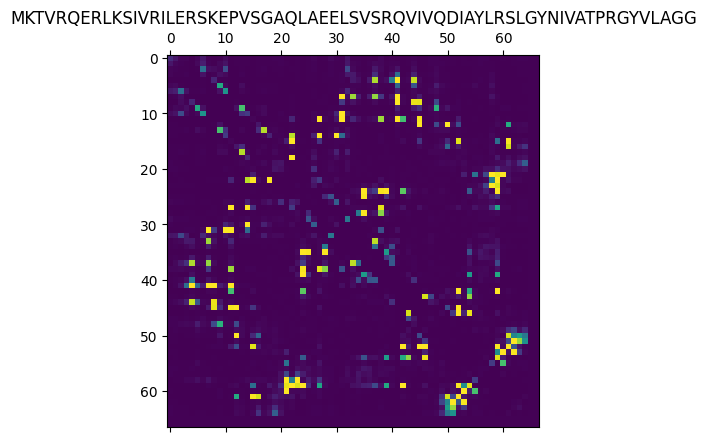

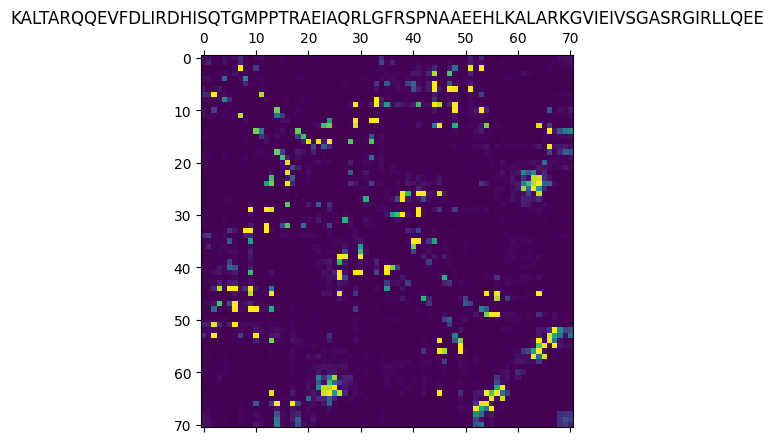

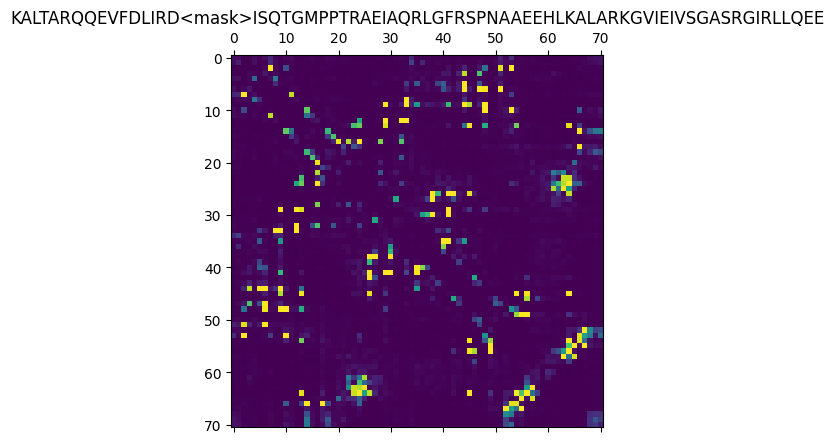

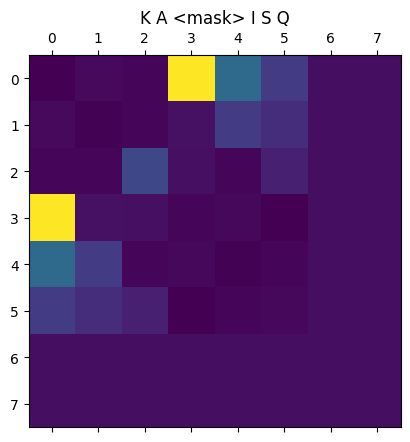

In [1]:
import torch
import esm

# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t36_3B_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    ("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein2 with mask","KALTARQQEVFDLIRD<mask>ISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein3",  "K A <mask> I S Q"),
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[36], return_contacts=True)
token_representations = results["representations"][36]

# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
sequence_representations = []
for i, tokens_len in enumerate(batch_lens):
    sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0))

# Look at the unsupervised self-attention map contact predictions
import matplotlib.pyplot as plt
for (_, seq), tokens_len, attention_contacts in zip(data, batch_lens, results["contacts"]):
    plt.matshow(attention_contacts[: tokens_len, : tokens_len])
    plt.title(seq)
    plt.show()


## Pepare the dataset

In [2]:
import pandas as pd

# Load the dataset
file_path = 'final_dataset/final_ready20250505_171511.pkl'
df = pd.read_pickle(file_path)

# Print the head of the dataframe
print("DataFrame Head:")
print(df.head(), df.shape)


DataFrame Head:
  #chr        pos variation variant_type      snp_id clinical_significance  \
0    1  169476354       T>C          snv  1000230073                   NaN   
1    1  169476354       T>C          snv  1000230073                normal   
2    1  169475878       T>C          snv  1000304891                normal   
3    1  169475878       T>C          snv  1000304891                   NaN   
4    1  169483460       T>C          snv  1000361639                normal   

                 validation_status  function_class     gene  \
0  by-frequency;by-alfa;by-cluster  intron_variant  SLC19A2   
1  by-frequency;by-alfa;by-cluster  intron_variant  SLC19A2   
2  by-frequency;by-alfa;by-cluster  intron_variant  SLC19A2   
3  by-frequency;by-alfa;by-cluster  intron_variant  SLC19A2   
4             by-frequency;by-alfa  intron_variant  SLC19A2   

                                           frequency original mutant  \
0  C:0.000013:2:GnomAD_genomes|C:0.000008:2:TOPME...        T   

In [4]:
# Drop any rows that contain error-related words (Error, error, fail, etc.)
print(f"Number of rows before cleaning: {len(df)}")

# Convert all values to string and check for error-related terms case-insensitively
error_pattern = '(?i)(error|fail|exception|invalid|timeout|crash)'
mask = df.astype(str).apply(lambda x: x.str.contains(error_pattern)).any(axis=1)
df_clean = df[~mask]

print(f"Number of rows after cleaning: {len(df_clean)}")
print(f"Removed {len(df) - len(df_clean)} rows containing error-related terms")

# Display the first few rows of the cleaned dataframe
df_clean.head()

Number of rows before cleaning: 22133


/tmp/ipykernel_422575/4041048286.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df.astype(str).apply(lambda x: x.str.contains(error_pattern)).any(axis=1)


Number of rows after cleaning: 22133
Removed 0 rows containing error-related terms


#chr        pos variation variant_type      snp_id clinical_significance  \
0    1  169476354       T>C          snv  1000230073                   nan   
1    1  169476354       T>C          snv  1000230073                normal   
2    1  169475878       T>C          snv  1000304891                normal   
3    1  169475878       T>C          snv  1000304891                   nan   
4    1  169483460       T>C          snv  1000361639                normal   

                 validation_status  function_class     gene  \
0  by-frequency;by-alfa;by-cluster  intron_variant  SLC19A2   
1  by-frequency;by-alfa;by-cluster  intron_variant  SLC19A2   
2  by-frequency;by-alfa;by-cluster  intron_variant  SLC19A2   
3  by-frequency;by-alfa;by-cluster  intron_variant  SLC19A2   
4             by-frequency;by-alfa  intron_variant  SLC19A2   

                                           frequency original mutant  \
0  C:0.000013:2:GnomAD_genomes|C:0.000008:2:TOPME...        T      C   
1  C:0.000013:2:GnomAD_genomes|C:0.000008:2:TOPME...        T      T   
2  C:0.000007:1:GnomAD_genomes|C:0.000008:2:TOPME...        T      T   
3  C:0.000007:1:GnomAD_genomes|C:0.000008:2:TOPME...        T      C   
4                                        C:0.:0:ALFA        T      T   

                                       generated_dna  \
0  ATTGTTGTTTTGTTTTTTGAGACGAGTACTCGCGAGTCTCGCTCTC...   
1  ATTGTTGTTTTGTTTTTTGAGACGAGTACTCGCGAGTCTCGCTCTC...   
2  ATTGTTGTTTTGTTTTTTGAGACGAGTACTCGCGAGTCTCGCTCTC...   
3  ATTGTTGTTTTGTTTTTTGAGACGAGTACTCGCGAGTCTCGCTCTC...   
4  ATTGTTGTTTTGTTTTTTGAGACGAGTACTCGCGAGTCTCGCTCTC...   

                                      generated_mRNA  \
0  AGAGGCGUCUGUAGGGUAAAGCUGGGGGUUCUGUAGCCGGAGGCGG...   
1  AGAGGCGUCUGUAGGGUAAAGCUGGGGGUUCUGUAGCCGGAGGCGG...   
2  AGAGGCGUCUGUAGGGUAAAGCUGGGGGUUCUGUAGCCGGAGGCGG...   
3  AGAGGCGUCUGUAGGGUAAAGCUGGGGGUUCUGUAGCCGGAGGCGG...   
4  AGAGGCGUCUGUAGGGUAAAGCUGGGGGUUCUGUAGCCGGAGGCGG...   

                                    protein_sequence  
0  MDVPGPVSRRAAAAAATVLLRTARVRRECWFLPTALLCAYGFFASL...  
1  MDVPGPVSRRAAAAAATVLLRTARVRRECWFLPTALLCAYGFFASL...  
2  MDVPGPVSRRAAAAAATVLLRTARVRRECWFLPTALLCAYGFFASL...  
3  MDVPGPVSRRAAAAAATVLLRTARVRRECWFLPTALLCAYGFFASL...  
4  MDVPGPVSRRAAAAAATVLLRTARVRRECWFLPTALLCAYGFFASL...

In [ ]:
#CAREFUL
# Process the reverse_complement_dna column to remove first 2000 and last 1000 bases
df_clean['reverse_complement_dna'] = df_clean['reverse_complement_dna'].apply(
    lambda seq: seq[2000:-1000] if len(seq) > 3000 else seq
)

# Display the processed dataframe
df_clean

#chr        pos variation variant_type      snp_id  \
0        2  227685064       G>A          snv  1000108682   
1        2  227685064       G>A          snv  1000108682   
2        2  227692888       A>T          snv  1000182811   
3        2  227692888       A>T          snv  1000182811   
4        2  227702777       T>A          snv  1000236352   
...    ...        ...       ...          ...         ...   
34471    2  227717362     G>A,C          snv   999920369   
34472    2  227713769       A>G          snv   999966616   
34473    2  227713769       A>G          snv   999966616   
34474    2  227690580       G>A          snv   999983906   
34475    2  227690580       G>A          snv   999983906   

      original_clinical_sig                validation_status  \
0                    normal                              NaN   
1                       NaN                              NaN   
2                    normal             by-frequency;by-alfa   
3                       NaN             by-frequency;by-alfa   
4                       NaN  by-frequency;by-alfa;by-cluster   
...                     ...                              ...   
34471                   NaN  by-frequency;by-alfa;by-cluster   
34472                   NaN  by-frequency;by-alfa;by-cluster   
34473                normal  by-frequency;by-alfa;by-cluster   
34474                normal  by-frequency;by-alfa;by-cluster   
34475                   NaN  by-frequency;by-alfa;by-cluster   

                                         function_class     gene  \
0                                   3_prime_UTR_variant  SLC19A3   
1                                   3_prime_UTR_variant  SLC19A3   
2                                        intron_variant  SLC19A3   
3                                        intron_variant  SLC19A3   
4                                        intron_variant  SLC19A3   
...                                                 ...      ...   
34471  intron_variant;genic_upstream_transcript_variant  SLC19A3   
34472  genic_upstream_transcript_variant;intron_variant  SLC19A3   
34473  genic_upstream_transcript_variant;intron_variant  SLC19A3   
34474                                    intron_variant  SLC19A3   
34475                                    intron_variant  SLC19A3   

                                               frequency original mutant  \
0                                                    NaN        G      G   
1                                                    NaN        G      A   
2                        T:0.000015:4:TOPMED|T:0.:0:ALFA        A      A   
3                        T:0.000015:4:TOPMED|T:0.:0:ALFA        A      T   
4      A:0.000021:3:GnomAD|A:0.000011:3:TOPMED|A:0.:0...        T      A   
...                                                  ...      ...    ...   
34471  A:0.000007:1:GnomAD|A:0.000004:1:TOPMED|A:0.:0...        G      C   
34472  G:0.000014:2:GnomAD|A:0.5:2:SGDP_PRJ|G:0.00002...        A      G   
34473  G:0.000014:2:GnomAD|A:0.5:2:SGDP_PRJ|G:0.00002...        A      A   
34474  A:0.000156:1:1000Genomes|A:0.000064:9:GnomAD|A...        G      G   
34475  A:0.000156:1:1000Genomes|A:0.000064:9:GnomAD|A...        G      A   

                                  reverse_complement_dna  \
0      AAGAGCGCCTGGATCCATCCGACAGCCGCGGGTGCGTGGTCGTGCG...   
1      AAGAGCGCCTGGATCCATCCGACAGCCGCGGGTGCGTGGTCGTGCG...   
2      AAGAGCGCCTGGATCCATCCGACAGCCGCGGGTGCGTGGTCGTGCG...   
3      AAGAGCGCCTGGATCCATCCGACAGCCGCGGGTGCGTGGTCGTGCG...   
4      AAGAGCGCCTGGATCCATCCGACAGCCGCGGGTGCGTGGTCGTGCG...   
...                                                  ...   
34471  AAGAGCGCCTGGATCCATCCGACAGCCGCGGGTGCGTGGTCGTGCG...   
34472  AAGAGCGCCTGGATCCATCCGACAGCCGCGGGTGCGTGGTCGTGCG...   
34473  AAGAGCGCCTGGATCCATCCGACAGCCGCGGGTGCGTGGTCGTGCG...   
34474  AAGAGCGCCTGGATCCATCCGACAGCCGCGGGTGCGTGGTCGTGCG...   
34475  AAGAGCGCCTGGATCCATCCGACAGCCGCGGGTGCGTGGTCGTGCG...   

                                          generated_mRNA  \
0    

In [5]:
# Rename the clinical_significance column to original_clinical_sig
if 'clinical_significance' in df_clean.columns and 'original_clinical_sig' not in df_clean.columns:
    df_clean = df_clean.rename(columns={'clinical_significance': 'original_clinical_sig'})
    print("Renamed 'clinical_significance' column to 'original_clinical_sig'")
elif 'original_clinical_sig' in df_clean.columns:
    print("Column 'original_clinical_sig' already exists")
else:
    print("Column 'clinical_significance' not found in the dataframe")

# Rename the generated_dna column to reverse_complement_dna if needed
if 'generated_dna' in df_clean.columns and 'reverse_complement_dna' not in df_clean.columns:
    df_clean = df_clean.rename(columns={'generated_dna': 'reverse_complement_dna'})
    print("Renamed 'generated_dna' column to 'reverse_complement_dna'")
elif 'reverse_complement_dna' in df_clean.columns:
    print("Column 'reverse_complement_dna' already exists")
else:
    print("Column 'generated_dna' not found in the dataframe")


Renamed 'clinical_significance' column to 'original_clinical_sig'
Renamed 'generated_dna' column to 'reverse_complement_dna'


In [6]:
# Identify SNP IDs with labels other than 'normal' and NaN
labeled_snps = df_clean.loc[
    (df_clean['original_clinical_sig'].notna()) & (df_clean['original_clinical_sig'] != 'nan') & (df_clean['original_clinical_sig'] != 'normal'),
    'snp_id'
].unique().tolist()

# Print the number of unique labeled SNP IDs
print(f"Found {len(labeled_snps)} unique SNP IDs with labels other than 'normal' and NaN")

# Filter dataframes based on SNP IDs
snp_id_mask = df_clean['snp_id'].isin(labeled_snps)
df_labeled = df_clean[snp_id_mask].copy()
df_unlabeled = df_clean[~snp_id_mask].copy()

print(f"Labeled data shape: {df_labeled.shape}")
print(f"Unlabeled data shape: {df_unlabeled.shape}")


Found 366 unique SNP IDs with labels other than 'normal' and NaN
Labeled data shape: (998, 15)
Unlabeled data shape: (21135, 15)


In [9]:
# Count the number of rows before filtering
print(f"Total rows before filtering: {len(df_unlabeled)}")

# Identify rows with 'normal' clinical significance
normal_mask = df_unlabeled['original_clinical_sig'] == 'normal'
normal_indices = df_unlabeled[normal_mask].index
non_normal_indices = df_unlabeled[~normal_mask].index

# Calculate how many 'normal' samples to keep (10%)
keep_count = int(len(normal_indices) * 0.1)

# Randomly select 10% of 'normal' samples to keep
import random
random.seed(42)  # For reproducibility
indices_to_keep = random.sample(list(normal_indices), keep_count) if len(normal_indices) > 0 else []

# Create a new dataframe with reduced 'normal' samples
filtered_indices = list(indices_to_keep) + list(non_normal_indices)
unlabeled_df = df_unlabeled.loc[filtered_indices]

# Count the number of rows after filtering
print(f"Total rows after filtering: {len(unlabeled_df)}")
print(f"Removed {len(normal_indices) - keep_count} 'normal' samples ({90 if len(normal_indices) > 0 else 0}% of normal samples)")

# Display the first few rows


Total rows before filtering: 21135
Total rows after filtering: 12927
Removed 8208 'normal' samples (90% of normal samples)


### continue for training

In [10]:
# clean labels
preprocess = df_labeled.copy()
# First, clean up extra whitespace
preprocess["original_clinical_sig"] = preprocess["original_clinical_sig"].str.strip()

# Define a mapping dictionary for the specific replacements
replacement_mapping = {
    "likely-benign;benign-likely-benign": "likely-benign",
    "likely-pathogenic;pathogenic": "likely-pathogenic",
    "uncertain-significance;likely-pathogenic": "likely-pathogenic",
    "likely-pathogenic;uncertain-significance": "likely-pathogenic",
    "likely-benign;uncertain-significance": "likely-benign",
    "likely-benign;conflicting-interpretations-of-pathogenicity": "likely-benign",
    "pathogenic;pathogenic-likely-pathogenic": "pathogenic",
    "conflicting-interpretations-of-pathogenicity": "uncertain-significance",
    "uncertain-significance;likely-benign": "likely-benign",
    "conflicting-interpretations-of-pathogenicity;uncertain-significance": "uncertain-significance",
    "conflicting-interpretations-of-pathogenicity;benign-likely-benign": "likely-benign",
    "uncertain-significance;likely-benign;conflicting-interpretations-of-pathogenicity;benign": "likely-benign",
    "conflicting-interpretations-of-pathogenicity;likely-benign": "likely-benign",
    "benign-likely-benign;conflicting-interpretations-of-pathogenicity;uncertain-significance": "likely-benign",
    "benign-likely-benign;benign": "likely-benign",
    "benign;likely-benign": "likely-benign",
    "benign;likely-benign;conflicting-interpretations-of-pathogenicity": "likely-benign",
    "benign;likely-benign;conflicting-interpretations-of-pathogenicity;uncertain-significance": "likely-benign",
    "benign;likely-benign;conflicting-interpretations-of-pathogenicity;benign-likely-benign": "likely-benign",
    "benign;likely-benign;conflicting-interpretations-of-pathogenicity;benign": "likely-benign",
    "benign;likely-benign;conflicting-interpretations-of-pathogenicity;benign-likely-benign": "likely-benign",
    "uncertain-significance;pathogenic": "pathogenic",
    "likely-pathogenic;pathogenic-likely-pathogenic": "likely-pathogenic",
    "likely-pathogenic;benign": "uncertain-significance",
    "uncertain-significance;not-provided": "uncertain-significance",
    "uncertain-significance;benign-likely-benign": "likely-benign",
    "likely-benign;uncertain-significance;benign": "likely-benign",
    "benign-likely-benign;uncertain-significance;benign": "likely-benign",
    "pathogenic-likely-pathogenic;likely-pathogenic": "likely-pathogenic",
    "benign;uncertain-significance;likely-benign": "likely-benign",
    "benign;likely-benign;uncertain-significance": "likely-benign",
    "conflicting-interpretations-of-pathogenicity;uncertain-significance;likely-benign": "likely-benign",
    "pathogenic;likely-pathogenic": "likely-pathogenic",
    "uncertain-significance;not-provided": "uncertain-significance",
    "likely-benign;benign": "likely-benign",
    "uncertain-significance;benign-likely-benign": "likely-benign",
    "uncertain-significance;benign-likely-benign": "likely-benign",
    "conflicting-interpretations-of-pathogenicity;uncertain-significance;likely-benign": "likely-benign",
    "pathogenic;uncertain-significance": "likely-pathogenic",
    "benign;uncertain-significance": "likely-benign",
    "uncertain-significance;likely-benign;benign": "likely-benign",
    

}

# Make a copy of the original column to compare later
preprocess["clinical_significance_before"] = preprocess["original_clinical_sig"].copy()

# Replace exact string matches using the mapping
preprocess["original_clinical_sig"] = preprocess["original_clinical_sig"].replace(replacement_mapping)

# Count how many changes were made
changes_count = (preprocess["original_clinical_sig"] != preprocess["clinical_significance_before"]).sum()
print(f"\nNumber of clinical significance labels changed: {changes_count}")

# Drop the temporary column used for comparison
preprocess.drop("clinical_significance_before", axis=1, inplace=True)





Number of clinical significance labels changed: 63


In [11]:
df_processed = preprocess.copy()

# Map clinical significance to continuous labels
clinical_sig_mapping = {
    'normal': 3,
    'benign': 2,
    'likely-benign': 1,
    'uncertain-significance': 0,
    'likely-pathogenic': -1,
    'pathogenic': -2
}

# Create ContinuousLabel column based on original_clinical_sig
df_processed['ContinuousLabel'] = df_processed['original_clinical_sig'].map(clinical_sig_mapping)

# Rename reverse_complement_dna column to sequence
df_processed.rename(columns={'reverse_complement_dna': 'sequence'}, inplace=True)

# Print how many mappings have been done successfully
print(f"Successfully mapped {df_processed['ContinuousLabel'].count()} out of {len(df_processed)} clinical significance values.")

Successfully mapped 998 out of 998 clinical significance values.


In [12]:
print(df_processed.shape)
df_processed.head()

# Print length of first 10 rows of sequence column
for i in range(min(10, len(df_processed))):
    print(f"Row {i} sequence length: {len(df_processed['sequence'].iloc[i])}")

(998, 16)
Row 0 sequence length: 26062
Row 1 sequence length: 26062
Row 2 sequence length: 26062
Row 3 sequence length: 26062
Row 4 sequence length: 26062
Row 5 sequence length: 26062
Row 6 sequence length: 26062
Row 7 sequence length: 26062
Row 8 sequence length: 26055
Row 9 sequence length: 26052


In [13]:
df_processed.head()

#chr        pos variation variant_type      snp_id original_clinical_sig  \
139    1  169470151       T>C          snv  1009996634         likely-benign   
140    1  169470151       T>C          snv  1009996634                normal   
468    1  169477138     T>C,G          snv  1029046824                normal   
469    1  169477138     T>C,G          snv  1029046824         likely-benign   
470    1  169477138     T>C,G          snv  1029046824         likely-benign   

                   validation_status  \
139  by-frequency;by-alfa;by-cluster   
140  by-frequency;by-alfa;by-cluster   
468                       by-cluster   
469                       by-cluster   
470                       by-cluster   

                                 function_class     gene  \
139  synonymous_variant;coding_sequence_variant  SLC19A2   
140  synonymous_variant;coding_sequence_variant  SLC19A2   
468                              intron_variant  SLC19A2   
469                              intron_variant  SLC19A2   
470                              intron_variant  SLC19A2   

                                             frequency original mutant  \
139  C:0.000002:1:GnomAD_exomes|C:0.000007:1:GnomAD...        T      C   
140  C:0.000002:1:GnomAD_exomes|C:0.000007:1:GnomAD...        T      T   
468                                                nan        T      T   
469                                                nan        T      G   
470                                                nan        T      C   

                                              sequence  \
139  ATTGTTGTTTTGTTTTTTGAGACGAGTACTCGCGAGTCTCGCTCTC...   
140  ATTGTTGTTTTGTTTTTTGAGACGAGTACTCGCGAGTCTCGCTCTC...   
468  ATTGTTGTTTTGTTTTTTGAGACGAGTACTCGCGAGTCTCGCTCTC...   
469  ATTGTTGTTTTGTTTTTTGAGACGAGTACTCGCGAGTCTCGCTCTC...   
470  ATTGTTGTTTTGTTTTTTGAGACGAGTACTCGCGAGTCTCGCTCTC...   

                                        generated_mRNA  \
139  AGAGGCGUCUGUAGGGUAAAGCUGGGGGUUCUGUAGCCGGAGGCGG...   
140  AGAGGCGUCUGUAGGGUAAAGCUGGGGGUUCUGUAGCCGGAGGCGG...   
468  AGAGGCGUCUGUAGGGUAAAGCUGGGGGUUCUGUAGCCGGAGGCGG...   
469  AGAGGCGUCUGUAGGGUAAAGCUGGGGGUUCUGUAGCCGGAGGCGG...   
470  AGAGGCGUCUGUAGGGUAAAGCUGGGGGUUCUGUAGCCGGAGGCGG...   

                                      protein_sequence  ContinuousLabel  
139  MDVPGPVSRRAAAAAATVLLRTARVRRECWFLPTALLCAYGFFASL...                1  
140  MDVPGPVSRRAAAAAATVLLRTARVRRECWFLPTALLCAYGFFASL...                3  
468  MDVPGPVSRRAAAAAATVLLRTARVRRECWFLPTALLCAYGFFASL...                3  
469  MDVPGPVSRRAAAAAATVLLRTARVRRECWFLPTALLCAYGFFASL...                1  
470  MDVPGPVSRRAAAAAATVLLRTARVRRECWFLPTALLCAYGFFASL...                1

### Continue for labeling

In [15]:
df_test = unlabeled_df.copy()

# Map clinical significance to continuous labels
clinical_sig_mapping = {
    'normal': 3,
    'benign': 2,
    'likely-benign': 1,
    'uncertain-significance': 0,
    'likely-pathogenic': -1,
    'pathogenic': -2
}

# Create ContinuousLabel column based on original_clinical_sig
df_test['ContinuousLabel'] = df_test['original_clinical_sig'].map(clinical_sig_mapping)

# Rename reverse_complement_dna column to sequence
df_test.rename(columns={'reverse_complement_dna': 'sequence'}, inplace=True)

In [19]:
print(df_test.shape)
df_processed = df_test

(21181, 16)


In [20]:
# gener

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd # Make sure pandas is imported if pd.isna is used

# Ensure df_processed exists from the previous cell
if 'df_processed' not in locals():
    raise NameError("df_processed is not defined. Please run the previous cell to generate it.")
# Ensure get_dna_embeddings, model, and tokenizer are defined
if 'get_dna_embeddings' not in locals() or 'model' not in locals() or 'tokenizer' not in locals():
     raise NameError("get_dna_embeddings, model, or tokenizer is not defined. Please ensure they are loaded.")

# Set device to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to device
model = model.to(device)

# --- 1. Generate Embeddings using df_processed (Splitting Sequences) ---
print("Generating embeddings for processed sequences (splitting into 5 parts)...")
combined_embeddings_list_nn = []
sequences_list_nn = [] # Keep track of original sequences corresponding to embeddings
num_parts = 5
embedding_dim_per_part = -1 # Will be determined by the first successful embedding

# Use mean pooling embeddings for this task (applied to each part)
embedding_type_nn = 'mean' # or 'max' or 'concatenate'

# Limit the number of sequences for faster testing/debugging if needed
# df_subset_nn = df_processed.head(200) # Uncomment for testing
df_subset_nn = df_processed

# Assuming get_dna_embeddings, model, and tokenizer are defined from earlier cells
for index, row in tqdm(df_subset_nn.iterrows(), total=df_subset_nn.shape[0], desc="Processing sequences for NN"):
    sequence = row['sequence']

    # Ensure sequence is a string and not empty
    if not isinstance(sequence, str) or len(sequence) == 0:
        print(f"Skipping row {index}: Invalid sequence '{sequence}'")
        continue

    # Ensure sequence is long enough to be split (optional, depends on desired handling)
    min_len_per_part = 10 # Example minimum length for a part to be meaningful
    if len(sequence) < num_parts * min_len_per_part:
        print(f"Skipping row {index}: Sequence too short ({len(sequence)} bases) to split into {num_parts} parts of min length {min_len_per_part}.")
        continue

    part_embeddings = []
    try:
        # Split sequence into num_parts roughly equal parts
        seq_len = len(sequence)
        part_len = seq_len // num_parts
        start_indices = [i * part_len for i in range(num_parts)]
        # Adjust the last part to include any remainder
        end_indices = [(i + 1) * part_len for i in range(num_parts - 1)] + [seq_len]

        for i in range(num_parts):
            sub_sequence = sequence[start_indices[i]:end_indices[i]]

            if len(sub_sequence) == 0: # Should not happen with the length check above, but good practice
                print(f"Warning: Skipping empty sub-sequence for row {index}, part {i+1}")
                continue # Or handle by padding/zero-vector

            # Get embeddings for the sub-sequence
            emb_mean, emb_max = get_dna_embeddings(sub_sequence, model, tokenizer)

            if embedding_type_nn == 'mean':
                embedding_part = emb_mean.cpu().numpy().flatten() # Flatten in case it's not already 1D
            elif embedding_type_nn == 'max':
                embedding_part = emb_max.cpu().numpy().flatten()
            elif embedding_type_nn == 'concatenate':
                # Concatenate along feature dim (dim=1 if batch dim exists, dim=0 otherwise)
                embedding_part = torch.cat((emb_mean, emb_max), dim=emb_mean.dim()-1).cpu().numpy().flatten()
            else:
                 # Default to mean if type is unknown
                embedding_part = emb_mean.cpu().numpy().flatten()

            if embedding_dim_per_part == -1:
                embedding_dim_per_part = len(embedding_part) # Set the expected dimension

            # Ensure consistent embedding dimension (handle potential errors from get_dna_embeddings)
            if len(embedding_part) != embedding_dim_per_part:
                 raise ValueError(f"Inconsistent embedding dimension for part {i+1} of sequence {index}. Expected {embedding_dim_per_part}, got {len(embedding_part)}.")

            part_embeddings.append(embedding_part)

        # Check if we got the expected number of embeddings
        if len(part_embeddings) == num_parts:
            # Combine the embeddings for the parts (concatenate them)
            combined_embedding = np.concatenate(part_embeddings)
            combined_embeddings_list_nn.append(combined_embedding)
            sequences_list_nn.append(sequence) # Store the original sequence
        else:
             print(f"Skipping row {index}: Could not generate embeddings for all {num_parts} parts (got {len(part_embeddings)}).")


    except Exception as e:
        print(f"Error processing sequence at index {index} ('{sequence[:30]}...'): {e}")
        # Optionally skip problematic sequences or handle differently
        continue

# Convert lists to NumPy arrays
X_nn = np.array(combined_embeddings_list_nn)

if X_nn.shape[0] > 0:
    print(f"\nGenerated {X_nn.shape[0]} combined embeddings of shape {X_nn.shape[1]} (from {num_parts} parts).")
    print(f"Individual part embedding dimension: {embedding_dim_per_part}")
else:
    print("\nNo combined embeddings were generated. Cannot proceed with further processing.")
    # Exit or handle the case where no data is available
    # raise SystemExit("Stopping execution: No embeddings generated.") # Or similar

Using device: cuda
Generating embeddings for processed sequences (splitting into 5 parts)...


Processing sequences for NN:   0%|          | 0/21181 [00:00<?, ?it/s]/home/youss/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/d064dece8a8b41d9fb8729fbe3435278786931f1/bert_layers.py:433: UserWarning: Increasing alibi size from 512 to 1298
  warnings.warn(
/home/youss/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/d064dece8a8b41d9fb8729fbe3435278786931f1/bert_layers.py:433: UserWarning: Increasing alibi size from 1298 to 1302
  warnings.warn(
/home/youss/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/d064dece8a8b41d9fb8729fbe3435278786931f1/bert_layers.py:433: UserWarning: Increasing alibi size from 1302 to 1304
  warnings.warn(
Processing sequences for NN:   6%|▋         | 1367/21181 [04:57<1:05:15,  5.06it/s]/home/youss/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/d064dece8a8b41d9fb8729fbe3435278786931f1/bert_layers.py:433: UserWarning: Increasing alibi size from 1304 to 13


Generated 21181 combined embeddings of shape 3840 (from 5 parts).
Individual part embedding dimension: 768


In [22]:
# Save DNA-BERT embeddings with timestamp
import time
timestamp = int(time.time())
np.save(f"dnabert_embeddings_{timestamp}.npy", X_nn)
print(f"Saved DNA-BERT embeddings to dnabert_embeddings_{timestamp}.npy")

Saved DNA-BERT embeddings to dnabert_embeddings_1744376359.npy


In [25]:
# Load the specific DNA-BERT embeddings file
import os
import numpy as np

# Load the specific file
file_path = "dnabert_embeddings_1744193142.npy"
X_nn = np.load(file_path)
print(f"Loaded DNA-BERT embeddings from {file_path}")
print(f"Loaded embedding shape: {X_nn.shape}")


Loaded DNA-BERT embeddings from dnabert_embeddings_1744193142.npy
Loaded embedding shape: (17227, 3840)


In [23]:
# --- 2. Generate Embeddings using ESM-2 model ---
print("Generating embeddings using ESM-2 model...")

# Load ESM-2 model (smaller version for efficiency)
print("Loading ESM-2 model...")
import esm
esm_model, alphabet = esm.pretrained.esm2_t36_3B_UR50D()
batch_converter = alphabet.get_batch_converter()
esm_model.eval()  # disables dropout for deterministic results

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
esm_model = esm_model.to(device)

# Function to get ESM-2 embeddings for protein sequences
def get_esm2_embeddings(sequence, model, alphabet, batch_converter, device):
    # Prepare data for ESM-2
    data = [("seq", sequence)]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    
    # Move to GPU
    batch_tokens = batch_tokens.to(device)
    
    # Get embeddings
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33], return_contacts=True)
    token_representations = results["representations"][33]
    
    # Generate sequence representation via averaging (mean pooling)
    # NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)
    sequence_representation = token_representations[0, 1:batch_lens[0]-1].mean(0)
    
    # Also compute max pooling for comparison
    sequence_representation_max = token_representations[0, 1:batch_lens[0]-1].max(0)[0]
    
    return sequence_representation, sequence_representation_max

# Lists to store ESM-2 embeddings
embeddings_list_esm2 = []
sequences_list_esm2 = []
error_snp_ids = []  # Track SNP IDs with errors

# Process sequences with ESM-2
for index, row in tqdm(df_subset_nn.iterrows(), total=df_subset_nn.shape[0], desc="Processing sequences for ESM-2"):
    # Use protein_sequence column instead of sequence
    sequence = row['protein_sequence']
    snp_id = row.get('snp_id', 'unknown')  # Get SNP ID if available
    
    # Ensure sequence is a string and not empty
    if not isinstance(sequence, str) or len(sequence) == 0:
        print(f"Skipping row {index}: Invalid protein sequence '{sequence}'")
        error_snp_ids.append(snp_id)
        continue
    
    try:
        # Get embeddings for the whole sequence using ESM-2
        emb_mean, emb_max = get_esm2_embeddings(sequence, esm_model, alphabet, batch_converter, device)
        
        # Use mean embeddings by default
        embedding = emb_mean.cpu().numpy().flatten()
        
        # Store the embedding and corresponding sequence
        embeddings_list_esm2.append(embedding)
        sequences_list_esm2.append(sequence)
    
    except Exception as e:
        print(f"Error processing protein sequence at index {index} ('{sequence[:30]}...'): {e}")
        error_snp_ids.append(snp_id)
        continue

# Convert lists to NumPy arrays
X_nn_esm2 = np.array(embeddings_list_esm2)

if X_nn_esm2.shape[0] > 0:
    print(f"\nGenerated {X_nn_esm2.shape[0]} ESM-2 embeddings of shape {X_nn_esm2.shape[1]}")
else:
    print("\nNo ESM-2 embeddings were generated. Cannot proceed with ESM-2 model training.")

# Print SNP IDs with errors
if error_snp_ids:
    print("\nSNP IDs with errors during ESM-2 embedding generation:")
    for snp_id in error_snp_ids:
        print(f"  - {snp_id}")


Generating embeddings using ESM-2 model...
Loading ESM-2 model...
Using device: cuda


Processing sequences for ESM-2: 100%|██████████| 21181/21181 [1:22:46<00:00,  4.26it/s]  


Generated 21181 ESM-2 embeddings of shape 2560


In [24]:
# Save the generated ESM-2 embeddings locally
if X_nn_esm2.shape[0] > 0:
    print("\nSaving ESM-2 embeddings to disk...")
    import os
    import datetime
    
    # Create directory if it doesn't exist
    save_dir = "embeddings"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"Created directory: {save_dir}")
    
    # Generate timestamp for filenames
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save embeddings and labels with timestamp
    np.save(os.path.join(save_dir, f"X_nn_esm2_{timestamp}.npy"), X_nn_esm2)
    
    
    # Save sequences for reference with timestamp
    with open(os.path.join(save_dir, f"sequences_esm2_{timestamp}.txt"), "w") as f:
        for seq in sequences_list_esm2:
            f.write(f"{seq}\n")
    
    print(f"Saved ESM-2 embeddings to {save_dir}/X_nn_esm2_{timestamp}.npy")
    print(f"Saved labels to {save_dir}/y_nn_esm2_{timestamp}.npy")
    print(f"Saved sequences to {save_dir}/sequences_esm2_{timestamp}.txt")
else:
    print("No ESM-2 embeddings to save.")



Saving ESM-2 embeddings to disk...
Saved ESM-2 embeddings to embeddings/X_nn_esm2_20250411_072224.npy
Saved labels to embeddings/y_nn_esm2_20250411_072224.npy
Saved sequences to embeddings/sequences_esm2_20250411_072224.txt


In [26]:
# Load the previously saved ESM-2 embeddings
import numpy as np
import os

# Path to the saved embeddings
embeddings_path = "embeddings/X_nn_esm2_20250409_082511.npy"

# Check if the file exists
if os.path.exists(embeddings_path):
    print(f"Loading ESM-2 embeddings from {embeddings_path}...")
    X_nn_esm2 = np.load(embeddings_path)
    print(f"Loaded ESM-2 embeddings with shape: {X_nn_esm2.shape}")
else:
    print(f"Error: Could not find embeddings file at {embeddings_path}")
    X_nn_esm2 = np.array([])

Loading ESM-2 embeddings from embeddings/X_nn_esm2_20250409_082511.npy...
Loaded ESM-2 embeddings with shape: (17227, 2560)


## Generating Embeddings

### DNABERT EMBEDDINGS

In [27]:
# gener

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd # Make sure pandas is imported if pd.isna is used

# Ensure df_processed exists from the previous cell
if 'df_processed' not in locals():
    raise NameError("df_processed is not defined. Please run the previous cell to generate it.")
# Ensure get_dna_embeddings, model, and tokenizer are defined
if 'get_dna_embeddings' not in locals() or 'model' not in locals() or 'tokenizer' not in locals():
     raise NameError("get_dna_embeddings, model, or tokenizer is not defined. Please ensure they are loaded.")

# Set device to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to device
model = model.to(device)

# --- 1. Generate Embeddings using df_processed (Splitting Sequences) ---
print("Generating embeddings for processed sequences (splitting into 5 parts)...")
combined_embeddings_list_nn = []
labels_list_nn = []
sequences_list_nn = [] # Keep track of original sequences corresponding to embeddings
num_parts = 5
embedding_dim_per_part = -1 # Will be determined by the first successful embedding

# Use mean pooling embeddings for this task (applied to each part)
embedding_type_nn = 'mean' # or 'max' or 'concatenate'

# Limit the number of sequences for faster testing/debugging if needed
# df_subset_nn = df_processed.head(200) # Uncomment for testing
df_subset_nn = df_processed

# Assuming get_dna_embeddings, model, and tokenizer are defined from earlier cells
for index, row in tqdm(df_subset_nn.iterrows(), total=df_subset_nn.shape[0], desc="Processing sequences for NN"):
    sequence = row['sequence']
    label = row['ContinuousLabel'] # Assuming this is the correct label column

    # Ensure sequence is a string and not empty
    if not isinstance(sequence, str) or len(sequence) == 0:
        print(f"Skipping row {index}: Invalid sequence '{sequence}'")
        continue

    # Ensure label is valid (e.g., not NaN)
    if pd.isna(label):
        print(f"Skipping row {index}: Invalid label '{label}'")
        continue

    # Ensure sequence is long enough to be split (optional, depends on desired handling)
    min_len_per_part = 10 # Example minimum length for a part to be meaningful
    if len(sequence) < num_parts * min_len_per_part:
        print(f"Skipping row {index}: Sequence too short ({len(sequence)} bases) to split into {num_parts} parts of min length {min_len_per_part}.")
        continue

    part_embeddings = []
    try:
        # Split sequence into num_parts roughly equal parts
        seq_len = len(sequence)
        part_len = seq_len // num_parts
        start_indices = [i * part_len for i in range(num_parts)]
        # Adjust the last part to include any remainder
        end_indices = [(i + 1) * part_len for i in range(num_parts - 1)] + [seq_len]

        for i in range(num_parts):
            sub_sequence = sequence[start_indices[i]:end_indices[i]]

            if len(sub_sequence) == 0: # Should not happen with the length check above, but good practice
                print(f"Warning: Skipping empty sub-sequence for row {index}, part {i+1}")
                continue # Or handle by padding/zero-vector

            # Get embeddings for the sub-sequence
            emb_mean, emb_max = get_dna_embeddings(sub_sequence, model, tokenizer)

            if embedding_type_nn == 'mean':
                embedding_part = emb_mean.cpu().numpy().flatten() # Flatten in case it's not already 1D
            elif embedding_type_nn == 'max':
                embedding_part = emb_max.cpu().numpy().flatten()
            elif embedding_type_nn == 'concatenate':
                # Concatenate along feature dim (dim=1 if batch dim exists, dim=0 otherwise)
                embedding_part = torch.cat((emb_mean, emb_max), dim=emb_mean.dim()-1).cpu().numpy().flatten()
            else:
                 # Default to mean if type is unknown
                embedding_part = emb_mean.cpu().numpy().flatten()

            if embedding_dim_per_part == -1:
                embedding_dim_per_part = len(embedding_part) # Set the expected dimension

            # Ensure consistent embedding dimension (handle potential errors from get_dna_embeddings)
            if len(embedding_part) != embedding_dim_per_part:
                 raise ValueError(f"Inconsistent embedding dimension for part {i+1} of sequence {index}. Expected {embedding_dim_per_part}, got {len(embedding_part)}.")

            part_embeddings.append(embedding_part)

        # Check if we got the expected number of embeddings
        if len(part_embeddings) == num_parts:
            # Combine the embeddings for the parts (concatenate them)
            combined_embedding = np.concatenate(part_embeddings)
            combined_embeddings_list_nn.append(combined_embedding)
            labels_list_nn.append(label)
            sequences_list_nn.append(sequence) # Store the original sequence
        else:
             print(f"Skipping row {index}: Could not generate embeddings for all {num_parts} parts (got {len(part_embeddings)}).")


    except Exception as e:
        print(f"Error processing sequence at index {index} ('{sequence[:30]}...'): {e}")
        # Optionally skip problematic sequences or handle differently
        continue

# Convert lists to NumPy arrays
X_nn = np.array(combined_embeddings_list_nn)
y_nn_original = np.array(labels_list_nn)

if X_nn.shape[0] > 0:
    print(f"\nGenerated {X_nn.shape[0]} combined embeddings of shape {X_nn.shape[1]} (from {num_parts} parts).")
    print(f"Individual part embedding dimension: {embedding_dim_per_part}")
    print(f"Corresponding labels shape: {y_nn_original.shape}")
else:
    print("\nNo combined embeddings were generated. Cannot proceed with NN training.")
    # Exit or handle the case where no data is available
    # raise SystemExit("Stopping execution: No embeddings generated.") # Or similar

Using device: cuda
Generating embeddings for processed sequences (splitting into 5 parts)...


Processing sequences for NN:  50%|█████     | 499/998 [01:08<01:11,  7.00it/s]/home/joe/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/d064dece8a8b41d9fb8729fbe3435278786931f1/bert_layers.py:433: UserWarning: Increasing alibi size from 1027 to 1028
  warnings.warn(
Processing sequences for NN: 100%|██████████| 998/998 [02:15<00:00,  7.37it/s]


Generated 998 combined embeddings of shape 3840 (from 5 parts).
Individual part embedding dimension: 768
Corresponding labels shape: (998,)


In [40]:
# Save DNA-BERT embeddings with timestamp
import time
timestamp = int(time.time())
np.save(f"embeddings/dnabert_embeddings_{timestamp}.npy", X_nn)
print(f"Saved DNA-BERT embeddings to dnabert_embeddings_{timestamp}.npy")

Saved DNA-BERT embeddings to dnabert_embeddings_1746521289.npy


In [29]:

# Load the DNA-BERT embeddings from the specified file
X_nn = np.load("embeddings/dnabert_embeddings_1746521289.npy")
print(f"Loaded DNA-BERT embeddings from embeddings/dnabert_embeddings_1746521289.npy with shape: {X_nn.shape}")

Loaded DNA-BERT embeddings from embeddings/dnabert_embeddings_1746521289.npy with shape: (998, 3840)


In [12]:

import gc

# Empty CUDA cache to free up GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    
# Force garbage collection to release memory
gc.collect()

print("GPU memory cleaned after DNA-BERT processing")


GPU memory cleaned after DNA-BERT processing


### SM-2 Embeddings

In [16]:
# --- 2. Generate Embeddings using ESM-2 model ---
print("Generating embeddings using ESM-2 model...")

# Load ESM-2 model (smaller version for efficiency)
print("Loading ESM-2 model...")
import esm
from tqdm.auto import tqdm

esm_model, alphabet = esm.pretrained.esm2_t36_3B_UR50D()
batch_converter = alphabet.get_batch_converter()
esm_model.eval()  # disables dropout for deterministic results

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
esm_model = esm_model.to(device)
df_subset_nn = df_processed
# Function to get ESM-2 embeddings for protein sequences
def get_esm2_embeddings(sequence, model, alphabet, batch_converter, device):
    # Prepare data for ESM-2
    data = [("seq", sequence)]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    
    # Move to GPU
    batch_tokens = batch_tokens.to(device)
    
    # Get embeddings
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[36], return_contacts=True)
    token_representations = results["representations"][36]
    
    # Generate sequence representation via averaging (mean pooling)
    # NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)
    sequence_representation = token_representations[0, 1:batch_lens[0]-1].mean(0)
    
    # Also compute max pooling for comparison
    sequence_representation_max = token_representations[0, 1:batch_lens[0]-1].max(0)[0]
    
    return sequence_representation, sequence_representation_max

# Lists to store ESM-2 embeddings
embeddings_list_esm2 = []
labels_list_esm2 = []
sequences_list_esm2 = []
error_snp_ids = []  # Track SNP IDs with errors

# Process sequences with ESM-2
for index, row in tqdm(df_subset_nn.iterrows(), total=df_subset_nn.shape[0], desc="Processing sequences for ESM-2"):
    # Use protein_sequence column instead of sequence
    sequence = row['protein_sequence']
    label = row['ContinuousLabel']
    snp_id = row.get('snp_id', 'unknown')  # Get SNP ID if available
    
    # Ensure sequence is a string and not empty
    if not isinstance(sequence, str) or len(sequence) == 0:
        print(f"Skipping row {index}: Invalid protein sequence '{sequence}'")
        error_snp_ids.append(snp_id)
        continue
    
    # Ensure label is valid
    if pd.isna(label):
        print(f"Skipping row {index}: Invalid label '{label}'")
        error_snp_ids.append(snp_id)
        continue
    
    try:
        # Get embeddings for the whole sequence using ESM-2
        emb_mean, emb_max = get_esm2_embeddings(sequence, esm_model, alphabet, batch_converter, device)
        
        # Use mean embeddings by default
        embedding = emb_mean.cpu().numpy().flatten()
        
        # Store the embedding and corresponding label
        embeddings_list_esm2.append(embedding)
        labels_list_esm2.append(label)
        sequences_list_esm2.append(sequence)
    
    except Exception as e:
        print(f"Error processing protein sequence at index {index} ('{sequence[:30]}...'): {e}")
        error_snp_ids.append(snp_id)
        continue

# Convert lists to NumPy arrays
X_nn_esm2 = np.array(embeddings_list_esm2)
y_nn_esm2 = np.array(labels_list_esm2)

if X_nn_esm2.shape[0] > 0:
    print(f"\nGenerated {X_nn_esm2.shape[0]} ESM-2 embeddings of shape {X_nn_esm2.shape[1]}")
    print(f"Corresponding labels shape: {y_nn_esm2.shape}")
else:
    print("\nNo ESM-2 embeddings were generated. Cannot proceed with ESM-2 model training.")

# Print SNP IDs with errors
if error_snp_ids:
    print("\nSNP IDs with errors during ESM-2 embedding generation:")
    for snp_id in error_snp_ids:
        print(f"  - {snp_id}")


Generating embeddings using ESM-2 model...
Loading ESM-2 model...
Using device: cuda


Processing sequences for ESM-2: 100%|██████████| 998/998 [03:28<00:00,  4.78it/s]


Generated 998 ESM-2 embeddings of shape 2560
Corresponding labels shape: (998,)


In [ ]:
# Save the generated ESM-2 embeddings locally
if X_nn_esm2.shape[0] > 0:
    print("\nSaving ESM-2 embeddings to disk...")
    import os
    import datetime
    
    # Create directory if it doesn't exist
    save_dir = "embeddings"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"Created directory: {save_dir}")
    
    # Generate timestamp for filenames
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save embeddings and labels with timestamp
    np.save(os.path.join(save_dir, f"X_nn_esm2_{timestamp}.npy"), X_nn_esm2)
    np.save(os.path.join(save_dir, f"y_nn_esm2_{timestamp}.npy"), y_nn_esm2)
    
    # Save sequences for reference with timestamp
    with open(os.path.join(save_dir, f"sequences_esm2_{timestamp}.txt"), "w") as f:
        for seq in sequences_list_esm2:
            f.write(f"{seq}\n")
    
    print(f"Saved ESM-2 embeddings to {save_dir}/X_nn_esm2_{timestamp}.npy")
    print(f"Saved labels to {save_dir}/y_nn_esm2_{timestamp}.npy")
    print(f"Saved sequences to {save_dir}/sequences_esm2_{timestamp}.txt")
else:
    print("No ESM-2 embeddings to save.")



Saving ESM-2 embeddings to disk...
Saved ESM-2 embeddings to embeddings/X_nn_esm2_20250409_015131.npy
Saved labels to embeddings/y_nn_esm2_20250409_015131.npy
Saved sequences to embeddings/sequences_esm2_20250409_015131.txt


### Fusing both embeddings

In [18]:
# Ensure that the number of embeddings from both methods match
if X_nn.shape[0] != X_nn_esm2.shape[0]:
    raise ValueError("Mismatch in number of embeddings: DNA embeddings have shape {} while ESM-2 embeddings have shape {}.".format(X_nn.shape, X_nn_esm2.shape))

# Fuse the embeddings by concatenating along the feature dimension (axis=1)
X_fused = np.concatenate((X_nn, X_nn_esm2), axis=1)

# Print the shape of the fused embeddings
print("Fused embeddings shape:", X_fused.shape)


Fused embeddings shape: (998, 6400)


## Building the Classifier

### Hyperparamter Grid Search for DNA_BERT ONLY


Preparing data for PyTorch...
Filtered out 161 samples with label 0.
Remaining samples: 837
Original labels encoded to 5 classes.
Labels (encoded): [0 1 2 3 4]
Class mapping (Encoded Value: Class Name):
  0: Negative Medium (-2)
  1: Negative Low (-1)
  2: Positive Low (1)
  3: Positive Medium (2)
  4: Positive High (3)

Data split into training (585 samples), validation (126 samples), and testing (126 samples).

Addressing class imbalance...
Training set class counts (encoded): [ 35  10 259  25 256]
  Class 0 (Negative Medium (-2)): 35 samples
  Class 1 (Negative Low (-1)): 10 samples
  Class 2 (Positive Low (1)): 259 samples
  Class 3 (Positive Medium (2)): 25 samples
  Class 4 (Positive High (3)): 256 samples
Using WeightedRandomSampler for training data.

Defining the Neural Network...
Total hyperparameter combinations: 960
Limiting to 120 combinations out of 960 possible combinations
Will evaluate 120 hyperparameter combinations

Starting Grid Search with 120 combinations...
Usin

  Epoch 1/500 - Train Loss: 1.0716, Train Acc: 0.3880 | Val Loss: 1.6561, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.1037, Train Acc: 0.7556 | Val Loss: 3.4152, Val Acc: 0.4286


  Epoch 20/500 - Train Loss: 0.0443, Train Acc: 0.9077 | Val Loss: 8.4716, Val Acc: 0.0714


  Epoch 30/500 - Train Loss: 0.0423, Train Acc: 0.9385 | Val Loss: 2.8026, Val Acc: 0.3571


  Epoch 40/500 - Train Loss: 0.0256, Train Acc: 0.9504 | Val Loss: 2.8800, Val Acc: 0.1190


  Epoch 50/500 - Train Loss: 0.0379, Train Acc: 0.9316 | Val Loss: 6.4230, Val Acc: 0.3889


  Epoch 60/500 - Train Loss: 0.0224, Train Acc: 0.9641 | Val Loss: 3.0388, Val Acc: 0.4365


  Epoch 70/500 - Train Loss: 0.0160, Train Acc: 0.9658 | Val Loss: 2.4452, Val Acc: 0.8333


  Epoch 80/500 - Train Loss: 0.0174, Train Acc: 0.9641 | Val Loss: 2.2119, Val Acc: 0.6905


  Epoch 90/500 - Train Loss: 0.0114, Train Acc: 0.9778 | Val Loss: 3.0784, Val Acc: 0.4444


  Epoch 100/500 - Train Loss: 0.0104, Train Acc: 0.9761 | Val Loss: 2.2501, Val Acc: 0.7698


  Epoch 110/500 - Train Loss: 0.0097, Train Acc: 0.9863 | Val Loss: 2.9331, Val Acc: 0.7460


  Epoch 120/500 - Train Loss: 0.0118, Train Acc: 0.9778 | Val Loss: 2.5023, Val Acc: 0.8571


  Epoch 130/500 - Train Loss: 0.0096, Train Acc: 0.9812 | Val Loss: 2.9248, Val Acc: 0.8254


  Epoch 140/500 - Train Loss: 0.0064, Train Acc: 0.9915 | Val Loss: 2.8813, Val Acc: 0.8254


  Epoch 150/500 - Train Loss: 0.0083, Train Acc: 0.9795 | Val Loss: 2.9199, Val Acc: 0.8413


  Epoch 160/500 - Train Loss: 0.0073, Train Acc: 0.9880 | Val Loss: 2.7956, Val Acc: 0.8333


  Epoch 170/500 - Train Loss: 0.0068, Train Acc: 0.9897 | Val Loss: 2.8455, Val Acc: 0.8413


  Epoch 180/500 - Train Loss: 0.0073, Train Acc: 0.9795 | Val Loss: 2.8148, Val Acc: 0.8333


  Epoch 190/500 - Train Loss: 0.0128, Train Acc: 0.9795 | Val Loss: 2.8602, Val Acc: 0.8254


  Epoch 200/500 - Train Loss: 0.0081, Train Acc: 0.9829 | Val Loss: 2.8773, Val Acc: 0.8413


  Epoch 210/500 - Train Loss: 0.0082, Train Acc: 0.9897 | Val Loss: 2.8283, Val Acc: 0.8492


  Epoch 220/500 - Train Loss: 0.0086, Train Acc: 0.9829 | Val Loss: 2.8250, Val Acc: 0.8492


  Epoch 230/500 - Train Loss: 0.0079, Train Acc: 0.9846 | Val Loss: 2.8659, Val Acc: 0.8492


  Epoch 240/500 - Train Loss: 0.0066, Train Acc: 0.9863 | Val Loss: 2.7781, Val Acc: 0.8413


  Epoch 250/500 - Train Loss: 0.0090, Train Acc: 0.9829 | Val Loss: 2.9204, Val Acc: 0.8254


  Epoch 260/500 - Train Loss: 0.0086, Train Acc: 0.9829 | Val Loss: 2.9264, Val Acc: 0.8492


  Epoch 270/500 - Train Loss: 0.0091, Train Acc: 0.9846 | Val Loss: 2.7795, Val Acc: 0.8492


  Epoch 280/500 - Train Loss: 0.0064, Train Acc: 0.9863 | Val Loss: 2.8775, Val Acc: 0.8254


  Epoch 290/500 - Train Loss: 0.0091, Train Acc: 0.9812 | Val Loss: 2.7912, Val Acc: 0.8333


  Early stopping triggered for this combination after 297 epochs.
Combination 1 finished. Best Validation Accuracy: 0.8889
!!! Found new overall best validation accuracy: 0.8889 !!!

--- Combination 2/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.001, 'optimizer': 'Adam', 'weight_decay': 0.05}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.001, wd=0.05, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 1.0802, Train Acc: 0.3573 | Val Loss: 1.6357, Val Acc: 0.0476


  Epoch 10/500 - Train Loss: 0.1077, Train Acc: 0.7248 | Val Loss: 16.3722, Val Acc: 0.0238


  Epoch 20/500 - Train Loss: 0.0660, Train Acc: 0.8718 | Val Loss: 6.1709, Val Acc: 0.3730


  Epoch 30/500 - Train Loss: 0.0424, Train Acc: 0.9316 | Val Loss: 4.5509, Val Acc: 0.1349


  Epoch 40/500 - Train Loss: 0.0228, Train Acc: 0.9504 | Val Loss: 7.7538, Val Acc: 0.4444


  Epoch 50/500 - Train Loss: 0.0189, Train Acc: 0.9709 | Val Loss: 2.4898, Val Acc: 0.3095


  Epoch 60/500 - Train Loss: 0.0142, Train Acc: 0.9624 | Val Loss: 3.1600, Val Acc: 0.2857


  Epoch 70/500 - Train Loss: 0.0148, Train Acc: 0.9658 | Val Loss: 2.2640, Val Acc: 0.8333


  Epoch 80/500 - Train Loss: 0.0131, Train Acc: 0.9778 | Val Loss: 2.2047, Val Acc: 0.8175


  Epoch 90/500 - Train Loss: 0.0149, Train Acc: 0.9624 | Val Loss: 2.3505, Val Acc: 0.8492


  Epoch 100/500 - Train Loss: 0.0128, Train Acc: 0.9726 | Val Loss: 2.2784, Val Acc: 0.8492


  Epoch 110/500 - Train Loss: 0.0131, Train Acc: 0.9709 | Val Loss: 2.3558, Val Acc: 0.8492


  Epoch 120/500 - Train Loss: 0.0149, Train Acc: 0.9726 | Val Loss: 2.3593, Val Acc: 0.8492


  Epoch 130/500 - Train Loss: 0.0112, Train Acc: 0.9795 | Val Loss: 2.3611, Val Acc: 0.8492


  Epoch 140/500 - Train Loss: 0.0132, Train Acc: 0.9726 | Val Loss: 2.3805, Val Acc: 0.8492


  Epoch 150/500 - Train Loss: 0.0120, Train Acc: 0.9812 | Val Loss: 2.2842, Val Acc: 0.8492


  Epoch 160/500 - Train Loss: 0.0134, Train Acc: 0.9692 | Val Loss: 2.3636, Val Acc: 0.8492


  Epoch 170/500 - Train Loss: 0.0147, Train Acc: 0.9726 | Val Loss: 2.3059, Val Acc: 0.8413


  Epoch 180/500 - Train Loss: 0.0156, Train Acc: 0.9641 | Val Loss: 2.3543, Val Acc: 0.8492


  Epoch 190/500 - Train Loss: 0.0185, Train Acc: 0.9590 | Val Loss: 2.3040, Val Acc: 0.8492


  Epoch 200/500 - Train Loss: 0.0144, Train Acc: 0.9658 | Val Loss: 2.2958, Val Acc: 0.8492


  Epoch 210/500 - Train Loss: 0.0117, Train Acc: 0.9744 | Val Loss: 2.3761, Val Acc: 0.8492


  Epoch 220/500 - Train Loss: 0.0120, Train Acc: 0.9641 | Val Loss: 2.3624, Val Acc: 0.8492


  Epoch 230/500 - Train Loss: 0.0166, Train Acc: 0.9641 | Val Loss: 2.2485, Val Acc: 0.8413


  Epoch 240/500 - Train Loss: 0.0136, Train Acc: 0.9709 | Val Loss: 2.2689, Val Acc: 0.8492


  Early stopping triggered for this combination after 248 epochs.
Combination 2 finished. Best Validation Accuracy: 0.8968
!!! Found new overall best validation accuracy: 0.8968 !!!

--- Combination 3/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.001, 'optimizer': 'Adam', 'weight_decay': 0.1}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.001, wd=0.1, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 1.0676, Train Acc: 0.3880 | Val Loss: 1.6700, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.1006, Train Acc: 0.7487 | Val Loss: 7.0164, Val Acc: 0.0556


  Epoch 20/500 - Train Loss: 0.0530, Train Acc: 0.8872 | Val Loss: 4.0829, Val Acc: 0.3651


  Epoch 30/500 - Train Loss: 0.0355, Train Acc: 0.9368 | Val Loss: 4.2583, Val Acc: 0.4286


  Epoch 40/500 - Train Loss: 0.0207, Train Acc: 0.9624 | Val Loss: 8.0287, Val Acc: 0.3730


  Epoch 50/500 - Train Loss: 0.0186, Train Acc: 0.9607 | Val Loss: 5.9047, Val Acc: 0.1429


  Epoch 60/500 - Train Loss: 0.0281, Train Acc: 0.9419 | Val Loss: 14.2403, Val Acc: 0.4444


  Epoch 70/500 - Train Loss: 0.0110, Train Acc: 0.9846 | Val Loss: 2.5589, Val Acc: 0.7222


  Epoch 80/500 - Train Loss: 0.0131, Train Acc: 0.9795 | Val Loss: 3.8004, Val Acc: 0.1746


  Epoch 90/500 - Train Loss: 0.0118, Train Acc: 0.9675 | Val Loss: 2.3708, Val Acc: 0.8413


  Epoch 100/500 - Train Loss: 0.0073, Train Acc: 0.9863 | Val Loss: 2.6363, Val Acc: 0.8492


  Epoch 110/500 - Train Loss: 0.0112, Train Acc: 0.9795 | Val Loss: 2.5969, Val Acc: 0.8492


  Epoch 120/500 - Train Loss: 0.0100, Train Acc: 0.9863 | Val Loss: 2.6068, Val Acc: 0.8413


  Epoch 130/500 - Train Loss: 0.0088, Train Acc: 0.9778 | Val Loss: 2.6380, Val Acc: 0.8413


  Epoch 140/500 - Train Loss: 0.0081, Train Acc: 0.9795 | Val Loss: 2.6271, Val Acc: 0.8492


  Epoch 150/500 - Train Loss: 0.0086, Train Acc: 0.9915 | Val Loss: 2.6048, Val Acc: 0.8492


  Epoch 160/500 - Train Loss: 0.0077, Train Acc: 0.9880 | Val Loss: 2.6425, Val Acc: 0.8413


  Epoch 170/500 - Train Loss: 0.0071, Train Acc: 0.9897 | Val Loss: 2.5428, Val Acc: 0.8413


  Epoch 180/500 - Train Loss: 0.0111, Train Acc: 0.9761 | Val Loss: 2.5485, Val Acc: 0.8413


  Epoch 190/500 - Train Loss: 0.0083, Train Acc: 0.9880 | Val Loss: 2.6755, Val Acc: 0.8492


  Epoch 200/500 - Train Loss: 0.0105, Train Acc: 0.9744 | Val Loss: 2.5042, Val Acc: 0.8413


  Epoch 210/500 - Train Loss: 0.0124, Train Acc: 0.9795 | Val Loss: 2.4558, Val Acc: 0.8254


  Epoch 220/500 - Train Loss: 0.0091, Train Acc: 0.9829 | Val Loss: 2.6316, Val Acc: 0.8413


  Epoch 230/500 - Train Loss: 0.0117, Train Acc: 0.9795 | Val Loss: 2.5544, Val Acc: 0.8492


  Epoch 240/500 - Train Loss: 0.0086, Train Acc: 0.9795 | Val Loss: 2.5981, Val Acc: 0.8333


  Epoch 250/500 - Train Loss: 0.0090, Train Acc: 0.9846 | Val Loss: 2.5081, Val Acc: 0.8333


  Epoch 260/500 - Train Loss: 0.0077, Train Acc: 0.9863 | Val Loss: 2.5762, Val Acc: 0.8492


  Early stopping triggered for this combination after 264 epochs.
Combination 3 finished. Best Validation Accuracy: 0.8810

--- Combination 4/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.001, 'optimizer': 'Adam', 'weight_decay': 0.2}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.001, wd=0.2, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 0.9876, Train Acc: 0.4000 | Val Loss: 1.6129, Val Acc: 0.0397


  Epoch 10/500 - Train Loss: 0.1026, Train Acc: 0.6889 | Val Loss: 11.4485, Val Acc: 0.0159


  Epoch 20/500 - Train Loss: 0.0585, Train Acc: 0.9060 | Val Loss: 19.8973, Val Acc: 0.0556


  Epoch 30/500 - Train Loss: 0.0417, Train Acc: 0.9179 | Val Loss: 4.1960, Val Acc: 0.1746


  Epoch 40/500 - Train Loss: 0.0283, Train Acc: 0.9436 | Val Loss: 12.2365, Val Acc: 0.4048


  Epoch 50/500 - Train Loss: 0.0167, Train Acc: 0.9709 | Val Loss: 2.0560, Val Acc: 0.8016


  Epoch 60/500 - Train Loss: 0.0161, Train Acc: 0.9607 | Val Loss: 2.7155, Val Acc: 0.6190


  Epoch 70/500 - Train Loss: 0.0170, Train Acc: 0.9658 | Val Loss: 1.6876, Val Acc: 0.8175


  Epoch 80/500 - Train Loss: 0.0104, Train Acc: 0.9812 | Val Loss: 2.0920, Val Acc: 0.8492


  Epoch 90/500 - Train Loss: 0.0121, Train Acc: 0.9829 | Val Loss: 2.1264, Val Acc: 0.8333


  Epoch 100/500 - Train Loss: 0.0116, Train Acc: 0.9692 | Val Loss: 2.1570, Val Acc: 0.8571


  Epoch 110/500 - Train Loss: 0.0126, Train Acc: 0.9829 | Val Loss: 2.1444, Val Acc: 0.8413


  Epoch 120/500 - Train Loss: 0.0125, Train Acc: 0.9761 | Val Loss: 2.1063, Val Acc: 0.8413


  Epoch 130/500 - Train Loss: 0.0135, Train Acc: 0.9726 | Val Loss: 2.1323, Val Acc: 0.8413


  Epoch 140/500 - Train Loss: 0.0103, Train Acc: 0.9795 | Val Loss: 2.2207, Val Acc: 0.8413


  Epoch 150/500 - Train Loss: 0.0114, Train Acc: 0.9795 | Val Loss: 2.1606, Val Acc: 0.8413


  Epoch 160/500 - Train Loss: 0.0105, Train Acc: 0.9795 | Val Loss: 2.2099, Val Acc: 0.8413


  Epoch 170/500 - Train Loss: 0.0107, Train Acc: 0.9812 | Val Loss: 2.2121, Val Acc: 0.8492


  Epoch 180/500 - Train Loss: 0.0090, Train Acc: 0.9915 | Val Loss: 2.1895, Val Acc: 0.8413


  Epoch 190/500 - Train Loss: 0.0123, Train Acc: 0.9744 | Val Loss: 2.1983, Val Acc: 0.8413


  Epoch 200/500 - Train Loss: 0.0101, Train Acc: 0.9829 | Val Loss: 2.1819, Val Acc: 0.8413


  Epoch 210/500 - Train Loss: 0.0127, Train Acc: 0.9761 | Val Loss: 2.1908, Val Acc: 0.8413


  Epoch 220/500 - Train Loss: 0.0104, Train Acc: 0.9846 | Val Loss: 2.1500, Val Acc: 0.8492


  Epoch 230/500 - Train Loss: 0.0117, Train Acc: 0.9795 | Val Loss: 2.1890, Val Acc: 0.8413


  Epoch 240/500 - Train Loss: 0.0113, Train Acc: 0.9744 | Val Loss: 2.2372, Val Acc: 0.8492


  Epoch 250/500 - Train Loss: 0.0112, Train Acc: 0.9897 | Val Loss: 2.2199, Val Acc: 0.8492


  Epoch 260/500 - Train Loss: 0.0108, Train Acc: 0.9795 | Val Loss: 2.1675, Val Acc: 0.8413


  Epoch 270/500 - Train Loss: 0.0142, Train Acc: 0.9692 | Val Loss: 2.0622, Val Acc: 0.8413


  Epoch 280/500 - Train Loss: 0.0108, Train Acc: 0.9812 | Val Loss: 2.2256, Val Acc: 0.8413


  Early stopping triggered for this combination after 284 epochs.
Combination 4 finished. Best Validation Accuracy: 0.8651

--- Combination 5/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.001, 'optimizer': 'AdamW', 'weight_decay': 0.01}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.001, wd=0.01, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 0.9740, Train Acc: 0.4274 | Val Loss: 1.6508, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.1183, Train Acc: 0.7419 | Val Loss: 5.2362, Val Acc: 0.2619


  Epoch 20/500 - Train Loss: 0.0572, Train Acc: 0.8838 | Val Loss: 21.0285, Val Acc: 0.0556


  Epoch 30/500 - Train Loss: 0.0402, Train Acc: 0.9214 | Val Loss: 4.7587, Val Acc: 0.0714


  Epoch 40/500 - Train Loss: 0.0258, Train Acc: 0.9453 | Val Loss: 1.8949, Val Acc: 0.7857


  Epoch 50/500 - Train Loss: 0.0191, Train Acc: 0.9761 | Val Loss: 3.2542, Val Acc: 0.5952


  Epoch 60/500 - Train Loss: 0.0191, Train Acc: 0.9658 | Val Loss: 2.0264, Val Acc: 0.8095


  Epoch 70/500 - Train Loss: 0.0097, Train Acc: 0.9812 | Val Loss: 2.4565, Val Acc: 0.7937


  Epoch 80/500 - Train Loss: 0.0140, Train Acc: 0.9675 | Val Loss: 2.2520, Val Acc: 0.8254


  Epoch 90/500 - Train Loss: 0.0135, Train Acc: 0.9726 | Val Loss: 2.2801, Val Acc: 0.8254


  Epoch 100/500 - Train Loss: 0.0134, Train Acc: 0.9761 | Val Loss: 2.2235, Val Acc: 0.8333


  Epoch 110/500 - Train Loss: 0.0151, Train Acc: 0.9744 | Val Loss: 2.2016, Val Acc: 0.8492


  Epoch 120/500 - Train Loss: 0.0121, Train Acc: 0.9675 | Val Loss: 2.2741, Val Acc: 0.8175


  Epoch 130/500 - Train Loss: 0.0125, Train Acc: 0.9726 | Val Loss: 2.2272, Val Acc: 0.8333


  Epoch 140/500 - Train Loss: 0.0163, Train Acc: 0.9744 | Val Loss: 2.2110, Val Acc: 0.8492


  Epoch 150/500 - Train Loss: 0.0132, Train Acc: 0.9709 | Val Loss: 2.2796, Val Acc: 0.8254


  Epoch 160/500 - Train Loss: 0.0135, Train Acc: 0.9744 | Val Loss: 2.2982, Val Acc: 0.8413


  Epoch 170/500 - Train Loss: 0.0139, Train Acc: 0.9675 | Val Loss: 2.2216, Val Acc: 0.8333


  Epoch 180/500 - Train Loss: 0.0136, Train Acc: 0.9744 | Val Loss: 2.2789, Val Acc: 0.8333


  Epoch 190/500 - Train Loss: 0.0151, Train Acc: 0.9726 | Val Loss: 2.1794, Val Acc: 0.8333


  Epoch 200/500 - Train Loss: 0.0107, Train Acc: 0.9829 | Val Loss: 2.2398, Val Acc: 0.8175


  Epoch 210/500 - Train Loss: 0.0126, Train Acc: 0.9795 | Val Loss: 2.1905, Val Acc: 0.8095


  Epoch 220/500 - Train Loss: 0.0164, Train Acc: 0.9590 | Val Loss: 2.2041, Val Acc: 0.8254


  Epoch 230/500 - Train Loss: 0.0128, Train Acc: 0.9761 | Val Loss: 2.2292, Val Acc: 0.8492


  Epoch 240/500 - Train Loss: 0.0166, Train Acc: 0.9658 | Val Loss: 2.2202, Val Acc: 0.8492


  Early stopping triggered for this combination after 244 epochs.
Combination 5 finished. Best Validation Accuracy: 0.8571

--- Combination 6/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.001, 'optimizer': 'AdamW', 'weight_decay': 0.05}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.001, wd=0.05, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 1.0589, Train Acc: 0.4205 | Val Loss: 1.6286, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.1081, Train Acc: 0.6769 | Val Loss: 18.5313, Val Acc: 0.0159


  Epoch 20/500 - Train Loss: 0.0512, Train Acc: 0.8957 | Val Loss: 2.8394, Val Acc: 0.1429


  Epoch 30/500 - Train Loss: 0.0427, Train Acc: 0.9060 | Val Loss: 5.4798, Val Acc: 0.2302


  Epoch 40/500 - Train Loss: 0.0329, Train Acc: 0.9402 | Val Loss: 3.8613, Val Acc: 0.4365


  Epoch 50/500 - Train Loss: 0.0247, Train Acc: 0.9538 | Val Loss: 6.4963, Val Acc: 0.4048


  Epoch 60/500 - Train Loss: 0.0219, Train Acc: 0.9726 | Val Loss: 4.0069, Val Acc: 0.1746


  Epoch 70/500 - Train Loss: 0.0350, Train Acc: 0.9248 | Val Loss: 4.9823, Val Acc: 0.1667


  Epoch 80/500 - Train Loss: 0.0223, Train Acc: 0.9573 | Val Loss: 2.2569, Val Acc: 0.6825


  Epoch 90/500 - Train Loss: 0.0199, Train Acc: 0.9641 | Val Loss: 2.6682, Val Acc: 0.7381


  Epoch 100/500 - Train Loss: 0.0195, Train Acc: 0.9590 | Val Loss: 2.8425, Val Acc: 0.8333


  Epoch 110/500 - Train Loss: 0.0120, Train Acc: 0.9863 | Val Loss: 2.8200, Val Acc: 0.8492


  Epoch 120/500 - Train Loss: 0.0182, Train Acc: 0.9573 | Val Loss: 2.5333, Val Acc: 0.8254


  Epoch 130/500 - Train Loss: 0.0112, Train Acc: 0.9829 | Val Loss: 2.6887, Val Acc: 0.8175


  Epoch 140/500 - Train Loss: 0.0108, Train Acc: 0.9761 | Val Loss: 2.7114, Val Acc: 0.8095


  Epoch 150/500 - Train Loss: 0.0166, Train Acc: 0.9726 | Val Loss: 2.8552, Val Acc: 0.8095


  Epoch 160/500 - Train Loss: 0.0144, Train Acc: 0.9726 | Val Loss: 2.7461, Val Acc: 0.8175


  Epoch 170/500 - Train Loss: 0.0166, Train Acc: 0.9624 | Val Loss: 2.5962, Val Acc: 0.8175


  Epoch 180/500 - Train Loss: 0.0107, Train Acc: 0.9778 | Val Loss: 2.6893, Val Acc: 0.8333


  Epoch 190/500 - Train Loss: 0.0093, Train Acc: 0.9846 | Val Loss: 2.7427, Val Acc: 0.8333


  Epoch 200/500 - Train Loss: 0.0138, Train Acc: 0.9675 | Val Loss: 2.6820, Val Acc: 0.8016


  Epoch 210/500 - Train Loss: 0.0173, Train Acc: 0.9590 | Val Loss: 2.9402, Val Acc: 0.8333


  Epoch 220/500 - Train Loss: 0.0104, Train Acc: 0.9880 | Val Loss: 2.6260, Val Acc: 0.8333


  Epoch 230/500 - Train Loss: 0.0124, Train Acc: 0.9812 | Val Loss: 2.7325, Val Acc: 0.8175


  Epoch 240/500 - Train Loss: 0.0206, Train Acc: 0.9675 | Val Loss: 2.7991, Val Acc: 0.8333


  Epoch 250/500 - Train Loss: 0.0122, Train Acc: 0.9761 | Val Loss: 2.6329, Val Acc: 0.8095


  Epoch 260/500 - Train Loss: 0.0149, Train Acc: 0.9795 | Val Loss: 2.6427, Val Acc: 0.8095


  Epoch 270/500 - Train Loss: 0.0106, Train Acc: 0.9812 | Val Loss: 2.8641, Val Acc: 0.8492


  Epoch 280/500 - Train Loss: 0.0109, Train Acc: 0.9829 | Val Loss: 2.6708, Val Acc: 0.8175


  Early stopping triggered for this combination after 287 epochs.
Combination 6 finished. Best Validation Accuracy: 0.8730

--- Combination 7/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.001, 'optimizer': 'AdamW', 'weight_decay': 0.1}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.001, wd=0.1, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 1.0170, Train Acc: 0.3897 | Val Loss: 1.6470, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.1058, Train Acc: 0.7624 | Val Loss: 7.0391, Val Acc: 0.0556


  Epoch 20/500 - Train Loss: 0.0472, Train Acc: 0.9026 | Val Loss: 7.9235, Val Acc: 0.0635


  Epoch 30/500 - Train Loss: 0.0573, Train Acc: 0.9009 | Val Loss: 7.7623, Val Acc: 0.0556


  Epoch 40/500 - Train Loss: 0.0303, Train Acc: 0.9368 | Val Loss: 5.6675, Val Acc: 0.1111


  Epoch 50/500 - Train Loss: 0.0192, Train Acc: 0.9692 | Val Loss: 2.5845, Val Acc: 0.3889


  Epoch 60/500 - Train Loss: 0.0152, Train Acc: 0.9658 | Val Loss: 2.2043, Val Acc: 0.4206


  Epoch 70/500 - Train Loss: 0.0149, Train Acc: 0.9658 | Val Loss: 2.2723, Val Acc: 0.8571


  Epoch 80/500 - Train Loss: 0.0137, Train Acc: 0.9658 | Val Loss: 2.4663, Val Acc: 0.8333


  Epoch 90/500 - Train Loss: 0.0130, Train Acc: 0.9726 | Val Loss: 2.5134, Val Acc: 0.8413


  Epoch 100/500 - Train Loss: 0.0103, Train Acc: 0.9778 | Val Loss: 2.4153, Val Acc: 0.8095


  Epoch 110/500 - Train Loss: 0.0147, Train Acc: 0.9658 | Val Loss: 2.4476, Val Acc: 0.8333


  Epoch 120/500 - Train Loss: 0.0125, Train Acc: 0.9880 | Val Loss: 2.4966, Val Acc: 0.8333


  Epoch 130/500 - Train Loss: 0.0154, Train Acc: 0.9692 | Val Loss: 2.4763, Val Acc: 0.8254


  Epoch 140/500 - Train Loss: 0.0130, Train Acc: 0.9692 | Val Loss: 2.3301, Val Acc: 0.8175


  Epoch 150/500 - Train Loss: 0.0158, Train Acc: 0.9641 | Val Loss: 2.3201, Val Acc: 0.8333


  Epoch 160/500 - Train Loss: 0.0140, Train Acc: 0.9709 | Val Loss: 2.4588, Val Acc: 0.8333


  Epoch 170/500 - Train Loss: 0.0135, Train Acc: 0.9709 | Val Loss: 2.4118, Val Acc: 0.8333


  Epoch 180/500 - Train Loss: 0.0155, Train Acc: 0.9624 | Val Loss: 2.4395, Val Acc: 0.8254


  Epoch 190/500 - Train Loss: 0.0173, Train Acc: 0.9744 | Val Loss: 2.3698, Val Acc: 0.8095


  Epoch 200/500 - Train Loss: 0.0105, Train Acc: 0.9778 | Val Loss: 2.3469, Val Acc: 0.8333


  Epoch 210/500 - Train Loss: 0.0149, Train Acc: 0.9726 | Val Loss: 2.4347, Val Acc: 0.8333


  Epoch 220/500 - Train Loss: 0.0165, Train Acc: 0.9590 | Val Loss: 2.3974, Val Acc: 0.8333


  Epoch 230/500 - Train Loss: 0.0121, Train Acc: 0.9658 | Val Loss: 2.3599, Val Acc: 0.8413


  Epoch 240/500 - Train Loss: 0.0141, Train Acc: 0.9624 | Val Loss: 2.4633, Val Acc: 0.8095


  Epoch 250/500 - Train Loss: 0.0128, Train Acc: 0.9675 | Val Loss: 2.4180, Val Acc: 0.8333


  Epoch 260/500 - Train Loss: 0.0116, Train Acc: 0.9795 | Val Loss: 2.5102, Val Acc: 0.8333


  Epoch 270/500 - Train Loss: 0.0100, Train Acc: 0.9761 | Val Loss: 2.4356, Val Acc: 0.8333
  Early stopping triggered for this combination after 270 epochs.
Combination 7 finished. Best Validation Accuracy: 0.8571

--- Combination 8/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.001, 'optimizer': 'AdamW', 'weight_decay': 0.2}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.001, wd=0.2, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 1.1092, Train Acc: 0.3983 | Val Loss: 1.6592, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.1052, Train Acc: 0.8000 | Val Loss: 7.5362, Val Acc: 0.0556


  Epoch 20/500 - Train Loss: 0.0443, Train Acc: 0.9162 | Val Loss: 10.8185, Val Acc: 0.0556


  Epoch 30/500 - Train Loss: 0.0355, Train Acc: 0.9162 | Val Loss: 7.3956, Val Acc: 0.0556


  Epoch 40/500 - Train Loss: 0.0555, Train Acc: 0.8991 | Val Loss: 5.2399, Val Acc: 0.2302


  Epoch 50/500 - Train Loss: 0.0253, Train Acc: 0.9316 | Val Loss: 2.1125, Val Acc: 0.2937


  Epoch 60/500 - Train Loss: 0.0196, Train Acc: 0.9709 | Val Loss: 2.2355, Val Acc: 0.7222


  Epoch 70/500 - Train Loss: 0.0219, Train Acc: 0.9538 | Val Loss: 2.1799, Val Acc: 0.8730


  Epoch 80/500 - Train Loss: 0.0195, Train Acc: 0.9624 | Val Loss: 2.8668, Val Acc: 0.7857


  Epoch 90/500 - Train Loss: 0.0141, Train Acc: 0.9641 | Val Loss: 2.3211, Val Acc: 0.8333


  Epoch 100/500 - Train Loss: 0.0150, Train Acc: 0.9726 | Val Loss: 2.1125, Val Acc: 0.8413


  Epoch 110/500 - Train Loss: 0.0122, Train Acc: 0.9812 | Val Loss: 2.5372, Val Acc: 0.8095


  Epoch 120/500 - Train Loss: 0.0129, Train Acc: 0.9744 | Val Loss: 2.3650, Val Acc: 0.8413


  Epoch 130/500 - Train Loss: 0.0162, Train Acc: 0.9726 | Val Loss: 2.3677, Val Acc: 0.8333


  Epoch 140/500 - Train Loss: 0.0123, Train Acc: 0.9812 | Val Loss: 2.3167, Val Acc: 0.8333


  Epoch 150/500 - Train Loss: 0.0105, Train Acc: 0.9863 | Val Loss: 2.5136, Val Acc: 0.8492


  Epoch 160/500 - Train Loss: 0.0159, Train Acc: 0.9692 | Val Loss: 2.3043, Val Acc: 0.8095


  Epoch 170/500 - Train Loss: 0.0141, Train Acc: 0.9726 | Val Loss: 2.2976, Val Acc: 0.8413


  Epoch 180/500 - Train Loss: 0.0139, Train Acc: 0.9726 | Val Loss: 2.3825, Val Acc: 0.8413


  Epoch 190/500 - Train Loss: 0.0150, Train Acc: 0.9675 | Val Loss: 2.2584, Val Acc: 0.8175


  Epoch 200/500 - Train Loss: 0.0127, Train Acc: 0.9795 | Val Loss: 2.3048, Val Acc: 0.8175


  Epoch 210/500 - Train Loss: 0.0126, Train Acc: 0.9778 | Val Loss: 2.3829, Val Acc: 0.8492


  Epoch 220/500 - Train Loss: 0.0136, Train Acc: 0.9692 | Val Loss: 2.3105, Val Acc: 0.8095


  Epoch 230/500 - Train Loss: 0.0115, Train Acc: 0.9812 | Val Loss: 2.3512, Val Acc: 0.8413


  Epoch 240/500 - Train Loss: 0.0154, Train Acc: 0.9641 | Val Loss: 2.2989, Val Acc: 0.8095


  Epoch 250/500 - Train Loss: 0.0111, Train Acc: 0.9709 | Val Loss: 2.3760, Val Acc: 0.8175


  Epoch 260/500 - Train Loss: 0.0125, Train Acc: 0.9726 | Val Loss: 2.2387, Val Acc: 0.8175


  Epoch 270/500 - Train Loss: 0.0150, Train Acc: 0.9709 | Val Loss: 2.2613, Val Acc: 0.8492


  Epoch 280/500 - Train Loss: 0.0154, Train Acc: 0.9744 | Val Loss: 2.2661, Val Acc: 0.8492


  Epoch 290/500 - Train Loss: 0.0107, Train Acc: 0.9915 | Val Loss: 2.2880, Val Acc: 0.8492


  Epoch 300/500 - Train Loss: 0.0155, Train Acc: 0.9692 | Val Loss: 2.2705, Val Acc: 0.8413


  Early stopping triggered for this combination after 301 epochs.
Combination 8 finished. Best Validation Accuracy: 0.8810

--- Combination 9/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0005, 'optimizer': 'Adam', 'weight_decay': 0.01}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.01, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 1.1940, Train Acc: 0.4085 | Val Loss: 1.6418, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.1962, Train Acc: 0.6274 | Val Loss: 2.8153, Val Acc: 0.1508


  Epoch 20/500 - Train Loss: 0.0875, Train Acc: 0.8034 | Val Loss: 1.5926, Val Acc: 0.6905


  Epoch 30/500 - Train Loss: 0.0652, Train Acc: 0.8735 | Val Loss: 2.7263, Val Acc: 0.1190


  Epoch 40/500 - Train Loss: 0.0708, Train Acc: 0.8547 | Val Loss: 1.8387, Val Acc: 0.2143


  Epoch 50/500 - Train Loss: 0.0691, Train Acc: 0.8786 | Val Loss: 1.5503, Val Acc: 0.7302


  Epoch 60/500 - Train Loss: 0.0561, Train Acc: 0.9077 | Val Loss: 1.4784, Val Acc: 0.7222


  Epoch 70/500 - Train Loss: 0.0613, Train Acc: 0.9060 | Val Loss: 1.4813, Val Acc: 0.7222


  Epoch 80/500 - Train Loss: 0.0561, Train Acc: 0.9043 | Val Loss: 1.4942, Val Acc: 0.7222


  Epoch 90/500 - Train Loss: 0.0603, Train Acc: 0.9026 | Val Loss: 1.4858, Val Acc: 0.7143


  Epoch 100/500 - Train Loss: 0.0470, Train Acc: 0.9248 | Val Loss: 1.4958, Val Acc: 0.7381


  Epoch 110/500 - Train Loss: 0.0540, Train Acc: 0.9248 | Val Loss: 1.4678, Val Acc: 0.7143


  Epoch 120/500 - Train Loss: 0.0521, Train Acc: 0.9197 | Val Loss: 1.4814, Val Acc: 0.7222


  Epoch 130/500 - Train Loss: 0.0601, Train Acc: 0.9026 | Val Loss: 1.4814, Val Acc: 0.7302


  Epoch 140/500 - Train Loss: 0.0561, Train Acc: 0.9111 | Val Loss: 1.4674, Val Acc: 0.7222


  Epoch 150/500 - Train Loss: 0.0558, Train Acc: 0.9214 | Val Loss: 1.4887, Val Acc: 0.7222


  Epoch 160/500 - Train Loss: 0.0555, Train Acc: 0.9231 | Val Loss: 1.4883, Val Acc: 0.7222


  Epoch 170/500 - Train Loss: 0.0501, Train Acc: 0.9231 | Val Loss: 1.4929, Val Acc: 0.7381


  Epoch 180/500 - Train Loss: 0.0520, Train Acc: 0.9282 | Val Loss: 1.4721, Val Acc: 0.7222


  Epoch 190/500 - Train Loss: 0.0536, Train Acc: 0.9094 | Val Loss: 1.4882, Val Acc: 0.7222


  Epoch 200/500 - Train Loss: 0.0583, Train Acc: 0.9009 | Val Loss: 1.4853, Val Acc: 0.7222


  Epoch 210/500 - Train Loss: 0.0533, Train Acc: 0.9077 | Val Loss: 1.4803, Val Acc: 0.7381


  Epoch 220/500 - Train Loss: 0.0560, Train Acc: 0.9197 | Val Loss: 1.4998, Val Acc: 0.7302


  Early stopping triggered for this combination after 224 epochs.
Combination 9 finished. Best Validation Accuracy: 0.7698

--- Combination 10/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0005, 'optimizer': 'Adam', 'weight_decay': 0.05}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.05, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 1.0730, Train Acc: 0.4171 | Val Loss: 1.6450, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.1563, Train Acc: 0.6444 | Val Loss: 6.7329, Val Acc: 0.0238


  Epoch 20/500 - Train Loss: 0.0755, Train Acc: 0.9197 | Val Loss: 13.7323, Val Acc: 0.0556


  Epoch 30/500 - Train Loss: 0.0407, Train Acc: 0.9214 | Val Loss: 3.8389, Val Acc: 0.1111


  Epoch 40/500 - Train Loss: 0.0299, Train Acc: 0.9402 | Val Loss: 5.5795, Val Acc: 0.0952


  Epoch 50/500 - Train Loss: 0.0323, Train Acc: 0.9487 | Val Loss: 9.0071, Val Acc: 0.0556


  Epoch 60/500 - Train Loss: 0.0211, Train Acc: 0.9538 | Val Loss: 1.8743, Val Acc: 0.7857


  Epoch 70/500 - Train Loss: 0.0169, Train Acc: 0.9761 | Val Loss: 2.4154, Val Acc: 0.4365


  Epoch 80/500 - Train Loss: 0.0188, Train Acc: 0.9641 | Val Loss: 1.8734, Val Acc: 0.2222


  Epoch 90/500 - Train Loss: 0.0150, Train Acc: 0.9658 | Val Loss: 2.2284, Val Acc: 0.8333


  Epoch 100/500 - Train Loss: 0.0132, Train Acc: 0.9778 | Val Loss: 2.2532, Val Acc: 0.8016


  Epoch 110/500 - Train Loss: 0.0099, Train Acc: 0.9897 | Val Loss: 2.3376, Val Acc: 0.8254


  Epoch 120/500 - Train Loss: 0.0131, Train Acc: 0.9692 | Val Loss: 2.2388, Val Acc: 0.8095


  Epoch 130/500 - Train Loss: 0.0130, Train Acc: 0.9812 | Val Loss: 2.2453, Val Acc: 0.8095


  Epoch 140/500 - Train Loss: 0.0128, Train Acc: 0.9812 | Val Loss: 2.2698, Val Acc: 0.8175


  Epoch 150/500 - Train Loss: 0.0140, Train Acc: 0.9744 | Val Loss: 2.2851, Val Acc: 0.8016


  Epoch 160/500 - Train Loss: 0.0141, Train Acc: 0.9709 | Val Loss: 2.2497, Val Acc: 0.8254


  Epoch 170/500 - Train Loss: 0.0132, Train Acc: 0.9812 | Val Loss: 2.2286, Val Acc: 0.8095


  Epoch 180/500 - Train Loss: 0.0141, Train Acc: 0.9761 | Val Loss: 2.1990, Val Acc: 0.8095


  Epoch 190/500 - Train Loss: 0.0162, Train Acc: 0.9658 | Val Loss: 2.2542, Val Acc: 0.8175


  Epoch 200/500 - Train Loss: 0.0146, Train Acc: 0.9726 | Val Loss: 2.2597, Val Acc: 0.8175


  Epoch 210/500 - Train Loss: 0.0153, Train Acc: 0.9778 | Val Loss: 2.2285, Val Acc: 0.8095


  Epoch 220/500 - Train Loss: 0.0137, Train Acc: 0.9846 | Val Loss: 2.2694, Val Acc: 0.8175


  Epoch 230/500 - Train Loss: 0.0153, Train Acc: 0.9709 | Val Loss: 2.1970, Val Acc: 0.8095


  Epoch 240/500 - Train Loss: 0.0122, Train Acc: 0.9778 | Val Loss: 2.2262, Val Acc: 0.7937


  Epoch 250/500 - Train Loss: 0.0161, Train Acc: 0.9641 | Val Loss: 2.2993, Val Acc: 0.8175


  Epoch 260/500 - Train Loss: 0.0152, Train Acc: 0.9692 | Val Loss: 2.1629, Val Acc: 0.8095


  Early stopping triggered for this combination after 266 epochs.
Combination 10 finished. Best Validation Accuracy: 0.8810

--- Combination 11/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0005, 'optimizer': 'Adam', 'weight_decay': 0.1}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.1, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 1.1169, Train Acc: 0.4291 | Val Loss: 1.6290, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.1712, Train Acc: 0.6564 | Val Loss: 6.1461, Val Acc: 0.0556


  Epoch 20/500 - Train Loss: 0.0806, Train Acc: 0.8496 | Val Loss: 3.0163, Val Acc: 0.2302


  Epoch 30/500 - Train Loss: 0.0496, Train Acc: 0.9043 | Val Loss: 2.7644, Val Acc: 0.2698


  Epoch 40/500 - Train Loss: 0.0331, Train Acc: 0.9145 | Val Loss: 5.7283, Val Acc: 0.0952


  Epoch 50/500 - Train Loss: 0.0326, Train Acc: 0.9368 | Val Loss: 5.1136, Val Acc: 0.4365


  Epoch 60/500 - Train Loss: 0.0211, Train Acc: 0.9590 | Val Loss: 5.5628, Val Acc: 0.1032


  Epoch 70/500 - Train Loss: 0.0172, Train Acc: 0.9726 | Val Loss: 3.0239, Val Acc: 0.4127


  Epoch 80/500 - Train Loss: 0.0149, Train Acc: 0.9675 | Val Loss: 2.2406, Val Acc: 0.7222


  Epoch 90/500 - Train Loss: 0.0124, Train Acc: 0.9829 | Val Loss: 2.0469, Val Acc: 0.8413


  Epoch 100/500 - Train Loss: 0.0122, Train Acc: 0.9795 | Val Loss: 2.5682, Val Acc: 0.8016


  Epoch 110/500 - Train Loss: 0.0083, Train Acc: 0.9880 | Val Loss: 2.3576, Val Acc: 0.8492


  Epoch 120/500 - Train Loss: 0.0086, Train Acc: 0.9846 | Val Loss: 2.4258, Val Acc: 0.8492


  Epoch 130/500 - Train Loss: 0.0082, Train Acc: 0.9932 | Val Loss: 2.4841, Val Acc: 0.8016


  Epoch 140/500 - Train Loss: 0.0087, Train Acc: 0.9880 | Val Loss: 2.4595, Val Acc: 0.8254


  Epoch 150/500 - Train Loss: 0.0091, Train Acc: 0.9863 | Val Loss: 2.3880, Val Acc: 0.8175


  Epoch 160/500 - Train Loss: 0.0088, Train Acc: 0.9863 | Val Loss: 2.4328, Val Acc: 0.8254


  Epoch 170/500 - Train Loss: 0.0111, Train Acc: 0.9778 | Val Loss: 2.4175, Val Acc: 0.8175


  Epoch 180/500 - Train Loss: 0.0082, Train Acc: 0.9880 | Val Loss: 2.4125, Val Acc: 0.8254


  Epoch 190/500 - Train Loss: 0.0113, Train Acc: 0.9795 | Val Loss: 2.3428, Val Acc: 0.8333


  Epoch 200/500 - Train Loss: 0.0104, Train Acc: 0.9778 | Val Loss: 2.4086, Val Acc: 0.8254


  Epoch 210/500 - Train Loss: 0.0075, Train Acc: 0.9880 | Val Loss: 2.4632, Val Acc: 0.8333


  Epoch 220/500 - Train Loss: 0.0099, Train Acc: 0.9846 | Val Loss: 2.4233, Val Acc: 0.8254


  Epoch 230/500 - Train Loss: 0.0104, Train Acc: 0.9846 | Val Loss: 2.3825, Val Acc: 0.8095


  Epoch 240/500 - Train Loss: 0.0097, Train Acc: 0.9829 | Val Loss: 2.4381, Val Acc: 0.8254


  Epoch 250/500 - Train Loss: 0.0120, Train Acc: 0.9778 | Val Loss: 2.4825, Val Acc: 0.8333


  Epoch 260/500 - Train Loss: 0.0090, Train Acc: 0.9829 | Val Loss: 2.4466, Val Acc: 0.8175


  Epoch 270/500 - Train Loss: 0.0100, Train Acc: 0.9897 | Val Loss: 2.3605, Val Acc: 0.8254


  Epoch 280/500 - Train Loss: 0.0114, Train Acc: 0.9795 | Val Loss: 2.4235, Val Acc: 0.8095


  Epoch 290/500 - Train Loss: 0.0095, Train Acc: 0.9846 | Val Loss: 2.4735, Val Acc: 0.8254


  Early stopping triggered for this combination after 298 epochs.
Combination 11 finished. Best Validation Accuracy: 0.8810

--- Combination 12/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0005, 'optimizer': 'Adam', 'weight_decay': 0.2}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.2, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 1.1322, Train Acc: 0.3812 | Val Loss: 1.6530, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.1799, Train Acc: 0.6205 | Val Loss: 8.7344, Val Acc: 0.0159


  Epoch 20/500 - Train Loss: 0.0848, Train Acc: 0.8547 | Val Loss: 2.3316, Val Acc: 0.1905


  Epoch 30/500 - Train Loss: 0.0506, Train Acc: 0.9026 | Val Loss: 3.7198, Val Acc: 0.1587


  Epoch 40/500 - Train Loss: 0.0307, Train Acc: 0.9350 | Val Loss: 2.9577, Val Acc: 0.1111


  Epoch 50/500 - Train Loss: 0.0257, Train Acc: 0.9538 | Val Loss: 3.5940, Val Acc: 0.8016


  Epoch 60/500 - Train Loss: 0.0260, Train Acc: 0.9590 | Val Loss: 7.7485, Val Acc: 0.4524


  Epoch 70/500 - Train Loss: 0.0175, Train Acc: 0.9624 | Val Loss: 2.3202, Val Acc: 0.2063


  Epoch 80/500 - Train Loss: 0.0168, Train Acc: 0.9624 | Val Loss: 1.9855, Val Acc: 0.8810


  Epoch 90/500 - Train Loss: 0.0154, Train Acc: 0.9641 | Val Loss: 2.2315, Val Acc: 0.7302


  Epoch 100/500 - Train Loss: 0.0118, Train Acc: 0.9829 | Val Loss: 2.9808, Val Acc: 0.8730


  Epoch 110/500 - Train Loss: 0.0159, Train Acc: 0.9624 | Val Loss: 2.0915, Val Acc: 0.8651


  Epoch 120/500 - Train Loss: 0.0115, Train Acc: 0.9778 | Val Loss: 2.1092, Val Acc: 0.8175


  Epoch 130/500 - Train Loss: 0.0143, Train Acc: 0.9726 | Val Loss: 2.1972, Val Acc: 0.8175


  Epoch 140/500 - Train Loss: 0.0148, Train Acc: 0.9692 | Val Loss: 2.1721, Val Acc: 0.8254


  Epoch 150/500 - Train Loss: 0.0141, Train Acc: 0.9675 | Val Loss: 2.1745, Val Acc: 0.8413


  Epoch 160/500 - Train Loss: 0.0115, Train Acc: 0.9846 | Val Loss: 2.1281, Val Acc: 0.8175


  Epoch 170/500 - Train Loss: 0.0129, Train Acc: 0.9709 | Val Loss: 2.1575, Val Acc: 0.8175


  Epoch 180/500 - Train Loss: 0.0112, Train Acc: 0.9829 | Val Loss: 2.1425, Val Acc: 0.8333


  Epoch 190/500 - Train Loss: 0.0113, Train Acc: 0.9795 | Val Loss: 2.1722, Val Acc: 0.8413


  Epoch 200/500 - Train Loss: 0.0139, Train Acc: 0.9726 | Val Loss: 2.1571, Val Acc: 0.8254


  Epoch 210/500 - Train Loss: 0.0141, Train Acc: 0.9709 | Val Loss: 2.0848, Val Acc: 0.8333


  Epoch 220/500 - Train Loss: 0.0117, Train Acc: 0.9829 | Val Loss: 2.1315, Val Acc: 0.8254


  Epoch 230/500 - Train Loss: 0.0095, Train Acc: 0.9863 | Val Loss: 2.1408, Val Acc: 0.8333


  Epoch 240/500 - Train Loss: 0.0153, Train Acc: 0.9726 | Val Loss: 2.1745, Val Acc: 0.8254


  Epoch 250/500 - Train Loss: 0.0156, Train Acc: 0.9692 | Val Loss: 2.1088, Val Acc: 0.8254


  Epoch 260/500 - Train Loss: 0.0130, Train Acc: 0.9829 | Val Loss: 2.1398, Val Acc: 0.8413


  Epoch 270/500 - Train Loss: 0.0138, Train Acc: 0.9744 | Val Loss: 2.1117, Val Acc: 0.8333


  Epoch 280/500 - Train Loss: 0.0135, Train Acc: 0.9761 | Val Loss: 2.0900, Val Acc: 0.8254


  Early stopping triggered for this combination after 288 epochs.
Combination 12 finished. Best Validation Accuracy: 0.8968

--- Combination 13/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0005, 'optimizer': 'AdamW', 'weight_decay': 0.01}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.01, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 1.1622, Train Acc: 0.3778 | Val Loss: 1.6264, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.1555, Train Acc: 0.6462 | Val Loss: 9.4516, Val Acc: 0.0238


  Epoch 20/500 - Train Loss: 0.0754, Train Acc: 0.8821 | Val Loss: 6.3389, Val Acc: 0.0794


  Epoch 30/500 - Train Loss: 0.0515, Train Acc: 0.9026 | Val Loss: 3.5677, Val Acc: 0.1746


  Epoch 40/500 - Train Loss: 0.0355, Train Acc: 0.9299 | Val Loss: 2.6812, Val Acc: 0.3651


  Epoch 50/500 - Train Loss: 0.0299, Train Acc: 0.9282 | Val Loss: 1.9428, Val Acc: 0.2937


  Epoch 60/500 - Train Loss: 0.0228, Train Acc: 0.9624 | Val Loss: 1.9445, Val Acc: 0.7143


  Epoch 70/500 - Train Loss: 0.0245, Train Acc: 0.9453 | Val Loss: 2.0499, Val Acc: 0.8571


  Epoch 80/500 - Train Loss: 0.0195, Train Acc: 0.9538 | Val Loss: 1.8473, Val Acc: 0.8016


  Epoch 90/500 - Train Loss: 0.0204, Train Acc: 0.9590 | Val Loss: 2.0699, Val Acc: 0.7857


  Epoch 100/500 - Train Loss: 0.0210, Train Acc: 0.9590 | Val Loss: 1.9742, Val Acc: 0.8016


  Epoch 110/500 - Train Loss: 0.0182, Train Acc: 0.9761 | Val Loss: 1.9198, Val Acc: 0.8095


  Epoch 120/500 - Train Loss: 0.0192, Train Acc: 0.9675 | Val Loss: 1.8929, Val Acc: 0.8254


  Epoch 130/500 - Train Loss: 0.0216, Train Acc: 0.9556 | Val Loss: 1.9161, Val Acc: 0.8095


  Epoch 140/500 - Train Loss: 0.0177, Train Acc: 0.9709 | Val Loss: 1.9307, Val Acc: 0.8254


  Epoch 150/500 - Train Loss: 0.0196, Train Acc: 0.9521 | Val Loss: 1.9508, Val Acc: 0.7937


  Epoch 160/500 - Train Loss: 0.0165, Train Acc: 0.9709 | Val Loss: 1.9692, Val Acc: 0.8095


  Epoch 170/500 - Train Loss: 0.0207, Train Acc: 0.9624 | Val Loss: 1.9378, Val Acc: 0.7937


  Epoch 180/500 - Train Loss: 0.0236, Train Acc: 0.9436 | Val Loss: 1.9524, Val Acc: 0.8016


  Epoch 190/500 - Train Loss: 0.0156, Train Acc: 0.9744 | Val Loss: 1.9922, Val Acc: 0.7937


  Epoch 200/500 - Train Loss: 0.0195, Train Acc: 0.9521 | Val Loss: 1.9937, Val Acc: 0.7857


  Epoch 210/500 - Train Loss: 0.0184, Train Acc: 0.9658 | Val Loss: 1.9023, Val Acc: 0.8016


  Epoch 220/500 - Train Loss: 0.0172, Train Acc: 0.9658 | Val Loss: 1.9415, Val Acc: 0.7857


  Epoch 230/500 - Train Loss: 0.0191, Train Acc: 0.9641 | Val Loss: 1.9441, Val Acc: 0.8254


  Epoch 240/500 - Train Loss: 0.0170, Train Acc: 0.9744 | Val Loss: 1.9396, Val Acc: 0.8095


  Epoch 250/500 - Train Loss: 0.0157, Train Acc: 0.9692 | Val Loss: 1.9985, Val Acc: 0.8254


  Epoch 260/500 - Train Loss: 0.0176, Train Acc: 0.9641 | Val Loss: 1.9791, Val Acc: 0.8095


  Epoch 270/500 - Train Loss: 0.0201, Train Acc: 0.9675 | Val Loss: 1.8892, Val Acc: 0.8016
  Early stopping triggered for this combination after 270 epochs.
Combination 13 finished. Best Validation Accuracy: 0.8571

--- Combination 14/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0005, 'optimizer': 'AdamW', 'weight_decay': 0.05}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.05, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 1.1118, Train Acc: 0.3897 | Val Loss: 1.6334, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.1600, Train Acc: 0.6615 | Val Loss: 2.5726, Val Acc: 0.2460


  Epoch 20/500 - Train Loss: 0.0769, Train Acc: 0.8701 | Val Loss: 3.2856, Val Acc: 0.1032


  Epoch 30/500 - Train Loss: 0.0526, Train Acc: 0.9128 | Val Loss: 2.9770, Val Acc: 0.3968


  Epoch 40/500 - Train Loss: 0.0371, Train Acc: 0.9231 | Val Loss: 5.0259, Val Acc: 0.0794


  Epoch 50/500 - Train Loss: 0.0226, Train Acc: 0.9556 | Val Loss: 3.3739, Val Acc: 0.4444


  Epoch 60/500 - Train Loss: 0.0212, Train Acc: 0.9607 | Val Loss: 2.0473, Val Acc: 0.7619


  Epoch 70/500 - Train Loss: 0.0139, Train Acc: 0.9658 | Val Loss: 1.9802, Val Acc: 0.8095


  Epoch 80/500 - Train Loss: 0.0169, Train Acc: 0.9675 | Val Loss: 1.7751, Val Acc: 0.7937


  Epoch 90/500 - Train Loss: 0.0131, Train Acc: 0.9692 | Val Loss: 2.5664, Val Acc: 0.8016


  Epoch 100/500 - Train Loss: 0.0107, Train Acc: 0.9829 | Val Loss: 2.1479, Val Acc: 0.8254


  Epoch 110/500 - Train Loss: 0.0105, Train Acc: 0.9778 | Val Loss: 2.1401, Val Acc: 0.8413


  Epoch 120/500 - Train Loss: 0.0162, Train Acc: 0.9692 | Val Loss: 2.2589, Val Acc: 0.8492


  Epoch 130/500 - Train Loss: 0.0130, Train Acc: 0.9761 | Val Loss: 2.2056, Val Acc: 0.8333


  Epoch 140/500 - Train Loss: 0.0137, Train Acc: 0.9778 | Val Loss: 2.1634, Val Acc: 0.8413


  Epoch 150/500 - Train Loss: 0.0119, Train Acc: 0.9778 | Val Loss: 2.2579, Val Acc: 0.8492


  Epoch 160/500 - Train Loss: 0.0120, Train Acc: 0.9744 | Val Loss: 2.1934, Val Acc: 0.8413


  Epoch 170/500 - Train Loss: 0.0112, Train Acc: 0.9778 | Val Loss: 2.2773, Val Acc: 0.8333


  Epoch 180/500 - Train Loss: 0.0104, Train Acc: 0.9863 | Val Loss: 2.1998, Val Acc: 0.8492


  Epoch 190/500 - Train Loss: 0.0129, Train Acc: 0.9709 | Val Loss: 2.1529, Val Acc: 0.8333


  Epoch 200/500 - Train Loss: 0.0130, Train Acc: 0.9761 | Val Loss: 2.2949, Val Acc: 0.8413


  Epoch 210/500 - Train Loss: 0.0130, Train Acc: 0.9709 | Val Loss: 2.2122, Val Acc: 0.8492


  Epoch 220/500 - Train Loss: 0.0158, Train Acc: 0.9692 | Val Loss: 2.1144, Val Acc: 0.8333


  Epoch 230/500 - Train Loss: 0.0146, Train Acc: 0.9573 | Val Loss: 2.2066, Val Acc: 0.8333


  Epoch 240/500 - Train Loss: 0.0142, Train Acc: 0.9726 | Val Loss: 2.0983, Val Acc: 0.8492


  Epoch 250/500 - Train Loss: 0.0129, Train Acc: 0.9658 | Val Loss: 2.2367, Val Acc: 0.8333


  Epoch 260/500 - Train Loss: 0.0124, Train Acc: 0.9692 | Val Loss: 2.2441, Val Acc: 0.8333


  Epoch 270/500 - Train Loss: 0.0114, Train Acc: 0.9812 | Val Loss: 2.2247, Val Acc: 0.8571


  Early stopping triggered for this combination after 279 epochs.
Combination 14 finished. Best Validation Accuracy: 0.8810

--- Combination 15/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0005, 'optimizer': 'AdamW', 'weight_decay': 0.1}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.1, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 1.1354, Train Acc: 0.3949 | Val Loss: 1.6352, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.1588, Train Acc: 0.6701 | Val Loss: 9.1760, Val Acc: 0.0317


  Epoch 20/500 - Train Loss: 0.0744, Train Acc: 0.8667 | Val Loss: 7.3642, Val Acc: 0.0556


  Epoch 30/500 - Train Loss: 0.0582, Train Acc: 0.9043 | Val Loss: 4.5817, Val Acc: 0.0556


  Epoch 40/500 - Train Loss: 0.0372, Train Acc: 0.9282 | Val Loss: 9.7139, Val Acc: 0.0714


  Epoch 50/500 - Train Loss: 0.0314, Train Acc: 0.9385 | Val Loss: 10.6180, Val Acc: 0.0556


  Epoch 60/500 - Train Loss: 0.0245, Train Acc: 0.9487 | Val Loss: 1.8215, Val Acc: 0.8016


  Epoch 70/500 - Train Loss: 0.0233, Train Acc: 0.9607 | Val Loss: 1.9905, Val Acc: 0.7381


  Epoch 80/500 - Train Loss: 0.0223, Train Acc: 0.9624 | Val Loss: 2.5335, Val Acc: 0.7698


  Epoch 90/500 - Train Loss: 0.0179, Train Acc: 0.9624 | Val Loss: 2.1319, Val Acc: 0.8571


  Epoch 100/500 - Train Loss: 0.0173, Train Acc: 0.9590 | Val Loss: 2.0743, Val Acc: 0.8175


  Epoch 110/500 - Train Loss: 0.0131, Train Acc: 0.9778 | Val Loss: 2.0735, Val Acc: 0.8095


  Epoch 120/500 - Train Loss: 0.0177, Train Acc: 0.9709 | Val Loss: 2.0259, Val Acc: 0.8175


  Epoch 130/500 - Train Loss: 0.0177, Train Acc: 0.9675 | Val Loss: 2.0418, Val Acc: 0.8016


  Epoch 140/500 - Train Loss: 0.0186, Train Acc: 0.9573 | Val Loss: 2.0238, Val Acc: 0.8175


  Epoch 150/500 - Train Loss: 0.0190, Train Acc: 0.9624 | Val Loss: 2.0700, Val Acc: 0.8492


  Epoch 160/500 - Train Loss: 0.0144, Train Acc: 0.9726 | Val Loss: 2.0920, Val Acc: 0.8492


  Epoch 170/500 - Train Loss: 0.0187, Train Acc: 0.9607 | Val Loss: 2.0188, Val Acc: 0.8413


  Epoch 180/500 - Train Loss: 0.0169, Train Acc: 0.9675 | Val Loss: 2.0947, Val Acc: 0.8492


  Epoch 190/500 - Train Loss: 0.0157, Train Acc: 0.9744 | Val Loss: 2.0615, Val Acc: 0.8492


  Epoch 200/500 - Train Loss: 0.0154, Train Acc: 0.9778 | Val Loss: 2.0193, Val Acc: 0.8413


  Epoch 210/500 - Train Loss: 0.0157, Train Acc: 0.9761 | Val Loss: 1.9708, Val Acc: 0.8333


  Epoch 220/500 - Train Loss: 0.0163, Train Acc: 0.9692 | Val Loss: 2.0925, Val Acc: 0.8095


  Epoch 230/500 - Train Loss: 0.0153, Train Acc: 0.9641 | Val Loss: 2.0966, Val Acc: 0.8175


  Epoch 240/500 - Train Loss: 0.0183, Train Acc: 0.9607 | Val Loss: 2.1698, Val Acc: 0.8333


  Epoch 250/500 - Train Loss: 0.0144, Train Acc: 0.9829 | Val Loss: 2.1036, Val Acc: 0.8175


  Epoch 260/500 - Train Loss: 0.0199, Train Acc: 0.9675 | Val Loss: 1.9818, Val Acc: 0.8413


  Early stopping triggered for this combination after 265 epochs.
Combination 15 finished. Best Validation Accuracy: 0.8889

--- Combination 16/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0005, 'optimizer': 'AdamW', 'weight_decay': 0.2}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.2, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 1.1486, Train Acc: 0.3692 | Val Loss: 1.6221, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.1530, Train Acc: 0.6530 | Val Loss: 16.8746, Val Acc: 0.0159


  Epoch 20/500 - Train Loss: 0.0769, Train Acc: 0.8838 | Val Loss: 8.0097, Val Acc: 0.0556


  Epoch 30/500 - Train Loss: 0.0442, Train Acc: 0.9077 | Val Loss: 3.0676, Val Acc: 0.1032


  Epoch 40/500 - Train Loss: 0.0422, Train Acc: 0.9179 | Val Loss: 8.2089, Val Acc: 0.1984


  Epoch 50/500 - Train Loss: 0.0238, Train Acc: 0.9590 | Val Loss: 2.1573, Val Acc: 0.6825


  Epoch 60/500 - Train Loss: 0.0346, Train Acc: 0.9504 | Val Loss: 10.7320, Val Acc: 0.7222


  Epoch 70/500 - Train Loss: 0.0212, Train Acc: 0.9504 | Val Loss: 2.4702, Val Acc: 0.8730


  Epoch 80/500 - Train Loss: 0.0169, Train Acc: 0.9624 | Val Loss: 2.2718, Val Acc: 0.7857


  Epoch 90/500 - Train Loss: 0.0145, Train Acc: 0.9624 | Val Loss: 2.2079, Val Acc: 0.8175


  Epoch 100/500 - Train Loss: 0.0133, Train Acc: 0.9675 | Val Loss: 2.1589, Val Acc: 0.8413


  Epoch 110/500 - Train Loss: 0.0143, Train Acc: 0.9795 | Val Loss: 2.1110, Val Acc: 0.8333


  Epoch 120/500 - Train Loss: 0.0175, Train Acc: 0.9624 | Val Loss: 2.1139, Val Acc: 0.8095


  Epoch 130/500 - Train Loss: 0.0128, Train Acc: 0.9778 | Val Loss: 2.1571, Val Acc: 0.8333


  Epoch 140/500 - Train Loss: 0.0142, Train Acc: 0.9761 | Val Loss: 2.1546, Val Acc: 0.8333


  Epoch 150/500 - Train Loss: 0.0120, Train Acc: 0.9812 | Val Loss: 2.1793, Val Acc: 0.8095


  Epoch 160/500 - Train Loss: 0.0138, Train Acc: 0.9829 | Val Loss: 2.0988, Val Acc: 0.8333


  Epoch 170/500 - Train Loss: 0.0148, Train Acc: 0.9709 | Val Loss: 2.1817, Val Acc: 0.8333


  Epoch 180/500 - Train Loss: 0.0163, Train Acc: 0.9795 | Val Loss: 2.1095, Val Acc: 0.8333


  Epoch 190/500 - Train Loss: 0.0144, Train Acc: 0.9761 | Val Loss: 2.1078, Val Acc: 0.8333


  Epoch 200/500 - Train Loss: 0.0153, Train Acc: 0.9709 | Val Loss: 2.1010, Val Acc: 0.8254


  Epoch 210/500 - Train Loss: 0.0124, Train Acc: 0.9744 | Val Loss: 2.1981, Val Acc: 0.8254


  Epoch 220/500 - Train Loss: 0.0151, Train Acc: 0.9744 | Val Loss: 2.0765, Val Acc: 0.8413


  Epoch 230/500 - Train Loss: 0.0151, Train Acc: 0.9761 | Val Loss: 2.1189, Val Acc: 0.8333


  Epoch 240/500 - Train Loss: 0.0135, Train Acc: 0.9795 | Val Loss: 2.1710, Val Acc: 0.8333


  Early stopping triggered for this combination after 248 epochs.
Combination 16 finished. Best Validation Accuracy: 0.8810

--- Combination 17/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0001, 'optimizer': 'Adam', 'weight_decay': 0.01}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.01, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 1.4435, Train Acc: 0.3692 | Val Loss: 1.6152, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.5380, Train Acc: 0.5128 | Val Loss: 1.7904, Val Acc: 0.0635


  Epoch 20/500 - Train Loss: 0.3041, Train Acc: 0.5590 | Val Loss: 1.5181, Val Acc: 0.1270


  Epoch 30/500 - Train Loss: 0.2134, Train Acc: 0.6513 | Val Loss: 1.8968, Val Acc: 0.1270


  Epoch 40/500 - Train Loss: 0.1565, Train Acc: 0.6598 | Val Loss: 1.3711, Val Acc: 0.1825


  Epoch 50/500 - Train Loss: 0.1515, Train Acc: 0.6940 | Val Loss: 1.4200, Val Acc: 0.1905


  Epoch 60/500 - Train Loss: 0.1209, Train Acc: 0.7179 | Val Loss: 1.3940, Val Acc: 0.6349


  Epoch 70/500 - Train Loss: 0.1286, Train Acc: 0.6838 | Val Loss: 1.4128, Val Acc: 0.6190


  Epoch 80/500 - Train Loss: 0.1449, Train Acc: 0.7043 | Val Loss: 1.4187, Val Acc: 0.6190


  Epoch 90/500 - Train Loss: 0.1304, Train Acc: 0.7265 | Val Loss: 1.3960, Val Acc: 0.6349


  Epoch 100/500 - Train Loss: 0.1223, Train Acc: 0.7197 | Val Loss: 1.3947, Val Acc: 0.6270


  Epoch 110/500 - Train Loss: 0.1320, Train Acc: 0.7214 | Val Loss: 1.3895, Val Acc: 0.6429


  Epoch 120/500 - Train Loss: 0.1319, Train Acc: 0.7282 | Val Loss: 1.4031, Val Acc: 0.6349


  Epoch 130/500 - Train Loss: 0.1213, Train Acc: 0.7607 | Val Loss: 1.4018, Val Acc: 0.6429


  Epoch 140/500 - Train Loss: 0.1324, Train Acc: 0.7197 | Val Loss: 1.3998, Val Acc: 0.6349


  Epoch 150/500 - Train Loss: 0.1369, Train Acc: 0.7470 | Val Loss: 1.3908, Val Acc: 0.6429


  Epoch 160/500 - Train Loss: 0.1335, Train Acc: 0.7299 | Val Loss: 1.3982, Val Acc: 0.6508


  Epoch 170/500 - Train Loss: 0.1091, Train Acc: 0.7521 | Val Loss: 1.3989, Val Acc: 0.6349


  Epoch 180/500 - Train Loss: 0.1335, Train Acc: 0.6598 | Val Loss: 1.4106, Val Acc: 0.6270


  Epoch 190/500 - Train Loss: 0.1444, Train Acc: 0.7402 | Val Loss: 1.4002, Val Acc: 0.6349


  Epoch 200/500 - Train Loss: 0.1407, Train Acc: 0.7402 | Val Loss: 1.4117, Val Acc: 0.6270


  Epoch 210/500 - Train Loss: 0.1158, Train Acc: 0.7556 | Val Loss: 1.3917, Val Acc: 0.6349


  Epoch 220/500 - Train Loss: 0.1529, Train Acc: 0.6838 | Val Loss: 1.4111, Val Acc: 0.6349


  Epoch 230/500 - Train Loss: 0.1245, Train Acc: 0.7487 | Val Loss: 1.3865, Val Acc: 0.6508


  Epoch 240/500 - Train Loss: 0.1367, Train Acc: 0.7128 | Val Loss: 1.3919, Val Acc: 0.6349


  Early stopping triggered for this combination after 241 epochs.
Combination 17 finished. Best Validation Accuracy: 0.6508

--- Combination 18/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0001, 'optimizer': 'Adam', 'weight_decay': 0.05}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.05, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 1.4719, Train Acc: 0.2974 | Val Loss: 1.6132, Val Acc: 0.0556


  Epoch 10/500 - Train Loss: 0.5500, Train Acc: 0.5658 | Val Loss: 2.1295, Val Acc: 0.1349


  Epoch 20/500 - Train Loss: 0.3018, Train Acc: 0.5915 | Val Loss: 1.3993, Val Acc: 0.1825


  Epoch 30/500 - Train Loss: 0.2601, Train Acc: 0.6000 | Val Loss: 1.4075, Val Acc: 0.1905


  Epoch 40/500 - Train Loss: 0.2258, Train Acc: 0.6120 | Val Loss: 1.4233, Val Acc: 0.1746


  Epoch 50/500 - Train Loss: 0.2124, Train Acc: 0.5966 | Val Loss: 1.5526, Val Acc: 0.1746


  Epoch 60/500 - Train Loss: 0.1994, Train Acc: 0.6615 | Val Loss: 1.4365, Val Acc: 0.1905


  Epoch 70/500 - Train Loss: 0.1865, Train Acc: 0.6376 | Val Loss: 1.4540, Val Acc: 0.1825


  Epoch 80/500 - Train Loss: 0.1683, Train Acc: 0.6393 | Val Loss: 1.4455, Val Acc: 0.1905


  Epoch 90/500 - Train Loss: 0.1934, Train Acc: 0.6291 | Val Loss: 1.4329, Val Acc: 0.1905


  Epoch 100/500 - Train Loss: 0.1869, Train Acc: 0.6462 | Val Loss: 1.4221, Val Acc: 0.1984


  Epoch 110/500 - Train Loss: 0.1834, Train Acc: 0.6342 | Val Loss: 1.4330, Val Acc: 0.1905


  Epoch 120/500 - Train Loss: 0.1898, Train Acc: 0.6120 | Val Loss: 1.4285, Val Acc: 0.1984


  Epoch 130/500 - Train Loss: 0.1675, Train Acc: 0.6598 | Val Loss: 1.4188, Val Acc: 0.1984


  Epoch 140/500 - Train Loss: 0.1680, Train Acc: 0.6615 | Val Loss: 1.4267, Val Acc: 0.1984


  Epoch 150/500 - Train Loss: 0.1776, Train Acc: 0.6376 | Val Loss: 1.4413, Val Acc: 0.1984


  Epoch 160/500 - Train Loss: 0.1807, Train Acc: 0.6444 | Val Loss: 1.4154, Val Acc: 0.1905


  Epoch 170/500 - Train Loss: 0.1812, Train Acc: 0.6154 | Val Loss: 1.4203, Val Acc: 0.1905


  Epoch 180/500 - Train Loss: 0.1869, Train Acc: 0.6291 | Val Loss: 1.4499, Val Acc: 0.1825


  Epoch 190/500 - Train Loss: 0.1814, Train Acc: 0.6547 | Val Loss: 1.4311, Val Acc: 0.1905


  Epoch 200/500 - Train Loss: 0.1826, Train Acc: 0.6308 | Val Loss: 1.4577, Val Acc: 0.1825


  Epoch 210/500 - Train Loss: 0.1654, Train Acc: 0.6701 | Val Loss: 1.4281, Val Acc: 0.1984


  Epoch 220/500 - Train Loss: 0.1811, Train Acc: 0.6325 | Val Loss: 1.4379, Val Acc: 0.1905


  Epoch 230/500 - Train Loss: 0.1720, Train Acc: 0.6598 | Val Loss: 1.4321, Val Acc: 0.1905


  Epoch 240/500 - Train Loss: 0.1595, Train Acc: 0.6598 | Val Loss: 1.4452, Val Acc: 0.1905


  Early stopping triggered for this combination after 248 epochs.
Combination 18 finished. Best Validation Accuracy: 0.6349

--- Combination 19/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0001, 'optimizer': 'Adam', 'weight_decay': 0.1}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.1, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 1.4307, Train Acc: 0.3761 | Val Loss: 1.6069, Val Acc: 0.0476


  Epoch 10/500 - Train Loss: 0.5543, Train Acc: 0.5043 | Val Loss: 1.6400, Val Acc: 0.1032


  Epoch 20/500 - Train Loss: 0.3077, Train Acc: 0.6000 | Val Loss: 1.9779, Val Acc: 0.0556


  Epoch 30/500 - Train Loss: 0.2042, Train Acc: 0.6393 | Val Loss: 2.4917, Val Acc: 0.1429


  Epoch 40/500 - Train Loss: 0.1513, Train Acc: 0.6855 | Val Loss: 1.7826, Val Acc: 0.1111


  Epoch 50/500 - Train Loss: 0.1309, Train Acc: 0.6803 | Val Loss: 1.8814, Val Acc: 0.1032


  Epoch 60/500 - Train Loss: 0.1163, Train Acc: 0.7179 | Val Loss: 1.4501, Val Acc: 0.1905


  Epoch 70/500 - Train Loss: 0.1113, Train Acc: 0.7726 | Val Loss: 1.3953, Val Acc: 0.6429


  Epoch 80/500 - Train Loss: 0.1049, Train Acc: 0.7744 | Val Loss: 1.4301, Val Acc: 0.6429


  Epoch 90/500 - Train Loss: 0.1059, Train Acc: 0.7983 | Val Loss: 1.4150, Val Acc: 0.6429


  Epoch 100/500 - Train Loss: 0.1013, Train Acc: 0.7915 | Val Loss: 1.4229, Val Acc: 0.6429


  Epoch 110/500 - Train Loss: 0.1067, Train Acc: 0.7692 | Val Loss: 1.4191, Val Acc: 0.6429


  Epoch 120/500 - Train Loss: 0.1146, Train Acc: 0.8120 | Val Loss: 1.4119, Val Acc: 0.6349


  Epoch 130/500 - Train Loss: 0.1116, Train Acc: 0.7726 | Val Loss: 1.4153, Val Acc: 0.6429


  Epoch 140/500 - Train Loss: 0.1015, Train Acc: 0.8120 | Val Loss: 1.4160, Val Acc: 0.6508


  Epoch 150/500 - Train Loss: 0.1092, Train Acc: 0.7641 | Val Loss: 1.4229, Val Acc: 0.6349


  Epoch 160/500 - Train Loss: 0.1089, Train Acc: 0.7556 | Val Loss: 1.4162, Val Acc: 0.6508


  Epoch 170/500 - Train Loss: 0.1105, Train Acc: 0.7829 | Val Loss: 1.4261, Val Acc: 0.6508


  Epoch 180/500 - Train Loss: 0.1091, Train Acc: 0.7453 | Val Loss: 1.4110, Val Acc: 0.6429


  Epoch 190/500 - Train Loss: 0.1164, Train Acc: 0.7675 | Val Loss: 1.4235, Val Acc: 0.6429


  Epoch 200/500 - Train Loss: 0.1100, Train Acc: 0.7573 | Val Loss: 1.4209, Val Acc: 0.6508


  Epoch 210/500 - Train Loss: 0.1103, Train Acc: 0.7863 | Val Loss: 1.4164, Val Acc: 0.6349


  Epoch 220/500 - Train Loss: 0.1178, Train Acc: 0.7726 | Val Loss: 1.4136, Val Acc: 0.6349


  Epoch 230/500 - Train Loss: 0.1077, Train Acc: 0.7726 | Val Loss: 1.4120, Val Acc: 0.6429


  Epoch 240/500 - Train Loss: 0.1045, Train Acc: 0.7949 | Val Loss: 1.4226, Val Acc: 0.6508


  Epoch 250/500 - Train Loss: 0.1138, Train Acc: 0.7573 | Val Loss: 1.4351, Val Acc: 0.6429


  Epoch 260/500 - Train Loss: 0.1086, Train Acc: 0.7744 | Val Loss: 1.4175, Val Acc: 0.6429


  Epoch 270/500 - Train Loss: 0.1085, Train Acc: 0.7709 | Val Loss: 1.4329, Val Acc: 0.6508


  Epoch 280/500 - Train Loss: 0.1070, Train Acc: 0.7966 | Val Loss: 1.4076, Val Acc: 0.6429


  Early stopping triggered for this combination after 283 epochs.
Combination 19 finished. Best Validation Accuracy: 0.6508

--- Combination 20/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0001, 'optimizer': 'Adam', 'weight_decay': 0.2}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.2, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 1.4139, Train Acc: 0.3197 | Val Loss: 1.6179, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.5559, Train Acc: 0.5231 | Val Loss: 1.6145, Val Acc: 0.1349


  Epoch 20/500 - Train Loss: 0.3416, Train Acc: 0.5692 | Val Loss: 1.3696, Val Acc: 0.6587


  Epoch 30/500 - Train Loss: 0.2305, Train Acc: 0.6120 | Val Loss: 1.8874, Val Acc: 0.1587


  Epoch 40/500 - Train Loss: 0.1676, Train Acc: 0.6513 | Val Loss: 1.4215, Val Acc: 0.2143


  Epoch 50/500 - Train Loss: 0.1640, Train Acc: 0.6598 | Val Loss: 1.4230, Val Acc: 0.2063


  Epoch 60/500 - Train Loss: 0.1558, Train Acc: 0.6513 | Val Loss: 1.3885, Val Acc: 0.2143


  Epoch 70/500 - Train Loss: 0.1485, Train Acc: 0.6803 | Val Loss: 1.3890, Val Acc: 0.2222


  Epoch 80/500 - Train Loss: 0.1438, Train Acc: 0.6957 | Val Loss: 1.3879, Val Acc: 0.2381


  Epoch 90/500 - Train Loss: 0.1373, Train Acc: 0.6752 | Val Loss: 1.4016, Val Acc: 0.2222


  Epoch 100/500 - Train Loss: 0.1400, Train Acc: 0.6632 | Val Loss: 1.3930, Val Acc: 0.2381


  Epoch 110/500 - Train Loss: 0.1552, Train Acc: 0.6803 | Val Loss: 1.4111, Val Acc: 0.2302


  Epoch 120/500 - Train Loss: 0.1498, Train Acc: 0.6410 | Val Loss: 1.4062, Val Acc: 0.2381


  Epoch 130/500 - Train Loss: 0.1419, Train Acc: 0.6991 | Val Loss: 1.3949, Val Acc: 0.2381


  Epoch 140/500 - Train Loss: 0.1554, Train Acc: 0.6444 | Val Loss: 1.4230, Val Acc: 0.2222


  Epoch 150/500 - Train Loss: 0.1399, Train Acc: 0.6786 | Val Loss: 1.4084, Val Acc: 0.2143


  Epoch 160/500 - Train Loss: 0.1456, Train Acc: 0.6718 | Val Loss: 1.3962, Val Acc: 0.2063


  Epoch 170/500 - Train Loss: 0.1596, Train Acc: 0.6530 | Val Loss: 1.4095, Val Acc: 0.2143


  Epoch 180/500 - Train Loss: 0.1477, Train Acc: 0.6598 | Val Loss: 1.3934, Val Acc: 0.2222


  Epoch 190/500 - Train Loss: 0.1744, Train Acc: 0.6427 | Val Loss: 1.4024, Val Acc: 0.2302


  Epoch 200/500 - Train Loss: 0.1462, Train Acc: 0.6752 | Val Loss: 1.3977, Val Acc: 0.2302


  Epoch 210/500 - Train Loss: 0.1532, Train Acc: 0.6462 | Val Loss: 1.3994, Val Acc: 0.2381


  Epoch 220/500 - Train Loss: 0.1429, Train Acc: 0.6718 | Val Loss: 1.3955, Val Acc: 0.2222
  Early stopping triggered for this combination after 220 epochs.
Combination 20 finished. Best Validation Accuracy: 0.6587

--- Combination 21/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0001, 'optimizer': 'AdamW', 'weight_decay': 0.01}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.01, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 1.4117, Train Acc: 0.3692 | Val Loss: 1.6148, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.5440, Train Acc: 0.5385 | Val Loss: 3.8098, Val Acc: 0.1032


  Epoch 20/500 - Train Loss: 0.3071, Train Acc: 0.5795 | Val Loss: 1.5485, Val Acc: 0.1825


  Epoch 30/500 - Train Loss: 0.2005, Train Acc: 0.6308 | Val Loss: 1.9717, Val Acc: 0.1508


  Epoch 40/500 - Train Loss: 0.1611, Train Acc: 0.6410 | Val Loss: 1.5536, Val Acc: 0.2063


  Epoch 50/500 - Train Loss: 0.1528, Train Acc: 0.6462 | Val Loss: 1.5635, Val Acc: 0.1746


  Epoch 60/500 - Train Loss: 0.1292, Train Acc: 0.6821 | Val Loss: 1.4652, Val Acc: 0.2222


  Epoch 70/500 - Train Loss: 0.1303, Train Acc: 0.6889 | Val Loss: 1.4483, Val Acc: 0.2302


  Epoch 80/500 - Train Loss: 0.1415, Train Acc: 0.6393 | Val Loss: 1.4633, Val Acc: 0.2222


  Epoch 90/500 - Train Loss: 0.1513, Train Acc: 0.6222 | Val Loss: 1.4788, Val Acc: 0.2063


  Epoch 100/500 - Train Loss: 0.1432, Train Acc: 0.6701 | Val Loss: 1.4676, Val Acc: 0.2143


  Epoch 110/500 - Train Loss: 0.1492, Train Acc: 0.6342 | Val Loss: 1.4676, Val Acc: 0.2063


  Epoch 120/500 - Train Loss: 0.1442, Train Acc: 0.6667 | Val Loss: 1.4725, Val Acc: 0.2063


  Epoch 130/500 - Train Loss: 0.1611, Train Acc: 0.6085 | Val Loss: 1.4701, Val Acc: 0.2222


  Epoch 140/500 - Train Loss: 0.1408, Train Acc: 0.6188 | Val Loss: 1.4790, Val Acc: 0.2063


  Epoch 150/500 - Train Loss: 0.1569, Train Acc: 0.6427 | Val Loss: 1.4680, Val Acc: 0.2143


  Epoch 160/500 - Train Loss: 0.1406, Train Acc: 0.6581 | Val Loss: 1.4685, Val Acc: 0.2063


  Epoch 170/500 - Train Loss: 0.1438, Train Acc: 0.6239 | Val Loss: 1.4772, Val Acc: 0.2143


  Epoch 180/500 - Train Loss: 0.1385, Train Acc: 0.6410 | Val Loss: 1.4680, Val Acc: 0.1984


  Epoch 190/500 - Train Loss: 0.1653, Train Acc: 0.6274 | Val Loss: 1.4683, Val Acc: 0.2143


  Epoch 200/500 - Train Loss: 0.1507, Train Acc: 0.6650 | Val Loss: 1.4638, Val Acc: 0.2063


  Epoch 210/500 - Train Loss: 0.1662, Train Acc: 0.6650 | Val Loss: 1.4772, Val Acc: 0.1984


  Epoch 220/500 - Train Loss: 0.1377, Train Acc: 0.6444 | Val Loss: 1.4654, Val Acc: 0.2143


  Early stopping triggered for this combination after 221 epochs.
Combination 21 finished. Best Validation Accuracy: 0.6667

--- Combination 22/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0001, 'optimizer': 'AdamW', 'weight_decay': 0.05}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.05, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 1.3971, Train Acc: 0.3778 | Val Loss: 1.6142, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.5604, Train Acc: 0.5128 | Val Loss: 1.5381, Val Acc: 0.1667


  Epoch 20/500 - Train Loss: 0.3070, Train Acc: 0.6154 | Val Loss: 1.5544, Val Acc: 0.1270


  Epoch 30/500 - Train Loss: 0.2027, Train Acc: 0.6325 | Val Loss: 2.9448, Val Acc: 0.1270


  Epoch 40/500 - Train Loss: 0.1711, Train Acc: 0.6444 | Val Loss: 1.4709, Val Acc: 0.1825


  Epoch 50/500 - Train Loss: 0.1692, Train Acc: 0.6444 | Val Loss: 1.4319, Val Acc: 0.1825


  Epoch 60/500 - Train Loss: 0.1655, Train Acc: 0.6171 | Val Loss: 1.5008, Val Acc: 0.1746


  Epoch 70/500 - Train Loss: 0.1501, Train Acc: 0.6855 | Val Loss: 1.4369, Val Acc: 0.1825


  Epoch 80/500 - Train Loss: 0.1562, Train Acc: 0.6359 | Val Loss: 1.4412, Val Acc: 0.1825


  Epoch 90/500 - Train Loss: 0.1663, Train Acc: 0.6359 | Val Loss: 1.4420, Val Acc: 0.1825


  Epoch 100/500 - Train Loss: 0.1631, Train Acc: 0.6291 | Val Loss: 1.4443, Val Acc: 0.1825


  Epoch 110/500 - Train Loss: 0.1363, Train Acc: 0.6479 | Val Loss: 1.4401, Val Acc: 0.1825


  Epoch 120/500 - Train Loss: 0.1527, Train Acc: 0.6051 | Val Loss: 1.4394, Val Acc: 0.1905


  Epoch 130/500 - Train Loss: 0.1541, Train Acc: 0.6547 | Val Loss: 1.4422, Val Acc: 0.1746


  Epoch 140/500 - Train Loss: 0.1553, Train Acc: 0.6513 | Val Loss: 1.4528, Val Acc: 0.1825


  Epoch 150/500 - Train Loss: 0.1446, Train Acc: 0.6274 | Val Loss: 1.4416, Val Acc: 0.1825


  Epoch 160/500 - Train Loss: 0.1428, Train Acc: 0.6359 | Val Loss: 1.4525, Val Acc: 0.1746


  Epoch 170/500 - Train Loss: 0.1580, Train Acc: 0.6462 | Val Loss: 1.4266, Val Acc: 0.1825


  Epoch 180/500 - Train Loss: 0.1512, Train Acc: 0.6564 | Val Loss: 1.4414, Val Acc: 0.1825


  Epoch 190/500 - Train Loss: 0.1443, Train Acc: 0.6906 | Val Loss: 1.4420, Val Acc: 0.1825


  Epoch 200/500 - Train Loss: 0.1457, Train Acc: 0.6205 | Val Loss: 1.4417, Val Acc: 0.1825


  Epoch 210/500 - Train Loss: 0.1471, Train Acc: 0.6479 | Val Loss: 1.4440, Val Acc: 0.1825


  Epoch 220/500 - Train Loss: 0.1529, Train Acc: 0.6393 | Val Loss: 1.4309, Val Acc: 0.1905


  Epoch 230/500 - Train Loss: 0.1615, Train Acc: 0.6342 | Val Loss: 1.4527, Val Acc: 0.1746


  Epoch 240/500 - Train Loss: 0.1567, Train Acc: 0.6239 | Val Loss: 1.4637, Val Acc: 0.1746


  Early stopping triggered for this combination after 248 epochs.
Combination 22 finished. Best Validation Accuracy: 0.6190

--- Combination 23/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0001, 'optimizer': 'AdamW', 'weight_decay': 0.1}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.1, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 1.4153, Train Acc: 0.3487 | Val Loss: 1.6073, Val Acc: 0.0476


  Epoch 10/500 - Train Loss: 0.5641, Train Acc: 0.5077 | Val Loss: 1.7257, Val Acc: 0.0635


  Epoch 20/500 - Train Loss: 0.3161, Train Acc: 0.5983 | Val Loss: 1.6539, Val Acc: 0.1111


  Epoch 30/500 - Train Loss: 0.2219, Train Acc: 0.5692 | Val Loss: 2.5417, Val Acc: 0.0794


  Epoch 40/500 - Train Loss: 0.1384, Train Acc: 0.6735 | Val Loss: 1.7638, Val Acc: 0.1984


  Epoch 50/500 - Train Loss: 0.1283, Train Acc: 0.7231 | Val Loss: 1.7085, Val Acc: 0.2540


  Epoch 60/500 - Train Loss: 0.1026, Train Acc: 0.7419 | Val Loss: 1.5367, Val Acc: 0.2381


  Epoch 70/500 - Train Loss: 0.0985, Train Acc: 0.8017 | Val Loss: 1.5609, Val Acc: 0.2222


  Epoch 80/500 - Train Loss: 0.0944, Train Acc: 0.7966 | Val Loss: 1.5125, Val Acc: 0.6746


  Epoch 90/500 - Train Loss: 0.0861, Train Acc: 0.8718 | Val Loss: 1.4467, Val Acc: 0.6746


  Epoch 100/500 - Train Loss: 0.0927, Train Acc: 0.8274 | Val Loss: 1.4611, Val Acc: 0.6905


  Epoch 110/500 - Train Loss: 0.0914, Train Acc: 0.8359 | Val Loss: 1.4377, Val Acc: 0.6825


  Epoch 120/500 - Train Loss: 0.0896, Train Acc: 0.8222 | Val Loss: 1.4431, Val Acc: 0.6825


  Epoch 130/500 - Train Loss: 0.0914, Train Acc: 0.8393 | Val Loss: 1.4484, Val Acc: 0.6746


  Epoch 140/500 - Train Loss: 0.0867, Train Acc: 0.8427 | Val Loss: 1.4530, Val Acc: 0.6746


  Epoch 150/500 - Train Loss: 0.0964, Train Acc: 0.8068 | Val Loss: 1.4315, Val Acc: 0.6825


  Epoch 160/500 - Train Loss: 0.0947, Train Acc: 0.8359 | Val Loss: 1.4544, Val Acc: 0.6667


  Epoch 170/500 - Train Loss: 0.0847, Train Acc: 0.8188 | Val Loss: 1.4756, Val Acc: 0.6746


  Epoch 180/500 - Train Loss: 0.0839, Train Acc: 0.8496 | Val Loss: 1.4428, Val Acc: 0.6825


  Epoch 190/500 - Train Loss: 0.0814, Train Acc: 0.8530 | Val Loss: 1.4537, Val Acc: 0.6825


  Epoch 200/500 - Train Loss: 0.0762, Train Acc: 0.8632 | Val Loss: 1.4357, Val Acc: 0.6825


  Epoch 210/500 - Train Loss: 0.0924, Train Acc: 0.8239 | Val Loss: 1.4510, Val Acc: 0.6746


  Epoch 220/500 - Train Loss: 0.0982, Train Acc: 0.8769 | Val Loss: 1.4532, Val Acc: 0.6746


  Epoch 230/500 - Train Loss: 0.0846, Train Acc: 0.8205 | Val Loss: 1.4608, Val Acc: 0.6667


  Epoch 240/500 - Train Loss: 0.0884, Train Acc: 0.8325 | Val Loss: 1.4442, Val Acc: 0.6825


  Early stopping triggered for this combination after 249 epochs.
Combination 23 finished. Best Validation Accuracy: 0.6984

--- Combination 24/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0001, 'optimizer': 'AdamW', 'weight_decay': 0.2}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.2, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 1.3852, Train Acc: 0.3385 | Val Loss: 1.6167, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.5664, Train Acc: 0.5504 | Val Loss: 1.6556, Val Acc: 0.1111


  Epoch 20/500 - Train Loss: 0.3436, Train Acc: 0.5915 | Val Loss: 3.4737, Val Acc: 0.1270


  Epoch 30/500 - Train Loss: 0.2028, Train Acc: 0.6444 | Val Loss: 3.2795, Val Acc: 0.1905


  Epoch 40/500 - Train Loss: 0.1579, Train Acc: 0.6632 | Val Loss: 1.9058, Val Acc: 0.1667


  Epoch 50/500 - Train Loss: 0.1112, Train Acc: 0.8222 | Val Loss: 1.7872, Val Acc: 0.2222


  Epoch 60/500 - Train Loss: 0.1002, Train Acc: 0.8188 | Val Loss: 1.4073, Val Acc: 0.6746


  Epoch 70/500 - Train Loss: 0.1145, Train Acc: 0.8479 | Val Loss: 1.4223, Val Acc: 0.6429


  Epoch 80/500 - Train Loss: 0.1103, Train Acc: 0.7966 | Val Loss: 1.3904, Val Acc: 0.6508


  Epoch 90/500 - Train Loss: 0.1083, Train Acc: 0.8291 | Val Loss: 1.4032, Val Acc: 0.6508


  Epoch 100/500 - Train Loss: 0.1141, Train Acc: 0.8120 | Val Loss: 1.3986, Val Acc: 0.6508


  Epoch 110/500 - Train Loss: 0.0914, Train Acc: 0.8479 | Val Loss: 1.3930, Val Acc: 0.6508


  Epoch 120/500 - Train Loss: 0.1124, Train Acc: 0.8171 | Val Loss: 1.4045, Val Acc: 0.6508


  Epoch 130/500 - Train Loss: 0.0953, Train Acc: 0.8154 | Val Loss: 1.4128, Val Acc: 0.6508


  Epoch 140/500 - Train Loss: 0.0981, Train Acc: 0.8444 | Val Loss: 1.4070, Val Acc: 0.6429


  Epoch 150/500 - Train Loss: 0.1013, Train Acc: 0.8427 | Val Loss: 1.3944, Val Acc: 0.6587


  Epoch 160/500 - Train Loss: 0.1131, Train Acc: 0.8359 | Val Loss: 1.4043, Val Acc: 0.6508


  Epoch 170/500 - Train Loss: 0.0970, Train Acc: 0.8359 | Val Loss: 1.4059, Val Acc: 0.6508


  Epoch 180/500 - Train Loss: 0.1202, Train Acc: 0.8325 | Val Loss: 1.4009, Val Acc: 0.6508


  Epoch 190/500 - Train Loss: 0.1087, Train Acc: 0.8017 | Val Loss: 1.3978, Val Acc: 0.6429


  Epoch 200/500 - Train Loss: 0.1123, Train Acc: 0.8120 | Val Loss: 1.3877, Val Acc: 0.6667


  Epoch 210/500 - Train Loss: 0.1053, Train Acc: 0.8205 | Val Loss: 1.4051, Val Acc: 0.6587


  Epoch 220/500 - Train Loss: 0.1039, Train Acc: 0.8376 | Val Loss: 1.3929, Val Acc: 0.6587


  Epoch 230/500 - Train Loss: 0.1224, Train Acc: 0.7915 | Val Loss: 1.4150, Val Acc: 0.6587


  Early stopping triggered for this combination after 239 epochs.
Combination 24 finished. Best Validation Accuracy: 0.6905

--- Combination 25/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'FocalLoss', 'lr': 0.001, 'optimizer': 'Adam', 'weight_decay': 0.01}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.001, wd=0.01, dropout=0.3, loss=FocalLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 0.0186, Train Acc: 0.3744 | Val Loss: 0.0089, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0012, Train Acc: 0.8667 | Val Loss: 0.0163, Val Acc: 0.4286


  Epoch 20/500 - Train Loss: 0.0004, Train Acc: 0.9385 | Val Loss: 0.0214, Val Acc: 0.8095


  Epoch 30/500 - Train Loss: 0.0008, Train Acc: 0.9265 | Val Loss: 0.0949, Val Acc: 0.0159


  Epoch 40/500 - Train Loss: 0.0007, Train Acc: 0.9197 | Val Loss: 0.0118, Val Acc: 0.3413


  Epoch 50/500 - Train Loss: 0.0003, Train Acc: 0.9556 | Val Loss: 0.0121, Val Acc: 0.8413


  Epoch 60/500 - Train Loss: 0.0002, Train Acc: 0.9726 | Val Loss: 0.0117, Val Acc: 0.8810


  Epoch 70/500 - Train Loss: 0.0002, Train Acc: 0.9709 | Val Loss: 0.0146, Val Acc: 0.8254


  Epoch 80/500 - Train Loss: 0.0002, Train Acc: 0.9726 | Val Loss: 0.0138, Val Acc: 0.8413


  Epoch 90/500 - Train Loss: 0.0002, Train Acc: 0.9761 | Val Loss: 0.0142, Val Acc: 0.8333


  Epoch 100/500 - Train Loss: 0.0002, Train Acc: 0.9726 | Val Loss: 0.0149, Val Acc: 0.8492


  Epoch 110/500 - Train Loss: 0.0002, Train Acc: 0.9726 | Val Loss: 0.0144, Val Acc: 0.8413


  Epoch 120/500 - Train Loss: 0.0001, Train Acc: 0.9966 | Val Loss: 0.0149, Val Acc: 0.8413


  Epoch 130/500 - Train Loss: 0.0002, Train Acc: 0.9675 | Val Loss: 0.0143, Val Acc: 0.8413


  Epoch 140/500 - Train Loss: 0.0002, Train Acc: 0.9709 | Val Loss: 0.0147, Val Acc: 0.8333


  Epoch 150/500 - Train Loss: 0.0002, Train Acc: 0.9709 | Val Loss: 0.0144, Val Acc: 0.8333


  Epoch 160/500 - Train Loss: 0.0001, Train Acc: 0.9778 | Val Loss: 0.0147, Val Acc: 0.8333


  Epoch 170/500 - Train Loss: 0.0001, Train Acc: 0.9795 | Val Loss: 0.0147, Val Acc: 0.8333


  Epoch 180/500 - Train Loss: 0.0001, Train Acc: 0.9761 | Val Loss: 0.0145, Val Acc: 0.8413


  Epoch 190/500 - Train Loss: 0.0001, Train Acc: 0.9761 | Val Loss: 0.0145, Val Acc: 0.8413


  Epoch 200/500 - Train Loss: 0.0002, Train Acc: 0.9692 | Val Loss: 0.0150, Val Acc: 0.8254


  Epoch 210/500 - Train Loss: 0.0002, Train Acc: 0.9709 | Val Loss: 0.0145, Val Acc: 0.8333


  Epoch 220/500 - Train Loss: 0.0001, Train Acc: 0.9744 | Val Loss: 0.0150, Val Acc: 0.8413


  Epoch 230/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0143, Val Acc: 0.8333


  Epoch 240/500 - Train Loss: 0.0001, Train Acc: 0.9726 | Val Loss: 0.0147, Val Acc: 0.8333


  Epoch 250/500 - Train Loss: 0.0002, Train Acc: 0.9573 | Val Loss: 0.0144, Val Acc: 0.8413


  Early stopping triggered for this combination after 251 epochs.
Combination 25 finished. Best Validation Accuracy: 0.8968

--- Combination 26/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'FocalLoss', 'lr': 0.001, 'optimizer': 'Adam', 'weight_decay': 0.05}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.001, wd=0.05, dropout=0.3, loss=FocalLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 0.0197, Train Acc: 0.4154 | Val Loss: 0.0089, Val Acc: 0.0397


  Epoch 10/500 - Train Loss: 0.0019, Train Acc: 0.7778 | Val Loss: 0.1547, Val Acc: 0.0556


  Epoch 20/500 - Train Loss: 0.0005, Train Acc: 0.9265 | Val Loss: 0.0252, Val Acc: 0.4206


  Epoch 30/500 - Train Loss: 0.0005, Train Acc: 0.9504 | Val Loss: 0.0988, Val Acc: 0.0556


  Epoch 40/500 - Train Loss: 0.0004, Train Acc: 0.9556 | Val Loss: 0.0462, Val Acc: 0.0952


  Epoch 50/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0145, Val Acc: 0.7063


  Epoch 60/500 - Train Loss: 0.0002, Train Acc: 0.9778 | Val Loss: 0.0146, Val Acc: 0.7302


  Epoch 70/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0126, Val Acc: 0.8810


  Epoch 80/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0134, Val Acc: 0.8810


  Epoch 90/500 - Train Loss: 0.0001, Train Acc: 0.9795 | Val Loss: 0.0134, Val Acc: 0.8492


  Epoch 100/500 - Train Loss: 0.0001, Train Acc: 0.9863 | Val Loss: 0.0137, Val Acc: 0.8492


  Epoch 110/500 - Train Loss: 0.0001, Train Acc: 0.9778 | Val Loss: 0.0137, Val Acc: 0.8492


  Epoch 120/500 - Train Loss: 0.0001, Train Acc: 0.9863 | Val Loss: 0.0134, Val Acc: 0.8492


  Epoch 130/500 - Train Loss: 0.0001, Train Acc: 0.9795 | Val Loss: 0.0137, Val Acc: 0.8730


  Epoch 140/500 - Train Loss: 0.0001, Train Acc: 0.9863 | Val Loss: 0.0137, Val Acc: 0.8571


  Epoch 150/500 - Train Loss: 0.0001, Train Acc: 0.9778 | Val Loss: 0.0136, Val Acc: 0.8571


  Epoch 160/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0133, Val Acc: 0.8492


  Epoch 170/500 - Train Loss: 0.0001, Train Acc: 0.9778 | Val Loss: 0.0136, Val Acc: 0.8492


  Epoch 180/500 - Train Loss: 0.0001, Train Acc: 0.9761 | Val Loss: 0.0139, Val Acc: 0.8571


  Epoch 190/500 - Train Loss: 0.0001, Train Acc: 0.9863 | Val Loss: 0.0135, Val Acc: 0.8492


  Epoch 200/500 - Train Loss: 0.0001, Train Acc: 0.9726 | Val Loss: 0.0135, Val Acc: 0.8492


  Epoch 210/500 - Train Loss: 0.0001, Train Acc: 0.9744 | Val Loss: 0.0138, Val Acc: 0.8492


  Epoch 220/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0136, Val Acc: 0.8492


  Epoch 230/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0139, Val Acc: 0.8492


  Epoch 240/500 - Train Loss: 0.0001, Train Acc: 0.9897 | Val Loss: 0.0137, Val Acc: 0.8651


  Early stopping triggered for this combination after 249 epochs.
Combination 26 finished. Best Validation Accuracy: 0.8968

--- Combination 27/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'FocalLoss', 'lr': 0.001, 'optimizer': 'Adam', 'weight_decay': 0.1}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.001, wd=0.1, dropout=0.3, loss=FocalLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 0.0191, Train Acc: 0.3812 | Val Loss: 0.0089, Val Acc: 0.0556


  Epoch 10/500 - Train Loss: 0.0012, Train Acc: 0.9009 | Val Loss: 0.0216, Val Acc: 0.3016


  Epoch 20/500 - Train Loss: 0.0005, Train Acc: 0.9436 | Val Loss: 0.0356, Val Acc: 0.4286


  Epoch 30/500 - Train Loss: 0.0004, Train Acc: 0.9487 | Val Loss: 0.0311, Val Acc: 0.0873


  Epoch 40/500 - Train Loss: 0.0003, Train Acc: 0.9436 | Val Loss: 0.0099, Val Acc: 0.2540


  Epoch 50/500 - Train Loss: 0.0002, Train Acc: 0.9658 | Val Loss: 0.0112, Val Acc: 0.2937


  Epoch 60/500 - Train Loss: 0.0002, Train Acc: 0.9692 | Val Loss: 0.0131, Val Acc: 0.8571


  Epoch 70/500 - Train Loss: 0.0002, Train Acc: 0.9744 | Val Loss: 0.0143, Val Acc: 0.8413


  Epoch 80/500 - Train Loss: 0.0001, Train Acc: 0.9761 | Val Loss: 0.0117, Val Acc: 0.8571


  Epoch 90/500 - Train Loss: 0.0001, Train Acc: 0.9778 | Val Loss: 0.0125, Val Acc: 0.8492


  Epoch 100/500 - Train Loss: 0.0001, Train Acc: 0.9744 | Val Loss: 0.0125, Val Acc: 0.8492


  Epoch 110/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0129, Val Acc: 0.8571


  Epoch 120/500 - Train Loss: 0.0001, Train Acc: 0.9897 | Val Loss: 0.0126, Val Acc: 0.8651


  Epoch 130/500 - Train Loss: 0.0001, Train Acc: 0.9709 | Val Loss: 0.0126, Val Acc: 0.8492


  Epoch 140/500 - Train Loss: 0.0001, Train Acc: 0.9863 | Val Loss: 0.0129, Val Acc: 0.8651


  Epoch 150/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0131, Val Acc: 0.8571


  Epoch 160/500 - Train Loss: 0.0001, Train Acc: 0.9778 | Val Loss: 0.0125, Val Acc: 0.8413


  Epoch 170/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0130, Val Acc: 0.8571


  Epoch 180/500 - Train Loss: 0.0002, Train Acc: 0.9675 | Val Loss: 0.0122, Val Acc: 0.8413


  Epoch 190/500 - Train Loss: 0.0001, Train Acc: 0.9692 | Val Loss: 0.0127, Val Acc: 0.8571


  Epoch 200/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0124, Val Acc: 0.8492


  Epoch 210/500 - Train Loss: 0.0001, Train Acc: 0.9675 | Val Loss: 0.0126, Val Acc: 0.8413


  Epoch 220/500 - Train Loss: 0.0001, Train Acc: 0.9949 | Val Loss: 0.0130, Val Acc: 0.8492


  Epoch 230/500 - Train Loss: 0.0001, Train Acc: 0.9744 | Val Loss: 0.0128, Val Acc: 0.8571


  Epoch 240/500 - Train Loss: 0.0001, Train Acc: 0.9726 | Val Loss: 0.0123, Val Acc: 0.8571


  Epoch 250/500 - Train Loss: 0.0001, Train Acc: 0.9709 | Val Loss: 0.0127, Val Acc: 0.8413


  Early stopping triggered for this combination after 253 epochs.
Combination 27 finished. Best Validation Accuracy: 0.8889

--- Combination 28/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'FocalLoss', 'lr': 0.001, 'optimizer': 'Adam', 'weight_decay': 0.2}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.001, wd=0.2, dropout=0.3, loss=FocalLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 0.0180, Train Acc: 0.4120 | Val Loss: 0.0088, Val Acc: 0.0476


  Epoch 10/500 - Train Loss: 0.0016, Train Acc: 0.8393 | Val Loss: 0.0732, Val Acc: 0.0556


  Epoch 20/500 - Train Loss: 0.0005, Train Acc: 0.9453 | Val Loss: 0.0112, Val Acc: 0.2857


  Epoch 30/500 - Train Loss: 0.0004, Train Acc: 0.9487 | Val Loss: 0.0171, Val Acc: 0.2222


  Epoch 40/500 - Train Loss: 0.0003, Train Acc: 0.9641 | Val Loss: 0.0153, Val Acc: 0.3095


  Epoch 50/500 - Train Loss: 0.0003, Train Acc: 0.9590 | Val Loss: 0.0225, Val Acc: 0.4286


  Epoch 60/500 - Train Loss: 0.0002, Train Acc: 0.9675 | Val Loss: 0.0099, Val Acc: 0.8492


  Epoch 70/500 - Train Loss: 0.0002, Train Acc: 0.9744 | Val Loss: 0.0096, Val Acc: 0.8175


  Epoch 80/500 - Train Loss: 0.0002, Train Acc: 0.9761 | Val Loss: 0.0090, Val Acc: 0.8254


  Epoch 90/500 - Train Loss: 0.0002, Train Acc: 0.9658 | Val Loss: 0.0101, Val Acc: 0.8254


  Epoch 100/500 - Train Loss: 0.0002, Train Acc: 0.9778 | Val Loss: 0.0102, Val Acc: 0.8254


  Epoch 110/500 - Train Loss: 0.0002, Train Acc: 0.9624 | Val Loss: 0.0102, Val Acc: 0.8175


  Epoch 120/500 - Train Loss: 0.0002, Train Acc: 0.9624 | Val Loss: 0.0101, Val Acc: 0.8254


  Epoch 130/500 - Train Loss: 0.0002, Train Acc: 0.9761 | Val Loss: 0.0103, Val Acc: 0.8175


  Epoch 140/500 - Train Loss: 0.0002, Train Acc: 0.9692 | Val Loss: 0.0102, Val Acc: 0.8175


  Epoch 150/500 - Train Loss: 0.0002, Train Acc: 0.9556 | Val Loss: 0.0102, Val Acc: 0.8254


  Epoch 160/500 - Train Loss: 0.0002, Train Acc: 0.9675 | Val Loss: 0.0104, Val Acc: 0.8254


  Epoch 170/500 - Train Loss: 0.0002, Train Acc: 0.9692 | Val Loss: 0.0106, Val Acc: 0.8333


  Epoch 180/500 - Train Loss: 0.0002, Train Acc: 0.9675 | Val Loss: 0.0104, Val Acc: 0.8095


  Epoch 190/500 - Train Loss: 0.0002, Train Acc: 0.9744 | Val Loss: 0.0108, Val Acc: 0.8175


  Epoch 200/500 - Train Loss: 0.0002, Train Acc: 0.9726 | Val Loss: 0.0102, Val Acc: 0.8254


  Epoch 210/500 - Train Loss: 0.0002, Train Acc: 0.9709 | Val Loss: 0.0103, Val Acc: 0.8254


  Epoch 220/500 - Train Loss: 0.0002, Train Acc: 0.9658 | Val Loss: 0.0103, Val Acc: 0.8254


  Epoch 230/500 - Train Loss: 0.0002, Train Acc: 0.9778 | Val Loss: 0.0105, Val Acc: 0.8254


  Epoch 240/500 - Train Loss: 0.0002, Train Acc: 0.9761 | Val Loss: 0.0109, Val Acc: 0.8175


  Epoch 250/500 - Train Loss: 0.0002, Train Acc: 0.9675 | Val Loss: 0.0102, Val Acc: 0.8175


  Epoch 260/500 - Train Loss: 0.0002, Train Acc: 0.9487 | Val Loss: 0.0101, Val Acc: 0.8175


  Early stopping triggered for this combination after 269 epochs.
Combination 28 finished. Best Validation Accuracy: 0.8730

--- Combination 29/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'FocalLoss', 'lr': 0.001, 'optimizer': 'AdamW', 'weight_decay': 0.01}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.001, wd=0.01, dropout=0.3, loss=FocalLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 0.0199, Train Acc: 0.3829 | Val Loss: 0.0090, Val Acc: 0.0317


  Epoch 10/500 - Train Loss: 0.0014, Train Acc: 0.8291 | Val Loss: 0.0191, Val Acc: 0.6032


  Epoch 20/500 - Train Loss: 0.0005, Train Acc: 0.9299 | Val Loss: 0.0308, Val Acc: 0.0714


  Epoch 30/500 - Train Loss: 0.0007, Train Acc: 0.9299 | Val Loss: 0.0099, Val Acc: 0.3333


  Epoch 40/500 - Train Loss: 0.0004, Train Acc: 0.9436 | Val Loss: 0.0085, Val Acc: 0.7302


  Epoch 50/500 - Train Loss: 0.0003, Train Acc: 0.9675 | Val Loss: 0.0108, Val Acc: 0.8016


  Epoch 60/500 - Train Loss: 0.0004, Train Acc: 0.9521 | Val Loss: 0.0141, Val Acc: 0.4603


  Epoch 70/500 - Train Loss: 0.0002, Train Acc: 0.9658 | Val Loss: 0.0144, Val Acc: 0.6587


  Epoch 80/500 - Train Loss: 0.0002, Train Acc: 0.9778 | Val Loss: 0.0178, Val Acc: 0.4444


  Epoch 90/500 - Train Loss: 0.0002, Train Acc: 0.9744 | Val Loss: 0.0099, Val Acc: 0.7937


  Epoch 100/500 - Train Loss: 0.0002, Train Acc: 0.9675 | Val Loss: 0.0110, Val Acc: 0.8651


  Epoch 110/500 - Train Loss: 0.0001, Train Acc: 0.9795 | Val Loss: 0.0110, Val Acc: 0.8492


  Epoch 120/500 - Train Loss: 0.0001, Train Acc: 0.9744 | Val Loss: 0.0106, Val Acc: 0.8413


  Epoch 130/500 - Train Loss: 0.0001, Train Acc: 0.9778 | Val Loss: 0.0108, Val Acc: 0.8413


  Epoch 140/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0108, Val Acc: 0.8413


  Epoch 150/500 - Train Loss: 0.0001, Train Acc: 0.9744 | Val Loss: 0.0106, Val Acc: 0.8413


  Epoch 160/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0107, Val Acc: 0.8413


  Epoch 170/500 - Train Loss: 0.0002, Train Acc: 0.9607 | Val Loss: 0.0112, Val Acc: 0.8413


  Epoch 180/500 - Train Loss: 0.0001, Train Acc: 0.9795 | Val Loss: 0.0105, Val Acc: 0.8333


  Epoch 190/500 - Train Loss: 0.0002, Train Acc: 0.9726 | Val Loss: 0.0108, Val Acc: 0.8413


  Epoch 200/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0106, Val Acc: 0.8333


  Epoch 210/500 - Train Loss: 0.0002, Train Acc: 0.9692 | Val Loss: 0.0108, Val Acc: 0.8413


  Epoch 220/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0108, Val Acc: 0.8492


  Epoch 230/500 - Train Loss: 0.0001, Train Acc: 0.9863 | Val Loss: 0.0108, Val Acc: 0.8413


  Epoch 240/500 - Train Loss: 0.0002, Train Acc: 0.9675 | Val Loss: 0.0112, Val Acc: 0.8492


  Epoch 250/500 - Train Loss: 0.0002, Train Acc: 0.9795 | Val Loss: 0.0108, Val Acc: 0.8413


  Epoch 260/500 - Train Loss: 0.0001, Train Acc: 0.9897 | Val Loss: 0.0107, Val Acc: 0.8413


  Early stopping triggered for this combination after 269 epochs.
Combination 29 finished. Best Validation Accuracy: 0.8651

--- Combination 30/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'FocalLoss', 'lr': 0.001, 'optimizer': 'AdamW', 'weight_decay': 0.05}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.001, wd=0.05, dropout=0.3, loss=FocalLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 0.0172, Train Acc: 0.4205 | Val Loss: 0.0091, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0014, Train Acc: 0.8684 | Val Loss: 0.0306, Val Acc: 0.0794


  Epoch 20/500 - Train Loss: 0.0004, Train Acc: 0.9453 | Val Loss: 0.0279, Val Acc: 0.4365


  Epoch 30/500 - Train Loss: 0.0003, Train Acc: 0.9658 | Val Loss: 0.0314, Val Acc: 0.4921


  Epoch 40/500 - Train Loss: 0.0002, Train Acc: 0.9675 | Val Loss: 0.0094, Val Acc: 0.8254


  Epoch 50/500 - Train Loss: 0.0001, Train Acc: 0.9795 | Val Loss: 0.0102, Val Acc: 0.1587


  Epoch 60/500 - Train Loss: 0.0002, Train Acc: 0.9692 | Val Loss: 0.0110, Val Acc: 0.8889


  Epoch 70/500 - Train Loss: 0.0001, Train Acc: 0.9897 | Val Loss: 0.0121, Val Acc: 0.8413


  Epoch 80/500 - Train Loss: 0.0001, Train Acc: 0.9932 | Val Loss: 0.0127, Val Acc: 0.8651


  Epoch 90/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0119, Val Acc: 0.8254


  Epoch 100/500 - Train Loss: 0.0001, Train Acc: 0.9880 | Val Loss: 0.0123, Val Acc: 0.8333


  Epoch 110/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0125, Val Acc: 0.8730


  Epoch 120/500 - Train Loss: 0.0001, Train Acc: 0.9915 | Val Loss: 0.0127, Val Acc: 0.8730


  Epoch 130/500 - Train Loss: 0.0001, Train Acc: 0.9761 | Val Loss: 0.0127, Val Acc: 0.8651


  Epoch 140/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0126, Val Acc: 0.8651


  Epoch 150/500 - Train Loss: 0.0001, Train Acc: 0.9932 | Val Loss: 0.0130, Val Acc: 0.8730


  Epoch 160/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0125, Val Acc: 0.8651


  Epoch 170/500 - Train Loss: 0.0001, Train Acc: 0.9863 | Val Loss: 0.0127, Val Acc: 0.8492


  Epoch 180/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0126, Val Acc: 0.8651


  Epoch 190/500 - Train Loss: 0.0001, Train Acc: 0.9863 | Val Loss: 0.0129, Val Acc: 0.8651


  Epoch 200/500 - Train Loss: 0.0001, Train Acc: 0.9863 | Val Loss: 0.0129, Val Acc: 0.8571


  Epoch 210/500 - Train Loss: 0.0001, Train Acc: 0.9778 | Val Loss: 0.0126, Val Acc: 0.8492


  Epoch 220/500 - Train Loss: 0.0001, Train Acc: 0.9863 | Val Loss: 0.0130, Val Acc: 0.8810


  Epoch 230/500 - Train Loss: 0.0001, Train Acc: 0.9726 | Val Loss: 0.0131, Val Acc: 0.8571


  Epoch 240/500 - Train Loss: 0.0001, Train Acc: 0.9795 | Val Loss: 0.0132, Val Acc: 0.8730


  Epoch 250/500 - Train Loss: 0.0001, Train Acc: 0.9880 | Val Loss: 0.0135, Val Acc: 0.8730


  Early stopping triggered for this combination after 251 epochs.
Combination 30 finished. Best Validation Accuracy: 0.8968

--- Combination 31/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'FocalLoss', 'lr': 0.001, 'optimizer': 'AdamW', 'weight_decay': 0.1}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.001, wd=0.1, dropout=0.3, loss=FocalLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 0.0179, Train Acc: 0.3778 | Val Loss: 0.0089, Val Acc: 0.0397


  Epoch 10/500 - Train Loss: 0.0018, Train Acc: 0.8325 | Val Loss: 0.0562, Val Acc: 0.0556


  Epoch 20/500 - Train Loss: 0.0006, Train Acc: 0.9248 | Val Loss: 0.0707, Val Acc: 0.0159


  Epoch 30/500 - Train Loss: 0.0005, Train Acc: 0.9282 | Val Loss: 0.0113, Val Acc: 0.7063


  Epoch 40/500 - Train Loss: 0.0003, Train Acc: 0.9607 | Val Loss: 0.0119, Val Acc: 0.8889


  Epoch 50/500 - Train Loss: 0.0003, Train Acc: 0.9453 | Val Loss: 0.0215, Val Acc: 0.7698


  Epoch 60/500 - Train Loss: 0.0002, Train Acc: 0.9744 | Val Loss: 0.0125, Val Acc: 0.8492


  Epoch 70/500 - Train Loss: 0.0002, Train Acc: 0.9641 | Val Loss: 0.0126, Val Acc: 0.8730


  Epoch 80/500 - Train Loss: 0.0002, Train Acc: 0.9590 | Val Loss: 0.0116, Val Acc: 0.8175


  Epoch 90/500 - Train Loss: 0.0002, Train Acc: 0.9761 | Val Loss: 0.0124, Val Acc: 0.8492


  Epoch 100/500 - Train Loss: 0.0002, Train Acc: 0.9709 | Val Loss: 0.0122, Val Acc: 0.8333


  Epoch 110/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0118, Val Acc: 0.8492


  Epoch 120/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0123, Val Acc: 0.8413


  Epoch 130/500 - Train Loss: 0.0002, Train Acc: 0.9709 | Val Loss: 0.0117, Val Acc: 0.8333


  Epoch 140/500 - Train Loss: 0.0001, Train Acc: 0.9761 | Val Loss: 0.0123, Val Acc: 0.8571


  Epoch 150/500 - Train Loss: 0.0002, Train Acc: 0.9761 | Val Loss: 0.0119, Val Acc: 0.8492


  Epoch 160/500 - Train Loss: 0.0002, Train Acc: 0.9744 | Val Loss: 0.0116, Val Acc: 0.8413


  Epoch 170/500 - Train Loss: 0.0002, Train Acc: 0.9675 | Val Loss: 0.0120, Val Acc: 0.8571


  Epoch 180/500 - Train Loss: 0.0001, Train Acc: 0.9761 | Val Loss: 0.0122, Val Acc: 0.8492


  Epoch 190/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0119, Val Acc: 0.8413


  Epoch 200/500 - Train Loss: 0.0002, Train Acc: 0.9744 | Val Loss: 0.0112, Val Acc: 0.8095


  Epoch 210/500 - Train Loss: 0.0002, Train Acc: 0.9761 | Val Loss: 0.0124, Val Acc: 0.8571


  Epoch 220/500 - Train Loss: 0.0002, Train Acc: 0.9744 | Val Loss: 0.0119, Val Acc: 0.8175


  Epoch 230/500 - Train Loss: 0.0001, Train Acc: 0.9795 | Val Loss: 0.0119, Val Acc: 0.8254


  Epoch 240/500 - Train Loss: 0.0002, Train Acc: 0.9778 | Val Loss: 0.0124, Val Acc: 0.8333


  Epoch 250/500 - Train Loss: 0.0002, Train Acc: 0.9744 | Val Loss: 0.0121, Val Acc: 0.8333


  Early stopping triggered for this combination after 259 epochs.
Combination 31 finished. Best Validation Accuracy: 0.8968

--- Combination 32/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'FocalLoss', 'lr': 0.001, 'optimizer': 'AdamW', 'weight_decay': 0.2}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.001, wd=0.2, dropout=0.3, loss=FocalLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 0.0224, Train Acc: 0.3915 | Val Loss: 0.0089, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0014, Train Acc: 0.8462 | Val Loss: 0.0318, Val Acc: 0.0556


  Epoch 20/500 - Train Loss: 0.0013, Train Acc: 0.8923 | Val Loss: 0.0521, Val Acc: 0.4286


  Epoch 30/500 - Train Loss: 0.0004, Train Acc: 0.9436 | Val Loss: 0.0287, Val Acc: 0.1746


  Epoch 40/500 - Train Loss: 0.0003, Train Acc: 0.9453 | Val Loss: 0.0112, Val Acc: 0.7619


  Epoch 50/500 - Train Loss: 0.0003, Train Acc: 0.9470 | Val Loss: 0.0114, Val Acc: 0.7778


  Epoch 60/500 - Train Loss: 0.0002, Train Acc: 0.9470 | Val Loss: 0.0114, Val Acc: 0.7857


  Epoch 70/500 - Train Loss: 0.0003, Train Acc: 0.9607 | Val Loss: 0.0112, Val Acc: 0.7857


  Epoch 80/500 - Train Loss: 0.0002, Train Acc: 0.9761 | Val Loss: 0.0120, Val Acc: 0.8016


  Epoch 90/500 - Train Loss: 0.0003, Train Acc: 0.9624 | Val Loss: 0.0115, Val Acc: 0.8175


  Epoch 100/500 - Train Loss: 0.0002, Train Acc: 0.9675 | Val Loss: 0.0114, Val Acc: 0.8016


  Epoch 110/500 - Train Loss: 0.0002, Train Acc: 0.9744 | Val Loss: 0.0115, Val Acc: 0.8254


  Epoch 120/500 - Train Loss: 0.0002, Train Acc: 0.9556 | Val Loss: 0.0118, Val Acc: 0.8095


  Epoch 130/500 - Train Loss: 0.0002, Train Acc: 0.9538 | Val Loss: 0.0115, Val Acc: 0.8254


  Epoch 140/500 - Train Loss: 0.0002, Train Acc: 0.9538 | Val Loss: 0.0118, Val Acc: 0.8175


  Epoch 150/500 - Train Loss: 0.0002, Train Acc: 0.9658 | Val Loss: 0.0116, Val Acc: 0.8095


  Epoch 160/500 - Train Loss: 0.0002, Train Acc: 0.9658 | Val Loss: 0.0113, Val Acc: 0.8095


  Epoch 170/500 - Train Loss: 0.0002, Train Acc: 0.9607 | Val Loss: 0.0116, Val Acc: 0.7937


  Epoch 180/500 - Train Loss: 0.0002, Train Acc: 0.9658 | Val Loss: 0.0117, Val Acc: 0.8095


  Epoch 190/500 - Train Loss: 0.0002, Train Acc: 0.9641 | Val Loss: 0.0113, Val Acc: 0.7857


  Epoch 200/500 - Train Loss: 0.0002, Train Acc: 0.9573 | Val Loss: 0.0113, Val Acc: 0.7937


  Epoch 210/500 - Train Loss: 0.0003, Train Acc: 0.9624 | Val Loss: 0.0123, Val Acc: 0.8016


  Epoch 220/500 - Train Loss: 0.0002, Train Acc: 0.9658 | Val Loss: 0.0116, Val Acc: 0.8016


  Epoch 230/500 - Train Loss: 0.0002, Train Acc: 0.9761 | Val Loss: 0.0115, Val Acc: 0.8016


  Early stopping triggered for this combination after 236 epochs.
Combination 32 finished. Best Validation Accuracy: 0.8810

--- Combination 33/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'FocalLoss', 'lr': 0.0005, 'optimizer': 'Adam', 'weight_decay': 0.01}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.01, dropout=0.3, loss=FocalLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 0.0209, Train Acc: 0.3812 | Val Loss: 0.0088, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0019, Train Acc: 0.8256 | Val Loss: 0.0273, Val Acc: 0.0635


  Epoch 20/500 - Train Loss: 0.0008, Train Acc: 0.9111 | Val Loss: 0.0104, Val Acc: 0.2143


  Epoch 30/500 - Train Loss: 0.0006, Train Acc: 0.9145 | Val Loss: 0.0089, Val Acc: 0.7778


  Epoch 40/500 - Train Loss: 0.0005, Train Acc: 0.9487 | Val Loss: 0.0098, Val Acc: 0.3413


  Epoch 50/500 - Train Loss: 0.0005, Train Acc: 0.9282 | Val Loss: 0.0098, Val Acc: 0.7937


  Epoch 60/500 - Train Loss: 0.0005, Train Acc: 0.9385 | Val Loss: 0.0091, Val Acc: 0.7698


  Epoch 70/500 - Train Loss: 0.0005, Train Acc: 0.9333 | Val Loss: 0.0090, Val Acc: 0.7778


  Epoch 80/500 - Train Loss: 0.0005, Train Acc: 0.9350 | Val Loss: 0.0091, Val Acc: 0.7698


  Epoch 90/500 - Train Loss: 0.0005, Train Acc: 0.9282 | Val Loss: 0.0092, Val Acc: 0.7698


  Epoch 100/500 - Train Loss: 0.0004, Train Acc: 0.9350 | Val Loss: 0.0091, Val Acc: 0.7619


  Epoch 110/500 - Train Loss: 0.0005, Train Acc: 0.9231 | Val Loss: 0.0091, Val Acc: 0.7698


  Epoch 120/500 - Train Loss: 0.0004, Train Acc: 0.9299 | Val Loss: 0.0093, Val Acc: 0.7698


  Epoch 130/500 - Train Loss: 0.0005, Train Acc: 0.9316 | Val Loss: 0.0090, Val Acc: 0.7778


  Epoch 140/500 - Train Loss: 0.0005, Train Acc: 0.9385 | Val Loss: 0.0090, Val Acc: 0.7698


  Epoch 150/500 - Train Loss: 0.0005, Train Acc: 0.9436 | Val Loss: 0.0092, Val Acc: 0.7619


  Epoch 160/500 - Train Loss: 0.0005, Train Acc: 0.9385 | Val Loss: 0.0093, Val Acc: 0.7698


  Epoch 170/500 - Train Loss: 0.0006, Train Acc: 0.9197 | Val Loss: 0.0090, Val Acc: 0.7619


  Epoch 180/500 - Train Loss: 0.0005, Train Acc: 0.9385 | Val Loss: 0.0091, Val Acc: 0.7698


  Epoch 190/500 - Train Loss: 0.0006, Train Acc: 0.9350 | Val Loss: 0.0093, Val Acc: 0.7698


  Epoch 200/500 - Train Loss: 0.0005, Train Acc: 0.9265 | Val Loss: 0.0090, Val Acc: 0.7778


  Epoch 210/500 - Train Loss: 0.0005, Train Acc: 0.9419 | Val Loss: 0.0096, Val Acc: 0.7778


  Epoch 220/500 - Train Loss: 0.0005, Train Acc: 0.9470 | Val Loss: 0.0090, Val Acc: 0.7698


  Early stopping triggered for this combination after 224 epochs.
Combination 33 finished. Best Validation Accuracy: 0.8175

--- Combination 34/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'FocalLoss', 'lr': 0.0005, 'optimizer': 'Adam', 'weight_decay': 0.05}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.05, dropout=0.3, loss=FocalLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 0.0229, Train Acc: 0.3658 | Val Loss: 0.0087, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0023, Train Acc: 0.6632 | Val Loss: 0.0146, Val Acc: 0.1746


  Epoch 20/500 - Train Loss: 0.0009, Train Acc: 0.9214 | Val Loss: 0.0131, Val Acc: 0.2063


  Epoch 30/500 - Train Loss: 0.0006, Train Acc: 0.9350 | Val Loss: 0.0178, Val Acc: 0.0952


  Epoch 40/500 - Train Loss: 0.0005, Train Acc: 0.9538 | Val Loss: 0.0190, Val Acc: 0.1429


  Epoch 50/500 - Train Loss: 0.0003, Train Acc: 0.9590 | Val Loss: 0.0100, Val Acc: 0.8413


  Epoch 60/500 - Train Loss: 0.0003, Train Acc: 0.9692 | Val Loss: 0.0128, Val Acc: 0.8333


  Epoch 70/500 - Train Loss: 0.0003, Train Acc: 0.9470 | Val Loss: 0.0135, Val Acc: 0.4524


  Epoch 80/500 - Train Loss: 0.0002, Train Acc: 0.9658 | Val Loss: 0.0099, Val Acc: 0.8175


  Epoch 90/500 - Train Loss: 0.0002, Train Acc: 0.9726 | Val Loss: 0.0107, Val Acc: 0.8413


  Epoch 100/500 - Train Loss: 0.0002, Train Acc: 0.9624 | Val Loss: 0.0108, Val Acc: 0.8492


  Epoch 110/500 - Train Loss: 0.0002, Train Acc: 0.9863 | Val Loss: 0.0104, Val Acc: 0.8175


  Epoch 120/500 - Train Loss: 0.0003, Train Acc: 0.9590 | Val Loss: 0.0106, Val Acc: 0.8333


  Epoch 130/500 - Train Loss: 0.0002, Train Acc: 0.9829 | Val Loss: 0.0100, Val Acc: 0.8254


  Epoch 140/500 - Train Loss: 0.0002, Train Acc: 0.9624 | Val Loss: 0.0104, Val Acc: 0.8175


  Epoch 150/500 - Train Loss: 0.0003, Train Acc: 0.9658 | Val Loss: 0.0104, Val Acc: 0.8333


  Epoch 160/500 - Train Loss: 0.0002, Train Acc: 0.9590 | Val Loss: 0.0106, Val Acc: 0.8413


  Epoch 170/500 - Train Loss: 0.0002, Train Acc: 0.9761 | Val Loss: 0.0107, Val Acc: 0.8333


  Epoch 180/500 - Train Loss: 0.0002, Train Acc: 0.9761 | Val Loss: 0.0105, Val Acc: 0.8333


  Epoch 190/500 - Train Loss: 0.0002, Train Acc: 0.9778 | Val Loss: 0.0105, Val Acc: 0.8175


  Epoch 200/500 - Train Loss: 0.0002, Train Acc: 0.9504 | Val Loss: 0.0106, Val Acc: 0.8254


  Epoch 210/500 - Train Loss: 0.0003, Train Acc: 0.9607 | Val Loss: 0.0109, Val Acc: 0.8175


  Epoch 220/500 - Train Loss: 0.0002, Train Acc: 0.9675 | Val Loss: 0.0110, Val Acc: 0.8413


  Epoch 230/500 - Train Loss: 0.0003, Train Acc: 0.9641 | Val Loss: 0.0102, Val Acc: 0.8175


  Epoch 240/500 - Train Loss: 0.0002, Train Acc: 0.9658 | Val Loss: 0.0103, Val Acc: 0.8333


  Epoch 250/500 - Train Loss: 0.0003, Train Acc: 0.9453 | Val Loss: 0.0106, Val Acc: 0.8413


  Epoch 260/500 - Train Loss: 0.0003, Train Acc: 0.9675 | Val Loss: 0.0110, Val Acc: 0.8333


  Early stopping triggered for this combination after 261 epochs.
Combination 34 finished. Best Validation Accuracy: 0.8810

--- Combination 35/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'FocalLoss', 'lr': 0.0005, 'optimizer': 'Adam', 'weight_decay': 0.1}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.1, dropout=0.3, loss=FocalLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 0.0205, Train Acc: 0.4154 | Val Loss: 0.0088, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0019, Train Acc: 0.7470 | Val Loss: 0.0198, Val Acc: 0.3730


  Epoch 20/500 - Train Loss: 0.0010, Train Acc: 0.8923 | Val Loss: 0.0392, Val Acc: 0.0556


  Epoch 30/500 - Train Loss: 0.0006, Train Acc: 0.9299 | Val Loss: 0.0717, Val Acc: 0.0556


  Epoch 40/500 - Train Loss: 0.0004, Train Acc: 0.9573 | Val Loss: 0.0083, Val Acc: 0.7540


  Epoch 50/500 - Train Loss: 0.0003, Train Acc: 0.9470 | Val Loss: 0.0104, Val Acc: 0.8254


  Epoch 60/500 - Train Loss: 0.0003, Train Acc: 0.9590 | Val Loss: 0.0097, Val Acc: 0.8651


  Epoch 70/500 - Train Loss: 0.0002, Train Acc: 0.9658 | Val Loss: 0.0090, Val Acc: 0.7857


  Epoch 80/500 - Train Loss: 0.0002, Train Acc: 0.9726 | Val Loss: 0.0107, Val Acc: 0.4286


  Epoch 90/500 - Train Loss: 0.0002, Train Acc: 0.9675 | Val Loss: 0.0094, Val Acc: 0.7937


  Epoch 100/500 - Train Loss: 0.0002, Train Acc: 0.9744 | Val Loss: 0.0109, Val Acc: 0.8651


  Epoch 110/500 - Train Loss: 0.0002, Train Acc: 0.9744 | Val Loss: 0.0106, Val Acc: 0.8254


  Epoch 120/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0108, Val Acc: 0.8413


  Epoch 130/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0110, Val Acc: 0.8333


  Epoch 140/500 - Train Loss: 0.0002, Train Acc: 0.9778 | Val Loss: 0.0105, Val Acc: 0.8492


  Epoch 150/500 - Train Loss: 0.0002, Train Acc: 0.9726 | Val Loss: 0.0110, Val Acc: 0.8492


  Epoch 160/500 - Train Loss: 0.0001, Train Acc: 0.9897 | Val Loss: 0.0108, Val Acc: 0.8571


  Epoch 170/500 - Train Loss: 0.0002, Train Acc: 0.9846 | Val Loss: 0.0107, Val Acc: 0.8413


  Epoch 180/500 - Train Loss: 0.0002, Train Acc: 0.9726 | Val Loss: 0.0105, Val Acc: 0.8333


  Epoch 190/500 - Train Loss: 0.0001, Train Acc: 0.9761 | Val Loss: 0.0107, Val Acc: 0.8492


  Epoch 200/500 - Train Loss: 0.0002, Train Acc: 0.9744 | Val Loss: 0.0107, Val Acc: 0.8492


  Epoch 210/500 - Train Loss: 0.0002, Train Acc: 0.9761 | Val Loss: 0.0110, Val Acc: 0.8413


  Epoch 220/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0107, Val Acc: 0.8413


  Epoch 230/500 - Train Loss: 0.0002, Train Acc: 0.9761 | Val Loss: 0.0106, Val Acc: 0.8492


  Epoch 240/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0105, Val Acc: 0.8254


  Epoch 250/500 - Train Loss: 0.0002, Train Acc: 0.9795 | Val Loss: 0.0105, Val Acc: 0.8492


  Epoch 260/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0107, Val Acc: 0.8492


  Epoch 270/500 - Train Loss: 0.0002, Train Acc: 0.9744 | Val Loss: 0.0105, Val Acc: 0.8492


  Epoch 280/500 - Train Loss: 0.0002, Train Acc: 0.9692 | Val Loss: 0.0103, Val Acc: 0.8254


  Early stopping triggered for this combination after 283 epochs.
Combination 35 finished. Best Validation Accuracy: 0.8889

--- Combination 36/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'FocalLoss', 'lr': 0.0005, 'optimizer': 'Adam', 'weight_decay': 0.2}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.2, dropout=0.3, loss=FocalLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 0.0232, Train Acc: 0.4342 | Val Loss: 0.0089, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0021, Train Acc: 0.6940 | Val Loss: 0.0142, Val Acc: 0.1667


  Epoch 20/500 - Train Loss: 0.0008, Train Acc: 0.9128 | Val Loss: 0.0177, Val Acc: 0.1508


  Epoch 30/500 - Train Loss: 0.0006, Train Acc: 0.9179 | Val Loss: 0.0143, Val Acc: 0.1825


  Epoch 40/500 - Train Loss: 0.0004, Train Acc: 0.9487 | Val Loss: 0.0193, Val Acc: 0.4921


  Epoch 50/500 - Train Loss: 0.0003, Train Acc: 0.9675 | Val Loss: 0.0514, Val Acc: 0.4444


  Epoch 60/500 - Train Loss: 0.0002, Train Acc: 0.9692 | Val Loss: 0.0267, Val Acc: 0.4444


  Epoch 70/500 - Train Loss: 0.0002, Train Acc: 0.9641 | Val Loss: 0.0140, Val Acc: 0.3095


  Epoch 80/500 - Train Loss: 0.0002, Train Acc: 0.9641 | Val Loss: 0.0115, Val Acc: 0.4365


  Epoch 90/500 - Train Loss: 0.0001, Train Acc: 0.9726 | Val Loss: 0.0122, Val Acc: 0.4365


  Epoch 100/500 - Train Loss: 0.0001, Train Acc: 0.9863 | Val Loss: 0.0123, Val Acc: 0.8571


  Epoch 110/500 - Train Loss: 0.0001, Train Acc: 0.9863 | Val Loss: 0.0122, Val Acc: 0.8571


  Epoch 120/500 - Train Loss: 0.0001, Train Acc: 0.9932 | Val Loss: 0.0123, Val Acc: 0.8492


  Epoch 130/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0124, Val Acc: 0.8492


  Epoch 140/500 - Train Loss: 0.0001, Train Acc: 0.9744 | Val Loss: 0.0124, Val Acc: 0.8413


  Epoch 150/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0118, Val Acc: 0.8413


  Epoch 160/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0121, Val Acc: 0.8413


  Epoch 170/500 - Train Loss: 0.0001, Train Acc: 0.9744 | Val Loss: 0.0126, Val Acc: 0.8571


  Epoch 180/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0114, Val Acc: 0.8413


  Epoch 190/500 - Train Loss: 0.0001, Train Acc: 0.9778 | Val Loss: 0.0117, Val Acc: 0.8413


  Epoch 200/500 - Train Loss: 0.0001, Train Acc: 0.9778 | Val Loss: 0.0119, Val Acc: 0.8492


  Epoch 210/500 - Train Loss: 0.0002, Train Acc: 0.9744 | Val Loss: 0.0114, Val Acc: 0.8492


  Epoch 220/500 - Train Loss: 0.0001, Train Acc: 0.9915 | Val Loss: 0.0117, Val Acc: 0.8413


  Epoch 230/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0118, Val Acc: 0.8492


  Epoch 240/500 - Train Loss: 0.0001, Train Acc: 0.9795 | Val Loss: 0.0122, Val Acc: 0.8413


  Epoch 250/500 - Train Loss: 0.0001, Train Acc: 0.9863 | Val Loss: 0.0121, Val Acc: 0.8492


  Epoch 260/500 - Train Loss: 0.0001, Train Acc: 0.9778 | Val Loss: 0.0122, Val Acc: 0.8413


  Epoch 270/500 - Train Loss: 0.0001, Train Acc: 0.9761 | Val Loss: 0.0115, Val Acc: 0.8413


  Early stopping triggered for this combination after 277 epochs.
Combination 36 finished. Best Validation Accuracy: 0.8730

--- Combination 37/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'FocalLoss', 'lr': 0.0005, 'optimizer': 'AdamW', 'weight_decay': 0.01}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.01, dropout=0.3, loss=FocalLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 0.0205, Train Acc: 0.3692 | Val Loss: 0.0088, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0018, Train Acc: 0.7795 | Val Loss: 0.0334, Val Acc: 0.0556


  Epoch 20/500 - Train Loss: 0.0008, Train Acc: 0.9094 | Val Loss: 0.0371, Val Acc: 0.0635


  Epoch 30/500 - Train Loss: 0.0005, Train Acc: 0.9231 | Val Loss: 0.0219, Val Acc: 0.1190


  Epoch 40/500 - Train Loss: 0.0003, Train Acc: 0.9573 | Val Loss: 0.0186, Val Acc: 0.3571


  Epoch 50/500 - Train Loss: 0.0002, Train Acc: 0.9419 | Val Loss: 0.0142, Val Acc: 0.8492


  Epoch 60/500 - Train Loss: 0.0002, Train Acc: 0.9675 | Val Loss: 0.0113, Val Acc: 0.4365


  Epoch 70/500 - Train Loss: 0.0002, Train Acc: 0.9726 | Val Loss: 0.0142, Val Acc: 0.4524


  Epoch 80/500 - Train Loss: 0.0002, Train Acc: 0.9692 | Val Loss: 0.0130, Val Acc: 0.8413


  Epoch 90/500 - Train Loss: 0.0002, Train Acc: 0.9778 | Val Loss: 0.0122, Val Acc: 0.8571


  Epoch 100/500 - Train Loss: 0.0001, Train Acc: 0.9778 | Val Loss: 0.0125, Val Acc: 0.8651


  Epoch 110/500 - Train Loss: 0.0002, Train Acc: 0.9692 | Val Loss: 0.0121, Val Acc: 0.8571


  Epoch 120/500 - Train Loss: 0.0002, Train Acc: 0.9795 | Val Loss: 0.0122, Val Acc: 0.8571


  Epoch 130/500 - Train Loss: 0.0001, Train Acc: 0.9692 | Val Loss: 0.0130, Val Acc: 0.8413


  Epoch 140/500 - Train Loss: 0.0002, Train Acc: 0.9726 | Val Loss: 0.0122, Val Acc: 0.8571


  Epoch 150/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0126, Val Acc: 0.8571


  Epoch 160/500 - Train Loss: 0.0002, Train Acc: 0.9709 | Val Loss: 0.0127, Val Acc: 0.8492


  Epoch 170/500 - Train Loss: 0.0002, Train Acc: 0.9556 | Val Loss: 0.0126, Val Acc: 0.8651


  Epoch 180/500 - Train Loss: 0.0001, Train Acc: 0.9726 | Val Loss: 0.0125, Val Acc: 0.8492


  Epoch 190/500 - Train Loss: 0.0002, Train Acc: 0.9641 | Val Loss: 0.0128, Val Acc: 0.8492


  Epoch 200/500 - Train Loss: 0.0002, Train Acc: 0.9761 | Val Loss: 0.0125, Val Acc: 0.8571


  Epoch 210/500 - Train Loss: 0.0001, Train Acc: 0.9744 | Val Loss: 0.0125, Val Acc: 0.8492


  Epoch 220/500 - Train Loss: 0.0002, Train Acc: 0.9658 | Val Loss: 0.0125, Val Acc: 0.8492


  Epoch 230/500 - Train Loss: 0.0001, Train Acc: 0.9744 | Val Loss: 0.0127, Val Acc: 0.8571


  Epoch 240/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0125, Val Acc: 0.8571


  Epoch 250/500 - Train Loss: 0.0003, Train Acc: 0.9641 | Val Loss: 0.0124, Val Acc: 0.8571


  Early stopping triggered for this combination after 257 epochs.
Combination 37 finished. Best Validation Accuracy: 0.8889

--- Combination 38/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'FocalLoss', 'lr': 0.0005, 'optimizer': 'AdamW', 'weight_decay': 0.05}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.05, dropout=0.3, loss=FocalLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 0.0225, Train Acc: 0.4120 | Val Loss: 0.0089, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0020, Train Acc: 0.7197 | Val Loss: 0.0173, Val Acc: 0.3413


  Epoch 20/500 - Train Loss: 0.0009, Train Acc: 0.9111 | Val Loss: 0.0316, Val Acc: 0.0873


  Epoch 30/500 - Train Loss: 0.0006, Train Acc: 0.9214 | Val Loss: 0.0218, Val Acc: 0.4444


  Epoch 40/500 - Train Loss: 0.0005, Train Acc: 0.9504 | Val Loss: 0.0604, Val Acc: 0.3413


  Epoch 50/500 - Train Loss: 0.0003, Train Acc: 0.9504 | Val Loss: 0.0229, Val Acc: 0.1905


  Epoch 60/500 - Train Loss: 0.0002, Train Acc: 0.9692 | Val Loss: 0.0124, Val Acc: 0.8254


  Epoch 70/500 - Train Loss: 0.0002, Train Acc: 0.9590 | Val Loss: 0.0135, Val Acc: 0.2619


  Epoch 80/500 - Train Loss: 0.0002, Train Acc: 0.9709 | Val Loss: 0.0148, Val Acc: 0.7857


  Epoch 90/500 - Train Loss: 0.0001, Train Acc: 0.9692 | Val Loss: 0.0133, Val Acc: 0.8492


  Epoch 100/500 - Train Loss: 0.0001, Train Acc: 0.9795 | Val Loss: 0.0137, Val Acc: 0.8571


  Epoch 110/500 - Train Loss: 0.0001, Train Acc: 0.9726 | Val Loss: 0.0134, Val Acc: 0.8492


  Epoch 120/500 - Train Loss: 0.0001, Train Acc: 0.9778 | Val Loss: 0.0135, Val Acc: 0.8413


  Epoch 130/500 - Train Loss: 0.0001, Train Acc: 0.9863 | Val Loss: 0.0144, Val Acc: 0.8571


  Epoch 140/500 - Train Loss: 0.0001, Train Acc: 0.9795 | Val Loss: 0.0129, Val Acc: 0.8492


  Epoch 150/500 - Train Loss: 0.0001, Train Acc: 0.9761 | Val Loss: 0.0134, Val Acc: 0.8492


  Epoch 160/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0139, Val Acc: 0.8571


  Epoch 170/500 - Train Loss: 0.0001, Train Acc: 0.9778 | Val Loss: 0.0135, Val Acc: 0.8571


  Epoch 180/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0138, Val Acc: 0.8571


  Epoch 190/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0139, Val Acc: 0.8571


  Epoch 200/500 - Train Loss: 0.0001, Train Acc: 0.9778 | Val Loss: 0.0136, Val Acc: 0.8492


  Epoch 210/500 - Train Loss: 0.0001, Train Acc: 0.9915 | Val Loss: 0.0135, Val Acc: 0.8333


  Epoch 220/500 - Train Loss: 0.0001, Train Acc: 0.9915 | Val Loss: 0.0139, Val Acc: 0.8492


  Epoch 230/500 - Train Loss: 0.0001, Train Acc: 0.9761 | Val Loss: 0.0138, Val Acc: 0.8492


  Epoch 240/500 - Train Loss: 0.0001, Train Acc: 0.9778 | Val Loss: 0.0135, Val Acc: 0.8492


  Epoch 250/500 - Train Loss: 0.0001, Train Acc: 0.9795 | Val Loss: 0.0136, Val Acc: 0.8492


  Epoch 260/500 - Train Loss: 0.0001, Train Acc: 0.9744 | Val Loss: 0.0137, Val Acc: 0.8492


  Epoch 270/500 - Train Loss: 0.0001, Train Acc: 0.9880 | Val Loss: 0.0140, Val Acc: 0.8492


  Early stopping triggered for this combination after 272 epochs.
Combination 38 finished. Best Validation Accuracy: 0.9048
!!! Found new overall best validation accuracy: 0.9048 !!!

--- Combination 39/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'FocalLoss', 'lr': 0.0005, 'optimizer': 'AdamW', 'weight_decay': 0.1}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.1, dropout=0.3, loss=FocalLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 0.0220, Train Acc: 0.4308 | Val Loss: 0.0089, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0022, Train Acc: 0.7231 | Val Loss: 0.0232, Val Acc: 0.1508


  Epoch 20/500 - Train Loss: 0.0012, Train Acc: 0.8667 | Val Loss: 0.0924, Val Acc: 0.0556


  Epoch 30/500 - Train Loss: 0.0006, Train Acc: 0.9231 | Val Loss: 0.0633, Val Acc: 0.0556


  Epoch 40/500 - Train Loss: 0.0005, Train Acc: 0.9402 | Val Loss: 0.0088, Val Acc: 0.7222


  Epoch 50/500 - Train Loss: 0.0004, Train Acc: 0.9504 | Val Loss: 0.0100, Val Acc: 0.7778


  Epoch 60/500 - Train Loss: 0.0004, Train Acc: 0.9402 | Val Loss: 0.0090, Val Acc: 0.7698


  Epoch 70/500 - Train Loss: 0.0004, Train Acc: 0.9436 | Val Loss: 0.0096, Val Acc: 0.8254


  Epoch 80/500 - Train Loss: 0.0003, Train Acc: 0.9607 | Val Loss: 0.0097, Val Acc: 0.8016


  Epoch 90/500 - Train Loss: 0.0003, Train Acc: 0.9556 | Val Loss: 0.0098, Val Acc: 0.8254


  Epoch 100/500 - Train Loss: 0.0003, Train Acc: 0.9624 | Val Loss: 0.0097, Val Acc: 0.7857


  Epoch 110/500 - Train Loss: 0.0003, Train Acc: 0.9658 | Val Loss: 0.0097, Val Acc: 0.8095


  Epoch 120/500 - Train Loss: 0.0002, Train Acc: 0.9778 | Val Loss: 0.0102, Val Acc: 0.8175


  Epoch 130/500 - Train Loss: 0.0003, Train Acc: 0.9487 | Val Loss: 0.0097, Val Acc: 0.8254


  Epoch 140/500 - Train Loss: 0.0003, Train Acc: 0.9504 | Val Loss: 0.0101, Val Acc: 0.8175


  Epoch 150/500 - Train Loss: 0.0003, Train Acc: 0.9624 | Val Loss: 0.0097, Val Acc: 0.8095


  Epoch 160/500 - Train Loss: 0.0003, Train Acc: 0.9573 | Val Loss: 0.0102, Val Acc: 0.8254


  Epoch 170/500 - Train Loss: 0.0003, Train Acc: 0.9675 | Val Loss: 0.0099, Val Acc: 0.8175


  Epoch 180/500 - Train Loss: 0.0003, Train Acc: 0.9692 | Val Loss: 0.0100, Val Acc: 0.8254


  Epoch 190/500 - Train Loss: 0.0004, Train Acc: 0.9368 | Val Loss: 0.0098, Val Acc: 0.8175


  Epoch 200/500 - Train Loss: 0.0003, Train Acc: 0.9538 | Val Loss: 0.0101, Val Acc: 0.8333


  Epoch 210/500 - Train Loss: 0.0003, Train Acc: 0.9675 | Val Loss: 0.0101, Val Acc: 0.8254


  Epoch 220/500 - Train Loss: 0.0003, Train Acc: 0.9436 | Val Loss: 0.0097, Val Acc: 0.8175


  Epoch 230/500 - Train Loss: 0.0003, Train Acc: 0.9556 | Val Loss: 0.0100, Val Acc: 0.8254


  Epoch 240/500 - Train Loss: 0.0003, Train Acc: 0.9538 | Val Loss: 0.0100, Val Acc: 0.8254


  Epoch 250/500 - Train Loss: 0.0003, Train Acc: 0.9538 | Val Loss: 0.0100, Val Acc: 0.8333


  Epoch 260/500 - Train Loss: 0.0003, Train Acc: 0.9538 | Val Loss: 0.0098, Val Acc: 0.8095


  Epoch 270/500 - Train Loss: 0.0002, Train Acc: 0.9658 | Val Loss: 0.0098, Val Acc: 0.8254


  Early stopping triggered for this combination after 276 epochs.
Combination 39 finished. Best Validation Accuracy: 0.8571

--- Combination 40/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'FocalLoss', 'lr': 0.0005, 'optimizer': 'AdamW', 'weight_decay': 0.2}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.2, dropout=0.3, loss=FocalLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 0.0197, Train Acc: 0.4427 | Val Loss: 0.0090, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0023, Train Acc: 0.7299 | Val Loss: 0.0524, Val Acc: 0.0159


  Epoch 20/500 - Train Loss: 0.0012, Train Acc: 0.8872 | Val Loss: 0.0547, Val Acc: 0.0159


  Epoch 30/500 - Train Loss: 0.0005, Train Acc: 0.9436 | Val Loss: 0.0240, Val Acc: 0.4841


  Epoch 40/500 - Train Loss: 0.0004, Train Acc: 0.9419 | Val Loss: 0.0091, Val Acc: 0.8492


  Epoch 50/500 - Train Loss: 0.0004, Train Acc: 0.9470 | Val Loss: 0.0101, Val Acc: 0.3254


  Epoch 60/500 - Train Loss: 0.0003, Train Acc: 0.9538 | Val Loss: 0.0093, Val Acc: 0.8333


  Epoch 70/500 - Train Loss: 0.0003, Train Acc: 0.9590 | Val Loss: 0.0094, Val Acc: 0.8016


  Epoch 80/500 - Train Loss: 0.0004, Train Acc: 0.9504 | Val Loss: 0.0091, Val Acc: 0.8175


  Epoch 90/500 - Train Loss: 0.0003, Train Acc: 0.9573 | Val Loss: 0.0090, Val Acc: 0.8254


  Epoch 100/500 - Train Loss: 0.0003, Train Acc: 0.9641 | Val Loss: 0.0093, Val Acc: 0.8333


  Epoch 110/500 - Train Loss: 0.0003, Train Acc: 0.9590 | Val Loss: 0.0093, Val Acc: 0.8095


  Epoch 120/500 - Train Loss: 0.0003, Train Acc: 0.9590 | Val Loss: 0.0093, Val Acc: 0.8254


  Epoch 130/500 - Train Loss: 0.0003, Train Acc: 0.9641 | Val Loss: 0.0093, Val Acc: 0.8254


  Epoch 140/500 - Train Loss: 0.0003, Train Acc: 0.9385 | Val Loss: 0.0088, Val Acc: 0.8333


  Epoch 150/500 - Train Loss: 0.0003, Train Acc: 0.9658 | Val Loss: 0.0093, Val Acc: 0.8254


  Epoch 160/500 - Train Loss: 0.0003, Train Acc: 0.9504 | Val Loss: 0.0091, Val Acc: 0.8333


  Epoch 170/500 - Train Loss: 0.0003, Train Acc: 0.9504 | Val Loss: 0.0088, Val Acc: 0.8254


  Epoch 180/500 - Train Loss: 0.0003, Train Acc: 0.9692 | Val Loss: 0.0093, Val Acc: 0.8175


  Epoch 190/500 - Train Loss: 0.0003, Train Acc: 0.9590 | Val Loss: 0.0091, Val Acc: 0.8254


  Epoch 200/500 - Train Loss: 0.0003, Train Acc: 0.9573 | Val Loss: 0.0090, Val Acc: 0.8175


  Epoch 210/500 - Train Loss: 0.0003, Train Acc: 0.9436 | Val Loss: 0.0088, Val Acc: 0.8254


  Epoch 220/500 - Train Loss: 0.0003, Train Acc: 0.9385 | Val Loss: 0.0089, Val Acc: 0.8175


  Epoch 230/500 - Train Loss: 0.0003, Train Acc: 0.9453 | Val Loss: 0.0092, Val Acc: 0.8175


  Epoch 240/500 - Train Loss: 0.0003, Train Acc: 0.9436 | Val Loss: 0.0089, Val Acc: 0.8333
  Early stopping triggered for this combination after 240 epochs.
Combination 40 finished. Best Validation Accuracy: 0.8492

--- Combination 41/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'FocalLoss', 'lr': 0.0001, 'optimizer': 'Adam', 'weight_decay': 0.01}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.01, dropout=0.3, loss=FocalLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 0.0302, Train Acc: 0.3504 | Val Loss: 0.0087, Val Acc: 0.4444


  Epoch 10/500 - Train Loss: 0.0078, Train Acc: 0.5573 | Val Loss: 0.0142, Val Acc: 0.0635


  Epoch 20/500 - Train Loss: 0.0043, Train Acc: 0.6051 | Val Loss: 0.0070, Val Acc: 0.1825


  Epoch 30/500 - Train Loss: 0.0037, Train Acc: 0.6256 | Val Loss: 0.0080, Val Acc: 0.1508


  Epoch 40/500 - Train Loss: 0.0034, Train Acc: 0.6393 | Val Loss: 0.0077, Val Acc: 0.1984


  Epoch 50/500 - Train Loss: 0.0032, Train Acc: 0.6342 | Val Loss: 0.0074, Val Acc: 0.1587


  Epoch 60/500 - Train Loss: 0.0031, Train Acc: 0.6239 | Val Loss: 0.0075, Val Acc: 0.1587


  Epoch 70/500 - Train Loss: 0.0032, Train Acc: 0.6359 | Val Loss: 0.0075, Val Acc: 0.1825


  Epoch 80/500 - Train Loss: 0.0031, Train Acc: 0.6342 | Val Loss: 0.0075, Val Acc: 0.1587


  Epoch 90/500 - Train Loss: 0.0030, Train Acc: 0.6598 | Val Loss: 0.0074, Val Acc: 0.1587


  Epoch 100/500 - Train Loss: 0.0031, Train Acc: 0.6188 | Val Loss: 0.0075, Val Acc: 0.1746


  Epoch 110/500 - Train Loss: 0.0029, Train Acc: 0.6393 | Val Loss: 0.0074, Val Acc: 0.1587


  Epoch 120/500 - Train Loss: 0.0032, Train Acc: 0.6274 | Val Loss: 0.0077, Val Acc: 0.1746


  Epoch 130/500 - Train Loss: 0.0030, Train Acc: 0.6171 | Val Loss: 0.0077, Val Acc: 0.1825


  Epoch 140/500 - Train Loss: 0.0029, Train Acc: 0.6393 | Val Loss: 0.0074, Val Acc: 0.1746


  Epoch 150/500 - Train Loss: 0.0030, Train Acc: 0.6325 | Val Loss: 0.0073, Val Acc: 0.1587


  Epoch 160/500 - Train Loss: 0.0033, Train Acc: 0.6513 | Val Loss: 0.0074, Val Acc: 0.1746


  Epoch 170/500 - Train Loss: 0.0032, Train Acc: 0.6256 | Val Loss: 0.0074, Val Acc: 0.1746


  Epoch 180/500 - Train Loss: 0.0031, Train Acc: 0.6376 | Val Loss: 0.0076, Val Acc: 0.1746


  Epoch 190/500 - Train Loss: 0.0032, Train Acc: 0.6239 | Val Loss: 0.0074, Val Acc: 0.1587


  Epoch 200/500 - Train Loss: 0.0031, Train Acc: 0.6581 | Val Loss: 0.0075, Val Acc: 0.1667


  Epoch 210/500 - Train Loss: 0.0034, Train Acc: 0.6427 | Val Loss: 0.0075, Val Acc: 0.1587


  Epoch 220/500 - Train Loss: 0.0032, Train Acc: 0.5761 | Val Loss: 0.0074, Val Acc: 0.1587


  Early stopping triggered for this combination after 224 epochs.
Combination 41 finished. Best Validation Accuracy: 0.6508

--- Combination 42/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'FocalLoss', 'lr': 0.0001, 'optimizer': 'Adam', 'weight_decay': 0.05}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.05, dropout=0.3, loss=FocalLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 0.0290, Train Acc: 0.3761 | Val Loss: 0.0088, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0066, Train Acc: 0.5641 | Val Loss: 0.0094, Val Acc: 0.0714


  Epoch 20/500 - Train Loss: 0.0036, Train Acc: 0.6598 | Val Loss: 0.0088, Val Acc: 0.2222


  Epoch 30/500 - Train Loss: 0.0026, Train Acc: 0.6701 | Val Loss: 0.0087, Val Acc: 0.1746


  Epoch 40/500 - Train Loss: 0.0016, Train Acc: 0.8427 | Val Loss: 0.0113, Val Acc: 0.6111


  Epoch 50/500 - Train Loss: 0.0014, Train Acc: 0.8769 | Val Loss: 0.0128, Val Acc: 0.1270


  Epoch 60/500 - Train Loss: 0.0012, Train Acc: 0.8957 | Val Loss: 0.0082, Val Acc: 0.7063


  Epoch 70/500 - Train Loss: 0.0012, Train Acc: 0.8940 | Val Loss: 0.0082, Val Acc: 0.7143


  Epoch 80/500 - Train Loss: 0.0010, Train Acc: 0.9111 | Val Loss: 0.0081, Val Acc: 0.7143


  Epoch 90/500 - Train Loss: 0.0012, Train Acc: 0.8803 | Val Loss: 0.0082, Val Acc: 0.7063


  Epoch 100/500 - Train Loss: 0.0014, Train Acc: 0.8684 | Val Loss: 0.0083, Val Acc: 0.7222


  Epoch 110/500 - Train Loss: 0.0011, Train Acc: 0.8821 | Val Loss: 0.0083, Val Acc: 0.7143


  Epoch 120/500 - Train Loss: 0.0012, Train Acc: 0.8718 | Val Loss: 0.0083, Val Acc: 0.7460


  Epoch 130/500 - Train Loss: 0.0011, Train Acc: 0.8940 | Val Loss: 0.0082, Val Acc: 0.7302


  Epoch 140/500 - Train Loss: 0.0010, Train Acc: 0.8974 | Val Loss: 0.0082, Val Acc: 0.7302


  Epoch 150/500 - Train Loss: 0.0011, Train Acc: 0.8923 | Val Loss: 0.0084, Val Acc: 0.7222


  Epoch 160/500 - Train Loss: 0.0012, Train Acc: 0.8821 | Val Loss: 0.0082, Val Acc: 0.7143


  Epoch 170/500 - Train Loss: 0.0011, Train Acc: 0.8906 | Val Loss: 0.0083, Val Acc: 0.7063


  Epoch 180/500 - Train Loss: 0.0011, Train Acc: 0.9162 | Val Loss: 0.0083, Val Acc: 0.7222


  Epoch 190/500 - Train Loss: 0.0010, Train Acc: 0.9128 | Val Loss: 0.0083, Val Acc: 0.7143


  Epoch 200/500 - Train Loss: 0.0012, Train Acc: 0.8752 | Val Loss: 0.0082, Val Acc: 0.7302


  Epoch 210/500 - Train Loss: 0.0012, Train Acc: 0.8838 | Val Loss: 0.0082, Val Acc: 0.7063


  Epoch 220/500 - Train Loss: 0.0011, Train Acc: 0.9009 | Val Loss: 0.0084, Val Acc: 0.7222


  Epoch 230/500 - Train Loss: 0.0011, Train Acc: 0.9009 | Val Loss: 0.0082, Val Acc: 0.7143


  Epoch 240/500 - Train Loss: 0.0014, Train Acc: 0.8769 | Val Loss: 0.0084, Val Acc: 0.7222


  Epoch 250/500 - Train Loss: 0.0011, Train Acc: 0.9111 | Val Loss: 0.0084, Val Acc: 0.7143


  Epoch 260/500 - Train Loss: 0.0010, Train Acc: 0.8940 | Val Loss: 0.0083, Val Acc: 0.7222


  Epoch 270/500 - Train Loss: 0.0011, Train Acc: 0.8838 | Val Loss: 0.0082, Val Acc: 0.7143


  Epoch 280/500 - Train Loss: 0.0011, Train Acc: 0.8923 | Val Loss: 0.0082, Val Acc: 0.7143


  Epoch 290/500 - Train Loss: 0.0011, Train Acc: 0.8803 | Val Loss: 0.0083, Val Acc: 0.7063


  Epoch 300/500 - Train Loss: 0.0013, Train Acc: 0.8667 | Val Loss: 0.0083, Val Acc: 0.7222


  Early stopping triggered for this combination after 302 epochs.
Combination 42 finished. Best Validation Accuracy: 0.7460

--- Combination 43/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'FocalLoss', 'lr': 0.0001, 'optimizer': 'Adam', 'weight_decay': 0.1}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.1, dropout=0.3, loss=FocalLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 0.0317, Train Acc: 0.3350 | Val Loss: 0.0087, Val Acc: 0.0476


  Epoch 10/500 - Train Loss: 0.0081, Train Acc: 0.5419 | Val Loss: 0.0092, Val Acc: 0.1587


  Epoch 20/500 - Train Loss: 0.0040, Train Acc: 0.6256 | Val Loss: 0.0072, Val Acc: 0.6270


  Epoch 30/500 - Train Loss: 0.0028, Train Acc: 0.6393 | Val Loss: 0.0156, Val Acc: 0.0635


  Epoch 40/500 - Train Loss: 0.0021, Train Acc: 0.7368 | Val Loss: 0.0079, Val Acc: 0.1984


  Epoch 50/500 - Train Loss: 0.0020, Train Acc: 0.8000 | Val Loss: 0.0073, Val Acc: 0.6508


  Epoch 60/500 - Train Loss: 0.0020, Train Acc: 0.7692 | Val Loss: 0.0074, Val Acc: 0.6429


  Epoch 70/500 - Train Loss: 0.0021, Train Acc: 0.7932 | Val Loss: 0.0075, Val Acc: 0.6508


  Epoch 80/500 - Train Loss: 0.0021, Train Acc: 0.7795 | Val Loss: 0.0075, Val Acc: 0.6508


  Epoch 90/500 - Train Loss: 0.0018, Train Acc: 0.8103 | Val Loss: 0.0074, Val Acc: 0.6508


  Epoch 100/500 - Train Loss: 0.0019, Train Acc: 0.8085 | Val Loss: 0.0074, Val Acc: 0.6349


  Epoch 110/500 - Train Loss: 0.0019, Train Acc: 0.7761 | Val Loss: 0.0074, Val Acc: 0.6429


  Epoch 120/500 - Train Loss: 0.0021, Train Acc: 0.7248 | Val Loss: 0.0075, Val Acc: 0.6429


  Epoch 130/500 - Train Loss: 0.0019, Train Acc: 0.7983 | Val Loss: 0.0074, Val Acc: 0.6429


  Epoch 140/500 - Train Loss: 0.0020, Train Acc: 0.7795 | Val Loss: 0.0074, Val Acc: 0.6429


  Epoch 150/500 - Train Loss: 0.0018, Train Acc: 0.8581 | Val Loss: 0.0074, Val Acc: 0.6429


  Epoch 160/500 - Train Loss: 0.0019, Train Acc: 0.8239 | Val Loss: 0.0075, Val Acc: 0.6429


  Epoch 170/500 - Train Loss: 0.0019, Train Acc: 0.8410 | Val Loss: 0.0074, Val Acc: 0.6429


  Epoch 180/500 - Train Loss: 0.0020, Train Acc: 0.7812 | Val Loss: 0.0074, Val Acc: 0.6429


  Epoch 190/500 - Train Loss: 0.0019, Train Acc: 0.7932 | Val Loss: 0.0075, Val Acc: 0.6429


  Epoch 200/500 - Train Loss: 0.0020, Train Acc: 0.7744 | Val Loss: 0.0074, Val Acc: 0.6349


  Epoch 210/500 - Train Loss: 0.0019, Train Acc: 0.7333 | Val Loss: 0.0074, Val Acc: 0.6429


  Early stopping triggered for this combination after 218 epochs.
Combination 43 finished. Best Validation Accuracy: 0.6587

--- Combination 44/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'FocalLoss', 'lr': 0.0001, 'optimizer': 'Adam', 'weight_decay': 0.2}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.2, dropout=0.3, loss=FocalLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 0.0306, Train Acc: 0.3436 | Val Loss: 0.0087, Val Acc: 0.4683


  Epoch 10/500 - Train Loss: 0.0080, Train Acc: 0.6034 | Val Loss: 0.0076, Val Acc: 0.1667


  Epoch 20/500 - Train Loss: 0.0038, Train Acc: 0.6291 | Val Loss: 0.0081, Val Acc: 0.1746


  Epoch 30/500 - Train Loss: 0.0024, Train Acc: 0.6957 | Val Loss: 0.0085, Val Acc: 0.1984


  Epoch 40/500 - Train Loss: 0.0018, Train Acc: 0.8017 | Val Loss: 0.0101, Val Acc: 0.2619


  Epoch 50/500 - Train Loss: 0.0014, Train Acc: 0.8735 | Val Loss: 0.0090, Val Acc: 0.1905


  Epoch 60/500 - Train Loss: 0.0012, Train Acc: 0.8650 | Val Loss: 0.0078, Val Acc: 0.6905


  Epoch 70/500 - Train Loss: 0.0012, Train Acc: 0.8667 | Val Loss: 0.0087, Val Acc: 0.6667


  Epoch 80/500 - Train Loss: 0.0011, Train Acc: 0.8889 | Val Loss: 0.0078, Val Acc: 0.7222


  Epoch 90/500 - Train Loss: 0.0012, Train Acc: 0.8889 | Val Loss: 0.0078, Val Acc: 0.6984


  Epoch 100/500 - Train Loss: 0.0011, Train Acc: 0.8957 | Val Loss: 0.0078, Val Acc: 0.7143


  Epoch 110/500 - Train Loss: 0.0010, Train Acc: 0.9094 | Val Loss: 0.0078, Val Acc: 0.7143


  Epoch 120/500 - Train Loss: 0.0012, Train Acc: 0.8889 | Val Loss: 0.0079, Val Acc: 0.7063


  Epoch 130/500 - Train Loss: 0.0012, Train Acc: 0.8838 | Val Loss: 0.0078, Val Acc: 0.7143


  Epoch 140/500 - Train Loss: 0.0011, Train Acc: 0.8940 | Val Loss: 0.0078, Val Acc: 0.7143


  Epoch 150/500 - Train Loss: 0.0010, Train Acc: 0.9060 | Val Loss: 0.0079, Val Acc: 0.7222


  Epoch 160/500 - Train Loss: 0.0011, Train Acc: 0.9026 | Val Loss: 0.0078, Val Acc: 0.7222


  Epoch 170/500 - Train Loss: 0.0012, Train Acc: 0.8632 | Val Loss: 0.0077, Val Acc: 0.7143


  Epoch 180/500 - Train Loss: 0.0011, Train Acc: 0.8735 | Val Loss: 0.0078, Val Acc: 0.7143


  Epoch 190/500 - Train Loss: 0.0010, Train Acc: 0.8991 | Val Loss: 0.0078, Val Acc: 0.7063


  Epoch 200/500 - Train Loss: 0.0010, Train Acc: 0.8838 | Val Loss: 0.0078, Val Acc: 0.7143


  Epoch 210/500 - Train Loss: 0.0010, Train Acc: 0.8872 | Val Loss: 0.0078, Val Acc: 0.7143


  Epoch 220/500 - Train Loss: 0.0011, Train Acc: 0.8923 | Val Loss: 0.0079, Val Acc: 0.7222


  Epoch 230/500 - Train Loss: 0.0010, Train Acc: 0.8889 | Val Loss: 0.0079, Val Acc: 0.7222


  Epoch 240/500 - Train Loss: 0.0010, Train Acc: 0.9026 | Val Loss: 0.0078, Val Acc: 0.7222


  Early stopping triggered for this combination after 242 epochs.
Combination 44 finished. Best Validation Accuracy: 0.7460

--- Combination 45/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'FocalLoss', 'lr': 0.0001, 'optimizer': 'AdamW', 'weight_decay': 0.01}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.01, dropout=0.3, loss=FocalLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 0.0285, Train Acc: 0.3402 | Val Loss: 0.0088, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0076, Train Acc: 0.5538 | Val Loss: 0.0114, Val Acc: 0.0635


  Epoch 20/500 - Train Loss: 0.0035, Train Acc: 0.6615 | Val Loss: 0.0113, Val Acc: 0.1270


  Epoch 30/500 - Train Loss: 0.0023, Train Acc: 0.6940 | Val Loss: 0.0086, Val Acc: 0.3571


  Epoch 40/500 - Train Loss: 0.0018, Train Acc: 0.7983 | Val Loss: 0.0122, Val Acc: 0.2460


  Epoch 50/500 - Train Loss: 0.0013, Train Acc: 0.8786 | Val Loss: 0.0089, Val Acc: 0.3016


  Epoch 60/500 - Train Loss: 0.0013, Train Acc: 0.8735 | Val Loss: 0.0083, Val Acc: 0.7063


  Epoch 70/500 - Train Loss: 0.0012, Train Acc: 0.8906 | Val Loss: 0.0085, Val Acc: 0.6984


  Epoch 80/500 - Train Loss: 0.0012, Train Acc: 0.8838 | Val Loss: 0.0086, Val Acc: 0.6905


  Epoch 90/500 - Train Loss: 0.0009, Train Acc: 0.9282 | Val Loss: 0.0083, Val Acc: 0.7381


  Epoch 100/500 - Train Loss: 0.0010, Train Acc: 0.8991 | Val Loss: 0.0084, Val Acc: 0.7302


  Epoch 110/500 - Train Loss: 0.0010, Train Acc: 0.9043 | Val Loss: 0.0083, Val Acc: 0.7143


  Epoch 120/500 - Train Loss: 0.0010, Train Acc: 0.9060 | Val Loss: 0.0085, Val Acc: 0.7222


  Epoch 130/500 - Train Loss: 0.0010, Train Acc: 0.9026 | Val Loss: 0.0083, Val Acc: 0.7143


  Epoch 140/500 - Train Loss: 0.0011, Train Acc: 0.8803 | Val Loss: 0.0083, Val Acc: 0.7381


  Epoch 150/500 - Train Loss: 0.0011, Train Acc: 0.8957 | Val Loss: 0.0083, Val Acc: 0.7222


  Epoch 160/500 - Train Loss: 0.0010, Train Acc: 0.9077 | Val Loss: 0.0084, Val Acc: 0.7381


  Epoch 170/500 - Train Loss: 0.0011, Train Acc: 0.8991 | Val Loss: 0.0084, Val Acc: 0.7302


  Epoch 180/500 - Train Loss: 0.0011, Train Acc: 0.8957 | Val Loss: 0.0082, Val Acc: 0.7222


  Epoch 190/500 - Train Loss: 0.0011, Train Acc: 0.8769 | Val Loss: 0.0083, Val Acc: 0.7381


  Epoch 200/500 - Train Loss: 0.0010, Train Acc: 0.9111 | Val Loss: 0.0085, Val Acc: 0.7222


  Epoch 210/500 - Train Loss: 0.0011, Train Acc: 0.8581 | Val Loss: 0.0084, Val Acc: 0.7143


  Epoch 220/500 - Train Loss: 0.0010, Train Acc: 0.9060 | Val Loss: 0.0083, Val Acc: 0.7222


  Epoch 230/500 - Train Loss: 0.0010, Train Acc: 0.9128 | Val Loss: 0.0083, Val Acc: 0.7143


  Epoch 240/500 - Train Loss: 0.0011, Train Acc: 0.8889 | Val Loss: 0.0084, Val Acc: 0.7381


  Epoch 250/500 - Train Loss: 0.0011, Train Acc: 0.8752 | Val Loss: 0.0083, Val Acc: 0.7222


  Epoch 260/500 - Train Loss: 0.0010, Train Acc: 0.9043 | Val Loss: 0.0082, Val Acc: 0.7381


  Early stopping triggered for this combination after 266 epochs.
Combination 45 finished. Best Validation Accuracy: 0.7540

--- Combination 46/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'FocalLoss', 'lr': 0.0001, 'optimizer': 'AdamW', 'weight_decay': 0.05}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.05, dropout=0.3, loss=FocalLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 0.0302, Train Acc: 0.3863 | Val Loss: 0.0088, Val Acc: 0.0556


  Epoch 10/500 - Train Loss: 0.0076, Train Acc: 0.5641 | Val Loss: 0.0110, Val Acc: 0.1667


  Epoch 20/500 - Train Loss: 0.0037, Train Acc: 0.6342 | Val Loss: 0.0134, Val Acc: 0.1032


  Epoch 30/500 - Train Loss: 0.0024, Train Acc: 0.6923 | Val Loss: 0.0079, Val Acc: 0.2063


  Epoch 40/500 - Train Loss: 0.0021, Train Acc: 0.7624 | Val Loss: 0.0076, Val Acc: 0.2302


  Epoch 50/500 - Train Loss: 0.0022, Train Acc: 0.7333 | Val Loss: 0.0092, Val Acc: 0.2143


  Epoch 60/500 - Train Loss: 0.0018, Train Acc: 0.7573 | Val Loss: 0.0077, Val Acc: 0.6667


  Epoch 70/500 - Train Loss: 0.0018, Train Acc: 0.8051 | Val Loss: 0.0077, Val Acc: 0.7063


  Epoch 80/500 - Train Loss: 0.0017, Train Acc: 0.8000 | Val Loss: 0.0087, Val Acc: 0.2381


  Epoch 90/500 - Train Loss: 0.0017, Train Acc: 0.8068 | Val Loss: 0.0078, Val Acc: 0.6825


  Epoch 100/500 - Train Loss: 0.0016, Train Acc: 0.8513 | Val Loss: 0.0078, Val Acc: 0.6746


  Epoch 110/500 - Train Loss: 0.0015, Train Acc: 0.8444 | Val Loss: 0.0078, Val Acc: 0.6746


  Epoch 120/500 - Train Loss: 0.0014, Train Acc: 0.8735 | Val Loss: 0.0078, Val Acc: 0.6825


  Epoch 130/500 - Train Loss: 0.0015, Train Acc: 0.8513 | Val Loss: 0.0078, Val Acc: 0.6667


  Epoch 140/500 - Train Loss: 0.0015, Train Acc: 0.8684 | Val Loss: 0.0078, Val Acc: 0.6825


  Epoch 150/500 - Train Loss: 0.0016, Train Acc: 0.8803 | Val Loss: 0.0078, Val Acc: 0.6667


  Epoch 160/500 - Train Loss: 0.0014, Train Acc: 0.8410 | Val Loss: 0.0079, Val Acc: 0.6746


  Epoch 170/500 - Train Loss: 0.0014, Train Acc: 0.8821 | Val Loss: 0.0079, Val Acc: 0.6746


  Epoch 180/500 - Train Loss: 0.0015, Train Acc: 0.8410 | Val Loss: 0.0079, Val Acc: 0.6825


  Epoch 190/500 - Train Loss: 0.0015, Train Acc: 0.8667 | Val Loss: 0.0078, Val Acc: 0.6746


  Epoch 200/500 - Train Loss: 0.0016, Train Acc: 0.8393 | Val Loss: 0.0079, Val Acc: 0.6746


  Epoch 210/500 - Train Loss: 0.0014, Train Acc: 0.8496 | Val Loss: 0.0078, Val Acc: 0.6746


  Epoch 220/500 - Train Loss: 0.0016, Train Acc: 0.8376 | Val Loss: 0.0078, Val Acc: 0.6825


  Epoch 230/500 - Train Loss: 0.0014, Train Acc: 0.8615 | Val Loss: 0.0079, Val Acc: 0.6587


  Epoch 240/500 - Train Loss: 0.0016, Train Acc: 0.8718 | Val Loss: 0.0079, Val Acc: 0.6746


  Epoch 250/500 - Train Loss: 0.0014, Train Acc: 0.8667 | Val Loss: 0.0080, Val Acc: 0.6825


  Epoch 260/500 - Train Loss: 0.0015, Train Acc: 0.8667 | Val Loss: 0.0079, Val Acc: 0.6746


  Epoch 270/500 - Train Loss: 0.0015, Train Acc: 0.8479 | Val Loss: 0.0078, Val Acc: 0.6825
  Early stopping triggered for this combination after 270 epochs.
Combination 46 finished. Best Validation Accuracy: 0.7063

--- Combination 47/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'FocalLoss', 'lr': 0.0001, 'optimizer': 'AdamW', 'weight_decay': 0.1}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.1, dropout=0.3, loss=FocalLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 0.0317, Train Acc: 0.3744 | Val Loss: 0.0087, Val Acc: 0.0556


  Epoch 10/500 - Train Loss: 0.0073, Train Acc: 0.5641 | Val Loss: 0.0112, Val Acc: 0.2063


  Epoch 20/500 - Train Loss: 0.0042, Train Acc: 0.6188 | Val Loss: 0.0088, Val Acc: 0.2143


  Epoch 30/500 - Train Loss: 0.0027, Train Acc: 0.6632 | Val Loss: 0.0086, Val Acc: 0.6746


  Epoch 40/500 - Train Loss: 0.0019, Train Acc: 0.8308 | Val Loss: 0.0086, Val Acc: 0.3889


  Epoch 50/500 - Train Loss: 0.0015, Train Acc: 0.8632 | Val Loss: 0.0096, Val Acc: 0.2540


  Epoch 60/500 - Train Loss: 0.0011, Train Acc: 0.9060 | Val Loss: 0.0087, Val Acc: 0.6587


  Epoch 70/500 - Train Loss: 0.0012, Train Acc: 0.8906 | Val Loss: 0.0079, Val Acc: 0.7619


  Epoch 80/500 - Train Loss: 0.0010, Train Acc: 0.8991 | Val Loss: 0.0079, Val Acc: 0.7381


  Epoch 90/500 - Train Loss: 0.0010, Train Acc: 0.8889 | Val Loss: 0.0079, Val Acc: 0.7619


  Epoch 100/500 - Train Loss: 0.0010, Train Acc: 0.9128 | Val Loss: 0.0078, Val Acc: 0.7381


  Epoch 110/500 - Train Loss: 0.0009, Train Acc: 0.9231 | Val Loss: 0.0077, Val Acc: 0.7460


  Epoch 120/500 - Train Loss: 0.0009, Train Acc: 0.9197 | Val Loss: 0.0078, Val Acc: 0.7540


  Epoch 130/500 - Train Loss: 0.0010, Train Acc: 0.9111 | Val Loss: 0.0079, Val Acc: 0.7460


  Epoch 140/500 - Train Loss: 0.0010, Train Acc: 0.9026 | Val Loss: 0.0077, Val Acc: 0.7381


  Epoch 150/500 - Train Loss: 0.0009, Train Acc: 0.9043 | Val Loss: 0.0078, Val Acc: 0.7540


  Epoch 160/500 - Train Loss: 0.0009, Train Acc: 0.9316 | Val Loss: 0.0077, Val Acc: 0.7540


  Epoch 170/500 - Train Loss: 0.0009, Train Acc: 0.9248 | Val Loss: 0.0078, Val Acc: 0.7460


  Epoch 180/500 - Train Loss: 0.0010, Train Acc: 0.8974 | Val Loss: 0.0077, Val Acc: 0.7381


  Epoch 190/500 - Train Loss: 0.0009, Train Acc: 0.9265 | Val Loss: 0.0078, Val Acc: 0.7540


  Epoch 200/500 - Train Loss: 0.0010, Train Acc: 0.8923 | Val Loss: 0.0078, Val Acc: 0.7381


  Epoch 210/500 - Train Loss: 0.0009, Train Acc: 0.9077 | Val Loss: 0.0078, Val Acc: 0.7460


  Epoch 220/500 - Train Loss: 0.0009, Train Acc: 0.9077 | Val Loss: 0.0077, Val Acc: 0.7460


  Epoch 230/500 - Train Loss: 0.0009, Train Acc: 0.9282 | Val Loss: 0.0078, Val Acc: 0.7619


  Epoch 240/500 - Train Loss: 0.0009, Train Acc: 0.9299 | Val Loss: 0.0078, Val Acc: 0.7540


  Epoch 250/500 - Train Loss: 0.0010, Train Acc: 0.9231 | Val Loss: 0.0078, Val Acc: 0.7619


  Epoch 260/500 - Train Loss: 0.0009, Train Acc: 0.9128 | Val Loss: 0.0079, Val Acc: 0.7302


  Epoch 270/500 - Train Loss: 0.0010, Train Acc: 0.8940 | Val Loss: 0.0077, Val Acc: 0.7460


  Early stopping triggered for this combination after 272 epochs.
Combination 47 finished. Best Validation Accuracy: 0.7857

--- Combination 48/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'FocalLoss', 'lr': 0.0001, 'optimizer': 'AdamW', 'weight_decay': 0.2}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.2, dropout=0.3, loss=FocalLoss, hidden_dims=[128]...


  Epoch 1/500 - Train Loss: 0.0287, Train Acc: 0.3402 | Val Loss: 0.0088, Val Acc: 0.0556


  Epoch 10/500 - Train Loss: 0.0074, Train Acc: 0.5915 | Val Loss: 0.0099, Val Acc: 0.1111


  Epoch 20/500 - Train Loss: 0.0038, Train Acc: 0.5966 | Val Loss: 0.0082, Val Acc: 0.1746


  Epoch 30/500 - Train Loss: 0.0023, Train Acc: 0.7009 | Val Loss: 0.0093, Val Acc: 0.3333


  Epoch 40/500 - Train Loss: 0.0019, Train Acc: 0.7863 | Val Loss: 0.0079, Val Acc: 0.7143


  Epoch 50/500 - Train Loss: 0.0017, Train Acc: 0.8085 | Val Loss: 0.0087, Val Acc: 0.2381


  Epoch 60/500 - Train Loss: 0.0016, Train Acc: 0.8650 | Val Loss: 0.0075, Val Acc: 0.6667


  Epoch 70/500 - Train Loss: 0.0016, Train Acc: 0.8513 | Val Loss: 0.0075, Val Acc: 0.6825


  Epoch 80/500 - Train Loss: 0.0016, Train Acc: 0.8171 | Val Loss: 0.0075, Val Acc: 0.6905


  Epoch 90/500 - Train Loss: 0.0016, Train Acc: 0.8496 | Val Loss: 0.0075, Val Acc: 0.6905


  Epoch 100/500 - Train Loss: 0.0015, Train Acc: 0.8530 | Val Loss: 0.0075, Val Acc: 0.6825


  Epoch 110/500 - Train Loss: 0.0018, Train Acc: 0.8376 | Val Loss: 0.0076, Val Acc: 0.6905


  Epoch 120/500 - Train Loss: 0.0016, Train Acc: 0.8513 | Val Loss: 0.0075, Val Acc: 0.6905


  Epoch 130/500 - Train Loss: 0.0017, Train Acc: 0.8462 | Val Loss: 0.0075, Val Acc: 0.6905


  Epoch 140/500 - Train Loss: 0.0016, Train Acc: 0.8496 | Val Loss: 0.0074, Val Acc: 0.6746


  Epoch 150/500 - Train Loss: 0.0015, Train Acc: 0.8205 | Val Loss: 0.0075, Val Acc: 0.6825


  Epoch 160/500 - Train Loss: 0.0015, Train Acc: 0.8581 | Val Loss: 0.0075, Val Acc: 0.6905


  Epoch 170/500 - Train Loss: 0.0015, Train Acc: 0.8222 | Val Loss: 0.0074, Val Acc: 0.6667


  Epoch 180/500 - Train Loss: 0.0015, Train Acc: 0.8547 | Val Loss: 0.0074, Val Acc: 0.6825


  Epoch 190/500 - Train Loss: 0.0016, Train Acc: 0.8581 | Val Loss: 0.0075, Val Acc: 0.6746


  Epoch 200/500 - Train Loss: 0.0014, Train Acc: 0.8718 | Val Loss: 0.0074, Val Acc: 0.6746


  Epoch 210/500 - Train Loss: 0.0016, Train Acc: 0.8342 | Val Loss: 0.0075, Val Acc: 0.6746


  Epoch 220/500 - Train Loss: 0.0016, Train Acc: 0.8171 | Val Loss: 0.0075, Val Acc: 0.6825


  Epoch 230/500 - Train Loss: 0.0016, Train Acc: 0.8444 | Val Loss: 0.0074, Val Acc: 0.6746


  Epoch 240/500 - Train Loss: 0.0015, Train Acc: 0.8530 | Val Loss: 0.0075, Val Acc: 0.6905
  Early stopping triggered for this combination after 240 epochs.
Combination 48 finished. Best Validation Accuracy: 0.7143

--- Combination 49/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.001, 'optimizer': 'Adam', 'weight_decay': 0.01}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.001, wd=0.01, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.9996, Train Acc: 0.4017 | Val Loss: 1.6730, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0911, Train Acc: 0.8496 | Val Loss: 8.6015, Val Acc: 0.0556


  Epoch 20/500 - Train Loss: 0.0299, Train Acc: 0.9487 | Val Loss: 7.1609, Val Acc: 0.0556


  Epoch 30/500 - Train Loss: 0.0300, Train Acc: 0.9504 | Val Loss: 10.1258, Val Acc: 0.0556


  Epoch 40/500 - Train Loss: 0.0269, Train Acc: 0.9487 | Val Loss: 5.0755, Val Acc: 0.3571


  Epoch 50/500 - Train Loss: 0.0309, Train Acc: 0.9436 | Val Loss: 12.3726, Val Acc: 0.0556


  Epoch 60/500 - Train Loss: 0.0308, Train Acc: 0.9590 | Val Loss: 4.9883, Val Acc: 0.1984


  Epoch 70/500 - Train Loss: 0.0146, Train Acc: 0.9744 | Val Loss: 2.9079, Val Acc: 0.7460


  Epoch 80/500 - Train Loss: 0.0092, Train Acc: 0.9863 | Val Loss: 2.9198, Val Acc: 0.8810


  Epoch 90/500 - Train Loss: 0.0083, Train Acc: 0.9812 | Val Loss: 2.8600, Val Acc: 0.4286


  Epoch 100/500 - Train Loss: 0.0102, Train Acc: 0.9812 | Val Loss: 2.7469, Val Acc: 0.8254


  Epoch 110/500 - Train Loss: 0.0087, Train Acc: 0.9846 | Val Loss: 2.7530, Val Acc: 0.8571


  Epoch 120/500 - Train Loss: 0.0099, Train Acc: 0.9829 | Val Loss: 2.9227, Val Acc: 0.8492


  Epoch 130/500 - Train Loss: 0.0062, Train Acc: 0.9846 | Val Loss: 2.8558, Val Acc: 0.8413


  Epoch 140/500 - Train Loss: 0.0072, Train Acc: 0.9829 | Val Loss: 2.8889, Val Acc: 0.8492


  Epoch 150/500 - Train Loss: 0.0050, Train Acc: 0.9932 | Val Loss: 2.9647, Val Acc: 0.8492


  Epoch 160/500 - Train Loss: 0.0077, Train Acc: 0.9812 | Val Loss: 2.8656, Val Acc: 0.8492


  Epoch 170/500 - Train Loss: 0.0081, Train Acc: 0.9863 | Val Loss: 2.8299, Val Acc: 0.8413


  Epoch 180/500 - Train Loss: 0.0070, Train Acc: 0.9829 | Val Loss: 2.8862, Val Acc: 0.8492


  Epoch 190/500 - Train Loss: 0.0052, Train Acc: 0.9966 | Val Loss: 2.9678, Val Acc: 0.8492


  Epoch 200/500 - Train Loss: 0.0060, Train Acc: 0.9880 | Val Loss: 2.9976, Val Acc: 0.8492


  Epoch 210/500 - Train Loss: 0.0056, Train Acc: 0.9897 | Val Loss: 2.9149, Val Acc: 0.8492


  Epoch 220/500 - Train Loss: 0.0060, Train Acc: 0.9863 | Val Loss: 2.9041, Val Acc: 0.8492


  Epoch 230/500 - Train Loss: 0.0074, Train Acc: 0.9915 | Val Loss: 3.0212, Val Acc: 0.8571


  Epoch 240/500 - Train Loss: 0.0041, Train Acc: 0.9949 | Val Loss: 2.7448, Val Acc: 0.8333


  Epoch 250/500 - Train Loss: 0.0058, Train Acc: 0.9846 | Val Loss: 2.9585, Val Acc: 0.8333


  Epoch 260/500 - Train Loss: 0.0079, Train Acc: 0.9846 | Val Loss: 2.8588, Val Acc: 0.8333


  Epoch 270/500 - Train Loss: 0.0085, Train Acc: 0.9863 | Val Loss: 2.5833, Val Acc: 0.8413


  Early stopping triggered for this combination after 276 epochs.
Combination 49 finished. Best Validation Accuracy: 0.8810

--- Combination 50/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.001, 'optimizer': 'Adam', 'weight_decay': 0.05}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.001, wd=0.05, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.9541, Train Acc: 0.3897 | Val Loss: 1.6227, Val Acc: 0.0556


  Epoch 10/500 - Train Loss: 0.0736, Train Acc: 0.8684 | Val Loss: 6.1857, Val Acc: 0.1746


  Epoch 20/500 - Train Loss: 0.0544, Train Acc: 0.9060 | Val Loss: 5.0132, Val Acc: 0.4524


  Epoch 30/500 - Train Loss: 0.0287, Train Acc: 0.9368 | Val Loss: 10.2279, Val Acc: 0.0556


  Epoch 40/500 - Train Loss: 0.0190, Train Acc: 0.9675 | Val Loss: 8.0986, Val Acc: 0.4762


  Epoch 50/500 - Train Loss: 0.0092, Train Acc: 0.9812 | Val Loss: 2.8916, Val Acc: 0.7857


  Epoch 60/500 - Train Loss: 0.0095, Train Acc: 0.9812 | Val Loss: 2.6562, Val Acc: 0.1746


  Epoch 70/500 - Train Loss: 0.0091, Train Acc: 0.9812 | Val Loss: 2.7405, Val Acc: 0.7143


  Epoch 80/500 - Train Loss: 0.0077, Train Acc: 0.9812 | Val Loss: 2.4879, Val Acc: 0.8492


  Epoch 90/500 - Train Loss: 0.0111, Train Acc: 0.9880 | Val Loss: 2.6966, Val Acc: 0.8571


  Epoch 100/500 - Train Loss: 0.0062, Train Acc: 0.9880 | Val Loss: 2.7613, Val Acc: 0.8651


  Epoch 110/500 - Train Loss: 0.0069, Train Acc: 0.9932 | Val Loss: 2.7582, Val Acc: 0.8571


  Epoch 120/500 - Train Loss: 0.0057, Train Acc: 0.9949 | Val Loss: 2.7290, Val Acc: 0.8571


  Epoch 130/500 - Train Loss: 0.0046, Train Acc: 0.9932 | Val Loss: 2.7718, Val Acc: 0.8571


  Epoch 140/500 - Train Loss: 0.0065, Train Acc: 0.9863 | Val Loss: 2.7699, Val Acc: 0.8571


  Epoch 150/500 - Train Loss: 0.0059, Train Acc: 0.9880 | Val Loss: 2.6985, Val Acc: 0.8571


  Epoch 160/500 - Train Loss: 0.0060, Train Acc: 0.9915 | Val Loss: 2.7820, Val Acc: 0.8651


  Epoch 170/500 - Train Loss: 0.0053, Train Acc: 0.9880 | Val Loss: 2.7799, Val Acc: 0.8730


  Epoch 180/500 - Train Loss: 0.0054, Train Acc: 0.9897 | Val Loss: 2.7874, Val Acc: 0.8571


  Epoch 190/500 - Train Loss: 0.0086, Train Acc: 0.9829 | Val Loss: 2.7984, Val Acc: 0.8651


  Epoch 200/500 - Train Loss: 0.0087, Train Acc: 0.9812 | Val Loss: 2.8697, Val Acc: 0.8651


  Epoch 210/500 - Train Loss: 0.0050, Train Acc: 0.9915 | Val Loss: 2.7514, Val Acc: 0.8571


  Epoch 220/500 - Train Loss: 0.0069, Train Acc: 0.9846 | Val Loss: 2.7062, Val Acc: 0.8413


  Epoch 230/500 - Train Loss: 0.0084, Train Acc: 0.9880 | Val Loss: 2.8013, Val Acc: 0.8651


  Epoch 240/500 - Train Loss: 0.0060, Train Acc: 0.9932 | Val Loss: 2.7476, Val Acc: 0.8413


  Epoch 250/500 - Train Loss: 0.0063, Train Acc: 0.9829 | Val Loss: 2.7549, Val Acc: 0.8651


  Epoch 260/500 - Train Loss: 0.0069, Train Acc: 0.9880 | Val Loss: 2.7474, Val Acc: 0.8651


  Epoch 270/500 - Train Loss: 0.0070, Train Acc: 0.9812 | Val Loss: 2.6981, Val Acc: 0.8492


  Early stopping triggered for this combination after 272 epochs.
Combination 50 finished. Best Validation Accuracy: 0.8810

--- Combination 51/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.001, 'optimizer': 'Adam', 'weight_decay': 0.1}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.001, wd=0.1, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.9487, Train Acc: 0.4034 | Val Loss: 1.6449, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0690, Train Acc: 0.8855 | Val Loss: 4.8009, Val Acc: 0.4048


  Epoch 20/500 - Train Loss: 0.0379, Train Acc: 0.9214 | Val Loss: 7.2041, Val Acc: 0.4444


  Epoch 30/500 - Train Loss: 0.0332, Train Acc: 0.9350 | Val Loss: 7.1941, Val Acc: 0.2460


  Epoch 40/500 - Train Loss: 0.0207, Train Acc: 0.9573 | Val Loss: 4.4097, Val Acc: 0.0952


  Epoch 50/500 - Train Loss: 0.0103, Train Acc: 0.9863 | Val Loss: 3.0322, Val Acc: 0.7302


  Epoch 60/500 - Train Loss: 0.0112, Train Acc: 0.9709 | Val Loss: 2.5151, Val Acc: 0.8651


  Epoch 70/500 - Train Loss: 0.0120, Train Acc: 0.9744 | Val Loss: 2.3490, Val Acc: 0.7460


  Epoch 80/500 - Train Loss: 0.0063, Train Acc: 0.9846 | Val Loss: 2.8133, Val Acc: 0.8571


  Epoch 90/500 - Train Loss: 0.0059, Train Acc: 0.9863 | Val Loss: 2.6759, Val Acc: 0.8651


  Epoch 100/500 - Train Loss: 0.0054, Train Acc: 0.9915 | Val Loss: 3.0624, Val Acc: 0.8095


  Epoch 110/500 - Train Loss: 0.0075, Train Acc: 0.9829 | Val Loss: 2.8393, Val Acc: 0.8254


  Epoch 120/500 - Train Loss: 0.0071, Train Acc: 0.9761 | Val Loss: 2.9093, Val Acc: 0.8492


  Epoch 130/500 - Train Loss: 0.0066, Train Acc: 0.9812 | Val Loss: 3.0044, Val Acc: 0.8571


  Epoch 140/500 - Train Loss: 0.0068, Train Acc: 0.9897 | Val Loss: 2.9871, Val Acc: 0.8492


  Epoch 150/500 - Train Loss: 0.0043, Train Acc: 0.9932 | Val Loss: 2.9046, Val Acc: 0.8413


  Epoch 160/500 - Train Loss: 0.0083, Train Acc: 0.9761 | Val Loss: 2.9374, Val Acc: 0.8492


  Epoch 170/500 - Train Loss: 0.0055, Train Acc: 0.9915 | Val Loss: 2.8689, Val Acc: 0.8571


  Epoch 180/500 - Train Loss: 0.0060, Train Acc: 0.9829 | Val Loss: 3.0386, Val Acc: 0.8571


  Epoch 190/500 - Train Loss: 0.0069, Train Acc: 0.9880 | Val Loss: 2.8495, Val Acc: 0.8571


  Epoch 200/500 - Train Loss: 0.0062, Train Acc: 0.9829 | Val Loss: 3.0244, Val Acc: 0.8492


  Epoch 210/500 - Train Loss: 0.0072, Train Acc: 0.9829 | Val Loss: 2.8968, Val Acc: 0.8492


  Epoch 220/500 - Train Loss: 0.0057, Train Acc: 0.9949 | Val Loss: 2.8729, Val Acc: 0.8571


  Epoch 230/500 - Train Loss: 0.0058, Train Acc: 0.9863 | Val Loss: 2.9773, Val Acc: 0.8492


  Epoch 240/500 - Train Loss: 0.0063, Train Acc: 0.9863 | Val Loss: 2.9841, Val Acc: 0.8492


  Epoch 250/500 - Train Loss: 0.0050, Train Acc: 0.9915 | Val Loss: 2.9834, Val Acc: 0.8492


  Epoch 260/500 - Train Loss: 0.0084, Train Acc: 0.9812 | Val Loss: 2.8900, Val Acc: 0.8571


  Epoch 270/500 - Train Loss: 0.0044, Train Acc: 0.9949 | Val Loss: 2.8651, Val Acc: 0.8492


  Epoch 280/500 - Train Loss: 0.0084, Train Acc: 0.9829 | Val Loss: 2.9308, Val Acc: 0.8492


  Epoch 290/500 - Train Loss: 0.0067, Train Acc: 0.9846 | Val Loss: 2.8755, Val Acc: 0.8492


  Epoch 300/500 - Train Loss: 0.0079, Train Acc: 0.9829 | Val Loss: 2.9721, Val Acc: 0.8492


  Early stopping triggered for this combination after 302 epochs.
Combination 51 finished. Best Validation Accuracy: 0.8810

--- Combination 52/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.001, 'optimizer': 'Adam', 'weight_decay': 0.2}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.001, wd=0.2, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.9101, Train Acc: 0.4154 | Val Loss: 1.6290, Val Acc: 0.0556


  Epoch 10/500 - Train Loss: 0.0822, Train Acc: 0.8530 | Val Loss: 8.8660, Val Acc: 0.0556


  Epoch 20/500 - Train Loss: 0.0452, Train Acc: 0.9128 | Val Loss: 6.3500, Val Acc: 0.0635


  Epoch 30/500 - Train Loss: 0.0276, Train Acc: 0.9368 | Val Loss: 1.5724, Val Acc: 0.6984


  Epoch 40/500 - Train Loss: 0.0207, Train Acc: 0.9709 | Val Loss: 2.5720, Val Acc: 0.5873


  Epoch 50/500 - Train Loss: 0.0193, Train Acc: 0.9573 | Val Loss: 2.1301, Val Acc: 0.3810


  Epoch 60/500 - Train Loss: 0.0150, Train Acc: 0.9778 | Val Loss: 3.5583, Val Acc: 0.2540


  Epoch 70/500 - Train Loss: 0.0123, Train Acc: 0.9709 | Val Loss: 1.8809, Val Acc: 0.6825


  Epoch 80/500 - Train Loss: 0.0132, Train Acc: 0.9675 | Val Loss: 2.5089, Val Acc: 0.4524


  Epoch 90/500 - Train Loss: 0.0101, Train Acc: 0.9744 | Val Loss: 2.3188, Val Acc: 0.8095


  Epoch 100/500 - Train Loss: 0.0095, Train Acc: 0.9829 | Val Loss: 2.2599, Val Acc: 0.8016


  Epoch 110/500 - Train Loss: 0.0073, Train Acc: 0.9932 | Val Loss: 2.2627, Val Acc: 0.8492


  Epoch 120/500 - Train Loss: 0.0106, Train Acc: 0.9778 | Val Loss: 2.2555, Val Acc: 0.8492


  Epoch 130/500 - Train Loss: 0.0098, Train Acc: 0.9846 | Val Loss: 2.3121, Val Acc: 0.8175


  Epoch 140/500 - Train Loss: 0.0096, Train Acc: 0.9795 | Val Loss: 2.1540, Val Acc: 0.8095


  Epoch 150/500 - Train Loss: 0.0100, Train Acc: 0.9761 | Val Loss: 2.2060, Val Acc: 0.8333


  Epoch 160/500 - Train Loss: 0.0113, Train Acc: 0.9726 | Val Loss: 2.2265, Val Acc: 0.8254


  Epoch 170/500 - Train Loss: 0.0141, Train Acc: 0.9778 | Val Loss: 2.2200, Val Acc: 0.8254


  Epoch 180/500 - Train Loss: 0.0087, Train Acc: 0.9863 | Val Loss: 2.2194, Val Acc: 0.8254


  Epoch 190/500 - Train Loss: 0.0091, Train Acc: 0.9761 | Val Loss: 2.2393, Val Acc: 0.8175


  Epoch 200/500 - Train Loss: 0.0074, Train Acc: 0.9897 | Val Loss: 2.1532, Val Acc: 0.8016


  Epoch 210/500 - Train Loss: 0.0099, Train Acc: 0.9761 | Val Loss: 2.3076, Val Acc: 0.8254


  Epoch 220/500 - Train Loss: 0.0130, Train Acc: 0.9744 | Val Loss: 2.2067, Val Acc: 0.8571


  Epoch 230/500 - Train Loss: 0.0127, Train Acc: 0.9829 | Val Loss: 2.2093, Val Acc: 0.8492


  Epoch 240/500 - Train Loss: 0.0092, Train Acc: 0.9829 | Val Loss: 2.2277, Val Acc: 0.8413


  Epoch 250/500 - Train Loss: 0.0121, Train Acc: 0.9795 | Val Loss: 2.1930, Val Acc: 0.8254


  Epoch 260/500 - Train Loss: 0.0122, Train Acc: 0.9761 | Val Loss: 2.2252, Val Acc: 0.8333


  Early stopping triggered for this combination after 261 epochs.
Combination 52 finished. Best Validation Accuracy: 0.8810

--- Combination 53/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.001, 'optimizer': 'AdamW', 'weight_decay': 0.01}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.001, wd=0.01, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.8961, Train Acc: 0.4034 | Val Loss: 1.6581, Val Acc: 0.0317


  Epoch 10/500 - Train Loss: 0.0792, Train Acc: 0.8256 | Val Loss: 10.1323, Val Acc: 0.0556


  Epoch 20/500 - Train Loss: 0.0359, Train Acc: 0.9350 | Val Loss: 21.9829, Val Acc: 0.0556


  Epoch 30/500 - Train Loss: 0.0217, Train Acc: 0.9573 | Val Loss: 6.3739, Val Acc: 0.2302


  Epoch 40/500 - Train Loss: 0.0155, Train Acc: 0.9641 | Val Loss: 4.2789, Val Acc: 0.2222


  Epoch 50/500 - Train Loss: 0.0119, Train Acc: 0.9590 | Val Loss: 3.2427, Val Acc: 0.3730


  Epoch 60/500 - Train Loss: 0.0072, Train Acc: 0.9932 | Val Loss: 2.5260, Val Acc: 0.8492


  Epoch 70/500 - Train Loss: 0.0094, Train Acc: 0.9880 | Val Loss: 2.9558, Val Acc: 0.8095


  Epoch 80/500 - Train Loss: 0.0082, Train Acc: 0.9863 | Val Loss: 2.6386, Val Acc: 0.8492


  Epoch 90/500 - Train Loss: 0.0076, Train Acc: 0.9863 | Val Loss: 2.7681, Val Acc: 0.8571


  Epoch 100/500 - Train Loss: 0.0101, Train Acc: 0.9812 | Val Loss: 2.8203, Val Acc: 0.8571


  Epoch 110/500 - Train Loss: 0.0085, Train Acc: 0.9829 | Val Loss: 2.7818, Val Acc: 0.8651


  Epoch 120/500 - Train Loss: 0.0092, Train Acc: 0.9829 | Val Loss: 2.7023, Val Acc: 0.8651


  Epoch 130/500 - Train Loss: 0.0103, Train Acc: 0.9692 | Val Loss: 2.6863, Val Acc: 0.8571


  Epoch 140/500 - Train Loss: 0.0088, Train Acc: 0.9778 | Val Loss: 2.7493, Val Acc: 0.8571


  Epoch 150/500 - Train Loss: 0.0075, Train Acc: 0.9846 | Val Loss: 2.7812, Val Acc: 0.8651


  Epoch 160/500 - Train Loss: 0.0081, Train Acc: 0.9880 | Val Loss: 2.7212, Val Acc: 0.8651


  Epoch 170/500 - Train Loss: 0.0094, Train Acc: 0.9795 | Val Loss: 2.7316, Val Acc: 0.8492


  Epoch 180/500 - Train Loss: 0.0065, Train Acc: 0.9949 | Val Loss: 2.8221, Val Acc: 0.8651


  Epoch 190/500 - Train Loss: 0.0088, Train Acc: 0.9795 | Val Loss: 2.7190, Val Acc: 0.8571


  Epoch 200/500 - Train Loss: 0.0065, Train Acc: 0.9846 | Val Loss: 2.8552, Val Acc: 0.8651


  Epoch 210/500 - Train Loss: 0.0082, Train Acc: 0.9897 | Val Loss: 2.7350, Val Acc: 0.8492


  Epoch 220/500 - Train Loss: 0.0106, Train Acc: 0.9778 | Val Loss: 2.7746, Val Acc: 0.8571


  Epoch 230/500 - Train Loss: 0.0100, Train Acc: 0.9846 | Val Loss: 2.7120, Val Acc: 0.8651


  Epoch 240/500 - Train Loss: 0.0085, Train Acc: 0.9863 | Val Loss: 2.6885, Val Acc: 0.8571


  Early stopping triggered for this combination after 242 epochs.
Combination 53 finished. Best Validation Accuracy: 0.8968

--- Combination 54/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.001, 'optimizer': 'AdamW', 'weight_decay': 0.05}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.001, wd=0.05, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.9671, Train Acc: 0.4034 | Val Loss: 1.6610, Val Acc: 0.0238


  Epoch 10/500 - Train Loss: 0.0773, Train Acc: 0.8803 | Val Loss: 10.4292, Val Acc: 0.0556


  Epoch 20/500 - Train Loss: 0.0387, Train Acc: 0.9197 | Val Loss: 16.5742, Val Acc: 0.0794


  Epoch 30/500 - Train Loss: 0.0247, Train Acc: 0.9453 | Val Loss: 3.4104, Val Acc: 0.1984


  Epoch 40/500 - Train Loss: 0.0163, Train Acc: 0.9658 | Val Loss: 2.8626, Val Acc: 0.3889


  Epoch 50/500 - Train Loss: 0.0107, Train Acc: 0.9897 | Val Loss: 3.1556, Val Acc: 0.7460


  Epoch 60/500 - Train Loss: 0.0147, Train Acc: 0.9778 | Val Loss: 8.3608, Val Acc: 0.1190


  Epoch 70/500 - Train Loss: 0.0106, Train Acc: 0.9795 | Val Loss: 2.4702, Val Acc: 0.8016


  Epoch 80/500 - Train Loss: 0.0127, Train Acc: 0.9641 | Val Loss: 2.4298, Val Acc: 0.8492


  Epoch 90/500 - Train Loss: 0.0110, Train Acc: 0.9726 | Val Loss: 2.5883, Val Acc: 0.8254


  Epoch 100/500 - Train Loss: 0.0087, Train Acc: 0.9795 | Val Loss: 2.5936, Val Acc: 0.8175


  Epoch 110/500 - Train Loss: 0.0094, Train Acc: 0.9795 | Val Loss: 2.5406, Val Acc: 0.8175


  Epoch 120/500 - Train Loss: 0.0076, Train Acc: 0.9863 | Val Loss: 2.6108, Val Acc: 0.8254


  Epoch 130/500 - Train Loss: 0.0102, Train Acc: 0.9692 | Val Loss: 2.6327, Val Acc: 0.8175


  Epoch 140/500 - Train Loss: 0.0097, Train Acc: 0.9812 | Val Loss: 2.5072, Val Acc: 0.8175


  Epoch 150/500 - Train Loss: 0.0091, Train Acc: 0.9778 | Val Loss: 2.7140, Val Acc: 0.8333


  Epoch 160/500 - Train Loss: 0.0076, Train Acc: 0.9880 | Val Loss: 2.6672, Val Acc: 0.8492


  Epoch 170/500 - Train Loss: 0.0111, Train Acc: 0.9744 | Val Loss: 2.5458, Val Acc: 0.8254


  Epoch 180/500 - Train Loss: 0.0079, Train Acc: 0.9863 | Val Loss: 2.5287, Val Acc: 0.8254


  Epoch 190/500 - Train Loss: 0.0069, Train Acc: 0.9915 | Val Loss: 2.6571, Val Acc: 0.8254


  Epoch 200/500 - Train Loss: 0.0084, Train Acc: 0.9829 | Val Loss: 2.6098, Val Acc: 0.8254


  Epoch 210/500 - Train Loss: 0.0095, Train Acc: 0.9897 | Val Loss: 2.6123, Val Acc: 0.8175


  Epoch 220/500 - Train Loss: 0.0080, Train Acc: 0.9863 | Val Loss: 2.6281, Val Acc: 0.8333


  Epoch 230/500 - Train Loss: 0.0082, Train Acc: 0.9846 | Val Loss: 2.6207, Val Acc: 0.8095


  Epoch 240/500 - Train Loss: 0.0089, Train Acc: 0.9829 | Val Loss: 2.6355, Val Acc: 0.8413


  Epoch 250/500 - Train Loss: 0.0085, Train Acc: 0.9846 | Val Loss: 2.7240, Val Acc: 0.8333


  Epoch 260/500 - Train Loss: 0.0083, Train Acc: 0.9863 | Val Loss: 2.6160, Val Acc: 0.8333


  Early stopping triggered for this combination after 265 epochs.
Combination 54 finished. Best Validation Accuracy: 0.8730

--- Combination 55/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.001, 'optimizer': 'AdamW', 'weight_decay': 0.1}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.001, wd=0.1, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.9597, Train Acc: 0.3915 | Val Loss: 1.6650, Val Acc: 0.0238


  Epoch 10/500 - Train Loss: 0.0743, Train Acc: 0.8821 | Val Loss: 12.9495, Val Acc: 0.0556


  Epoch 20/500 - Train Loss: 0.0422, Train Acc: 0.9197 | Val Loss: 14.1852, Val Acc: 0.0794


  Epoch 30/500 - Train Loss: 0.0259, Train Acc: 0.9573 | Val Loss: 24.7630, Val Acc: 0.0556


  Epoch 40/500 - Train Loss: 0.0286, Train Acc: 0.9487 | Val Loss: 6.6846, Val Acc: 0.4127


  Epoch 50/500 - Train Loss: 0.0178, Train Acc: 0.9709 | Val Loss: 7.3467, Val Acc: 0.0635


  Epoch 60/500 - Train Loss: 0.0115, Train Acc: 0.9812 | Val Loss: 2.3429, Val Acc: 0.8492


  Epoch 70/500 - Train Loss: 0.0092, Train Acc: 0.9880 | Val Loss: 3.9344, Val Acc: 0.8175


  Epoch 80/500 - Train Loss: 0.0110, Train Acc: 0.9829 | Val Loss: 3.3210, Val Acc: 0.8254


  Epoch 90/500 - Train Loss: 0.0068, Train Acc: 0.9915 | Val Loss: 2.4320, Val Acc: 0.8492


  Epoch 100/500 - Train Loss: 0.0074, Train Acc: 0.9932 | Val Loss: 2.6370, Val Acc: 0.8254


  Epoch 110/500 - Train Loss: 0.0068, Train Acc: 0.9829 | Val Loss: 2.6025, Val Acc: 0.8651


  Epoch 120/500 - Train Loss: 0.0067, Train Acc: 0.9863 | Val Loss: 2.6195, Val Acc: 0.8492


  Epoch 130/500 - Train Loss: 0.0049, Train Acc: 0.9932 | Val Loss: 2.6224, Val Acc: 0.8651


  Epoch 140/500 - Train Loss: 0.0053, Train Acc: 0.9915 | Val Loss: 2.6161, Val Acc: 0.8730


  Epoch 150/500 - Train Loss: 0.0061, Train Acc: 0.9863 | Val Loss: 2.5936, Val Acc: 0.8571


  Epoch 160/500 - Train Loss: 0.0047, Train Acc: 0.9983 | Val Loss: 2.7513, Val Acc: 0.8571


  Epoch 170/500 - Train Loss: 0.0063, Train Acc: 0.9812 | Val Loss: 2.6117, Val Acc: 0.8571


  Epoch 180/500 - Train Loss: 0.0051, Train Acc: 0.9949 | Val Loss: 2.7772, Val Acc: 0.8571


  Epoch 190/500 - Train Loss: 0.0054, Train Acc: 0.9880 | Val Loss: 2.6796, Val Acc: 0.8651


  Epoch 200/500 - Train Loss: 0.0057, Train Acc: 0.9932 | Val Loss: 2.5898, Val Acc: 0.8571


  Epoch 210/500 - Train Loss: 0.0053, Train Acc: 0.9880 | Val Loss: 2.7030, Val Acc: 0.8651


  Epoch 220/500 - Train Loss: 0.0071, Train Acc: 0.9829 | Val Loss: 2.5563, Val Acc: 0.8571


  Epoch 230/500 - Train Loss: 0.0096, Train Acc: 0.9932 | Val Loss: 2.7244, Val Acc: 0.8571


  Epoch 240/500 - Train Loss: 0.0055, Train Acc: 0.9897 | Val Loss: 2.6843, Val Acc: 0.8571


  Epoch 250/500 - Train Loss: 0.0052, Train Acc: 0.9897 | Val Loss: 2.6846, Val Acc: 0.8571


  Epoch 260/500 - Train Loss: 0.0066, Train Acc: 0.9778 | Val Loss: 2.6856, Val Acc: 0.8651


  Epoch 270/500 - Train Loss: 0.0058, Train Acc: 0.9897 | Val Loss: 2.6285, Val Acc: 0.8571


  Early stopping triggered for this combination after 271 epochs.
Combination 55 finished. Best Validation Accuracy: 0.9048

--- Combination 56/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.001, 'optimizer': 'AdamW', 'weight_decay': 0.2}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.001, wd=0.2, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.9737, Train Acc: 0.4222 | Val Loss: 1.6326, Val Acc: 0.0556


  Epoch 10/500 - Train Loss: 0.0839, Train Acc: 0.8359 | Val Loss: 12.3803, Val Acc: 0.0556


  Epoch 20/500 - Train Loss: 0.0473, Train Acc: 0.9009 | Val Loss: 5.8412, Val Acc: 0.1111


  Epoch 30/500 - Train Loss: 0.0345, Train Acc: 0.9316 | Val Loss: 19.8689, Val Acc: 0.0556


  Epoch 40/500 - Train Loss: 0.0206, Train Acc: 0.9521 | Val Loss: 11.3193, Val Acc: 0.0476


  Epoch 50/500 - Train Loss: 0.0270, Train Acc: 0.9556 | Val Loss: 7.4181, Val Acc: 0.0635


  Epoch 60/500 - Train Loss: 0.0148, Train Acc: 0.9692 | Val Loss: 3.3410, Val Acc: 0.3889


  Epoch 70/500 - Train Loss: 0.0088, Train Acc: 0.9880 | Val Loss: 2.4155, Val Acc: 0.3889


  Epoch 80/500 - Train Loss: 0.0080, Train Acc: 0.9932 | Val Loss: 3.6628, Val Acc: 0.7381


  Epoch 90/500 - Train Loss: 0.0080, Train Acc: 0.9829 | Val Loss: 2.3418, Val Acc: 0.8651


  Epoch 100/500 - Train Loss: 0.0052, Train Acc: 0.9949 | Val Loss: 2.7424, Val Acc: 0.8730


  Epoch 110/500 - Train Loss: 0.0051, Train Acc: 0.9880 | Val Loss: 2.6995, Val Acc: 0.8492


  Epoch 120/500 - Train Loss: 0.0051, Train Acc: 0.9897 | Val Loss: 2.8956, Val Acc: 0.8333


  Epoch 130/500 - Train Loss: 0.0063, Train Acc: 0.9932 | Val Loss: 2.7407, Val Acc: 0.8413


  Epoch 140/500 - Train Loss: 0.0047, Train Acc: 0.9897 | Val Loss: 2.8842, Val Acc: 0.8571


  Epoch 150/500 - Train Loss: 0.0053, Train Acc: 0.9932 | Val Loss: 2.7977, Val Acc: 0.8492


  Epoch 160/500 - Train Loss: 0.0054, Train Acc: 0.9932 | Val Loss: 2.8357, Val Acc: 0.8492


  Epoch 170/500 - Train Loss: 0.0063, Train Acc: 0.9897 | Val Loss: 2.8716, Val Acc: 0.8492


  Epoch 180/500 - Train Loss: 0.0043, Train Acc: 0.9966 | Val Loss: 2.8898, Val Acc: 0.8492


  Epoch 190/500 - Train Loss: 0.0040, Train Acc: 0.9915 | Val Loss: 2.8787, Val Acc: 0.8571


  Epoch 200/500 - Train Loss: 0.0038, Train Acc: 0.9983 | Val Loss: 2.8123, Val Acc: 0.8571


  Epoch 210/500 - Train Loss: 0.0047, Train Acc: 0.9932 | Val Loss: 2.7875, Val Acc: 0.8492


  Epoch 220/500 - Train Loss: 0.0046, Train Acc: 0.9949 | Val Loss: 2.8441, Val Acc: 0.8492


  Epoch 230/500 - Train Loss: 0.0048, Train Acc: 0.9897 | Val Loss: 2.8539, Val Acc: 0.8492


  Epoch 240/500 - Train Loss: 0.0063, Train Acc: 0.9863 | Val Loss: 2.7345, Val Acc: 0.8492


  Epoch 250/500 - Train Loss: 0.0052, Train Acc: 0.9949 | Val Loss: 2.8686, Val Acc: 0.8571


  Epoch 260/500 - Train Loss: 0.0049, Train Acc: 0.9932 | Val Loss: 2.8862, Val Acc: 0.8571


  Epoch 270/500 - Train Loss: 0.0038, Train Acc: 0.9966 | Val Loss: 2.7533, Val Acc: 0.8413


  Epoch 280/500 - Train Loss: 0.0038, Train Acc: 1.0000 | Val Loss: 2.9063, Val Acc: 0.8651


  Epoch 290/500 - Train Loss: 0.0048, Train Acc: 0.9949 | Val Loss: 2.8361, Val Acc: 0.8492


  Epoch 300/500 - Train Loss: 0.0049, Train Acc: 0.9949 | Val Loss: 2.8383, Val Acc: 0.8492


  Early stopping triggered for this combination after 308 epochs.
Combination 56 finished. Best Validation Accuracy: 0.8810

--- Combination 57/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0005, 'optimizer': 'Adam', 'weight_decay': 0.01}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.01, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 1.0472, Train Acc: 0.3863 | Val Loss: 1.6319, Val Acc: 0.0476


  Epoch 10/500 - Train Loss: 0.1033, Train Acc: 0.7316 | Val Loss: 2.3063, Val Acc: 0.1825


  Epoch 20/500 - Train Loss: 0.0534, Train Acc: 0.8906 | Val Loss: 5.9239, Val Acc: 0.1746


  Epoch 30/500 - Train Loss: 0.0301, Train Acc: 0.9385 | Val Loss: 3.5774, Val Acc: 0.4444


  Epoch 40/500 - Train Loss: 0.0232, Train Acc: 0.9590 | Val Loss: 3.2971, Val Acc: 0.2063


  Epoch 50/500 - Train Loss: 0.0158, Train Acc: 0.9829 | Val Loss: 2.3756, Val Acc: 0.7698


  Epoch 60/500 - Train Loss: 0.0184, Train Acc: 0.9573 | Val Loss: 2.8818, Val Acc: 0.4048


  Epoch 70/500 - Train Loss: 0.0111, Train Acc: 0.9795 | Val Loss: 2.8722, Val Acc: 0.4603


  Epoch 80/500 - Train Loss: 0.0131, Train Acc: 0.9795 | Val Loss: 2.9830, Val Acc: 0.3016


  Epoch 90/500 - Train Loss: 0.0112, Train Acc: 0.9812 | Val Loss: 2.5515, Val Acc: 0.8810


  Epoch 100/500 - Train Loss: 0.0104, Train Acc: 0.9795 | Val Loss: 2.3401, Val Acc: 0.8492


  Epoch 110/500 - Train Loss: 0.0074, Train Acc: 0.9897 | Val Loss: 2.5734, Val Acc: 0.8571


  Epoch 120/500 - Train Loss: 0.0086, Train Acc: 0.9829 | Val Loss: 2.5130, Val Acc: 0.8413


  Epoch 130/500 - Train Loss: 0.0085, Train Acc: 0.9863 | Val Loss: 2.5471, Val Acc: 0.8492


  Epoch 140/500 - Train Loss: 0.0078, Train Acc: 0.9880 | Val Loss: 2.5126, Val Acc: 0.8413


  Epoch 150/500 - Train Loss: 0.0111, Train Acc: 0.9846 | Val Loss: 2.4501, Val Acc: 0.8492


  Epoch 160/500 - Train Loss: 0.0101, Train Acc: 0.9795 | Val Loss: 2.4865, Val Acc: 0.8413


  Epoch 170/500 - Train Loss: 0.0095, Train Acc: 0.9829 | Val Loss: 2.5326, Val Acc: 0.8413


  Epoch 180/500 - Train Loss: 0.0097, Train Acc: 0.9778 | Val Loss: 2.4061, Val Acc: 0.8413


  Epoch 190/500 - Train Loss: 0.0098, Train Acc: 0.9795 | Val Loss: 2.5595, Val Acc: 0.8413


  Epoch 200/500 - Train Loss: 0.0112, Train Acc: 0.9846 | Val Loss: 2.4765, Val Acc: 0.8571


  Epoch 210/500 - Train Loss: 0.0087, Train Acc: 0.9846 | Val Loss: 2.5494, Val Acc: 0.8492


  Epoch 220/500 - Train Loss: 0.0126, Train Acc: 0.9761 | Val Loss: 2.3955, Val Acc: 0.8571


  Epoch 230/500 - Train Loss: 0.0091, Train Acc: 0.9863 | Val Loss: 2.4996, Val Acc: 0.8492


  Epoch 240/500 - Train Loss: 0.0099, Train Acc: 0.9829 | Val Loss: 2.4896, Val Acc: 0.8492


  Epoch 250/500 - Train Loss: 0.0077, Train Acc: 0.9863 | Val Loss: 2.5019, Val Acc: 0.8492


  Epoch 260/500 - Train Loss: 0.0088, Train Acc: 0.9863 | Val Loss: 2.5711, Val Acc: 0.8492


  Epoch 270/500 - Train Loss: 0.0096, Train Acc: 0.9778 | Val Loss: 2.4484, Val Acc: 0.8492


  Epoch 280/500 - Train Loss: 0.0098, Train Acc: 0.9744 | Val Loss: 2.5160, Val Acc: 0.8492


  Epoch 290/500 - Train Loss: 0.0097, Train Acc: 0.9829 | Val Loss: 2.5804, Val Acc: 0.8571
  Early stopping triggered for this combination after 290 epochs.
Combination 57 finished. Best Validation Accuracy: 0.8810

--- Combination 58/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0005, 'optimizer': 'Adam', 'weight_decay': 0.05}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.05, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 1.0442, Train Acc: 0.4154 | Val Loss: 1.6386, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.1138, Train Acc: 0.7709 | Val Loss: 3.1936, Val Acc: 0.0714


  Epoch 20/500 - Train Loss: 0.0472, Train Acc: 0.9282 | Val Loss: 10.0058, Val Acc: 0.0556


  Epoch 30/500 - Train Loss: 0.0413, Train Acc: 0.9145 | Val Loss: 2.5536, Val Acc: 0.3730


  Epoch 40/500 - Train Loss: 0.0336, Train Acc: 0.9333 | Val Loss: 2.3019, Val Acc: 0.3492


  Epoch 50/500 - Train Loss: 0.0287, Train Acc: 0.9402 | Val Loss: 1.9121, Val Acc: 0.7619


  Epoch 60/500 - Train Loss: 0.0226, Train Acc: 0.9607 | Val Loss: 1.9149, Val Acc: 0.8016


  Epoch 70/500 - Train Loss: 0.0271, Train Acc: 0.9316 | Val Loss: 1.8931, Val Acc: 0.7857


  Epoch 80/500 - Train Loss: 0.0279, Train Acc: 0.9453 | Val Loss: 1.8510, Val Acc: 0.7857


  Epoch 90/500 - Train Loss: 0.0263, Train Acc: 0.9333 | Val Loss: 1.8643, Val Acc: 0.7698


  Epoch 100/500 - Train Loss: 0.0236, Train Acc: 0.9487 | Val Loss: 1.8963, Val Acc: 0.7937


  Epoch 110/500 - Train Loss: 0.0208, Train Acc: 0.9470 | Val Loss: 1.9326, Val Acc: 0.7857


  Epoch 120/500 - Train Loss: 0.0283, Train Acc: 0.9333 | Val Loss: 1.9318, Val Acc: 0.7857


  Epoch 130/500 - Train Loss: 0.0255, Train Acc: 0.9368 | Val Loss: 1.8937, Val Acc: 0.7619


  Epoch 140/500 - Train Loss: 0.0280, Train Acc: 0.9470 | Val Loss: 1.8487, Val Acc: 0.7857


  Epoch 150/500 - Train Loss: 0.0268, Train Acc: 0.9419 | Val Loss: 1.9130, Val Acc: 0.7698


  Epoch 160/500 - Train Loss: 0.0294, Train Acc: 0.9419 | Val Loss: 1.9836, Val Acc: 0.7619


  Epoch 170/500 - Train Loss: 0.0237, Train Acc: 0.9487 | Val Loss: 1.9159, Val Acc: 0.7857


  Epoch 180/500 - Train Loss: 0.0257, Train Acc: 0.9470 | Val Loss: 1.8986, Val Acc: 0.7857


  Epoch 190/500 - Train Loss: 0.0298, Train Acc: 0.9470 | Val Loss: 1.9097, Val Acc: 0.7937


  Epoch 200/500 - Train Loss: 0.0274, Train Acc: 0.9521 | Val Loss: 1.8701, Val Acc: 0.7778


  Epoch 210/500 - Train Loss: 0.0248, Train Acc: 0.9607 | Val Loss: 1.8829, Val Acc: 0.7698


  Epoch 220/500 - Train Loss: 0.0238, Train Acc: 0.9487 | Val Loss: 1.8541, Val Acc: 0.7698


  Epoch 230/500 - Train Loss: 0.0312, Train Acc: 0.9333 | Val Loss: 1.8535, Val Acc: 0.7778


  Early stopping triggered for this combination after 232 epochs.
Combination 58 finished. Best Validation Accuracy: 0.8333

--- Combination 59/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0005, 'optimizer': 'Adam', 'weight_decay': 0.1}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.1, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.9870, Train Acc: 0.3880 | Val Loss: 1.6378, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.1112, Train Acc: 0.7282 | Val Loss: 12.5965, Val Acc: 0.0159


  Epoch 20/500 - Train Loss: 0.0485, Train Acc: 0.9094 | Val Loss: 2.7631, Val Acc: 0.2222


  Epoch 30/500 - Train Loss: 0.0304, Train Acc: 0.9385 | Val Loss: 4.9590, Val Acc: 0.3413


  Epoch 40/500 - Train Loss: 0.0264, Train Acc: 0.9590 | Val Loss: 4.3301, Val Acc: 0.5476


  Epoch 50/500 - Train Loss: 0.0198, Train Acc: 0.9761 | Val Loss: 3.5746, Val Acc: 0.6905


  Epoch 60/500 - Train Loss: 0.0155, Train Acc: 0.9812 | Val Loss: 3.9400, Val Acc: 0.5238


  Epoch 70/500 - Train Loss: 0.0111, Train Acc: 0.9795 | Val Loss: 9.5650, Val Acc: 0.4444


  Epoch 80/500 - Train Loss: 0.0129, Train Acc: 0.9726 | Val Loss: 17.2413, Val Acc: 0.0556


  Epoch 90/500 - Train Loss: 0.0078, Train Acc: 0.9829 | Val Loss: 2.3571, Val Acc: 0.8016


  Epoch 100/500 - Train Loss: 0.0066, Train Acc: 0.9863 | Val Loss: 2.5535, Val Acc: 0.8492


  Epoch 110/500 - Train Loss: 0.0047, Train Acc: 0.9966 | Val Loss: 2.8483, Val Acc: 0.8175


  Epoch 120/500 - Train Loss: 0.0065, Train Acc: 0.9932 | Val Loss: 2.8065, Val Acc: 0.8492


  Epoch 130/500 - Train Loss: 0.0046, Train Acc: 0.9983 | Val Loss: 2.7646, Val Acc: 0.8413


  Epoch 140/500 - Train Loss: 0.0061, Train Acc: 0.9897 | Val Loss: 2.7966, Val Acc: 0.8413


  Epoch 150/500 - Train Loss: 0.0058, Train Acc: 0.9932 | Val Loss: 2.7991, Val Acc: 0.8413


  Epoch 160/500 - Train Loss: 0.0095, Train Acc: 0.9846 | Val Loss: 2.6880, Val Acc: 0.8413


  Epoch 170/500 - Train Loss: 0.0065, Train Acc: 0.9932 | Val Loss: 2.7610, Val Acc: 0.8413


  Epoch 180/500 - Train Loss: 0.0056, Train Acc: 0.9915 | Val Loss: 2.8770, Val Acc: 0.8492


  Epoch 190/500 - Train Loss: 0.0071, Train Acc: 0.9915 | Val Loss: 2.7344, Val Acc: 0.8413


  Epoch 200/500 - Train Loss: 0.0059, Train Acc: 0.9915 | Val Loss: 2.7423, Val Acc: 0.8413


  Epoch 210/500 - Train Loss: 0.0057, Train Acc: 0.9915 | Val Loss: 2.6582, Val Acc: 0.8413


  Epoch 220/500 - Train Loss: 0.0066, Train Acc: 0.9880 | Val Loss: 2.8359, Val Acc: 0.8492


  Epoch 230/500 - Train Loss: 0.0044, Train Acc: 0.9966 | Val Loss: 2.8256, Val Acc: 0.8492


  Epoch 240/500 - Train Loss: 0.0061, Train Acc: 0.9932 | Val Loss: 2.7925, Val Acc: 0.8492


  Epoch 250/500 - Train Loss: 0.0065, Train Acc: 0.9846 | Val Loss: 2.8360, Val Acc: 0.8333


  Epoch 260/500 - Train Loss: 0.0072, Train Acc: 0.9897 | Val Loss: 2.8465, Val Acc: 0.8492


  Epoch 270/500 - Train Loss: 0.0059, Train Acc: 0.9897 | Val Loss: 2.7661, Val Acc: 0.8413


  Epoch 280/500 - Train Loss: 0.0067, Train Acc: 0.9880 | Val Loss: 2.7782, Val Acc: 0.8492


  Epoch 290/500 - Train Loss: 0.0075, Train Acc: 0.9846 | Val Loss: 2.7179, Val Acc: 0.8333


  Epoch 300/500 - Train Loss: 0.0079, Train Acc: 0.9863 | Val Loss: 2.8217, Val Acc: 0.8571


  Early stopping triggered for this combination after 303 epochs.
Combination 59 finished. Best Validation Accuracy: 0.8730

--- Combination 60/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0005, 'optimizer': 'Adam', 'weight_decay': 0.2}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.2, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.9834, Train Acc: 0.4137 | Val Loss: 1.6378, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.1057, Train Acc: 0.7231 | Val Loss: 2.6209, Val Acc: 0.1429


  Epoch 20/500 - Train Loss: 0.0523, Train Acc: 0.8991 | Val Loss: 3.9004, Val Acc: 0.3889


  Epoch 30/500 - Train Loss: 0.0287, Train Acc: 0.9368 | Val Loss: 7.4052, Val Acc: 0.4206


  Epoch 40/500 - Train Loss: 0.0307, Train Acc: 0.9350 | Val Loss: 6.0435, Val Acc: 0.0714


  Epoch 50/500 - Train Loss: 0.0209, Train Acc: 0.9487 | Val Loss: 2.0306, Val Acc: 0.8333


  Epoch 60/500 - Train Loss: 0.0142, Train Acc: 0.9641 | Val Loss: 1.9948, Val Acc: 0.8095


  Epoch 70/500 - Train Loss: 0.0140, Train Acc: 0.9761 | Val Loss: 2.1756, Val Acc: 0.8492


  Epoch 80/500 - Train Loss: 0.0138, Train Acc: 0.9761 | Val Loss: 2.1784, Val Acc: 0.8254


  Epoch 90/500 - Train Loss: 0.0124, Train Acc: 0.9761 | Val Loss: 2.1413, Val Acc: 0.8333


  Epoch 100/500 - Train Loss: 0.0179, Train Acc: 0.9487 | Val Loss: 2.1264, Val Acc: 0.8175


  Epoch 110/500 - Train Loss: 0.0123, Train Acc: 0.9761 | Val Loss: 2.1138, Val Acc: 0.8254


  Epoch 120/500 - Train Loss: 0.0133, Train Acc: 0.9761 | Val Loss: 2.2180, Val Acc: 0.8492


  Epoch 130/500 - Train Loss: 0.0136, Train Acc: 0.9692 | Val Loss: 2.2226, Val Acc: 0.8333


  Epoch 140/500 - Train Loss: 0.0127, Train Acc: 0.9744 | Val Loss: 2.1684, Val Acc: 0.8333


  Epoch 150/500 - Train Loss: 0.0156, Train Acc: 0.9641 | Val Loss: 2.1370, Val Acc: 0.8413


  Epoch 160/500 - Train Loss: 0.0128, Train Acc: 0.9812 | Val Loss: 2.1894, Val Acc: 0.8492


  Epoch 170/500 - Train Loss: 0.0121, Train Acc: 0.9778 | Val Loss: 2.2148, Val Acc: 0.8492


  Epoch 180/500 - Train Loss: 0.0132, Train Acc: 0.9658 | Val Loss: 2.1754, Val Acc: 0.8413


  Epoch 190/500 - Train Loss: 0.0141, Train Acc: 0.9795 | Val Loss: 2.2172, Val Acc: 0.8254


  Epoch 200/500 - Train Loss: 0.0151, Train Acc: 0.9624 | Val Loss: 2.2553, Val Acc: 0.8413


  Epoch 210/500 - Train Loss: 0.0154, Train Acc: 0.9538 | Val Loss: 2.2308, Val Acc: 0.8254


  Epoch 220/500 - Train Loss: 0.0118, Train Acc: 0.9761 | Val Loss: 2.2407, Val Acc: 0.8333


  Epoch 230/500 - Train Loss: 0.0134, Train Acc: 0.9778 | Val Loss: 2.2287, Val Acc: 0.8413


  Early stopping triggered for this combination after 233 epochs.
Combination 60 finished. Best Validation Accuracy: 0.8651

--- Combination 61/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0005, 'optimizer': 'AdamW', 'weight_decay': 0.01}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.01, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.9371, Train Acc: 0.4308 | Val Loss: 1.6479, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.1098, Train Acc: 0.7436 | Val Loss: 12.7862, Val Acc: 0.0159


  Epoch 20/500 - Train Loss: 0.0517, Train Acc: 0.9128 | Val Loss: 5.7417, Val Acc: 0.1746


  Epoch 30/500 - Train Loss: 0.0302, Train Acc: 0.9333 | Val Loss: 7.9948, Val Acc: 0.0556


  Epoch 40/500 - Train Loss: 0.0266, Train Acc: 0.9538 | Val Loss: 1.8174, Val Acc: 0.6905


  Epoch 50/500 - Train Loss: 0.0179, Train Acc: 0.9590 | Val Loss: 2.2184, Val Acc: 0.8254


  Epoch 60/500 - Train Loss: 0.0179, Train Acc: 0.9556 | Val Loss: 2.1388, Val Acc: 0.8175


  Epoch 70/500 - Train Loss: 0.0188, Train Acc: 0.9538 | Val Loss: 2.2283, Val Acc: 0.8571


  Epoch 80/500 - Train Loss: 0.0203, Train Acc: 0.9590 | Val Loss: 2.0753, Val Acc: 0.8413


  Epoch 90/500 - Train Loss: 0.0143, Train Acc: 0.9726 | Val Loss: 2.2377, Val Acc: 0.8413


  Epoch 100/500 - Train Loss: 0.0131, Train Acc: 0.9709 | Val Loss: 2.1450, Val Acc: 0.8413


  Epoch 110/500 - Train Loss: 0.0153, Train Acc: 0.9692 | Val Loss: 2.1264, Val Acc: 0.8413


  Epoch 120/500 - Train Loss: 0.0162, Train Acc: 0.9658 | Val Loss: 2.1331, Val Acc: 0.8413


  Epoch 130/500 - Train Loss: 0.0148, Train Acc: 0.9607 | Val Loss: 2.1389, Val Acc: 0.8254


  Epoch 140/500 - Train Loss: 0.0157, Train Acc: 0.9658 | Val Loss: 2.0929, Val Acc: 0.8413


  Epoch 150/500 - Train Loss: 0.0154, Train Acc: 0.9709 | Val Loss: 2.1286, Val Acc: 0.8413


  Epoch 160/500 - Train Loss: 0.0196, Train Acc: 0.9573 | Val Loss: 2.1923, Val Acc: 0.8571


  Epoch 170/500 - Train Loss: 0.0221, Train Acc: 0.9556 | Val Loss: 2.1350, Val Acc: 0.8413


  Epoch 180/500 - Train Loss: 0.0184, Train Acc: 0.9624 | Val Loss: 2.1012, Val Acc: 0.8175


  Epoch 190/500 - Train Loss: 0.0175, Train Acc: 0.9607 | Val Loss: 2.1197, Val Acc: 0.8492


  Epoch 200/500 - Train Loss: 0.0160, Train Acc: 0.9675 | Val Loss: 2.1689, Val Acc: 0.8492


  Epoch 210/500 - Train Loss: 0.0201, Train Acc: 0.9470 | Val Loss: 2.0924, Val Acc: 0.8254


  Epoch 220/500 - Train Loss: 0.0140, Train Acc: 0.9761 | Val Loss: 2.1862, Val Acc: 0.8571


  Early stopping triggered for this combination after 221 epochs.
Combination 61 finished. Best Validation Accuracy: 0.8571

--- Combination 62/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0005, 'optimizer': 'AdamW', 'weight_decay': 0.05}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.05, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 1.0601, Train Acc: 0.3897 | Val Loss: 1.6208, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.1214, Train Acc: 0.7043 | Val Loss: 4.1460, Val Acc: 0.0873


  Epoch 20/500 - Train Loss: 0.0582, Train Acc: 0.8923 | Val Loss: 5.0235, Val Acc: 0.1587


  Epoch 30/500 - Train Loss: 0.0277, Train Acc: 0.9402 | Val Loss: 5.7304, Val Acc: 0.0556


  Epoch 40/500 - Train Loss: 0.0207, Train Acc: 0.9556 | Val Loss: 2.3565, Val Acc: 0.1190


  Epoch 50/500 - Train Loss: 0.0191, Train Acc: 0.9641 | Val Loss: 3.1010, Val Acc: 0.5794


  Epoch 60/500 - Train Loss: 0.0140, Train Acc: 0.9761 | Val Loss: 13.6236, Val Acc: 0.4444


  Epoch 70/500 - Train Loss: 0.0195, Train Acc: 0.9795 | Val Loss: 6.1070, Val Acc: 0.4524


  Epoch 80/500 - Train Loss: 0.0150, Train Acc: 0.9795 | Val Loss: 3.2988, Val Acc: 0.4524


  Epoch 90/500 - Train Loss: 0.0072, Train Acc: 0.9897 | Val Loss: 2.2972, Val Acc: 0.8175


  Epoch 100/500 - Train Loss: 0.0056, Train Acc: 0.9897 | Val Loss: 3.3151, Val Acc: 0.8810


  Epoch 110/500 - Train Loss: 0.0049, Train Acc: 0.9949 | Val Loss: 3.1818, Val Acc: 0.7222


  Epoch 120/500 - Train Loss: 0.0085, Train Acc: 0.9897 | Val Loss: 2.9016, Val Acc: 0.4365


  Epoch 130/500 - Train Loss: 0.0051, Train Acc: 0.9932 | Val Loss: 2.7611, Val Acc: 0.8651


  Epoch 140/500 - Train Loss: 0.0049, Train Acc: 0.9949 | Val Loss: 2.7352, Val Acc: 0.8571


  Epoch 150/500 - Train Loss: 0.0063, Train Acc: 0.9897 | Val Loss: 2.6738, Val Acc: 0.8651


  Epoch 160/500 - Train Loss: 0.0052, Train Acc: 0.9915 | Val Loss: 2.7675, Val Acc: 0.8571


  Epoch 170/500 - Train Loss: 0.0059, Train Acc: 0.9932 | Val Loss: 2.8393, Val Acc: 0.8651


  Epoch 180/500 - Train Loss: 0.0049, Train Acc: 0.9949 | Val Loss: 2.7511, Val Acc: 0.8651


  Epoch 190/500 - Train Loss: 0.0092, Train Acc: 0.9846 | Val Loss: 2.5829, Val Acc: 0.8413


  Epoch 200/500 - Train Loss: 0.0082, Train Acc: 0.9863 | Val Loss: 2.7793, Val Acc: 0.8730


  Epoch 210/500 - Train Loss: 0.0059, Train Acc: 0.9915 | Val Loss: 2.7975, Val Acc: 0.8810


  Epoch 220/500 - Train Loss: 0.0041, Train Acc: 0.9966 | Val Loss: 2.7789, Val Acc: 0.8651


  Epoch 230/500 - Train Loss: 0.0070, Train Acc: 0.9932 | Val Loss: 2.6164, Val Acc: 0.8651


  Epoch 240/500 - Train Loss: 0.0045, Train Acc: 0.9932 | Val Loss: 2.7520, Val Acc: 0.8651


  Epoch 250/500 - Train Loss: 0.0051, Train Acc: 0.9932 | Val Loss: 2.7461, Val Acc: 0.8651


  Epoch 260/500 - Train Loss: 0.0050, Train Acc: 0.9915 | Val Loss: 2.6856, Val Acc: 0.8651


  Epoch 270/500 - Train Loss: 0.0070, Train Acc: 0.9795 | Val Loss: 2.8233, Val Acc: 0.8571


  Epoch 280/500 - Train Loss: 0.0059, Train Acc: 0.9915 | Val Loss: 2.7644, Val Acc: 0.8492


  Epoch 290/500 - Train Loss: 0.0060, Train Acc: 0.9880 | Val Loss: 2.7588, Val Acc: 0.8651


  Epoch 300/500 - Train Loss: 0.0056, Train Acc: 0.9949 | Val Loss: 2.7902, Val Acc: 0.8651


  Early stopping triggered for this combination after 306 epochs.
Combination 62 finished. Best Validation Accuracy: 0.8889

--- Combination 63/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0005, 'optimizer': 'AdamW', 'weight_decay': 0.1}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.1, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 1.0307, Train Acc: 0.3795 | Val Loss: 1.6225, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.1099, Train Acc: 0.7658 | Val Loss: 3.4359, Val Acc: 0.1032


  Epoch 20/500 - Train Loss: 0.0523, Train Acc: 0.9060 | Val Loss: 7.1836, Val Acc: 0.0556


  Epoch 30/500 - Train Loss: 0.0343, Train Acc: 0.9265 | Val Loss: 4.4211, Val Acc: 0.4524


  Epoch 40/500 - Train Loss: 0.0208, Train Acc: 0.9590 | Val Loss: 2.1993, Val Acc: 0.7619


  Epoch 50/500 - Train Loss: 0.0233, Train Acc: 0.9487 | Val Loss: 3.2561, Val Acc: 0.1746


  Epoch 60/500 - Train Loss: 0.0178, Train Acc: 0.9607 | Val Loss: 2.0649, Val Acc: 0.7937


  Epoch 70/500 - Train Loss: 0.0194, Train Acc: 0.9641 | Val Loss: 2.0680, Val Acc: 0.8095


  Epoch 80/500 - Train Loss: 0.0221, Train Acc: 0.9453 | Val Loss: 2.0839, Val Acc: 0.8175


  Epoch 90/500 - Train Loss: 0.0223, Train Acc: 0.9556 | Val Loss: 2.0756, Val Acc: 0.8095


  Epoch 100/500 - Train Loss: 0.0194, Train Acc: 0.9607 | Val Loss: 2.1327, Val Acc: 0.8254


  Epoch 110/500 - Train Loss: 0.0193, Train Acc: 0.9504 | Val Loss: 2.1240, Val Acc: 0.8254


  Epoch 120/500 - Train Loss: 0.0181, Train Acc: 0.9607 | Val Loss: 2.1120, Val Acc: 0.8254


  Epoch 130/500 - Train Loss: 0.0191, Train Acc: 0.9556 | Val Loss: 2.1359, Val Acc: 0.8175


  Epoch 140/500 - Train Loss: 0.0158, Train Acc: 0.9692 | Val Loss: 2.1112, Val Acc: 0.8254


  Epoch 150/500 - Train Loss: 0.0181, Train Acc: 0.9607 | Val Loss: 2.1617, Val Acc: 0.8254


  Epoch 160/500 - Train Loss: 0.0141, Train Acc: 0.9692 | Val Loss: 2.1350, Val Acc: 0.8175


  Epoch 170/500 - Train Loss: 0.0225, Train Acc: 0.9419 | Val Loss: 2.1081, Val Acc: 0.8254


  Epoch 180/500 - Train Loss: 0.0206, Train Acc: 0.9624 | Val Loss: 2.0964, Val Acc: 0.8254


  Epoch 190/500 - Train Loss: 0.0208, Train Acc: 0.9590 | Val Loss: 2.1914, Val Acc: 0.8254


  Epoch 200/500 - Train Loss: 0.0174, Train Acc: 0.9692 | Val Loss: 2.1180, Val Acc: 0.8254


  Epoch 210/500 - Train Loss: 0.0201, Train Acc: 0.9538 | Val Loss: 2.0941, Val Acc: 0.8254


  Epoch 220/500 - Train Loss: 0.0202, Train Acc: 0.9521 | Val Loss: 2.1249, Val Acc: 0.8254


  Epoch 230/500 - Train Loss: 0.0168, Train Acc: 0.9624 | Val Loss: 2.1310, Val Acc: 0.8254


  Epoch 240/500 - Train Loss: 0.0168, Train Acc: 0.9658 | Val Loss: 2.1541, Val Acc: 0.8254


  Epoch 250/500 - Train Loss: 0.0191, Train Acc: 0.9556 | Val Loss: 2.0690, Val Acc: 0.8175


  Epoch 260/500 - Train Loss: 0.0173, Train Acc: 0.9761 | Val Loss: 2.0750, Val Acc: 0.8254


  Epoch 270/500 - Train Loss: 0.0186, Train Acc: 0.9624 | Val Loss: 2.0847, Val Acc: 0.8254


  Epoch 280/500 - Train Loss: 0.0197, Train Acc: 0.9487 | Val Loss: 2.1072, Val Acc: 0.8016


  Epoch 290/500 - Train Loss: 0.0202, Train Acc: 0.9590 | Val Loss: 2.1156, Val Acc: 0.8333


  Epoch 300/500 - Train Loss: 0.0217, Train Acc: 0.9556 | Val Loss: 2.1483, Val Acc: 0.8175


  Epoch 310/500 - Train Loss: 0.0207, Train Acc: 0.9573 | Val Loss: 2.1386, Val Acc: 0.8254


  Epoch 320/500 - Train Loss: 0.0180, Train Acc: 0.9607 | Val Loss: 2.1277, Val Acc: 0.8175


  Early stopping triggered for this combination after 327 epochs.
Combination 63 finished. Best Validation Accuracy: 0.8413

--- Combination 64/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0005, 'optimizer': 'AdamW', 'weight_decay': 0.2}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.2, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 1.0116, Train Acc: 0.3778 | Val Loss: 1.6453, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.1097, Train Acc: 0.7333 | Val Loss: 7.7364, Val Acc: 0.0317


  Epoch 20/500 - Train Loss: 0.0468, Train Acc: 0.9197 | Val Loss: 11.7783, Val Acc: 0.0556


  Epoch 30/500 - Train Loss: 0.0307, Train Acc: 0.9453 | Val Loss: 4.0592, Val Acc: 0.4206


  Epoch 40/500 - Train Loss: 0.0300, Train Acc: 0.9385 | Val Loss: 4.0467, Val Acc: 0.8333


  Epoch 50/500 - Train Loss: 0.0204, Train Acc: 0.9607 | Val Loss: 2.0721, Val Acc: 0.8333


  Epoch 60/500 - Train Loss: 0.0189, Train Acc: 0.9538 | Val Loss: 1.9112, Val Acc: 0.8254


  Epoch 70/500 - Train Loss: 0.0206, Train Acc: 0.9624 | Val Loss: 1.9177, Val Acc: 0.8413


  Epoch 80/500 - Train Loss: 0.0192, Train Acc: 0.9607 | Val Loss: 1.9036, Val Acc: 0.8095


  Epoch 90/500 - Train Loss: 0.0195, Train Acc: 0.9692 | Val Loss: 1.9677, Val Acc: 0.8492


  Epoch 100/500 - Train Loss: 0.0216, Train Acc: 0.9590 | Val Loss: 1.9689, Val Acc: 0.8254


  Epoch 110/500 - Train Loss: 0.0146, Train Acc: 0.9692 | Val Loss: 2.0169, Val Acc: 0.8333


  Epoch 120/500 - Train Loss: 0.0185, Train Acc: 0.9726 | Val Loss: 2.0014, Val Acc: 0.8571


  Epoch 130/500 - Train Loss: 0.0194, Train Acc: 0.9573 | Val Loss: 1.9423, Val Acc: 0.8413


  Epoch 140/500 - Train Loss: 0.0194, Train Acc: 0.9573 | Val Loss: 1.9582, Val Acc: 0.8333


  Epoch 150/500 - Train Loss: 0.0167, Train Acc: 0.9761 | Val Loss: 1.9883, Val Acc: 0.8492


  Epoch 160/500 - Train Loss: 0.0139, Train Acc: 0.9778 | Val Loss: 2.0150, Val Acc: 0.8492


  Epoch 170/500 - Train Loss: 0.0154, Train Acc: 0.9829 | Val Loss: 2.0121, Val Acc: 0.8333


  Epoch 180/500 - Train Loss: 0.0193, Train Acc: 0.9641 | Val Loss: 1.9745, Val Acc: 0.8571


  Epoch 190/500 - Train Loss: 0.0216, Train Acc: 0.9436 | Val Loss: 1.9958, Val Acc: 0.8492


  Epoch 200/500 - Train Loss: 0.0194, Train Acc: 0.9641 | Val Loss: 2.0085, Val Acc: 0.8333


  Epoch 210/500 - Train Loss: 0.0158, Train Acc: 0.9675 | Val Loss: 1.9842, Val Acc: 0.8492


  Epoch 220/500 - Train Loss: 0.0191, Train Acc: 0.9675 | Val Loss: 1.9778, Val Acc: 0.8492


  Epoch 230/500 - Train Loss: 0.0171, Train Acc: 0.9675 | Val Loss: 1.9746, Val Acc: 0.8333


  Epoch 240/500 - Train Loss: 0.0155, Train Acc: 0.9726 | Val Loss: 1.9606, Val Acc: 0.8254


  Epoch 250/500 - Train Loss: 0.0184, Train Acc: 0.9692 | Val Loss: 1.9297, Val Acc: 0.8571


  Epoch 260/500 - Train Loss: 0.0162, Train Acc: 0.9641 | Val Loss: 1.9569, Val Acc: 0.8333


  Epoch 270/500 - Train Loss: 0.0186, Train Acc: 0.9709 | Val Loss: 1.9682, Val Acc: 0.8571


  Epoch 280/500 - Train Loss: 0.0190, Train Acc: 0.9470 | Val Loss: 1.9576, Val Acc: 0.8413


  Early stopping triggered for this combination after 288 epochs.
Combination 64 finished. Best Validation Accuracy: 0.8730

--- Combination 65/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0001, 'optimizer': 'Adam', 'weight_decay': 0.01}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.01, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 1.2912, Train Acc: 0.4051 | Val Loss: 1.6162, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.4216, Train Acc: 0.5726 | Val Loss: 2.6389, Val Acc: 0.1746


  Epoch 20/500 - Train Loss: 0.1987, Train Acc: 0.6256 | Val Loss: 3.2559, Val Acc: 0.1429


  Epoch 30/500 - Train Loss: 0.1470, Train Acc: 0.6667 | Val Loss: 1.9593, Val Acc: 0.2143


  Epoch 40/500 - Train Loss: 0.0936, Train Acc: 0.7675 | Val Loss: 2.7959, Val Acc: 0.1508


  Epoch 50/500 - Train Loss: 0.0850, Train Acc: 0.8752 | Val Loss: 1.6398, Val Acc: 0.3571


  Epoch 60/500 - Train Loss: 0.0681, Train Acc: 0.8872 | Val Loss: 1.8480, Val Acc: 0.7778


  Epoch 70/500 - Train Loss: 0.0530, Train Acc: 0.9214 | Val Loss: 1.8738, Val Acc: 0.2778


  Epoch 80/500 - Train Loss: 0.0458, Train Acc: 0.9385 | Val Loss: 1.6168, Val Acc: 0.7143


  Epoch 90/500 - Train Loss: 0.0409, Train Acc: 0.9419 | Val Loss: 1.6550, Val Acc: 0.7222


  Epoch 100/500 - Train Loss: 0.0418, Train Acc: 0.9162 | Val Loss: 1.6026, Val Acc: 0.7540


  Epoch 110/500 - Train Loss: 0.0444, Train Acc: 0.9128 | Val Loss: 1.6220, Val Acc: 0.7381


  Epoch 120/500 - Train Loss: 0.0395, Train Acc: 0.9333 | Val Loss: 1.6263, Val Acc: 0.7302


  Epoch 130/500 - Train Loss: 0.0439, Train Acc: 0.9333 | Val Loss: 1.5838, Val Acc: 0.7381


  Epoch 140/500 - Train Loss: 0.0371, Train Acc: 0.9436 | Val Loss: 1.6130, Val Acc: 0.7381


  Epoch 150/500 - Train Loss: 0.0504, Train Acc: 0.9060 | Val Loss: 1.6140, Val Acc: 0.7460


  Epoch 160/500 - Train Loss: 0.0404, Train Acc: 0.9197 | Val Loss: 1.6162, Val Acc: 0.7381


  Epoch 170/500 - Train Loss: 0.0402, Train Acc: 0.9248 | Val Loss: 1.6139, Val Acc: 0.7302


  Epoch 180/500 - Train Loss: 0.0516, Train Acc: 0.9060 | Val Loss: 1.6187, Val Acc: 0.7222


  Epoch 190/500 - Train Loss: 0.0445, Train Acc: 0.9436 | Val Loss: 1.5845, Val Acc: 0.7460


  Epoch 200/500 - Train Loss: 0.0387, Train Acc: 0.9162 | Val Loss: 1.6352, Val Acc: 0.7381


  Epoch 210/500 - Train Loss: 0.0429, Train Acc: 0.9299 | Val Loss: 1.6012, Val Acc: 0.7302


  Epoch 220/500 - Train Loss: 0.0467, Train Acc: 0.9077 | Val Loss: 1.6229, Val Acc: 0.7381


  Epoch 230/500 - Train Loss: 0.0455, Train Acc: 0.9179 | Val Loss: 1.6286, Val Acc: 0.7460


  Epoch 240/500 - Train Loss: 0.0429, Train Acc: 0.9248 | Val Loss: 1.6247, Val Acc: 0.7222


  Epoch 250/500 - Train Loss: 0.0458, Train Acc: 0.9333 | Val Loss: 1.6122, Val Acc: 0.7381


  Epoch 260/500 - Train Loss: 0.0371, Train Acc: 0.9299 | Val Loss: 1.6461, Val Acc: 0.7222
  Early stopping triggered for this combination after 260 epochs.
Combination 65 finished. Best Validation Accuracy: 0.7778

--- Combination 66/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0001, 'optimizer': 'Adam', 'weight_decay': 0.05}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.05, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 1.3550, Train Acc: 0.3812 | Val Loss: 1.6070, Val Acc: 0.0476


  Epoch 10/500 - Train Loss: 0.4280, Train Acc: 0.5350 | Val Loss: 3.3451, Val Acc: 0.1111


  Epoch 20/500 - Train Loss: 0.2112, Train Acc: 0.6068 | Val Loss: 1.6202, Val Acc: 0.1746


  Epoch 30/500 - Train Loss: 0.1356, Train Acc: 0.6803 | Val Loss: 3.2179, Val Acc: 0.1667


  Epoch 40/500 - Train Loss: 0.1009, Train Acc: 0.8137 | Val Loss: 2.2061, Val Acc: 0.1667


  Epoch 50/500 - Train Loss: 0.0893, Train Acc: 0.8393 | Val Loss: 3.4061, Val Acc: 0.1111


  Epoch 60/500 - Train Loss: 0.0669, Train Acc: 0.8889 | Val Loss: 2.7734, Val Acc: 0.1190


  Epoch 70/500 - Train Loss: 0.0549, Train Acc: 0.9128 | Val Loss: 2.1233, Val Acc: 0.1746


  Epoch 80/500 - Train Loss: 0.0540, Train Acc: 0.9026 | Val Loss: 2.3359, Val Acc: 0.4444


  Epoch 90/500 - Train Loss: 0.0406, Train Acc: 0.9282 | Val Loss: 1.8444, Val Acc: 0.7222


  Epoch 100/500 - Train Loss: 0.0372, Train Acc: 0.9402 | Val Loss: 1.8017, Val Acc: 0.7540


  Epoch 110/500 - Train Loss: 0.0358, Train Acc: 0.9350 | Val Loss: 1.7518, Val Acc: 0.7698


  Epoch 120/500 - Train Loss: 0.0379, Train Acc: 0.9128 | Val Loss: 1.7667, Val Acc: 0.7698


  Epoch 130/500 - Train Loss: 0.0363, Train Acc: 0.9214 | Val Loss: 1.7459, Val Acc: 0.7540


  Epoch 140/500 - Train Loss: 0.0418, Train Acc: 0.8991 | Val Loss: 1.7436, Val Acc: 0.7619


  Epoch 150/500 - Train Loss: 0.0316, Train Acc: 0.9436 | Val Loss: 1.7325, Val Acc: 0.7619


  Epoch 160/500 - Train Loss: 0.0364, Train Acc: 0.9282 | Val Loss: 1.7602, Val Acc: 0.7619


  Epoch 170/500 - Train Loss: 0.0346, Train Acc: 0.9402 | Val Loss: 1.7448, Val Acc: 0.7619


  Epoch 180/500 - Train Loss: 0.0467, Train Acc: 0.9162 | Val Loss: 1.7269, Val Acc: 0.7619


  Epoch 190/500 - Train Loss: 0.0336, Train Acc: 0.9573 | Val Loss: 1.7191, Val Acc: 0.7698


  Epoch 200/500 - Train Loss: 0.0297, Train Acc: 0.9590 | Val Loss: 1.7458, Val Acc: 0.7540


  Epoch 210/500 - Train Loss: 0.0410, Train Acc: 0.9248 | Val Loss: 1.7234, Val Acc: 0.7698


  Epoch 220/500 - Train Loss: 0.0310, Train Acc: 0.9333 | Val Loss: 1.8154, Val Acc: 0.7619


  Epoch 230/500 - Train Loss: 0.0373, Train Acc: 0.9487 | Val Loss: 1.7336, Val Acc: 0.7619


  Epoch 240/500 - Train Loss: 0.0387, Train Acc: 0.9214 | Val Loss: 1.7478, Val Acc: 0.7857


  Epoch 250/500 - Train Loss: 0.0347, Train Acc: 0.9470 | Val Loss: 1.7478, Val Acc: 0.7857


  Epoch 260/500 - Train Loss: 0.0370, Train Acc: 0.9299 | Val Loss: 1.7318, Val Acc: 0.7619


  Epoch 270/500 - Train Loss: 0.0321, Train Acc: 0.9453 | Val Loss: 1.7533, Val Acc: 0.7619


  Epoch 280/500 - Train Loss: 0.0350, Train Acc: 0.9333 | Val Loss: 1.7259, Val Acc: 0.7619


  Epoch 290/500 - Train Loss: 0.0347, Train Acc: 0.9248 | Val Loss: 1.7311, Val Acc: 0.7619


  Early stopping triggered for this combination after 298 epochs.
Combination 66 finished. Best Validation Accuracy: 0.7937

--- Combination 67/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0001, 'optimizer': 'Adam', 'weight_decay': 0.1}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.1, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 1.3993, Train Acc: 0.3385 | Val Loss: 1.6076, Val Acc: 0.0476


  Epoch 10/500 - Train Loss: 0.4545, Train Acc: 0.5419 | Val Loss: 1.7449, Val Acc: 0.1111


  Epoch 20/500 - Train Loss: 0.2224, Train Acc: 0.6222 | Val Loss: 3.5316, Val Acc: 0.1111


  Epoch 30/500 - Train Loss: 0.1496, Train Acc: 0.7162 | Val Loss: 1.5106, Val Acc: 0.1905


  Epoch 40/500 - Train Loss: 0.1301, Train Acc: 0.7368 | Val Loss: 1.5595, Val Acc: 0.2063


  Epoch 50/500 - Train Loss: 0.1127, Train Acc: 0.7590 | Val Loss: 1.7121, Val Acc: 0.1984


  Epoch 60/500 - Train Loss: 0.1030, Train Acc: 0.8068 | Val Loss: 1.4774, Val Acc: 0.2302


  Epoch 70/500 - Train Loss: 0.1023, Train Acc: 0.8171 | Val Loss: 1.5302, Val Acc: 0.2063


  Epoch 80/500 - Train Loss: 0.0985, Train Acc: 0.8137 | Val Loss: 1.4778, Val Acc: 0.6667


  Epoch 90/500 - Train Loss: 0.0990, Train Acc: 0.8359 | Val Loss: 1.4580, Val Acc: 0.6667


  Epoch 100/500 - Train Loss: 0.1038, Train Acc: 0.8017 | Val Loss: 1.4435, Val Acc: 0.6667


  Epoch 110/500 - Train Loss: 0.1083, Train Acc: 0.7795 | Val Loss: 1.4507, Val Acc: 0.6667


  Epoch 120/500 - Train Loss: 0.1030, Train Acc: 0.8513 | Val Loss: 1.4505, Val Acc: 0.6746


  Epoch 130/500 - Train Loss: 0.0880, Train Acc: 0.8120 | Val Loss: 1.4636, Val Acc: 0.6825


  Epoch 140/500 - Train Loss: 0.1013, Train Acc: 0.8274 | Val Loss: 1.4496, Val Acc: 0.6667


  Epoch 150/500 - Train Loss: 0.1021, Train Acc: 0.8376 | Val Loss: 1.4405, Val Acc: 0.6746


  Epoch 160/500 - Train Loss: 0.0931, Train Acc: 0.8137 | Val Loss: 1.4460, Val Acc: 0.6746


  Epoch 170/500 - Train Loss: 0.1033, Train Acc: 0.7795 | Val Loss: 1.4410, Val Acc: 0.6667


  Epoch 180/500 - Train Loss: 0.0894, Train Acc: 0.8752 | Val Loss: 1.4387, Val Acc: 0.6746


  Epoch 190/500 - Train Loss: 0.1049, Train Acc: 0.8205 | Val Loss: 1.4520, Val Acc: 0.6746


  Epoch 200/500 - Train Loss: 0.0915, Train Acc: 0.8564 | Val Loss: 1.4411, Val Acc: 0.6667


  Epoch 210/500 - Train Loss: 0.0894, Train Acc: 0.8085 | Val Loss: 1.4554, Val Acc: 0.6587


  Epoch 220/500 - Train Loss: 0.1051, Train Acc: 0.8137 | Val Loss: 1.4422, Val Acc: 0.6508


  Epoch 230/500 - Train Loss: 0.1022, Train Acc: 0.8410 | Val Loss: 1.4486, Val Acc: 0.6587


  Epoch 240/500 - Train Loss: 0.1191, Train Acc: 0.7761 | Val Loss: 1.4613, Val Acc: 0.6508


  Epoch 250/500 - Train Loss: 0.0861, Train Acc: 0.8650 | Val Loss: 1.4522, Val Acc: 0.6667


  Epoch 260/500 - Train Loss: 0.1040, Train Acc: 0.7932 | Val Loss: 1.4386, Val Acc: 0.6746


  Epoch 270/500 - Train Loss: 0.0910, Train Acc: 0.8376 | Val Loss: 1.4400, Val Acc: 0.6667


  Epoch 280/500 - Train Loss: 0.1077, Train Acc: 0.7880 | Val Loss: 1.4461, Val Acc: 0.6825


  Epoch 290/500 - Train Loss: 0.1045, Train Acc: 0.8239 | Val Loss: 1.4503, Val Acc: 0.6667


  Epoch 300/500 - Train Loss: 0.1057, Train Acc: 0.8530 | Val Loss: 1.4219, Val Acc: 0.6667


  Epoch 310/500 - Train Loss: 0.0944, Train Acc: 0.8462 | Val Loss: 1.4334, Val Acc: 0.6746


  Epoch 320/500 - Train Loss: 0.0877, Train Acc: 0.8735 | Val Loss: 1.4283, Val Acc: 0.6667


  Epoch 330/500 - Train Loss: 0.1019, Train Acc: 0.8017 | Val Loss: 1.4474, Val Acc: 0.6825


  Early stopping triggered for this combination after 333 epochs.
Combination 67 finished. Best Validation Accuracy: 0.6905

--- Combination 68/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0001, 'optimizer': 'Adam', 'weight_decay': 0.2}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.2, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 1.3471, Train Acc: 0.4171 | Val Loss: 1.6129, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.4034, Train Acc: 0.5675 | Val Loss: 1.6095, Val Acc: 0.1587


  Epoch 20/500 - Train Loss: 0.2114, Train Acc: 0.6137 | Val Loss: 1.5210, Val Acc: 0.1984


  Epoch 30/500 - Train Loss: 0.1305, Train Acc: 0.6906 | Val Loss: 2.3581, Val Acc: 0.1429


  Epoch 40/500 - Train Loss: 0.1095, Train Acc: 0.7538 | Val Loss: 1.8795, Val Acc: 0.6825


  Epoch 50/500 - Train Loss: 0.0877, Train Acc: 0.8786 | Val Loss: 3.7116, Val Acc: 0.1825


  Epoch 60/500 - Train Loss: 0.0872, Train Acc: 0.8786 | Val Loss: 1.5345, Val Acc: 0.6508


  Epoch 70/500 - Train Loss: 0.0635, Train Acc: 0.9145 | Val Loss: 1.5634, Val Acc: 0.6825


  Epoch 80/500 - Train Loss: 0.0718, Train Acc: 0.8803 | Val Loss: 1.5518, Val Acc: 0.6984


  Epoch 90/500 - Train Loss: 0.0624, Train Acc: 0.8940 | Val Loss: 1.6406, Val Acc: 0.6825


  Epoch 100/500 - Train Loss: 0.0488, Train Acc: 0.9265 | Val Loss: 1.5486, Val Acc: 0.7302


  Epoch 110/500 - Train Loss: 0.0563, Train Acc: 0.9214 | Val Loss: 1.5468, Val Acc: 0.7063


  Epoch 120/500 - Train Loss: 0.0557, Train Acc: 0.9248 | Val Loss: 1.5387, Val Acc: 0.6984


  Epoch 130/500 - Train Loss: 0.0590, Train Acc: 0.8906 | Val Loss: 1.5451, Val Acc: 0.7143


  Epoch 140/500 - Train Loss: 0.0566, Train Acc: 0.9214 | Val Loss: 1.5471, Val Acc: 0.7143


  Epoch 150/500 - Train Loss: 0.0553, Train Acc: 0.9231 | Val Loss: 1.5401, Val Acc: 0.7302


  Epoch 160/500 - Train Loss: 0.0537, Train Acc: 0.9043 | Val Loss: 1.5849, Val Acc: 0.7063


  Epoch 170/500 - Train Loss: 0.0599, Train Acc: 0.9145 | Val Loss: 1.5582, Val Acc: 0.7143


  Epoch 180/500 - Train Loss: 0.0615, Train Acc: 0.9009 | Val Loss: 1.5690, Val Acc: 0.7063


  Epoch 190/500 - Train Loss: 0.0662, Train Acc: 0.8991 | Val Loss: 1.5410, Val Acc: 0.7222


  Epoch 200/500 - Train Loss: 0.0651, Train Acc: 0.9009 | Val Loss: 1.5456, Val Acc: 0.7063


  Epoch 210/500 - Train Loss: 0.0623, Train Acc: 0.8855 | Val Loss: 1.5496, Val Acc: 0.7143


  Epoch 220/500 - Train Loss: 0.0650, Train Acc: 0.8923 | Val Loss: 1.5602, Val Acc: 0.7063


  Epoch 230/500 - Train Loss: 0.0531, Train Acc: 0.9128 | Val Loss: 1.5364, Val Acc: 0.6984


  Epoch 240/500 - Train Loss: 0.0589, Train Acc: 0.9077 | Val Loss: 1.5598, Val Acc: 0.7381


  Epoch 250/500 - Train Loss: 0.0552, Train Acc: 0.9111 | Val Loss: 1.5374, Val Acc: 0.7063


  Epoch 260/500 - Train Loss: 0.0595, Train Acc: 0.8957 | Val Loss: 1.5487, Val Acc: 0.7222


  Epoch 270/500 - Train Loss: 0.0612, Train Acc: 0.8974 | Val Loss: 1.5465, Val Acc: 0.7222


  Epoch 280/500 - Train Loss: 0.0578, Train Acc: 0.9214 | Val Loss: 1.5397, Val Acc: 0.7143


  Epoch 290/500 - Train Loss: 0.0688, Train Acc: 0.8838 | Val Loss: 1.5483, Val Acc: 0.7302


  Epoch 300/500 - Train Loss: 0.0644, Train Acc: 0.8991 | Val Loss: 1.5552, Val Acc: 0.6984


  Epoch 310/500 - Train Loss: 0.0661, Train Acc: 0.9077 | Val Loss: 1.5375, Val Acc: 0.6905


  Epoch 320/500 - Train Loss: 0.0546, Train Acc: 0.9179 | Val Loss: 1.5375, Val Acc: 0.7063


  Epoch 330/500 - Train Loss: 0.0602, Train Acc: 0.9043 | Val Loss: 1.5391, Val Acc: 0.6905


  Epoch 340/500 - Train Loss: 0.0544, Train Acc: 0.9162 | Val Loss: 1.5498, Val Acc: 0.6984


  Epoch 350/500 - Train Loss: 0.0585, Train Acc: 0.8923 | Val Loss: 1.5445, Val Acc: 0.7143


  Epoch 360/500 - Train Loss: 0.0580, Train Acc: 0.8991 | Val Loss: 1.5299, Val Acc: 0.7143


  Epoch 370/500 - Train Loss: 0.0519, Train Acc: 0.9402 | Val Loss: 1.5318, Val Acc: 0.7143


  Epoch 380/500 - Train Loss: 0.0507, Train Acc: 0.9111 | Val Loss: 1.5474, Val Acc: 0.7302


  Early stopping triggered for this combination after 389 epochs.
Combination 68 finished. Best Validation Accuracy: 0.7460

--- Combination 69/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0001, 'optimizer': 'AdamW', 'weight_decay': 0.01}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.01, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 1.3319, Train Acc: 0.4017 | Val Loss: 1.6164, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.3810, Train Acc: 0.5795 | Val Loss: 2.5237, Val Acc: 0.1429


  Epoch 20/500 - Train Loss: 0.2219, Train Acc: 0.5983 | Val Loss: 1.8959, Val Acc: 0.1984


  Epoch 30/500 - Train Loss: 0.1502, Train Acc: 0.6821 | Val Loss: 3.3481, Val Acc: 0.1429


  Epoch 40/500 - Train Loss: 0.0942, Train Acc: 0.8496 | Val Loss: 2.3064, Val Acc: 0.1984


  Epoch 50/500 - Train Loss: 0.0749, Train Acc: 0.8667 | Val Loss: 1.4603, Val Acc: 0.7540


  Epoch 60/500 - Train Loss: 0.0568, Train Acc: 0.9197 | Val Loss: 1.6087, Val Acc: 0.7698


  Epoch 70/500 - Train Loss: 0.0535, Train Acc: 0.9145 | Val Loss: 1.7098, Val Acc: 0.2857


  Epoch 80/500 - Train Loss: 0.0469, Train Acc: 0.9043 | Val Loss: 1.5970, Val Acc: 0.7302


  Epoch 90/500 - Train Loss: 0.0420, Train Acc: 0.9231 | Val Loss: 1.9031, Val Acc: 0.2698


  Epoch 100/500 - Train Loss: 0.0392, Train Acc: 0.9214 | Val Loss: 1.5787, Val Acc: 0.7460


  Epoch 110/500 - Train Loss: 0.0340, Train Acc: 0.9470 | Val Loss: 1.5637, Val Acc: 0.7540


  Epoch 120/500 - Train Loss: 0.0396, Train Acc: 0.9299 | Val Loss: 1.5446, Val Acc: 0.7540


  Epoch 130/500 - Train Loss: 0.0453, Train Acc: 0.9231 | Val Loss: 1.5655, Val Acc: 0.7540


  Epoch 140/500 - Train Loss: 0.0358, Train Acc: 0.9385 | Val Loss: 1.5924, Val Acc: 0.7460


  Epoch 150/500 - Train Loss: 0.0424, Train Acc: 0.9214 | Val Loss: 1.5674, Val Acc: 0.7619


  Epoch 160/500 - Train Loss: 0.0383, Train Acc: 0.9436 | Val Loss: 1.5845, Val Acc: 0.7698


  Epoch 170/500 - Train Loss: 0.0420, Train Acc: 0.9419 | Val Loss: 1.5719, Val Acc: 0.7698


  Epoch 180/500 - Train Loss: 0.0395, Train Acc: 0.9436 | Val Loss: 1.5528, Val Acc: 0.7460


  Epoch 190/500 - Train Loss: 0.0414, Train Acc: 0.9282 | Val Loss: 1.5682, Val Acc: 0.7619


  Epoch 200/500 - Train Loss: 0.0398, Train Acc: 0.9214 | Val Loss: 1.5819, Val Acc: 0.7619


  Epoch 210/500 - Train Loss: 0.0412, Train Acc: 0.9265 | Val Loss: 1.5570, Val Acc: 0.7619


  Epoch 220/500 - Train Loss: 0.0349, Train Acc: 0.9316 | Val Loss: 1.5784, Val Acc: 0.7619


  Epoch 230/500 - Train Loss: 0.0366, Train Acc: 0.9368 | Val Loss: 1.5928, Val Acc: 0.7619


  Epoch 240/500 - Train Loss: 0.0442, Train Acc: 0.9145 | Val Loss: 1.5524, Val Acc: 0.7698


  Epoch 250/500 - Train Loss: 0.0410, Train Acc: 0.9333 | Val Loss: 1.5612, Val Acc: 0.7540


  Epoch 260/500 - Train Loss: 0.0412, Train Acc: 0.9248 | Val Loss: 1.5950, Val Acc: 0.7540


  Epoch 270/500 - Train Loss: 0.0326, Train Acc: 0.9504 | Val Loss: 1.5730, Val Acc: 0.7698


  Epoch 280/500 - Train Loss: 0.0399, Train Acc: 0.9214 | Val Loss: 1.5854, Val Acc: 0.7619


  Epoch 290/500 - Train Loss: 0.0421, Train Acc: 0.9162 | Val Loss: 1.5774, Val Acc: 0.7619


  Epoch 300/500 - Train Loss: 0.0425, Train Acc: 0.9265 | Val Loss: 1.5456, Val Acc: 0.7619


  Epoch 310/500 - Train Loss: 0.0414, Train Acc: 0.9214 | Val Loss: 1.5642, Val Acc: 0.7619


  Epoch 320/500 - Train Loss: 0.0433, Train Acc: 0.9197 | Val Loss: 1.5955, Val Acc: 0.7619


  Epoch 330/500 - Train Loss: 0.0404, Train Acc: 0.9231 | Val Loss: 1.5665, Val Acc: 0.7619


  Early stopping triggered for this combination after 332 epochs.
Combination 69 finished. Best Validation Accuracy: 0.7857

--- Combination 70/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0001, 'optimizer': 'AdamW', 'weight_decay': 0.05}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.05, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 1.3690, Train Acc: 0.3641 | Val Loss: 1.6150, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.4151, Train Acc: 0.5538 | Val Loss: 2.1683, Val Acc: 0.1111


  Epoch 20/500 - Train Loss: 0.2035, Train Acc: 0.5932 | Val Loss: 1.5181, Val Acc: 0.6508


  Epoch 30/500 - Train Loss: 0.1377, Train Acc: 0.6291 | Val Loss: 1.5370, Val Acc: 0.6746


  Epoch 40/500 - Train Loss: 0.1074, Train Acc: 0.8017 | Val Loss: 2.6269, Val Acc: 0.1746


  Epoch 50/500 - Train Loss: 0.0783, Train Acc: 0.8889 | Val Loss: 2.0344, Val Acc: 0.2381


  Epoch 60/500 - Train Loss: 0.0717, Train Acc: 0.8701 | Val Loss: 1.5488, Val Acc: 0.6905


  Epoch 70/500 - Train Loss: 0.0673, Train Acc: 0.9128 | Val Loss: 1.5807, Val Acc: 0.6825


  Epoch 80/500 - Train Loss: 0.0685, Train Acc: 0.8923 | Val Loss: 1.5487, Val Acc: 0.6746


  Epoch 90/500 - Train Loss: 0.0634, Train Acc: 0.8940 | Val Loss: 1.5644, Val Acc: 0.6905


  Epoch 100/500 - Train Loss: 0.0726, Train Acc: 0.8752 | Val Loss: 1.5407, Val Acc: 0.6905


  Epoch 110/500 - Train Loss: 0.0651, Train Acc: 0.8957 | Val Loss: 1.5644, Val Acc: 0.6746


  Epoch 120/500 - Train Loss: 0.0653, Train Acc: 0.8957 | Val Loss: 1.5333, Val Acc: 0.6825


  Epoch 130/500 - Train Loss: 0.0602, Train Acc: 0.8974 | Val Loss: 1.5651, Val Acc: 0.6825


  Epoch 140/500 - Train Loss: 0.0602, Train Acc: 0.9111 | Val Loss: 1.5483, Val Acc: 0.6825


  Epoch 150/500 - Train Loss: 0.0679, Train Acc: 0.9043 | Val Loss: 1.5488, Val Acc: 0.6746


  Epoch 160/500 - Train Loss: 0.0703, Train Acc: 0.8838 | Val Loss: 1.5252, Val Acc: 0.6825


  Epoch 170/500 - Train Loss: 0.0640, Train Acc: 0.8923 | Val Loss: 1.5387, Val Acc: 0.6825


  Epoch 180/500 - Train Loss: 0.0615, Train Acc: 0.8923 | Val Loss: 1.5587, Val Acc: 0.6825


  Epoch 190/500 - Train Loss: 0.0630, Train Acc: 0.9009 | Val Loss: 1.5331, Val Acc: 0.6746


  Epoch 200/500 - Train Loss: 0.0679, Train Acc: 0.8821 | Val Loss: 1.5617, Val Acc: 0.6746


  Epoch 210/500 - Train Loss: 0.0638, Train Acc: 0.9094 | Val Loss: 1.5582, Val Acc: 0.6825


  Epoch 220/500 - Train Loss: 0.0719, Train Acc: 0.8786 | Val Loss: 1.5607, Val Acc: 0.6825


  Epoch 230/500 - Train Loss: 0.0743, Train Acc: 0.9009 | Val Loss: 1.5356, Val Acc: 0.6825


  Early stopping triggered for this combination after 238 epochs.
Combination 70 finished. Best Validation Accuracy: 0.7857

--- Combination 71/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0001, 'optimizer': 'AdamW', 'weight_decay': 0.1}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.1, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 1.3639, Train Acc: 0.3915 | Val Loss: 1.6106, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.4130, Train Acc: 0.5521 | Val Loss: 1.4914, Val Acc: 0.1984


  Epoch 20/500 - Train Loss: 0.2242, Train Acc: 0.5915 | Val Loss: 2.1017, Val Acc: 0.1429


  Epoch 30/500 - Train Loss: 0.1315, Train Acc: 0.6735 | Val Loss: 3.5010, Val Acc: 0.1667


  Epoch 40/500 - Train Loss: 0.1100, Train Acc: 0.7761 | Val Loss: 1.9568, Val Acc: 0.3095


  Epoch 50/500 - Train Loss: 0.0872, Train Acc: 0.8359 | Val Loss: 2.1554, Val Acc: 0.2381


  Epoch 60/500 - Train Loss: 0.0675, Train Acc: 0.9009 | Val Loss: 1.6753, Val Acc: 0.6825


  Epoch 70/500 - Train Loss: 0.0551, Train Acc: 0.9162 | Val Loss: 1.9123, Val Acc: 0.3730


  Epoch 80/500 - Train Loss: 0.0509, Train Acc: 0.9128 | Val Loss: 2.2439, Val Acc: 0.3810


  Epoch 90/500 - Train Loss: 0.0376, Train Acc: 0.9350 | Val Loss: 2.3475, Val Acc: 0.7063


  Epoch 100/500 - Train Loss: 0.0296, Train Acc: 0.9487 | Val Loss: 1.7907, Val Acc: 0.7619


  Epoch 110/500 - Train Loss: 0.0309, Train Acc: 0.9419 | Val Loss: 2.9764, Val Acc: 0.4762


  Epoch 120/500 - Train Loss: 0.0214, Train Acc: 0.9590 | Val Loss: 1.8815, Val Acc: 0.8175


  Epoch 130/500 - Train Loss: 0.0237, Train Acc: 0.9573 | Val Loss: 1.7650, Val Acc: 0.7698


  Epoch 140/500 - Train Loss: 0.0224, Train Acc: 0.9675 | Val Loss: 1.8257, Val Acc: 0.7937


  Epoch 150/500 - Train Loss: 0.0212, Train Acc: 0.9624 | Val Loss: 1.8688, Val Acc: 0.8095


  Epoch 160/500 - Train Loss: 0.0221, Train Acc: 0.9573 | Val Loss: 1.8767, Val Acc: 0.8175


  Epoch 170/500 - Train Loss: 0.0229, Train Acc: 0.9436 | Val Loss: 1.8321, Val Acc: 0.8175


  Epoch 180/500 - Train Loss: 0.0249, Train Acc: 0.9521 | Val Loss: 1.8833, Val Acc: 0.8175


  Epoch 190/500 - Train Loss: 0.0223, Train Acc: 0.9624 | Val Loss: 1.8683, Val Acc: 0.8175


  Epoch 200/500 - Train Loss: 0.0201, Train Acc: 0.9573 | Val Loss: 1.9545, Val Acc: 0.8175


  Epoch 210/500 - Train Loss: 0.0165, Train Acc: 0.9778 | Val Loss: 1.8676, Val Acc: 0.8095


  Epoch 220/500 - Train Loss: 0.0213, Train Acc: 0.9607 | Val Loss: 1.8727, Val Acc: 0.8175


  Epoch 230/500 - Train Loss: 0.0221, Train Acc: 0.9607 | Val Loss: 1.8764, Val Acc: 0.8175


  Epoch 240/500 - Train Loss: 0.0184, Train Acc: 0.9726 | Val Loss: 1.9225, Val Acc: 0.8175


  Epoch 250/500 - Train Loss: 0.0209, Train Acc: 0.9675 | Val Loss: 1.8437, Val Acc: 0.8175


  Epoch 260/500 - Train Loss: 0.0196, Train Acc: 0.9624 | Val Loss: 1.8647, Val Acc: 0.8095


  Epoch 270/500 - Train Loss: 0.0222, Train Acc: 0.9521 | Val Loss: 1.8791, Val Acc: 0.8095


  Epoch 280/500 - Train Loss: 0.0244, Train Acc: 0.9470 | Val Loss: 1.8691, Val Acc: 0.8095


  Epoch 290/500 - Train Loss: 0.0187, Train Acc: 0.9726 | Val Loss: 1.8497, Val Acc: 0.8175


  Epoch 300/500 - Train Loss: 0.0293, Train Acc: 0.9368 | Val Loss: 1.8417, Val Acc: 0.8175


  Early stopping triggered for this combination after 309 epochs.
Combination 71 finished. Best Validation Accuracy: 0.8571

--- Combination 72/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0001, 'optimizer': 'AdamW', 'weight_decay': 0.2}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.2, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 1.3660, Train Acc: 0.3316 | Val Loss: 1.6138, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.3675, Train Acc: 0.6034 | Val Loss: 2.4648, Val Acc: 0.1349


  Epoch 20/500 - Train Loss: 0.2104, Train Acc: 0.6137 | Val Loss: 3.3764, Val Acc: 0.1508


  Epoch 30/500 - Train Loss: 0.1461, Train Acc: 0.6718 | Val Loss: 1.8559, Val Acc: 0.1667


  Epoch 40/500 - Train Loss: 0.1009, Train Acc: 0.7744 | Val Loss: 3.5027, Val Acc: 0.1746


  Epoch 50/500 - Train Loss: 0.0791, Train Acc: 0.8547 | Val Loss: 5.0807, Val Acc: 0.0476


  Epoch 60/500 - Train Loss: 0.0675, Train Acc: 0.8889 | Val Loss: 2.5710, Val Acc: 0.2143


  Epoch 70/500 - Train Loss: 0.0588, Train Acc: 0.9009 | Val Loss: 1.7732, Val Acc: 0.2778


  Epoch 80/500 - Train Loss: 0.0466, Train Acc: 0.9060 | Val Loss: 1.4625, Val Acc: 0.7460


  Epoch 90/500 - Train Loss: 0.0550, Train Acc: 0.8940 | Val Loss: 1.4442, Val Acc: 0.7619


  Epoch 100/500 - Train Loss: 0.0474, Train Acc: 0.9077 | Val Loss: 1.4596, Val Acc: 0.7381


  Epoch 110/500 - Train Loss: 0.0516, Train Acc: 0.9248 | Val Loss: 1.7648, Val Acc: 0.3016


  Epoch 120/500 - Train Loss: 0.0424, Train Acc: 0.9350 | Val Loss: 1.4678, Val Acc: 0.7460


  Epoch 130/500 - Train Loss: 0.0415, Train Acc: 0.9145 | Val Loss: 1.4773, Val Acc: 0.7381


  Epoch 140/500 - Train Loss: 0.0480, Train Acc: 0.9179 | Val Loss: 1.4623, Val Acc: 0.7698


  Epoch 150/500 - Train Loss: 0.0452, Train Acc: 0.9197 | Val Loss: 1.4737, Val Acc: 0.7381


  Epoch 160/500 - Train Loss: 0.0459, Train Acc: 0.9214 | Val Loss: 1.4531, Val Acc: 0.7460


  Epoch 170/500 - Train Loss: 0.0431, Train Acc: 0.9402 | Val Loss: 1.4952, Val Acc: 0.7540


  Epoch 180/500 - Train Loss: 0.0462, Train Acc: 0.9077 | Val Loss: 1.5031, Val Acc: 0.7540


  Epoch 190/500 - Train Loss: 0.0465, Train Acc: 0.9077 | Val Loss: 1.5023, Val Acc: 0.7619


  Epoch 200/500 - Train Loss: 0.0422, Train Acc: 0.9060 | Val Loss: 1.5016, Val Acc: 0.7540


  Epoch 210/500 - Train Loss: 0.0401, Train Acc: 0.9231 | Val Loss: 1.4741, Val Acc: 0.7540


  Epoch 220/500 - Train Loss: 0.0385, Train Acc: 0.9316 | Val Loss: 1.4769, Val Acc: 0.7381


  Epoch 230/500 - Train Loss: 0.0392, Train Acc: 0.9282 | Val Loss: 1.4991, Val Acc: 0.7460


  Epoch 240/500 - Train Loss: 0.0386, Train Acc: 0.9316 | Val Loss: 1.4786, Val Acc: 0.7540


  Epoch 250/500 - Train Loss: 0.0390, Train Acc: 0.9265 | Val Loss: 1.5063, Val Acc: 0.7540


  Epoch 260/500 - Train Loss: 0.0466, Train Acc: 0.9179 | Val Loss: 1.4814, Val Acc: 0.7460


  Epoch 270/500 - Train Loss: 0.0442, Train Acc: 0.9128 | Val Loss: 1.4841, Val Acc: 0.7619


  Epoch 280/500 - Train Loss: 0.0434, Train Acc: 0.9265 | Val Loss: 1.5033, Val Acc: 0.7540


  Epoch 290/500 - Train Loss: 0.0387, Train Acc: 0.9419 | Val Loss: 1.4770, Val Acc: 0.7540


  Epoch 300/500 - Train Loss: 0.0386, Train Acc: 0.9350 | Val Loss: 1.5310, Val Acc: 0.7540


  Epoch 310/500 - Train Loss: 0.0482, Train Acc: 0.9060 | Val Loss: 1.4884, Val Acc: 0.7460


  Epoch 320/500 - Train Loss: 0.0404, Train Acc: 0.9231 | Val Loss: 1.4852, Val Acc: 0.7460


  Epoch 330/500 - Train Loss: 0.0372, Train Acc: 0.9214 | Val Loss: 1.5009, Val Acc: 0.7540


  Epoch 340/500 - Train Loss: 0.0451, Train Acc: 0.9282 | Val Loss: 1.4660, Val Acc: 0.7778


  Epoch 350/500 - Train Loss: 0.0400, Train Acc: 0.9316 | Val Loss: 1.4655, Val Acc: 0.7698


  Epoch 360/500 - Train Loss: 0.0428, Train Acc: 0.9179 | Val Loss: 1.4970, Val Acc: 0.7460


  Epoch 370/500 - Train Loss: 0.0463, Train Acc: 0.9248 | Val Loss: 1.4949, Val Acc: 0.7619


  Epoch 380/500 - Train Loss: 0.0422, Train Acc: 0.9385 | Val Loss: 1.4804, Val Acc: 0.7460


  Epoch 390/500 - Train Loss: 0.0522, Train Acc: 0.9043 | Val Loss: 1.4940, Val Acc: 0.7460


  Epoch 400/500 - Train Loss: 0.0395, Train Acc: 0.9282 | Val Loss: 1.4872, Val Acc: 0.7619


  Epoch 410/500 - Train Loss: 0.0486, Train Acc: 0.9231 | Val Loss: 1.4605, Val Acc: 0.7619


  Epoch 420/500 - Train Loss: 0.0397, Train Acc: 0.9316 | Val Loss: 1.4958, Val Acc: 0.7698


  Epoch 430/500 - Train Loss: 0.0430, Train Acc: 0.9214 | Val Loss: 1.4848, Val Acc: 0.7381


  Epoch 440/500 - Train Loss: 0.0462, Train Acc: 0.9145 | Val Loss: 1.4899, Val Acc: 0.7460


  Epoch 450/500 - Train Loss: 0.0422, Train Acc: 0.9368 | Val Loss: 1.4852, Val Acc: 0.7698


  Epoch 460/500 - Train Loss: 0.0460, Train Acc: 0.9316 | Val Loss: 1.4687, Val Acc: 0.7778


  Epoch 470/500 - Train Loss: 0.0426, Train Acc: 0.9179 | Val Loss: 1.4846, Val Acc: 0.7460


  Epoch 480/500 - Train Loss: 0.0496, Train Acc: 0.9060 | Val Loss: 1.4676, Val Acc: 0.7698


  Epoch 490/500 - Train Loss: 0.0397, Train Acc: 0.9402 | Val Loss: 1.4881, Val Acc: 0.7460


  Epoch 500/500 - Train Loss: 0.0388, Train Acc: 0.9436 | Val Loss: 1.4967, Val Acc: 0.7619
Combination 72 finished. Best Validation Accuracy: 0.7857

--- Combination 73/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'FocalLoss', 'lr': 0.001, 'optimizer': 'Adam', 'weight_decay': 0.01}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.001, wd=0.01, dropout=0.3, loss=FocalLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.0154, Train Acc: 0.4068 | Val Loss: 0.0090, Val Acc: 0.0556


  Epoch 10/500 - Train Loss: 0.0013, Train Acc: 0.8598 | Val Loss: 0.0395, Val Acc: 0.0952


  Epoch 20/500 - Train Loss: 0.0004, Train Acc: 0.9333 | Val Loss: 0.0479, Val Acc: 0.0556


  Epoch 30/500 - Train Loss: 0.0002, Train Acc: 0.9624 | Val Loss: 0.0363, Val Acc: 0.4444


  Epoch 40/500 - Train Loss: 0.0002, Train Acc: 0.9556 | Val Loss: 0.0100, Val Acc: 0.6111


  Epoch 50/500 - Train Loss: 0.0004, Train Acc: 0.9419 | Val Loss: 0.0173, Val Acc: 0.1190


  Epoch 60/500 - Train Loss: 0.0003, Train Acc: 0.9641 | Val Loss: 0.0347, Val Acc: 0.1190


  Epoch 70/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0154, Val Acc: 0.8571


  Epoch 80/500 - Train Loss: 0.0001, Train Acc: 0.9897 | Val Loss: 0.0144, Val Acc: 0.7937


  Epoch 90/500 - Train Loss: 0.0001, Train Acc: 0.9863 | Val Loss: 0.0160, Val Acc: 0.8333


  Epoch 100/500 - Train Loss: 0.0001, Train Acc: 0.9880 | Val Loss: 0.0159, Val Acc: 0.8492


  Epoch 110/500 - Train Loss: 0.0001, Train Acc: 0.9932 | Val Loss: 0.0163, Val Acc: 0.8651


  Epoch 120/500 - Train Loss: 0.0001, Train Acc: 0.9897 | Val Loss: 0.0167, Val Acc: 0.8571


  Epoch 130/500 - Train Loss: 0.0000, Train Acc: 0.9966 | Val Loss: 0.0156, Val Acc: 0.8413


  Epoch 140/500 - Train Loss: 0.0001, Train Acc: 0.9863 | Val Loss: 0.0155, Val Acc: 0.8571


  Epoch 150/500 - Train Loss: 0.0001, Train Acc: 0.9863 | Val Loss: 0.0151, Val Acc: 0.8492


  Epoch 160/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0146, Val Acc: 0.8571


  Epoch 170/500 - Train Loss: 0.0001, Train Acc: 0.9966 | Val Loss: 0.0159, Val Acc: 0.8571


  Epoch 180/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0157, Val Acc: 0.8492


  Epoch 190/500 - Train Loss: 0.0001, Train Acc: 0.9949 | Val Loss: 0.0158, Val Acc: 0.8730


  Epoch 200/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0151, Val Acc: 0.8413


  Epoch 210/500 - Train Loss: 0.0001, Train Acc: 0.9915 | Val Loss: 0.0156, Val Acc: 0.8413


  Epoch 220/500 - Train Loss: 0.0001, Train Acc: 0.9932 | Val Loss: 0.0160, Val Acc: 0.8651


  Epoch 230/500 - Train Loss: 0.0001, Train Acc: 0.9726 | Val Loss: 0.0149, Val Acc: 0.8571


  Epoch 240/500 - Train Loss: 0.0001, Train Acc: 0.9880 | Val Loss: 0.0152, Val Acc: 0.8492


  Epoch 250/500 - Train Loss: 0.0001, Train Acc: 0.9795 | Val Loss: 0.0152, Val Acc: 0.8492


  Epoch 260/500 - Train Loss: 0.0001, Train Acc: 0.9949 | Val Loss: 0.0151, Val Acc: 0.8571


  Epoch 270/500 - Train Loss: 0.0001, Train Acc: 0.9863 | Val Loss: 0.0157, Val Acc: 0.8571


  Early stopping triggered for this combination after 272 epochs.
Combination 73 finished. Best Validation Accuracy: 0.9048

--- Combination 74/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'FocalLoss', 'lr': 0.001, 'optimizer': 'Adam', 'weight_decay': 0.05}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.001, wd=0.05, dropout=0.3, loss=FocalLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.0175, Train Acc: 0.4000 | Val Loss: 0.0090, Val Acc: 0.0238


  Epoch 10/500 - Train Loss: 0.0013, Train Acc: 0.8718 | Val Loss: 0.0660, Val Acc: 0.0556


  Epoch 20/500 - Train Loss: 0.0004, Train Acc: 0.9556 | Val Loss: 0.0357, Val Acc: 0.8175


  Epoch 30/500 - Train Loss: 0.0011, Train Acc: 0.8855 | Val Loss: 0.0355, Val Acc: 0.1587


  Epoch 40/500 - Train Loss: 0.0003, Train Acc: 0.9590 | Val Loss: 0.0134, Val Acc: 0.7063


  Epoch 50/500 - Train Loss: 0.0002, Train Acc: 0.9658 | Val Loss: 0.0142, Val Acc: 0.6984


  Epoch 60/500 - Train Loss: 0.0002, Train Acc: 0.9675 | Val Loss: 0.0158, Val Acc: 0.6825


  Epoch 70/500 - Train Loss: 0.0002, Train Acc: 0.9675 | Val Loss: 0.0166, Val Acc: 0.8413


  Epoch 80/500 - Train Loss: 0.0001, Train Acc: 0.9761 | Val Loss: 0.0149, Val Acc: 0.7540


  Epoch 90/500 - Train Loss: 0.0001, Train Acc: 0.9761 | Val Loss: 0.0133, Val Acc: 0.8571


  Epoch 100/500 - Train Loss: 0.0001, Train Acc: 0.9778 | Val Loss: 0.0137, Val Acc: 0.8016


  Epoch 110/500 - Train Loss: 0.0001, Train Acc: 0.9726 | Val Loss: 0.0135, Val Acc: 0.8254


  Epoch 120/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0140, Val Acc: 0.8333


  Epoch 130/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0145, Val Acc: 0.8413


  Epoch 140/500 - Train Loss: 0.0001, Train Acc: 0.9778 | Val Loss: 0.0138, Val Acc: 0.8492


  Epoch 150/500 - Train Loss: 0.0001, Train Acc: 0.9795 | Val Loss: 0.0139, Val Acc: 0.8413


  Epoch 160/500 - Train Loss: 0.0001, Train Acc: 0.9744 | Val Loss: 0.0142, Val Acc: 0.8413


  Epoch 170/500 - Train Loss: 0.0001, Train Acc: 0.9726 | Val Loss: 0.0141, Val Acc: 0.8571


  Epoch 180/500 - Train Loss: 0.0001, Train Acc: 0.9778 | Val Loss: 0.0139, Val Acc: 0.8413


  Epoch 190/500 - Train Loss: 0.0001, Train Acc: 0.9795 | Val Loss: 0.0142, Val Acc: 0.8492


  Epoch 200/500 - Train Loss: 0.0001, Train Acc: 0.9778 | Val Loss: 0.0141, Val Acc: 0.8492


  Epoch 210/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0140, Val Acc: 0.8175


  Epoch 220/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0138, Val Acc: 0.8333


  Epoch 230/500 - Train Loss: 0.0001, Train Acc: 0.9726 | Val Loss: 0.0143, Val Acc: 0.8571


  Epoch 240/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0136, Val Acc: 0.8333


  Epoch 250/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0139, Val Acc: 0.8492


  Epoch 260/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0138, Val Acc: 0.8492


  Early stopping triggered for this combination after 264 epochs.
Combination 74 finished. Best Validation Accuracy: 0.8730

--- Combination 75/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'FocalLoss', 'lr': 0.001, 'optimizer': 'Adam', 'weight_decay': 0.1}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.001, wd=0.1, dropout=0.3, loss=FocalLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.0199, Train Acc: 0.4393 | Val Loss: 0.0090, Val Acc: 0.0556


  Epoch 10/500 - Train Loss: 0.0010, Train Acc: 0.8889 | Val Loss: 0.0215, Val Acc: 0.2619


  Epoch 20/500 - Train Loss: 0.0007, Train Acc: 0.9145 | Val Loss: 0.0524, Val Acc: 0.0397


  Epoch 30/500 - Train Loss: 0.0004, Train Acc: 0.9385 | Val Loss: 0.0163, Val Acc: 0.4524


  Epoch 40/500 - Train Loss: 0.0003, Train Acc: 0.9368 | Val Loss: 0.0133, Val Acc: 0.4206


  Epoch 50/500 - Train Loss: 0.0002, Train Acc: 0.9641 | Val Loss: 0.0149, Val Acc: 0.7143


  Epoch 60/500 - Train Loss: 0.0002, Train Acc: 0.9658 | Val Loss: 0.0138, Val Acc: 0.7698


  Epoch 70/500 - Train Loss: 0.0002, Train Acc: 0.9726 | Val Loss: 0.0118, Val Acc: 0.8016


  Epoch 80/500 - Train Loss: 0.0002, Train Acc: 0.9709 | Val Loss: 0.0123, Val Acc: 0.8333


  Epoch 90/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0126, Val Acc: 0.8571


  Epoch 100/500 - Train Loss: 0.0001, Train Acc: 0.9778 | Val Loss: 0.0130, Val Acc: 0.8413


  Epoch 110/500 - Train Loss: 0.0001, Train Acc: 0.9932 | Val Loss: 0.0126, Val Acc: 0.8571


  Epoch 120/500 - Train Loss: 0.0002, Train Acc: 0.9761 | Val Loss: 0.0125, Val Acc: 0.8254


  Epoch 130/500 - Train Loss: 0.0001, Train Acc: 0.9658 | Val Loss: 0.0128, Val Acc: 0.8333


  Epoch 140/500 - Train Loss: 0.0001, Train Acc: 0.9778 | Val Loss: 0.0123, Val Acc: 0.8333


  Epoch 150/500 - Train Loss: 0.0001, Train Acc: 0.9761 | Val Loss: 0.0129, Val Acc: 0.8254


  Epoch 160/500 - Train Loss: 0.0001, Train Acc: 0.9726 | Val Loss: 0.0127, Val Acc: 0.8254


  Epoch 170/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0127, Val Acc: 0.8254


  Epoch 180/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0124, Val Acc: 0.8571


  Epoch 190/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0122, Val Acc: 0.8254


  Epoch 200/500 - Train Loss: 0.0001, Train Acc: 0.9778 | Val Loss: 0.0126, Val Acc: 0.8333


  Epoch 210/500 - Train Loss: 0.0001, Train Acc: 0.9795 | Val Loss: 0.0126, Val Acc: 0.8333


  Epoch 220/500 - Train Loss: 0.0001, Train Acc: 0.9778 | Val Loss: 0.0123, Val Acc: 0.8413


  Epoch 230/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0124, Val Acc: 0.8413


  Epoch 240/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0131, Val Acc: 0.8492


  Early stopping triggered for this combination after 247 epochs.
Combination 75 finished. Best Validation Accuracy: 0.8730

--- Combination 76/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'FocalLoss', 'lr': 0.001, 'optimizer': 'Adam', 'weight_decay': 0.2}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.001, wd=0.2, dropout=0.3, loss=FocalLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.0174, Train Acc: 0.3880 | Val Loss: 0.0092, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0010, Train Acc: 0.9026 | Val Loss: 0.0366, Val Acc: 0.0556


  Epoch 20/500 - Train Loss: 0.0005, Train Acc: 0.9402 | Val Loss: 0.0145, Val Acc: 0.6825


  Epoch 30/500 - Train Loss: 0.0004, Train Acc: 0.9538 | Val Loss: 0.0235, Val Acc: 0.1190


  Epoch 40/500 - Train Loss: 0.0002, Train Acc: 0.9590 | Val Loss: 0.0131, Val Acc: 0.4524


  Epoch 50/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0101, Val Acc: 0.7063


  Epoch 60/500 - Train Loss: 0.0001, Train Acc: 0.9778 | Val Loss: 0.0130, Val Acc: 0.3413


  Epoch 70/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0119, Val Acc: 0.8095


  Epoch 80/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0138, Val Acc: 0.8492


  Epoch 90/500 - Train Loss: 0.0001, Train Acc: 0.9897 | Val Loss: 0.0144, Val Acc: 0.8413


  Epoch 100/500 - Train Loss: 0.0001, Train Acc: 0.9897 | Val Loss: 0.0133, Val Acc: 0.8571


  Epoch 110/500 - Train Loss: 0.0001, Train Acc: 0.9897 | Val Loss: 0.0133, Val Acc: 0.8571


  Epoch 120/500 - Train Loss: 0.0001, Train Acc: 0.9795 | Val Loss: 0.0133, Val Acc: 0.8571


  Epoch 130/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0134, Val Acc: 0.8571


  Epoch 140/500 - Train Loss: 0.0001, Train Acc: 0.9897 | Val Loss: 0.0138, Val Acc: 0.8571


  Epoch 150/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0141, Val Acc: 0.8571


  Epoch 160/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0135, Val Acc: 0.8651


  Epoch 170/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0131, Val Acc: 0.8571


  Epoch 180/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0132, Val Acc: 0.8492


  Epoch 190/500 - Train Loss: 0.0001, Train Acc: 0.9915 | Val Loss: 0.0130, Val Acc: 0.8571


  Epoch 200/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0136, Val Acc: 0.8492


  Epoch 210/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0138, Val Acc: 0.8651


  Epoch 220/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0133, Val Acc: 0.8571


  Epoch 230/500 - Train Loss: 0.0001, Train Acc: 0.9966 | Val Loss: 0.0138, Val Acc: 0.8571


  Epoch 240/500 - Train Loss: 0.0001, Train Acc: 0.9795 | Val Loss: 0.0129, Val Acc: 0.8571


  Epoch 250/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0137, Val Acc: 0.8492


  Epoch 260/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0138, Val Acc: 0.8571


  Epoch 270/500 - Train Loss: 0.0001, Train Acc: 0.9966 | Val Loss: 0.0133, Val Acc: 0.8571


  Early stopping triggered for this combination after 278 epochs.
Combination 76 finished. Best Validation Accuracy: 0.8889

--- Combination 77/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'FocalLoss', 'lr': 0.001, 'optimizer': 'AdamW', 'weight_decay': 0.01}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.001, wd=0.01, dropout=0.3, loss=FocalLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.0171, Train Acc: 0.4034 | Val Loss: 0.0091, Val Acc: 0.0238


  Epoch 10/500 - Train Loss: 0.0012, Train Acc: 0.8718 | Val Loss: 0.0285, Val Acc: 0.1667


  Epoch 20/500 - Train Loss: 0.0004, Train Acc: 0.9521 | Val Loss: 0.0094, Val Acc: 0.2302


  Epoch 30/500 - Train Loss: 0.0003, Train Acc: 0.9590 | Val Loss: 0.0131, Val Acc: 0.4365


  Epoch 40/500 - Train Loss: 0.0003, Train Acc: 0.9590 | Val Loss: 0.0178, Val Acc: 0.2063


  Epoch 50/500 - Train Loss: 0.0002, Train Acc: 0.9641 | Val Loss: 0.0107, Val Acc: 0.8254


  Epoch 60/500 - Train Loss: 0.0002, Train Acc: 0.9658 | Val Loss: 0.0125, Val Acc: 0.8095


  Epoch 70/500 - Train Loss: 0.0002, Train Acc: 0.9692 | Val Loss: 0.0127, Val Acc: 0.8333


  Epoch 80/500 - Train Loss: 0.0001, Train Acc: 0.9658 | Val Loss: 0.0126, Val Acc: 0.8254


  Epoch 90/500 - Train Loss: 0.0002, Train Acc: 0.9641 | Val Loss: 0.0118, Val Acc: 0.8254


  Epoch 100/500 - Train Loss: 0.0002, Train Acc: 0.9624 | Val Loss: 0.0121, Val Acc: 0.8333


  Epoch 110/500 - Train Loss: 0.0001, Train Acc: 0.9795 | Val Loss: 0.0122, Val Acc: 0.8254


  Epoch 120/500 - Train Loss: 0.0001, Train Acc: 0.9761 | Val Loss: 0.0124, Val Acc: 0.8333


  Epoch 130/500 - Train Loss: 0.0001, Train Acc: 0.9795 | Val Loss: 0.0123, Val Acc: 0.8254


  Epoch 140/500 - Train Loss: 0.0002, Train Acc: 0.9590 | Val Loss: 0.0116, Val Acc: 0.8254


  Epoch 150/500 - Train Loss: 0.0001, Train Acc: 0.9709 | Val Loss: 0.0121, Val Acc: 0.8254


  Epoch 160/500 - Train Loss: 0.0002, Train Acc: 0.9675 | Val Loss: 0.0121, Val Acc: 0.8254


  Epoch 170/500 - Train Loss: 0.0001, Train Acc: 0.9744 | Val Loss: 0.0122, Val Acc: 0.8333


  Epoch 180/500 - Train Loss: 0.0002, Train Acc: 0.9590 | Val Loss: 0.0122, Val Acc: 0.8254


  Epoch 190/500 - Train Loss: 0.0002, Train Acc: 0.9624 | Val Loss: 0.0119, Val Acc: 0.8254


  Epoch 200/500 - Train Loss: 0.0002, Train Acc: 0.9658 | Val Loss: 0.0122, Val Acc: 0.8254


  Epoch 210/500 - Train Loss: 0.0001, Train Acc: 0.9726 | Val Loss: 0.0116, Val Acc: 0.8254


  Epoch 220/500 - Train Loss: 0.0002, Train Acc: 0.9692 | Val Loss: 0.0120, Val Acc: 0.8254


  Epoch 230/500 - Train Loss: 0.0002, Train Acc: 0.9675 | Val Loss: 0.0120, Val Acc: 0.8254


  Epoch 240/500 - Train Loss: 0.0001, Train Acc: 0.9761 | Val Loss: 0.0119, Val Acc: 0.8254


  Epoch 250/500 - Train Loss: 0.0002, Train Acc: 0.9692 | Val Loss: 0.0119, Val Acc: 0.8254


  Early stopping triggered for this combination after 256 epochs.
Combination 77 finished. Best Validation Accuracy: 0.8571

--- Combination 78/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'FocalLoss', 'lr': 0.001, 'optimizer': 'AdamW', 'weight_decay': 0.05}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.001, wd=0.05, dropout=0.3, loss=FocalLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.0188, Train Acc: 0.4051 | Val Loss: 0.0091, Val Acc: 0.0397


  Epoch 10/500 - Train Loss: 0.0010, Train Acc: 0.8957 | Val Loss: 0.0437, Val Acc: 0.4841


  Epoch 20/500 - Train Loss: 0.0008, Train Acc: 0.8855 | Val Loss: 0.0705, Val Acc: 0.0714


  Epoch 30/500 - Train Loss: 0.0002, Train Acc: 0.9504 | Val Loss: 0.0440, Val Acc: 0.7698


  Epoch 40/500 - Train Loss: 0.0008, Train Acc: 0.9453 | Val Loss: 0.1179, Val Acc: 0.0159


  Epoch 50/500 - Train Loss: 0.0002, Train Acc: 0.9607 | Val Loss: 0.0113, Val Acc: 0.8095


  Epoch 60/500 - Train Loss: 0.0003, Train Acc: 0.9453 | Val Loss: 0.0137, Val Acc: 0.3492


  Epoch 70/500 - Train Loss: 0.0002, Train Acc: 0.9709 | Val Loss: 0.0290, Val Acc: 0.8730


  Epoch 80/500 - Train Loss: 0.0001, Train Acc: 0.9744 | Val Loss: 0.0137, Val Acc: 0.3254


  Epoch 90/500 - Train Loss: 0.0001, Train Acc: 0.9744 | Val Loss: 0.0152, Val Acc: 0.8810


  Epoch 100/500 - Train Loss: 0.0001, Train Acc: 0.9897 | Val Loss: 0.0190, Val Acc: 0.8651


  Epoch 110/500 - Train Loss: 0.0001, Train Acc: 0.9897 | Val Loss: 0.0153, Val Acc: 0.8095


  Epoch 120/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0156, Val Acc: 0.8571


  Epoch 130/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0150, Val Acc: 0.8413


  Epoch 140/500 - Train Loss: 0.0001, Train Acc: 0.9675 | Val Loss: 0.0149, Val Acc: 0.8571


  Epoch 150/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0166, Val Acc: 0.8492


  Epoch 160/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0154, Val Acc: 0.8571


  Epoch 170/500 - Train Loss: 0.0001, Train Acc: 0.9880 | Val Loss: 0.0156, Val Acc: 0.8492


  Epoch 180/500 - Train Loss: 0.0001, Train Acc: 0.9863 | Val Loss: 0.0158, Val Acc: 0.8571


  Epoch 190/500 - Train Loss: 0.0001, Train Acc: 0.9778 | Val Loss: 0.0161, Val Acc: 0.8571


  Epoch 200/500 - Train Loss: 0.0001, Train Acc: 0.9880 | Val Loss: 0.0155, Val Acc: 0.8413


  Epoch 210/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0150, Val Acc: 0.8571


  Epoch 220/500 - Train Loss: 0.0001, Train Acc: 0.9932 | Val Loss: 0.0156, Val Acc: 0.8571


  Epoch 230/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0158, Val Acc: 0.8492


  Epoch 240/500 - Train Loss: 0.0001, Train Acc: 0.9880 | Val Loss: 0.0159, Val Acc: 0.8413


  Epoch 250/500 - Train Loss: 0.0001, Train Acc: 0.9880 | Val Loss: 0.0159, Val Acc: 0.8492


  Epoch 260/500 - Train Loss: 0.0001, Train Acc: 0.9880 | Val Loss: 0.0155, Val Acc: 0.8571


  Epoch 270/500 - Train Loss: 0.0001, Train Acc: 0.9795 | Val Loss: 0.0153, Val Acc: 0.8413


  Epoch 280/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0155, Val Acc: 0.8492


  Epoch 290/500 - Train Loss: 0.0001, Train Acc: 0.9880 | Val Loss: 0.0154, Val Acc: 0.8571
  Early stopping triggered for this combination after 290 epochs.
Combination 78 finished. Best Validation Accuracy: 0.8810

--- Combination 79/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'FocalLoss', 'lr': 0.001, 'optimizer': 'AdamW', 'weight_decay': 0.1}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.001, wd=0.1, dropout=0.3, loss=FocalLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.0166, Train Acc: 0.4239 | Val Loss: 0.0090, Val Acc: 0.0556


  Epoch 10/500 - Train Loss: 0.0013, Train Acc: 0.8598 | Val Loss: 0.0325, Val Acc: 0.2222


  Epoch 20/500 - Train Loss: 0.0008, Train Acc: 0.9060 | Val Loss: 0.0337, Val Acc: 0.0794


  Epoch 30/500 - Train Loss: 0.0003, Train Acc: 0.9538 | Val Loss: 0.0497, Val Acc: 0.0556


  Epoch 40/500 - Train Loss: 0.0002, Train Acc: 0.9778 | Val Loss: 0.0325, Val Acc: 0.6270


  Epoch 50/500 - Train Loss: 0.0002, Train Acc: 0.9709 | Val Loss: 0.0469, Val Acc: 0.0714


  Epoch 60/500 - Train Loss: 0.0001, Train Acc: 0.9880 | Val Loss: 0.0121, Val Acc: 0.7698


  Epoch 70/500 - Train Loss: 0.0001, Train Acc: 0.9897 | Val Loss: 0.0176, Val Acc: 0.7778


  Epoch 80/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0128, Val Acc: 0.4127


  Epoch 90/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0101, Val Acc: 0.6746


  Epoch 100/500 - Train Loss: 0.0001, Train Acc: 0.9915 | Val Loss: 0.0135, Val Acc: 0.8889


  Epoch 110/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0137, Val Acc: 0.8651


  Epoch 120/500 - Train Loss: 0.0001, Train Acc: 0.9880 | Val Loss: 0.0143, Val Acc: 0.8730


  Epoch 130/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0142, Val Acc: 0.8730


  Epoch 140/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0135, Val Acc: 0.8651


  Epoch 150/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0136, Val Acc: 0.8651


  Epoch 160/500 - Train Loss: 0.0001, Train Acc: 0.9795 | Val Loss: 0.0136, Val Acc: 0.8651


  Epoch 170/500 - Train Loss: 0.0001, Train Acc: 0.9744 | Val Loss: 0.0138, Val Acc: 0.8571


  Epoch 180/500 - Train Loss: 0.0001, Train Acc: 0.9897 | Val Loss: 0.0138, Val Acc: 0.8571


  Epoch 190/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0135, Val Acc: 0.8651


  Epoch 200/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0140, Val Acc: 0.8651


  Epoch 210/500 - Train Loss: 0.0001, Train Acc: 0.9880 | Val Loss: 0.0139, Val Acc: 0.8651


  Epoch 220/500 - Train Loss: 0.0001, Train Acc: 0.9897 | Val Loss: 0.0140, Val Acc: 0.8651


  Epoch 230/500 - Train Loss: 0.0001, Train Acc: 0.9897 | Val Loss: 0.0136, Val Acc: 0.8651


  Epoch 240/500 - Train Loss: 0.0001, Train Acc: 0.9863 | Val Loss: 0.0129, Val Acc: 0.8651


  Epoch 250/500 - Train Loss: 0.0001, Train Acc: 0.9795 | Val Loss: 0.0143, Val Acc: 0.8730


  Epoch 260/500 - Train Loss: 0.0001, Train Acc: 0.9949 | Val Loss: 0.0138, Val Acc: 0.8651


  Epoch 270/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0138, Val Acc: 0.8730


  Early stopping triggered for this combination after 277 epochs.
Combination 79 finished. Best Validation Accuracy: 0.8968

--- Combination 80/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'FocalLoss', 'lr': 0.001, 'optimizer': 'AdamW', 'weight_decay': 0.2}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.001, wd=0.2, dropout=0.3, loss=FocalLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.0196, Train Acc: 0.4308 | Val Loss: 0.0088, Val Acc: 0.0635


  Epoch 10/500 - Train Loss: 0.0011, Train Acc: 0.9026 | Val Loss: 0.1841, Val Acc: 0.0159


  Epoch 20/500 - Train Loss: 0.0006, Train Acc: 0.9436 | Val Loss: 0.0501, Val Acc: 0.1905


  Epoch 30/500 - Train Loss: 0.0004, Train Acc: 0.9521 | Val Loss: 0.0295, Val Acc: 0.0159


  Epoch 40/500 - Train Loss: 0.0002, Train Acc: 0.9658 | Val Loss: 0.0228, Val Acc: 0.0952


  Epoch 50/500 - Train Loss: 0.0002, Train Acc: 0.9726 | Val Loss: 0.0311, Val Acc: 0.1032


  Epoch 60/500 - Train Loss: 0.0002, Train Acc: 0.9744 | Val Loss: 0.0248, Val Acc: 0.5714


  Epoch 70/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0119, Val Acc: 0.8730


  Epoch 80/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0094, Val Acc: 0.7619


  Epoch 90/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0123, Val Acc: 0.8889


  Epoch 100/500 - Train Loss: 0.0001, Train Acc: 0.9744 | Val Loss: 0.0132, Val Acc: 0.8810


  Epoch 110/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0135, Val Acc: 0.8571


  Epoch 120/500 - Train Loss: 0.0001, Train Acc: 0.9897 | Val Loss: 0.0131, Val Acc: 0.8651


  Epoch 130/500 - Train Loss: 0.0001, Train Acc: 0.9932 | Val Loss: 0.0133, Val Acc: 0.8571


  Epoch 140/500 - Train Loss: 0.0001, Train Acc: 0.9897 | Val Loss: 0.0134, Val Acc: 0.8651


  Epoch 150/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0130, Val Acc: 0.8571


  Epoch 160/500 - Train Loss: 0.0001, Train Acc: 0.9915 | Val Loss: 0.0132, Val Acc: 0.8651


  Epoch 170/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0128, Val Acc: 0.8651


  Epoch 180/500 - Train Loss: 0.0001, Train Acc: 0.9658 | Val Loss: 0.0130, Val Acc: 0.8651


  Epoch 190/500 - Train Loss: 0.0001, Train Acc: 0.9863 | Val Loss: 0.0136, Val Acc: 0.8651


  Epoch 200/500 - Train Loss: 0.0001, Train Acc: 0.9744 | Val Loss: 0.0134, Val Acc: 0.8571


  Epoch 210/500 - Train Loss: 0.0001, Train Acc: 0.9915 | Val Loss: 0.0130, Val Acc: 0.8651


  Epoch 220/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0131, Val Acc: 0.8571


  Epoch 230/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0137, Val Acc: 0.8571


  Epoch 240/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0135, Val Acc: 0.8651


  Epoch 250/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0130, Val Acc: 0.8651


  Epoch 260/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0135, Val Acc: 0.8651


  Epoch 270/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0131, Val Acc: 0.8571


  Epoch 280/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0130, Val Acc: 0.8571


  Early stopping triggered for this combination after 288 epochs.
Combination 80 finished. Best Validation Accuracy: 0.8968

--- Combination 81/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'FocalLoss', 'lr': 0.0005, 'optimizer': 'Adam', 'weight_decay': 0.01}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.01, dropout=0.3, loss=FocalLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.0186, Train Acc: 0.4598 | Val Loss: 0.0088, Val Acc: 0.0556


  Epoch 10/500 - Train Loss: 0.0015, Train Acc: 0.8632 | Val Loss: 0.0500, Val Acc: 0.0317


  Epoch 20/500 - Train Loss: 0.0005, Train Acc: 0.9402 | Val Loss: 0.0195, Val Acc: 0.2302


  Epoch 30/500 - Train Loss: 0.0003, Train Acc: 0.9333 | Val Loss: 0.0221, Val Acc: 0.0873


  Epoch 40/500 - Train Loss: 0.0002, Train Acc: 0.9641 | Val Loss: 0.0157, Val Acc: 0.2540


  Epoch 50/500 - Train Loss: 0.0002, Train Acc: 0.9641 | Val Loss: 0.0099, Val Acc: 0.7143


  Epoch 60/500 - Train Loss: 0.0002, Train Acc: 0.9658 | Val Loss: 0.0124, Val Acc: 0.4048


  Epoch 70/500 - Train Loss: 0.0001, Train Acc: 0.9795 | Val Loss: 0.0135, Val Acc: 0.8016


  Epoch 80/500 - Train Loss: 0.0001, Train Acc: 0.9761 | Val Loss: 0.0125, Val Acc: 0.7937


  Epoch 90/500 - Train Loss: 0.0001, Train Acc: 0.9897 | Val Loss: 0.0126, Val Acc: 0.8889


  Epoch 100/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0127, Val Acc: 0.8571


  Epoch 110/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0125, Val Acc: 0.8571


  Epoch 120/500 - Train Loss: 0.0001, Train Acc: 0.9709 | Val Loss: 0.0128, Val Acc: 0.8571


  Epoch 130/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0130, Val Acc: 0.8571


  Epoch 140/500 - Train Loss: 0.0001, Train Acc: 0.9795 | Val Loss: 0.0127, Val Acc: 0.8571


  Epoch 150/500 - Train Loss: 0.0001, Train Acc: 0.9880 | Val Loss: 0.0129, Val Acc: 0.8492


  Epoch 160/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0128, Val Acc: 0.8571


  Epoch 170/500 - Train Loss: 0.0001, Train Acc: 0.9761 | Val Loss: 0.0125, Val Acc: 0.8651


  Epoch 180/500 - Train Loss: 0.0001, Train Acc: 0.9915 | Val Loss: 0.0129, Val Acc: 0.8571


  Epoch 190/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0127, Val Acc: 0.8651


  Epoch 200/500 - Train Loss: 0.0001, Train Acc: 0.9692 | Val Loss: 0.0125, Val Acc: 0.8571


  Epoch 210/500 - Train Loss: 0.0008, Train Acc: 0.9726 | Val Loss: 0.0135, Val Acc: 0.8492


  Epoch 220/500 - Train Loss: 0.0001, Train Acc: 0.9692 | Val Loss: 0.0127, Val Acc: 0.8571


  Epoch 230/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0123, Val Acc: 0.8651


  Epoch 240/500 - Train Loss: 0.0001, Train Acc: 0.9744 | Val Loss: 0.0126, Val Acc: 0.8571


  Epoch 250/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0129, Val Acc: 0.8492


  Epoch 260/500 - Train Loss: 0.0001, Train Acc: 0.9778 | Val Loss: 0.0125, Val Acc: 0.8571


  Early stopping triggered for this combination after 265 epochs.
Combination 81 finished. Best Validation Accuracy: 0.8968

--- Combination 82/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'FocalLoss', 'lr': 0.0005, 'optimizer': 'Adam', 'weight_decay': 0.05}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.05, dropout=0.3, loss=FocalLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.0201, Train Acc: 0.4376 | Val Loss: 0.0089, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0014, Train Acc: 0.8650 | Val Loss: 0.0249, Val Acc: 0.0556


  Epoch 20/500 - Train Loss: 0.0005, Train Acc: 0.9453 | Val Loss: 0.0119, Val Acc: 0.5714


  Epoch 30/500 - Train Loss: 0.0004, Train Acc: 0.9641 | Val Loss: 0.0101, Val Acc: 0.6825


  Epoch 40/500 - Train Loss: 0.0003, Train Acc: 0.9504 | Val Loss: 0.0121, Val Acc: 0.3095


  Epoch 50/500 - Train Loss: 0.0003, Train Acc: 0.9590 | Val Loss: 0.0106, Val Acc: 0.7698


  Epoch 60/500 - Train Loss: 0.0002, Train Acc: 0.9504 | Val Loss: 0.0144, Val Acc: 0.4206


  Epoch 70/500 - Train Loss: 0.0002, Train Acc: 0.9692 | Val Loss: 0.0114, Val Acc: 0.8492


  Epoch 80/500 - Train Loss: 0.0002, Train Acc: 0.9744 | Val Loss: 0.0110, Val Acc: 0.8333


  Epoch 90/500 - Train Loss: 0.0002, Train Acc: 0.9761 | Val Loss: 0.0105, Val Acc: 0.8333


  Epoch 100/500 - Train Loss: 0.0002, Train Acc: 0.9692 | Val Loss: 0.0107, Val Acc: 0.8413


  Epoch 110/500 - Train Loss: 0.0002, Train Acc: 0.9812 | Val Loss: 0.0106, Val Acc: 0.8333


  Epoch 120/500 - Train Loss: 0.0002, Train Acc: 0.9590 | Val Loss: 0.0112, Val Acc: 0.8492


  Epoch 130/500 - Train Loss: 0.0002, Train Acc: 0.9573 | Val Loss: 0.0109, Val Acc: 0.8333


  Epoch 140/500 - Train Loss: 0.0002, Train Acc: 0.9709 | Val Loss: 0.0108, Val Acc: 0.8095


  Epoch 150/500 - Train Loss: 0.0002, Train Acc: 0.9641 | Val Loss: 0.0105, Val Acc: 0.8333


  Epoch 160/500 - Train Loss: 0.0002, Train Acc: 0.9726 | Val Loss: 0.0107, Val Acc: 0.8254


  Epoch 170/500 - Train Loss: 0.0002, Train Acc: 0.9658 | Val Loss: 0.0109, Val Acc: 0.8254


  Epoch 180/500 - Train Loss: 0.0002, Train Acc: 0.9556 | Val Loss: 0.0109, Val Acc: 0.8413


  Epoch 190/500 - Train Loss: 0.0002, Train Acc: 0.9744 | Val Loss: 0.0113, Val Acc: 0.8413


  Epoch 200/500 - Train Loss: 0.0002, Train Acc: 0.9641 | Val Loss: 0.0108, Val Acc: 0.8333


  Epoch 210/500 - Train Loss: 0.0002, Train Acc: 0.9744 | Val Loss: 0.0111, Val Acc: 0.8254


  Epoch 220/500 - Train Loss: 0.0002, Train Acc: 0.9675 | Val Loss: 0.0102, Val Acc: 0.8333


  Epoch 230/500 - Train Loss: 0.0002, Train Acc: 0.9624 | Val Loss: 0.0108, Val Acc: 0.8175


  Epoch 240/500 - Train Loss: 0.0002, Train Acc: 0.9692 | Val Loss: 0.0106, Val Acc: 0.8333


  Early stopping triggered for this combination after 246 epochs.
Combination 82 finished. Best Validation Accuracy: 0.8730

--- Combination 83/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'FocalLoss', 'lr': 0.0005, 'optimizer': 'Adam', 'weight_decay': 0.1}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.1, dropout=0.3, loss=FocalLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.0185, Train Acc: 0.4274 | Val Loss: 0.0089, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0015, Train Acc: 0.8701 | Val Loss: 0.0322, Val Acc: 0.4444


  Epoch 20/500 - Train Loss: 0.0006, Train Acc: 0.9197 | Val Loss: 0.0144, Val Acc: 0.3175


  Epoch 30/500 - Train Loss: 0.0003, Train Acc: 0.9453 | Val Loss: 0.0152, Val Acc: 0.3413


  Epoch 40/500 - Train Loss: 0.0003, Train Acc: 0.9350 | Val Loss: 0.0108, Val Acc: 0.5952


  Epoch 50/500 - Train Loss: 0.0002, Train Acc: 0.9590 | Val Loss: 0.0130, Val Acc: 0.7937


  Epoch 60/500 - Train Loss: 0.0001, Train Acc: 0.9778 | Val Loss: 0.0132, Val Acc: 0.7857


  Epoch 70/500 - Train Loss: 0.0001, Train Acc: 0.9897 | Val Loss: 0.0132, Val Acc: 0.7619


  Epoch 80/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0121, Val Acc: 0.8492


  Epoch 90/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0125, Val Acc: 0.8651


  Epoch 100/500 - Train Loss: 0.0001, Train Acc: 0.9863 | Val Loss: 0.0122, Val Acc: 0.8651


  Epoch 110/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0126, Val Acc: 0.8651


  Epoch 120/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0124, Val Acc: 0.8730


  Epoch 130/500 - Train Loss: 0.0001, Train Acc: 0.9795 | Val Loss: 0.0126, Val Acc: 0.8730


  Epoch 140/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0126, Val Acc: 0.8571


  Epoch 150/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0124, Val Acc: 0.8571


  Epoch 160/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0124, Val Acc: 0.8730


  Epoch 170/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0126, Val Acc: 0.8651


  Epoch 180/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0125, Val Acc: 0.8571


  Epoch 190/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0132, Val Acc: 0.8730


  Epoch 200/500 - Train Loss: 0.0001, Train Acc: 0.9744 | Val Loss: 0.0121, Val Acc: 0.8571


  Epoch 210/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0127, Val Acc: 0.8730


  Epoch 220/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0125, Val Acc: 0.8730


  Epoch 230/500 - Train Loss: 0.0001, Train Acc: 0.9863 | Val Loss: 0.0123, Val Acc: 0.8571


  Epoch 240/500 - Train Loss: 0.0001, Train Acc: 0.9863 | Val Loss: 0.0123, Val Acc: 0.8571


  Epoch 250/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0125, Val Acc: 0.8651


  Early stopping triggered for this combination after 256 epochs.
Combination 83 finished. Best Validation Accuracy: 0.8968

--- Combination 84/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'FocalLoss', 'lr': 0.0005, 'optimizer': 'Adam', 'weight_decay': 0.2}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.2, dropout=0.3, loss=FocalLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.0208, Train Acc: 0.4256 | Val Loss: 0.0088, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0017, Train Acc: 0.8342 | Val Loss: 0.0589, Val Acc: 0.0476


  Epoch 20/500 - Train Loss: 0.0006, Train Acc: 0.9145 | Val Loss: 0.0132, Val Acc: 0.3889


  Epoch 30/500 - Train Loss: 0.0004, Train Acc: 0.9385 | Val Loss: 0.0083, Val Acc: 0.7381


  Epoch 40/500 - Train Loss: 0.0004, Train Acc: 0.9556 | Val Loss: 0.0092, Val Acc: 0.7381


  Epoch 50/500 - Train Loss: 0.0003, Train Acc: 0.9607 | Val Loss: 0.0117, Val Acc: 0.7857


  Epoch 60/500 - Train Loss: 0.0003, Train Acc: 0.9538 | Val Loss: 0.0107, Val Acc: 0.8889


  Epoch 70/500 - Train Loss: 0.0003, Train Acc: 0.9641 | Val Loss: 0.0102, Val Acc: 0.8413


  Epoch 80/500 - Train Loss: 0.0003, Train Acc: 0.9607 | Val Loss: 0.0099, Val Acc: 0.8095


  Epoch 90/500 - Train Loss: 0.0003, Train Acc: 0.9556 | Val Loss: 0.0097, Val Acc: 0.8333


  Epoch 100/500 - Train Loss: 0.0003, Train Acc: 0.9521 | Val Loss: 0.0100, Val Acc: 0.8333


  Epoch 110/500 - Train Loss: 0.0003, Train Acc: 0.9573 | Val Loss: 0.0099, Val Acc: 0.8095


  Epoch 120/500 - Train Loss: 0.0003, Train Acc: 0.9641 | Val Loss: 0.0100, Val Acc: 0.8333


  Epoch 130/500 - Train Loss: 0.0003, Train Acc: 0.9590 | Val Loss: 0.0100, Val Acc: 0.8333


  Epoch 140/500 - Train Loss: 0.0003, Train Acc: 0.9556 | Val Loss: 0.0096, Val Acc: 0.8175


  Epoch 150/500 - Train Loss: 0.0003, Train Acc: 0.9573 | Val Loss: 0.0100, Val Acc: 0.8254


  Epoch 160/500 - Train Loss: 0.0003, Train Acc: 0.9573 | Val Loss: 0.0100, Val Acc: 0.8333


  Epoch 170/500 - Train Loss: 0.0002, Train Acc: 0.9624 | Val Loss: 0.0100, Val Acc: 0.8333


  Epoch 180/500 - Train Loss: 0.0003, Train Acc: 0.9744 | Val Loss: 0.0098, Val Acc: 0.8254


  Epoch 190/500 - Train Loss: 0.0003, Train Acc: 0.9607 | Val Loss: 0.0102, Val Acc: 0.8333


  Epoch 200/500 - Train Loss: 0.0003, Train Acc: 0.9419 | Val Loss: 0.0102, Val Acc: 0.8254


  Epoch 210/500 - Train Loss: 0.0003, Train Acc: 0.9487 | Val Loss: 0.0100, Val Acc: 0.8333


  Epoch 220/500 - Train Loss: 0.0002, Train Acc: 0.9607 | Val Loss: 0.0098, Val Acc: 0.8333


  Epoch 230/500 - Train Loss: 0.0003, Train Acc: 0.9521 | Val Loss: 0.0099, Val Acc: 0.8333


  Epoch 240/500 - Train Loss: 0.0003, Train Acc: 0.9521 | Val Loss: 0.0099, Val Acc: 0.8254


  Epoch 250/500 - Train Loss: 0.0003, Train Acc: 0.9658 | Val Loss: 0.0103, Val Acc: 0.8333


  Epoch 260/500 - Train Loss: 0.0003, Train Acc: 0.9624 | Val Loss: 0.0104, Val Acc: 0.8254
  Early stopping triggered for this combination after 260 epochs.
Combination 84 finished. Best Validation Accuracy: 0.8889

--- Combination 85/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'FocalLoss', 'lr': 0.0005, 'optimizer': 'AdamW', 'weight_decay': 0.01}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.01, dropout=0.3, loss=FocalLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.0198, Train Acc: 0.3778 | Val Loss: 0.0088, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0015, Train Acc: 0.8838 | Val Loss: 0.0459, Val Acc: 0.1667


  Epoch 20/500 - Train Loss: 0.0005, Train Acc: 0.9197 | Val Loss: 0.0423, Val Acc: 0.0556


  Epoch 30/500 - Train Loss: 0.0005, Train Acc: 0.9419 | Val Loss: 0.0135, Val Acc: 0.7063


  Epoch 40/500 - Train Loss: 0.0002, Train Acc: 0.9675 | Val Loss: 0.0110, Val Acc: 0.4286


  Epoch 50/500 - Train Loss: 0.0002, Train Acc: 0.9658 | Val Loss: 0.0109, Val Acc: 0.8492


  Epoch 60/500 - Train Loss: 0.0001, Train Acc: 0.9709 | Val Loss: 0.0111, Val Acc: 0.8016


  Epoch 70/500 - Train Loss: 0.0001, Train Acc: 0.9778 | Val Loss: 0.0127, Val Acc: 0.8254


  Epoch 80/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0124, Val Acc: 0.8571


  Epoch 90/500 - Train Loss: 0.0001, Train Acc: 0.9897 | Val Loss: 0.0119, Val Acc: 0.8651


  Epoch 100/500 - Train Loss: 0.0001, Train Acc: 0.9778 | Val Loss: 0.0121, Val Acc: 0.8492


  Epoch 110/500 - Train Loss: 0.0001, Train Acc: 0.9726 | Val Loss: 0.0125, Val Acc: 0.8492


  Epoch 120/500 - Train Loss: 0.0001, Train Acc: 0.9795 | Val Loss: 0.0119, Val Acc: 0.8492


  Epoch 130/500 - Train Loss: 0.0001, Train Acc: 0.9761 | Val Loss: 0.0125, Val Acc: 0.8413


  Epoch 140/500 - Train Loss: 0.0001, Train Acc: 0.9880 | Val Loss: 0.0123, Val Acc: 0.8492


  Epoch 150/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0121, Val Acc: 0.8651


  Epoch 160/500 - Train Loss: 0.0001, Train Acc: 0.9795 | Val Loss: 0.0121, Val Acc: 0.8492


  Epoch 170/500 - Train Loss: 0.0001, Train Acc: 0.9778 | Val Loss: 0.0122, Val Acc: 0.8492


  Epoch 180/500 - Train Loss: 0.0001, Train Acc: 0.9744 | Val Loss: 0.0124, Val Acc: 0.8492


  Epoch 190/500 - Train Loss: 0.0001, Train Acc: 0.9761 | Val Loss: 0.0116, Val Acc: 0.8095


  Epoch 200/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0123, Val Acc: 0.8413


  Epoch 210/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0118, Val Acc: 0.8492


  Epoch 220/500 - Train Loss: 0.0001, Train Acc: 0.9915 | Val Loss: 0.0121, Val Acc: 0.8571


  Epoch 230/500 - Train Loss: 0.0001, Train Acc: 0.9778 | Val Loss: 0.0121, Val Acc: 0.8651


  Epoch 240/500 - Train Loss: 0.0001, Train Acc: 0.9761 | Val Loss: 0.0122, Val Acc: 0.8651


  Epoch 250/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0120, Val Acc: 0.8571


  Early stopping triggered for this combination after 252 epochs.
Combination 85 finished. Best Validation Accuracy: 0.8810

--- Combination 86/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'FocalLoss', 'lr': 0.0005, 'optimizer': 'AdamW', 'weight_decay': 0.05}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.05, dropout=0.3, loss=FocalLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.0198, Train Acc: 0.4171 | Val Loss: 0.0088, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0015, Train Acc: 0.8701 | Val Loss: 0.0206, Val Acc: 0.0952


  Epoch 20/500 - Train Loss: 0.0008, Train Acc: 0.9077 | Val Loss: 0.0906, Val Acc: 0.0635


  Epoch 30/500 - Train Loss: 0.0004, Train Acc: 0.9538 | Val Loss: 0.0576, Val Acc: 0.4444


  Epoch 40/500 - Train Loss: 0.0002, Train Acc: 0.9726 | Val Loss: 0.0203, Val Acc: 0.1746


  Epoch 50/500 - Train Loss: 0.0002, Train Acc: 0.9744 | Val Loss: 0.0125, Val Acc: 0.8730


  Epoch 60/500 - Train Loss: 0.0002, Train Acc: 0.9624 | Val Loss: 0.0127, Val Acc: 0.7857


  Epoch 70/500 - Train Loss: 0.0002, Train Acc: 0.9692 | Val Loss: 0.0118, Val Acc: 0.8016


  Epoch 80/500 - Train Loss: 0.0001, Train Acc: 0.9795 | Val Loss: 0.0123, Val Acc: 0.8571


  Epoch 90/500 - Train Loss: 0.0002, Train Acc: 0.9658 | Val Loss: 0.0122, Val Acc: 0.8571


  Epoch 100/500 - Train Loss: 0.0001, Train Acc: 0.9778 | Val Loss: 0.0125, Val Acc: 0.8571


  Epoch 110/500 - Train Loss: 0.0001, Train Acc: 0.9709 | Val Loss: 0.0120, Val Acc: 0.8571


  Epoch 120/500 - Train Loss: 0.0001, Train Acc: 0.9880 | Val Loss: 0.0123, Val Acc: 0.8571


  Epoch 130/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0126, Val Acc: 0.8571


  Epoch 140/500 - Train Loss: 0.0001, Train Acc: 0.9795 | Val Loss: 0.0122, Val Acc: 0.8571


  Epoch 150/500 - Train Loss: 0.0001, Train Acc: 0.9846 | Val Loss: 0.0123, Val Acc: 0.8571


  Epoch 160/500 - Train Loss: 0.0002, Train Acc: 0.9744 | Val Loss: 0.0119, Val Acc: 0.8571


  Epoch 170/500 - Train Loss: 0.0001, Train Acc: 0.9863 | Val Loss: 0.0123, Val Acc: 0.8413


  Epoch 180/500 - Train Loss: 0.0001, Train Acc: 0.9897 | Val Loss: 0.0125, Val Acc: 0.8651


  Epoch 190/500 - Train Loss: 0.0002, Train Acc: 0.9709 | Val Loss: 0.0123, Val Acc: 0.8571


  Epoch 200/500 - Train Loss: 0.0001, Train Acc: 0.9863 | Val Loss: 0.0122, Val Acc: 0.8492


  Epoch 210/500 - Train Loss: 0.0002, Train Acc: 0.9744 | Val Loss: 0.0126, Val Acc: 0.8571


  Epoch 220/500 - Train Loss: 0.0001, Train Acc: 0.9829 | Val Loss: 0.0121, Val Acc: 0.8571


  Epoch 230/500 - Train Loss: 0.0001, Train Acc: 0.9761 | Val Loss: 0.0125, Val Acc: 0.8651


  Epoch 240/500 - Train Loss: 0.0002, Train Acc: 0.9744 | Val Loss: 0.0125, Val Acc: 0.8413


  Early stopping triggered for this combination after 247 epochs.
Combination 86 finished. Best Validation Accuracy: 0.8968

--- Combination 87/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'FocalLoss', 'lr': 0.0005, 'optimizer': 'AdamW', 'weight_decay': 0.1}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.1, dropout=0.3, loss=FocalLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.0200, Train Acc: 0.4256 | Val Loss: 0.0089, Val Acc: 0.0556


  Epoch 10/500 - Train Loss: 0.0015, Train Acc: 0.8581 | Val Loss: 0.0174, Val Acc: 0.1032


  Epoch 20/500 - Train Loss: 0.0005, Train Acc: 0.9265 | Val Loss: 0.0343, Val Acc: 0.1270


  Epoch 30/500 - Train Loss: 0.0004, Train Acc: 0.9436 | Val Loss: 0.0095, Val Acc: 0.7540


  Epoch 40/500 - Train Loss: 0.0003, Train Acc: 0.9607 | Val Loss: 0.0118, Val Acc: 0.4524


  Epoch 50/500 - Train Loss: 0.0003, Train Acc: 0.9470 | Val Loss: 0.0130, Val Acc: 0.4365


  Epoch 60/500 - Train Loss: 0.0002, Train Acc: 0.9641 | Val Loss: 0.0168, Val Acc: 0.4603


  Epoch 70/500 - Train Loss: 0.0002, Train Acc: 0.9521 | Val Loss: 0.0107, Val Acc: 0.8333


  Epoch 80/500 - Train Loss: 0.0002, Train Acc: 0.9744 | Val Loss: 0.0107, Val Acc: 0.8413


  Epoch 90/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0111, Val Acc: 0.8571


  Epoch 100/500 - Train Loss: 0.0002, Train Acc: 0.9778 | Val Loss: 0.0111, Val Acc: 0.8413


  Epoch 110/500 - Train Loss: 0.0002, Train Acc: 0.9795 | Val Loss: 0.0107, Val Acc: 0.8492


  Epoch 120/500 - Train Loss: 0.0002, Train Acc: 0.9726 | Val Loss: 0.0107, Val Acc: 0.8492


  Epoch 130/500 - Train Loss: 0.0002, Train Acc: 0.9692 | Val Loss: 0.0109, Val Acc: 0.8333


  Epoch 140/500 - Train Loss: 0.0002, Train Acc: 0.9692 | Val Loss: 0.0115, Val Acc: 0.8492


  Epoch 150/500 - Train Loss: 0.0001, Train Acc: 0.9709 | Val Loss: 0.0113, Val Acc: 0.8571


  Epoch 160/500 - Train Loss: 0.0001, Train Acc: 0.9812 | Val Loss: 0.0112, Val Acc: 0.8413


  Epoch 170/500 - Train Loss: 0.0002, Train Acc: 0.9761 | Val Loss: 0.0111, Val Acc: 0.8492


  Epoch 180/500 - Train Loss: 0.0002, Train Acc: 0.9761 | Val Loss: 0.0105, Val Acc: 0.8571


  Epoch 190/500 - Train Loss: 0.0001, Train Acc: 0.9761 | Val Loss: 0.0108, Val Acc: 0.8492


  Epoch 200/500 - Train Loss: 0.0001, Train Acc: 0.9709 | Val Loss: 0.0109, Val Acc: 0.8492


  Epoch 210/500 - Train Loss: 0.0002, Train Acc: 0.9658 | Val Loss: 0.0110, Val Acc: 0.8571


  Epoch 220/500 - Train Loss: 0.0002, Train Acc: 0.9692 | Val Loss: 0.0113, Val Acc: 0.8413


  Epoch 230/500 - Train Loss: 0.0001, Train Acc: 0.9778 | Val Loss: 0.0112, Val Acc: 0.8413


  Epoch 240/500 - Train Loss: 0.0002, Train Acc: 0.9726 | Val Loss: 0.0106, Val Acc: 0.8413


  Epoch 250/500 - Train Loss: 0.0002, Train Acc: 0.9829 | Val Loss: 0.0106, Val Acc: 0.8413


  Early stopping triggered for this combination after 255 epochs.
Combination 87 finished. Best Validation Accuracy: 0.8810

--- Combination 88/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'FocalLoss', 'lr': 0.0005, 'optimizer': 'AdamW', 'weight_decay': 0.2}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.2, dropout=0.3, loss=FocalLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.0185, Train Acc: 0.4000 | Val Loss: 0.0090, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0015, Train Acc: 0.7983 | Val Loss: 0.0195, Val Acc: 0.0159


  Epoch 20/500 - Train Loss: 0.0006, Train Acc: 0.9385 | Val Loss: 0.0370, Val Acc: 0.0397


  Epoch 30/500 - Train Loss: 0.0004, Train Acc: 0.9402 | Val Loss: 0.0112, Val Acc: 0.4206


  Epoch 40/500 - Train Loss: 0.0004, Train Acc: 0.9573 | Val Loss: 0.0090, Val Acc: 0.7063


  Epoch 50/500 - Train Loss: 0.0003, Train Acc: 0.9675 | Val Loss: 0.0096, Val Acc: 0.7857


  Epoch 60/500 - Train Loss: 0.0003, Train Acc: 0.9573 | Val Loss: 0.0103, Val Acc: 0.7778


  Epoch 70/500 - Train Loss: 0.0003, Train Acc: 0.9590 | Val Loss: 0.0103, Val Acc: 0.8016


  Epoch 80/500 - Train Loss: 0.0003, Train Acc: 0.9521 | Val Loss: 0.0102, Val Acc: 0.8016


  Epoch 90/500 - Train Loss: 0.0003, Train Acc: 0.9556 | Val Loss: 0.0105, Val Acc: 0.7619


  Epoch 100/500 - Train Loss: 0.0003, Train Acc: 0.9590 | Val Loss: 0.0104, Val Acc: 0.8016


  Epoch 110/500 - Train Loss: 0.0003, Train Acc: 0.9504 | Val Loss: 0.0102, Val Acc: 0.8016


  Epoch 120/500 - Train Loss: 0.0002, Train Acc: 0.9675 | Val Loss: 0.0096, Val Acc: 0.7937


  Epoch 130/500 - Train Loss: 0.0003, Train Acc: 0.9556 | Val Loss: 0.0102, Val Acc: 0.7937


  Epoch 140/500 - Train Loss: 0.0003, Train Acc: 0.9487 | Val Loss: 0.0103, Val Acc: 0.8016


  Epoch 150/500 - Train Loss: 0.0003, Train Acc: 0.9590 | Val Loss: 0.0102, Val Acc: 0.7937


  Epoch 160/500 - Train Loss: 0.0002, Train Acc: 0.9692 | Val Loss: 0.0102, Val Acc: 0.7937


  Epoch 170/500 - Train Loss: 0.0002, Train Acc: 0.9812 | Val Loss: 0.0102, Val Acc: 0.7937


  Epoch 180/500 - Train Loss: 0.0003, Train Acc: 0.9573 | Val Loss: 0.0103, Val Acc: 0.7937


  Epoch 190/500 - Train Loss: 0.0002, Train Acc: 0.9658 | Val Loss: 0.0104, Val Acc: 0.7778


  Epoch 200/500 - Train Loss: 0.0003, Train Acc: 0.9538 | Val Loss: 0.0102, Val Acc: 0.7937


  Epoch 210/500 - Train Loss: 0.0003, Train Acc: 0.9504 | Val Loss: 0.0101, Val Acc: 0.8016


  Epoch 220/500 - Train Loss: 0.0003, Train Acc: 0.9436 | Val Loss: 0.0100, Val Acc: 0.7937


  Epoch 230/500 - Train Loss: 0.0003, Train Acc: 0.9675 | Val Loss: 0.0099, Val Acc: 0.8016


  Early stopping triggered for this combination after 232 epochs.
Combination 88 finished. Best Validation Accuracy: 0.8571

--- Combination 89/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'FocalLoss', 'lr': 0.0001, 'optimizer': 'Adam', 'weight_decay': 0.01}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.01, dropout=0.3, loss=FocalLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.0278, Train Acc: 0.3709 | Val Loss: 0.0088, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0050, Train Acc: 0.5983 | Val Loss: 0.0091, Val Acc: 0.1905


  Epoch 20/500 - Train Loss: 0.0023, Train Acc: 0.7077 | Val Loss: 0.0108, Val Acc: 0.1508


  Epoch 30/500 - Train Loss: 0.0015, Train Acc: 0.8735 | Val Loss: 0.0088, Val Acc: 0.1984


  Epoch 40/500 - Train Loss: 0.0012, Train Acc: 0.8803 | Val Loss: 0.0077, Val Acc: 0.7460


  Epoch 50/500 - Train Loss: 0.0011, Train Acc: 0.8991 | Val Loss: 0.0081, Val Acc: 0.7381


  Epoch 60/500 - Train Loss: 0.0010, Train Acc: 0.9197 | Val Loss: 0.0078, Val Acc: 0.7063


  Epoch 70/500 - Train Loss: 0.0009, Train Acc: 0.9077 | Val Loss: 0.0079, Val Acc: 0.7381


  Epoch 80/500 - Train Loss: 0.0009, Train Acc: 0.9145 | Val Loss: 0.0078, Val Acc: 0.7143


  Epoch 90/500 - Train Loss: 0.0009, Train Acc: 0.9111 | Val Loss: 0.0078, Val Acc: 0.7302


  Epoch 100/500 - Train Loss: 0.0010, Train Acc: 0.8889 | Val Loss: 0.0079, Val Acc: 0.7222


  Epoch 110/500 - Train Loss: 0.0008, Train Acc: 0.9214 | Val Loss: 0.0078, Val Acc: 0.7381


  Epoch 120/500 - Train Loss: 0.0010, Train Acc: 0.9111 | Val Loss: 0.0077, Val Acc: 0.7222


  Epoch 130/500 - Train Loss: 0.0009, Train Acc: 0.9043 | Val Loss: 0.0078, Val Acc: 0.7302


  Epoch 140/500 - Train Loss: 0.0010, Train Acc: 0.8872 | Val Loss: 0.0078, Val Acc: 0.7381


  Epoch 150/500 - Train Loss: 0.0008, Train Acc: 0.9128 | Val Loss: 0.0078, Val Acc: 0.7302


  Epoch 160/500 - Train Loss: 0.0010, Train Acc: 0.9026 | Val Loss: 0.0078, Val Acc: 0.7302


  Epoch 170/500 - Train Loss: 0.0010, Train Acc: 0.9009 | Val Loss: 0.0079, Val Acc: 0.7381


  Epoch 180/500 - Train Loss: 0.0010, Train Acc: 0.8906 | Val Loss: 0.0078, Val Acc: 0.7302


  Epoch 190/500 - Train Loss: 0.0010, Train Acc: 0.8821 | Val Loss: 0.0078, Val Acc: 0.7302


  Epoch 200/500 - Train Loss: 0.0009, Train Acc: 0.9111 | Val Loss: 0.0078, Val Acc: 0.7222


  Epoch 210/500 - Train Loss: 0.0009, Train Acc: 0.8923 | Val Loss: 0.0081, Val Acc: 0.7302


  Epoch 220/500 - Train Loss: 0.0008, Train Acc: 0.9197 | Val Loss: 0.0078, Val Acc: 0.7143


  Epoch 230/500 - Train Loss: 0.0010, Train Acc: 0.8872 | Val Loss: 0.0079, Val Acc: 0.7302


  Epoch 240/500 - Train Loss: 0.0009, Train Acc: 0.9077 | Val Loss: 0.0077, Val Acc: 0.7381


  Epoch 250/500 - Train Loss: 0.0010, Train Acc: 0.8769 | Val Loss: 0.0078, Val Acc: 0.7381


  Epoch 260/500 - Train Loss: 0.0009, Train Acc: 0.9197 | Val Loss: 0.0078, Val Acc: 0.7222


  Early stopping triggered for this combination after 263 epochs.
Combination 89 finished. Best Validation Accuracy: 0.7540

--- Combination 90/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'FocalLoss', 'lr': 0.0001, 'optimizer': 'Adam', 'weight_decay': 0.05}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.05, dropout=0.3, loss=FocalLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.0281, Train Acc: 0.4085 | Val Loss: 0.0088, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0048, Train Acc: 0.6034 | Val Loss: 0.0119, Val Acc: 0.2222


  Epoch 20/500 - Train Loss: 0.0023, Train Acc: 0.6667 | Val Loss: 0.0117, Val Acc: 0.6508


  Epoch 30/500 - Train Loss: 0.0013, Train Acc: 0.8957 | Val Loss: 0.0145, Val Acc: 0.1746


  Epoch 40/500 - Train Loss: 0.0010, Train Acc: 0.9094 | Val Loss: 0.0126, Val Acc: 0.2778


  Epoch 50/500 - Train Loss: 0.0008, Train Acc: 0.9094 | Val Loss: 0.0089, Val Acc: 0.7698


  Epoch 60/500 - Train Loss: 0.0008, Train Acc: 0.9316 | Val Loss: 0.0093, Val Acc: 0.7698


  Epoch 70/500 - Train Loss: 0.0008, Train Acc: 0.9197 | Val Loss: 0.0092, Val Acc: 0.7540


  Epoch 80/500 - Train Loss: 0.0008, Train Acc: 0.9128 | Val Loss: 0.0089, Val Acc: 0.7857


  Epoch 90/500 - Train Loss: 0.0007, Train Acc: 0.9094 | Val Loss: 0.0104, Val Acc: 0.7619


  Epoch 100/500 - Train Loss: 0.0005, Train Acc: 0.9453 | Val Loss: 0.0093, Val Acc: 0.7619


  Epoch 110/500 - Train Loss: 0.0006, Train Acc: 0.9214 | Val Loss: 0.0089, Val Acc: 0.7857


  Epoch 120/500 - Train Loss: 0.0005, Train Acc: 0.9487 | Val Loss: 0.0091, Val Acc: 0.7857


  Epoch 130/500 - Train Loss: 0.0006, Train Acc: 0.9299 | Val Loss: 0.0091, Val Acc: 0.7778


  Epoch 140/500 - Train Loss: 0.0006, Train Acc: 0.9402 | Val Loss: 0.0091, Val Acc: 0.7857


  Epoch 150/500 - Train Loss: 0.0006, Train Acc: 0.9179 | Val Loss: 0.0091, Val Acc: 0.7698


  Epoch 160/500 - Train Loss: 0.0006, Train Acc: 0.9265 | Val Loss: 0.0090, Val Acc: 0.7698


  Epoch 170/500 - Train Loss: 0.0006, Train Acc: 0.9436 | Val Loss: 0.0093, Val Acc: 0.7778


  Epoch 180/500 - Train Loss: 0.0006, Train Acc: 0.9248 | Val Loss: 0.0091, Val Acc: 0.7619


  Epoch 190/500 - Train Loss: 0.0005, Train Acc: 0.9436 | Val Loss: 0.0092, Val Acc: 0.7857


  Epoch 200/500 - Train Loss: 0.0006, Train Acc: 0.9282 | Val Loss: 0.0090, Val Acc: 0.7778


  Epoch 210/500 - Train Loss: 0.0006, Train Acc: 0.9470 | Val Loss: 0.0092, Val Acc: 0.7778


  Epoch 220/500 - Train Loss: 0.0006, Train Acc: 0.9368 | Val Loss: 0.0091, Val Acc: 0.7698


  Epoch 230/500 - Train Loss: 0.0006, Train Acc: 0.9333 | Val Loss: 0.0091, Val Acc: 0.7937


  Epoch 240/500 - Train Loss: 0.0006, Train Acc: 0.9333 | Val Loss: 0.0091, Val Acc: 0.7778


  Epoch 250/500 - Train Loss: 0.0006, Train Acc: 0.9299 | Val Loss: 0.0091, Val Acc: 0.7778


  Epoch 260/500 - Train Loss: 0.0006, Train Acc: 0.9282 | Val Loss: 0.0092, Val Acc: 0.7778


  Epoch 270/500 - Train Loss: 0.0005, Train Acc: 0.9504 | Val Loss: 0.0092, Val Acc: 0.7619


  Epoch 280/500 - Train Loss: 0.0005, Train Acc: 0.9402 | Val Loss: 0.0090, Val Acc: 0.7778


  Early stopping triggered for this combination after 285 epochs.
Combination 90 finished. Best Validation Accuracy: 0.8254

--- Combination 91/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'FocalLoss', 'lr': 0.0001, 'optimizer': 'Adam', 'weight_decay': 0.1}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.1, dropout=0.3, loss=FocalLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.0296, Train Acc: 0.3265 | Val Loss: 0.0088, Val Acc: 0.0397


  Epoch 10/500 - Train Loss: 0.0050, Train Acc: 0.6137 | Val Loss: 0.0128, Val Acc: 0.1825


  Epoch 20/500 - Train Loss: 0.0025, Train Acc: 0.6991 | Val Loss: 0.0078, Val Acc: 0.6984


  Epoch 30/500 - Train Loss: 0.0017, Train Acc: 0.8188 | Val Loss: 0.0168, Val Acc: 0.1032


  Epoch 40/500 - Train Loss: 0.0014, Train Acc: 0.8701 | Val Loss: 0.0083, Val Acc: 0.6667


  Epoch 50/500 - Train Loss: 0.0012, Train Acc: 0.8718 | Val Loss: 0.0086, Val Acc: 0.6746


  Epoch 60/500 - Train Loss: 0.0011, Train Acc: 0.8838 | Val Loss: 0.0079, Val Acc: 0.6905


  Epoch 70/500 - Train Loss: 0.0011, Train Acc: 0.8667 | Val Loss: 0.0078, Val Acc: 0.6984


  Epoch 80/500 - Train Loss: 0.0011, Train Acc: 0.8906 | Val Loss: 0.0078, Val Acc: 0.6984


  Epoch 90/500 - Train Loss: 0.0011, Train Acc: 0.8735 | Val Loss: 0.0078, Val Acc: 0.6984


  Epoch 100/500 - Train Loss: 0.0012, Train Acc: 0.8855 | Val Loss: 0.0078, Val Acc: 0.6825


  Epoch 110/500 - Train Loss: 0.0011, Train Acc: 0.8735 | Val Loss: 0.0079, Val Acc: 0.6825


  Epoch 120/500 - Train Loss: 0.0011, Train Acc: 0.8872 | Val Loss: 0.0078, Val Acc: 0.7063


  Epoch 130/500 - Train Loss: 0.0011, Train Acc: 0.8940 | Val Loss: 0.0078, Val Acc: 0.6984


  Epoch 140/500 - Train Loss: 0.0010, Train Acc: 0.9060 | Val Loss: 0.0079, Val Acc: 0.6905


  Epoch 150/500 - Train Loss: 0.0011, Train Acc: 0.8855 | Val Loss: 0.0079, Val Acc: 0.6905


  Epoch 160/500 - Train Loss: 0.0013, Train Acc: 0.8615 | Val Loss: 0.0079, Val Acc: 0.6746


  Epoch 170/500 - Train Loss: 0.0013, Train Acc: 0.8462 | Val Loss: 0.0078, Val Acc: 0.6984


  Epoch 180/500 - Train Loss: 0.0012, Train Acc: 0.8940 | Val Loss: 0.0078, Val Acc: 0.6746


  Epoch 190/500 - Train Loss: 0.0010, Train Acc: 0.9231 | Val Loss: 0.0078, Val Acc: 0.6984


  Epoch 200/500 - Train Loss: 0.0010, Train Acc: 0.8974 | Val Loss: 0.0079, Val Acc: 0.6984


  Epoch 210/500 - Train Loss: 0.0011, Train Acc: 0.8632 | Val Loss: 0.0079, Val Acc: 0.6825


  Epoch 220/500 - Train Loss: 0.0011, Train Acc: 0.8667 | Val Loss: 0.0078, Val Acc: 0.6984


  Epoch 230/500 - Train Loss: 0.0011, Train Acc: 0.8923 | Val Loss: 0.0078, Val Acc: 0.6905


  Epoch 240/500 - Train Loss: 0.0011, Train Acc: 0.9179 | Val Loss: 0.0078, Val Acc: 0.6905


  Epoch 250/500 - Train Loss: 0.0011, Train Acc: 0.8889 | Val Loss: 0.0078, Val Acc: 0.6984


  Epoch 260/500 - Train Loss: 0.0013, Train Acc: 0.8803 | Val Loss: 0.0078, Val Acc: 0.7063


  Epoch 270/500 - Train Loss: 0.0012, Train Acc: 0.8991 | Val Loss: 0.0081, Val Acc: 0.6746


  Epoch 280/500 - Train Loss: 0.0010, Train Acc: 0.8906 | Val Loss: 0.0079, Val Acc: 0.6825


  Epoch 290/500 - Train Loss: 0.0011, Train Acc: 0.8872 | Val Loss: 0.0078, Val Acc: 0.6984


  Early stopping triggered for this combination after 295 epochs.
Combination 91 finished. Best Validation Accuracy: 0.7222

--- Combination 92/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'FocalLoss', 'lr': 0.0001, 'optimizer': 'Adam', 'weight_decay': 0.2}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.2, dropout=0.3, loss=FocalLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.0283, Train Acc: 0.3829 | Val Loss: 0.0088, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0052, Train Acc: 0.6000 | Val Loss: 0.0133, Val Acc: 0.1111


  Epoch 20/500 - Train Loss: 0.0024, Train Acc: 0.6650 | Val Loss: 0.0101, Val Acc: 0.7143


  Epoch 30/500 - Train Loss: 0.0016, Train Acc: 0.8564 | Val Loss: 0.0165, Val Acc: 0.1032


  Epoch 40/500 - Train Loss: 0.0010, Train Acc: 0.9179 | Val Loss: 0.0098, Val Acc: 0.6825


  Epoch 50/500 - Train Loss: 0.0008, Train Acc: 0.8991 | Val Loss: 0.0087, Val Acc: 0.6984


  Epoch 60/500 - Train Loss: 0.0005, Train Acc: 0.9573 | Val Loss: 0.0087, Val Acc: 0.7143


  Epoch 70/500 - Train Loss: 0.0006, Train Acc: 0.9368 | Val Loss: 0.0090, Val Acc: 0.7937


  Epoch 80/500 - Train Loss: 0.0005, Train Acc: 0.9350 | Val Loss: 0.0095, Val Acc: 0.8175


  Epoch 90/500 - Train Loss: 0.0005, Train Acc: 0.9179 | Val Loss: 0.0086, Val Acc: 0.7698


  Epoch 100/500 - Train Loss: 0.0005, Train Acc: 0.9350 | Val Loss: 0.0089, Val Acc: 0.7857


  Epoch 110/500 - Train Loss: 0.0005, Train Acc: 0.9402 | Val Loss: 0.0088, Val Acc: 0.7698


  Epoch 120/500 - Train Loss: 0.0005, Train Acc: 0.9470 | Val Loss: 0.0087, Val Acc: 0.7778


  Epoch 130/500 - Train Loss: 0.0005, Train Acc: 0.9402 | Val Loss: 0.0088, Val Acc: 0.7857


  Epoch 140/500 - Train Loss: 0.0005, Train Acc: 0.9419 | Val Loss: 0.0089, Val Acc: 0.7698


  Epoch 150/500 - Train Loss: 0.0005, Train Acc: 0.9333 | Val Loss: 0.0088, Val Acc: 0.7778


  Epoch 160/500 - Train Loss: 0.0006, Train Acc: 0.9282 | Val Loss: 0.0090, Val Acc: 0.7857


  Epoch 170/500 - Train Loss: 0.0006, Train Acc: 0.9145 | Val Loss: 0.0088, Val Acc: 0.7857


  Epoch 180/500 - Train Loss: 0.0005, Train Acc: 0.9299 | Val Loss: 0.0088, Val Acc: 0.7698


  Epoch 190/500 - Train Loss: 0.0005, Train Acc: 0.9419 | Val Loss: 0.0089, Val Acc: 0.7698


  Epoch 200/500 - Train Loss: 0.0005, Train Acc: 0.9333 | Val Loss: 0.0091, Val Acc: 0.7698


  Epoch 210/500 - Train Loss: 0.0005, Train Acc: 0.9350 | Val Loss: 0.0090, Val Acc: 0.7698


  Epoch 220/500 - Train Loss: 0.0006, Train Acc: 0.9316 | Val Loss: 0.0089, Val Acc: 0.7857


  Epoch 230/500 - Train Loss: 0.0006, Train Acc: 0.9248 | Val Loss: 0.0087, Val Acc: 0.7698


  Epoch 240/500 - Train Loss: 0.0005, Train Acc: 0.9316 | Val Loss: 0.0090, Val Acc: 0.7857


  Epoch 250/500 - Train Loss: 0.0005, Train Acc: 0.9385 | Val Loss: 0.0088, Val Acc: 0.7698


  Epoch 260/500 - Train Loss: 0.0005, Train Acc: 0.9299 | Val Loss: 0.0088, Val Acc: 0.7778


  Early stopping triggered for this combination after 265 epochs.
Combination 92 finished. Best Validation Accuracy: 0.8333

--- Combination 93/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'FocalLoss', 'lr': 0.0001, 'optimizer': 'AdamW', 'weight_decay': 0.01}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.01, dropout=0.3, loss=FocalLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.0280, Train Acc: 0.3573 | Val Loss: 0.0088, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0051, Train Acc: 0.5778 | Val Loss: 0.0101, Val Acc: 0.1746


  Epoch 20/500 - Train Loss: 0.0025, Train Acc: 0.6718 | Val Loss: 0.0217, Val Acc: 0.0556


  Epoch 30/500 - Train Loss: 0.0015, Train Acc: 0.8479 | Val Loss: 0.0098, Val Acc: 0.1746


  Epoch 40/500 - Train Loss: 0.0013, Train Acc: 0.8735 | Val Loss: 0.0084, Val Acc: 0.6825


  Epoch 50/500 - Train Loss: 0.0012, Train Acc: 0.8735 | Val Loss: 0.0081, Val Acc: 0.7540


  Epoch 60/500 - Train Loss: 0.0011, Train Acc: 0.9111 | Val Loss: 0.0088, Val Acc: 0.7302


  Epoch 70/500 - Train Loss: 0.0010, Train Acc: 0.8821 | Val Loss: 0.0081, Val Acc: 0.7381


  Epoch 80/500 - Train Loss: 0.0011, Train Acc: 0.8803 | Val Loss: 0.0082, Val Acc: 0.7143


  Epoch 90/500 - Train Loss: 0.0009, Train Acc: 0.9026 | Val Loss: 0.0083, Val Acc: 0.7143


  Epoch 100/500 - Train Loss: 0.0011, Train Acc: 0.8821 | Val Loss: 0.0082, Val Acc: 0.7143


  Epoch 110/500 - Train Loss: 0.0009, Train Acc: 0.9043 | Val Loss: 0.0081, Val Acc: 0.7143


  Epoch 120/500 - Train Loss: 0.0010, Train Acc: 0.9077 | Val Loss: 0.0081, Val Acc: 0.7143


  Epoch 130/500 - Train Loss: 0.0010, Train Acc: 0.8889 | Val Loss: 0.0081, Val Acc: 0.7143


  Epoch 140/500 - Train Loss: 0.0010, Train Acc: 0.9197 | Val Loss: 0.0082, Val Acc: 0.7222


  Epoch 150/500 - Train Loss: 0.0010, Train Acc: 0.9009 | Val Loss: 0.0082, Val Acc: 0.7143


  Epoch 160/500 - Train Loss: 0.0010, Train Acc: 0.9197 | Val Loss: 0.0083, Val Acc: 0.7222


  Epoch 170/500 - Train Loss: 0.0010, Train Acc: 0.9128 | Val Loss: 0.0084, Val Acc: 0.7143


  Epoch 180/500 - Train Loss: 0.0009, Train Acc: 0.9026 | Val Loss: 0.0081, Val Acc: 0.7143


  Epoch 190/500 - Train Loss: 0.0010, Train Acc: 0.8940 | Val Loss: 0.0082, Val Acc: 0.7143


  Epoch 200/500 - Train Loss: 0.0011, Train Acc: 0.8940 | Val Loss: 0.0082, Val Acc: 0.7143


  Epoch 210/500 - Train Loss: 0.0008, Train Acc: 0.9402 | Val Loss: 0.0083, Val Acc: 0.7143


  Epoch 220/500 - Train Loss: 0.0009, Train Acc: 0.9162 | Val Loss: 0.0082, Val Acc: 0.7143


  Epoch 230/500 - Train Loss: 0.0010, Train Acc: 0.8957 | Val Loss: 0.0082, Val Acc: 0.7143


  Epoch 240/500 - Train Loss: 0.0010, Train Acc: 0.9197 | Val Loss: 0.0082, Val Acc: 0.7143


  Early stopping triggered for this combination after 244 epochs.
Combination 93 finished. Best Validation Accuracy: 0.7619

--- Combination 94/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'FocalLoss', 'lr': 0.0001, 'optimizer': 'AdamW', 'weight_decay': 0.05}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.05, dropout=0.3, loss=FocalLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.0275, Train Acc: 0.3829 | Val Loss: 0.0088, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0052, Train Acc: 0.5983 | Val Loss: 0.0111, Val Acc: 0.2063


  Epoch 20/500 - Train Loss: 0.0025, Train Acc: 0.6632 | Val Loss: 0.0152, Val Acc: 0.1032


  Epoch 30/500 - Train Loss: 0.0014, Train Acc: 0.8769 | Val Loss: 0.0103, Val Acc: 0.2381


  Epoch 40/500 - Train Loss: 0.0009, Train Acc: 0.9214 | Val Loss: 0.0099, Val Acc: 0.3810


  Epoch 50/500 - Train Loss: 0.0008, Train Acc: 0.9333 | Val Loss: 0.0116, Val Acc: 0.3651


  Epoch 60/500 - Train Loss: 0.0006, Train Acc: 0.9214 | Val Loss: 0.0195, Val Acc: 0.4127


  Epoch 70/500 - Train Loss: 0.0006, Train Acc: 0.9077 | Val Loss: 0.0090, Val Acc: 0.7937


  Epoch 80/500 - Train Loss: 0.0005, Train Acc: 0.9265 | Val Loss: 0.0097, Val Acc: 0.7698


  Epoch 90/500 - Train Loss: 0.0005, Train Acc: 0.9590 | Val Loss: 0.0097, Val Acc: 0.8095


  Epoch 100/500 - Train Loss: 0.0005, Train Acc: 0.9316 | Val Loss: 0.0092, Val Acc: 0.7857


  Epoch 110/500 - Train Loss: 0.0004, Train Acc: 0.9487 | Val Loss: 0.0095, Val Acc: 0.7857


  Epoch 120/500 - Train Loss: 0.0004, Train Acc: 0.9350 | Val Loss: 0.0096, Val Acc: 0.7778


  Epoch 130/500 - Train Loss: 0.0005, Train Acc: 0.9368 | Val Loss: 0.0094, Val Acc: 0.7698


  Epoch 140/500 - Train Loss: 0.0004, Train Acc: 0.9368 | Val Loss: 0.0095, Val Acc: 0.7857


  Epoch 150/500 - Train Loss: 0.0004, Train Acc: 0.9419 | Val Loss: 0.0098, Val Acc: 0.7698


  Epoch 160/500 - Train Loss: 0.0005, Train Acc: 0.9436 | Val Loss: 0.0094, Val Acc: 0.7778


  Epoch 170/500 - Train Loss: 0.0004, Train Acc: 0.9470 | Val Loss: 0.0095, Val Acc: 0.7857


  Epoch 180/500 - Train Loss: 0.0004, Train Acc: 0.9521 | Val Loss: 0.0092, Val Acc: 0.7778


  Epoch 190/500 - Train Loss: 0.0004, Train Acc: 0.9453 | Val Loss: 0.0095, Val Acc: 0.7857


  Epoch 200/500 - Train Loss: 0.0004, Train Acc: 0.9504 | Val Loss: 0.0096, Val Acc: 0.7778


  Epoch 210/500 - Train Loss: 0.0004, Train Acc: 0.9504 | Val Loss: 0.0094, Val Acc: 0.7778


  Epoch 220/500 - Train Loss: 0.0004, Train Acc: 0.9453 | Val Loss: 0.0094, Val Acc: 0.7778


  Epoch 230/500 - Train Loss: 0.0004, Train Acc: 0.9350 | Val Loss: 0.0094, Val Acc: 0.7857


  Epoch 240/500 - Train Loss: 0.0004, Train Acc: 0.9368 | Val Loss: 0.0094, Val Acc: 0.7937


  Epoch 250/500 - Train Loss: 0.0004, Train Acc: 0.9556 | Val Loss: 0.0097, Val Acc: 0.7857


  Epoch 260/500 - Train Loss: 0.0004, Train Acc: 0.9436 | Val Loss: 0.0094, Val Acc: 0.7778


  Epoch 270/500 - Train Loss: 0.0004, Train Acc: 0.9538 | Val Loss: 0.0095, Val Acc: 0.7778


  Epoch 280/500 - Train Loss: 0.0004, Train Acc: 0.9556 | Val Loss: 0.0092, Val Acc: 0.7698


  Early stopping triggered for this combination after 289 epochs.
Combination 94 finished. Best Validation Accuracy: 0.8651

--- Combination 95/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'FocalLoss', 'lr': 0.0001, 'optimizer': 'AdamW', 'weight_decay': 0.1}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.1, dropout=0.3, loss=FocalLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.0269, Train Acc: 0.2991 | Val Loss: 0.0088, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0056, Train Acc: 0.5761 | Val Loss: 0.0139, Val Acc: 0.1667


  Epoch 20/500 - Train Loss: 0.0026, Train Acc: 0.6291 | Val Loss: 0.0105, Val Acc: 0.6349


  Epoch 30/500 - Train Loss: 0.0016, Train Acc: 0.8547 | Val Loss: 0.0120, Val Acc: 0.2381


  Epoch 40/500 - Train Loss: 0.0013, Train Acc: 0.8821 | Val Loss: 0.0076, Val Acc: 0.7540


  Epoch 50/500 - Train Loss: 0.0012, Train Acc: 0.8803 | Val Loss: 0.0076, Val Acc: 0.6905


  Epoch 60/500 - Train Loss: 0.0013, Train Acc: 0.8752 | Val Loss: 0.0075, Val Acc: 0.6984


  Epoch 70/500 - Train Loss: 0.0011, Train Acc: 0.8889 | Val Loss: 0.0075, Val Acc: 0.6984


  Epoch 80/500 - Train Loss: 0.0013, Train Acc: 0.8786 | Val Loss: 0.0075, Val Acc: 0.6984


  Epoch 90/500 - Train Loss: 0.0011, Train Acc: 0.9043 | Val Loss: 0.0076, Val Acc: 0.6984


  Epoch 100/500 - Train Loss: 0.0011, Train Acc: 0.8821 | Val Loss: 0.0076, Val Acc: 0.6984


  Epoch 110/500 - Train Loss: 0.0011, Train Acc: 0.8991 | Val Loss: 0.0075, Val Acc: 0.6905


  Epoch 120/500 - Train Loss: 0.0012, Train Acc: 0.9026 | Val Loss: 0.0075, Val Acc: 0.6984


  Epoch 130/500 - Train Loss: 0.0012, Train Acc: 0.8821 | Val Loss: 0.0076, Val Acc: 0.6984


  Epoch 140/500 - Train Loss: 0.0010, Train Acc: 0.9077 | Val Loss: 0.0075, Val Acc: 0.6984


  Epoch 150/500 - Train Loss: 0.0012, Train Acc: 0.8991 | Val Loss: 0.0076, Val Acc: 0.6984


  Epoch 160/500 - Train Loss: 0.0011, Train Acc: 0.8974 | Val Loss: 0.0076, Val Acc: 0.6905


  Epoch 170/500 - Train Loss: 0.0011, Train Acc: 0.8803 | Val Loss: 0.0075, Val Acc: 0.6984


  Epoch 180/500 - Train Loss: 0.0012, Train Acc: 0.8923 | Val Loss: 0.0076, Val Acc: 0.6905


  Epoch 190/500 - Train Loss: 0.0012, Train Acc: 0.8598 | Val Loss: 0.0075, Val Acc: 0.6984


  Epoch 200/500 - Train Loss: 0.0011, Train Acc: 0.8991 | Val Loss: 0.0077, Val Acc: 0.6825


  Epoch 210/500 - Train Loss: 0.0011, Train Acc: 0.9077 | Val Loss: 0.0076, Val Acc: 0.6984


  Epoch 220/500 - Train Loss: 0.0012, Train Acc: 0.8667 | Val Loss: 0.0076, Val Acc: 0.6905


  Epoch 230/500 - Train Loss: 0.0012, Train Acc: 0.8923 | Val Loss: 0.0075, Val Acc: 0.6905


  Epoch 240/500 - Train Loss: 0.0011, Train Acc: 0.9009 | Val Loss: 0.0076, Val Acc: 0.6984
  Early stopping triggered for this combination after 240 epochs.
Combination 95 finished. Best Validation Accuracy: 0.7540

--- Combination 96/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'FocalLoss', 'lr': 0.0001, 'optimizer': 'AdamW', 'weight_decay': 0.2}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using FocalLoss.
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.2, dropout=0.3, loss=FocalLoss, hidden_dims=[256]...


  Epoch 1/500 - Train Loss: 0.0266, Train Acc: 0.3778 | Val Loss: 0.0088, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0053, Train Acc: 0.6171 | Val Loss: 0.0193, Val Acc: 0.1349


  Epoch 20/500 - Train Loss: 0.0022, Train Acc: 0.7265 | Val Loss: 0.0111, Val Acc: 0.2063


  Epoch 30/500 - Train Loss: 0.0014, Train Acc: 0.8632 | Val Loss: 0.0101, Val Acc: 0.1984


  Epoch 40/500 - Train Loss: 0.0010, Train Acc: 0.9094 | Val Loss: 0.0187, Val Acc: 0.1190


  Epoch 50/500 - Train Loss: 0.0007, Train Acc: 0.9179 | Val Loss: 0.0114, Val Acc: 0.6825


  Epoch 60/500 - Train Loss: 0.0007, Train Acc: 0.9282 | Val Loss: 0.0083, Val Acc: 0.7540


  Epoch 70/500 - Train Loss: 0.0007, Train Acc: 0.8991 | Val Loss: 0.0086, Val Acc: 0.7698


  Epoch 80/500 - Train Loss: 0.0007, Train Acc: 0.9231 | Val Loss: 0.0085, Val Acc: 0.7778


  Epoch 90/500 - Train Loss: 0.0007, Train Acc: 0.9265 | Val Loss: 0.0086, Val Acc: 0.7778


  Epoch 100/500 - Train Loss: 0.0006, Train Acc: 0.9350 | Val Loss: 0.0086, Val Acc: 0.7778


  Epoch 110/500 - Train Loss: 0.0007, Train Acc: 0.9231 | Val Loss: 0.0086, Val Acc: 0.7619


  Epoch 120/500 - Train Loss: 0.0007, Train Acc: 0.9316 | Val Loss: 0.0086, Val Acc: 0.7619


  Epoch 130/500 - Train Loss: 0.0007, Train Acc: 0.9179 | Val Loss: 0.0088, Val Acc: 0.7778


  Epoch 140/500 - Train Loss: 0.0006, Train Acc: 0.9231 | Val Loss: 0.0087, Val Acc: 0.7698


  Epoch 150/500 - Train Loss: 0.0006, Train Acc: 0.9248 | Val Loss: 0.0087, Val Acc: 0.7698


  Epoch 160/500 - Train Loss: 0.0007, Train Acc: 0.9368 | Val Loss: 0.0087, Val Acc: 0.7460


  Epoch 170/500 - Train Loss: 0.0007, Train Acc: 0.9060 | Val Loss: 0.0086, Val Acc: 0.7619


  Epoch 180/500 - Train Loss: 0.0006, Train Acc: 0.9419 | Val Loss: 0.0086, Val Acc: 0.7778


  Epoch 190/500 - Train Loss: 0.0007, Train Acc: 0.9179 | Val Loss: 0.0086, Val Acc: 0.7778


  Epoch 200/500 - Train Loss: 0.0006, Train Acc: 0.9368 | Val Loss: 0.0087, Val Acc: 0.7698


  Epoch 210/500 - Train Loss: 0.0006, Train Acc: 0.9453 | Val Loss: 0.0088, Val Acc: 0.7778


  Epoch 220/500 - Train Loss: 0.0007, Train Acc: 0.9060 | Val Loss: 0.0087, Val Acc: 0.7381


  Epoch 230/500 - Train Loss: 0.0007, Train Acc: 0.8974 | Val Loss: 0.0087, Val Acc: 0.7460


  Early stopping triggered for this combination after 234 epochs.
Combination 96 finished. Best Validation Accuracy: 0.7857

--- Combination 97/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [512], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.001, 'optimizer': 'Adam', 'weight_decay': 0.01}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.001, wd=0.01, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[512]...


  Epoch 1/500 - Train Loss: 0.8576, Train Acc: 0.4137 | Val Loss: 1.6821, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0454, Train Acc: 0.9043 | Val Loss: 8.0627, Val Acc: 0.0556


  Epoch 20/500 - Train Loss: 0.0286, Train Acc: 0.9470 | Val Loss: 8.2023, Val Acc: 0.0397


  Epoch 30/500 - Train Loss: 0.0170, Train Acc: 0.9744 | Val Loss: 6.1259, Val Acc: 0.4444


  Epoch 40/500 - Train Loss: 0.0232, Train Acc: 0.9590 | Val Loss: 12.0773, Val Acc: 0.0794


  Epoch 50/500 - Train Loss: 0.0093, Train Acc: 0.9863 | Val Loss: 12.8524, Val Acc: 0.4524


  Epoch 60/500 - Train Loss: 0.0470, Train Acc: 0.9316 | Val Loss: 17.2248, Val Acc: 0.0794


  Epoch 70/500 - Train Loss: 0.0199, Train Acc: 0.9846 | Val Loss: 5.3709, Val Acc: 0.4683


  Epoch 80/500 - Train Loss: 0.0097, Train Acc: 0.9778 | Val Loss: 3.2735, Val Acc: 0.3651


  Epoch 90/500 - Train Loss: 0.0137, Train Acc: 0.9726 | Val Loss: 4.4070, Val Acc: 0.8810


  Epoch 100/500 - Train Loss: 0.0065, Train Acc: 0.9932 | Val Loss: 3.7731, Val Acc: 0.7222


  Epoch 110/500 - Train Loss: 0.0039, Train Acc: 0.9949 | Val Loss: 3.6699, Val Acc: 0.8413


  Epoch 120/500 - Train Loss: 0.0044, Train Acc: 0.9949 | Val Loss: 3.6422, Val Acc: 0.8492


  Epoch 130/500 - Train Loss: 0.0054, Train Acc: 0.9915 | Val Loss: 3.8418, Val Acc: 0.8571


  Epoch 140/500 - Train Loss: 0.0058, Train Acc: 0.9880 | Val Loss: 3.5013, Val Acc: 0.8492


  Epoch 150/500 - Train Loss: 0.0066, Train Acc: 0.9829 | Val Loss: 3.7589, Val Acc: 0.8492


  Epoch 160/500 - Train Loss: 0.0053, Train Acc: 0.9897 | Val Loss: 3.7520, Val Acc: 0.8492


  Epoch 170/500 - Train Loss: 0.0033, Train Acc: 0.9949 | Val Loss: 3.5329, Val Acc: 0.8492


  Epoch 180/500 - Train Loss: 0.0057, Train Acc: 0.9880 | Val Loss: 3.5069, Val Acc: 0.8492


  Epoch 190/500 - Train Loss: 0.0053, Train Acc: 0.9863 | Val Loss: 3.4189, Val Acc: 0.8413


  Epoch 200/500 - Train Loss: 0.0055, Train Acc: 0.9863 | Val Loss: 3.5684, Val Acc: 0.8492


  Epoch 210/500 - Train Loss: 0.0052, Train Acc: 0.9915 | Val Loss: 3.5394, Val Acc: 0.8492


  Epoch 220/500 - Train Loss: 0.0035, Train Acc: 0.9949 | Val Loss: 3.9404, Val Acc: 0.8571


  Epoch 230/500 - Train Loss: 0.0054, Train Acc: 0.9880 | Val Loss: 3.6240, Val Acc: 0.8413


  Epoch 240/500 - Train Loss: 0.0041, Train Acc: 0.9949 | Val Loss: 3.5699, Val Acc: 0.8413


  Epoch 250/500 - Train Loss: 0.0036, Train Acc: 0.9932 | Val Loss: 3.5408, Val Acc: 0.8492


  Epoch 260/500 - Train Loss: 0.0032, Train Acc: 0.9966 | Val Loss: 3.6253, Val Acc: 0.8571


  Epoch 270/500 - Train Loss: 0.0048, Train Acc: 0.9915 | Val Loss: 3.6023, Val Acc: 0.8492


  Epoch 280/500 - Train Loss: 0.0059, Train Acc: 0.9915 | Val Loss: 3.4856, Val Acc: 0.8492


  Early stopping triggered for this combination after 287 epochs.
Combination 97 finished. Best Validation Accuracy: 0.8810

--- Combination 98/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [512], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.001, 'optimizer': 'Adam', 'weight_decay': 0.05}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.001, wd=0.05, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[512]...


  Epoch 1/500 - Train Loss: 0.8603, Train Acc: 0.4051 | Val Loss: 1.6794, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0514, Train Acc: 0.9009 | Val Loss: 11.9796, Val Acc: 0.0397


  Epoch 20/500 - Train Loss: 0.0434, Train Acc: 0.9316 | Val Loss: 13.0685, Val Acc: 0.3968


  Epoch 30/500 - Train Loss: 0.0156, Train Acc: 0.9607 | Val Loss: 2.4548, Val Acc: 0.4206


  Epoch 40/500 - Train Loss: 0.0139, Train Acc: 0.9726 | Val Loss: 2.3592, Val Acc: 0.3889


  Epoch 50/500 - Train Loss: 0.0140, Train Acc: 0.9795 | Val Loss: 2.6342, Val Acc: 0.6984


  Epoch 60/500 - Train Loss: 0.0100, Train Acc: 0.9761 | Val Loss: 2.5493, Val Acc: 0.8651


  Epoch 70/500 - Train Loss: 0.0107, Train Acc: 0.9778 | Val Loss: 2.5777, Val Acc: 0.8333


  Epoch 80/500 - Train Loss: 0.0121, Train Acc: 0.9726 | Val Loss: 2.5152, Val Acc: 0.8571


  Epoch 90/500 - Train Loss: 0.0083, Train Acc: 0.9812 | Val Loss: 2.5680, Val Acc: 0.8333


  Epoch 100/500 - Train Loss: 0.0114, Train Acc: 0.9812 | Val Loss: 2.6386, Val Acc: 0.8333


  Epoch 110/500 - Train Loss: 0.0060, Train Acc: 0.9915 | Val Loss: 2.7138, Val Acc: 0.8333


  Epoch 120/500 - Train Loss: 0.0073, Train Acc: 0.9846 | Val Loss: 2.6446, Val Acc: 0.8413


  Epoch 130/500 - Train Loss: 0.0069, Train Acc: 0.9880 | Val Loss: 2.6950, Val Acc: 0.8413


  Epoch 140/500 - Train Loss: 0.0086, Train Acc: 0.9829 | Val Loss: 2.6016, Val Acc: 0.8333


  Epoch 150/500 - Train Loss: 0.0093, Train Acc: 0.9812 | Val Loss: 2.6762, Val Acc: 0.8413


  Epoch 160/500 - Train Loss: 0.0110, Train Acc: 0.9846 | Val Loss: 2.6058, Val Acc: 0.8413


  Epoch 170/500 - Train Loss: 0.0070, Train Acc: 0.9829 | Val Loss: 2.7239, Val Acc: 0.8413


  Epoch 180/500 - Train Loss: 0.0080, Train Acc: 0.9915 | Val Loss: 2.7196, Val Acc: 0.8413


  Epoch 190/500 - Train Loss: 0.0111, Train Acc: 0.9744 | Val Loss: 2.6373, Val Acc: 0.8413


  Epoch 200/500 - Train Loss: 0.0066, Train Acc: 0.9846 | Val Loss: 2.6325, Val Acc: 0.8413


  Epoch 210/500 - Train Loss: 0.0078, Train Acc: 0.9846 | Val Loss: 2.7196, Val Acc: 0.8492


  Epoch 220/500 - Train Loss: 0.0102, Train Acc: 0.9744 | Val Loss: 2.5385, Val Acc: 0.8333


  Epoch 230/500 - Train Loss: 0.0083, Train Acc: 0.9829 | Val Loss: 2.6417, Val Acc: 0.8413


  Epoch 240/500 - Train Loss: 0.0067, Train Acc: 0.9863 | Val Loss: 2.7105, Val Acc: 0.8333


  Epoch 250/500 - Train Loss: 0.0091, Train Acc: 0.9812 | Val Loss: 2.6167, Val Acc: 0.8413


  Epoch 260/500 - Train Loss: 0.0070, Train Acc: 0.9863 | Val Loss: 2.5322, Val Acc: 0.8333


  Early stopping triggered for this combination after 261 epochs.
Combination 98 finished. Best Validation Accuracy: 0.8730

--- Combination 99/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [512], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.001, 'optimizer': 'Adam', 'weight_decay': 0.1}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.001, wd=0.1, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[512]...


  Epoch 1/500 - Train Loss: 0.8265, Train Acc: 0.4462 | Val Loss: 1.6693, Val Acc: 0.0238


  Epoch 10/500 - Train Loss: 0.0655, Train Acc: 0.8940 | Val Loss: 13.4336, Val Acc: 0.0397


  Epoch 20/500 - Train Loss: 0.0314, Train Acc: 0.9368 | Val Loss: 6.3954, Val Acc: 0.2063


  Epoch 30/500 - Train Loss: 0.0191, Train Acc: 0.9538 | Val Loss: 11.9811, Val Acc: 0.0794


  Epoch 40/500 - Train Loss: 0.0158, Train Acc: 0.9726 | Val Loss: 3.2926, Val Acc: 0.3175


  Epoch 50/500 - Train Loss: 0.0124, Train Acc: 0.9744 | Val Loss: 3.6696, Val Acc: 0.3175


  Epoch 60/500 - Train Loss: 0.0109, Train Acc: 0.9761 | Val Loss: 2.2882, Val Acc: 0.8571


  Epoch 70/500 - Train Loss: 0.0091, Train Acc: 0.9795 | Val Loss: 2.5151, Val Acc: 0.8651


  Epoch 80/500 - Train Loss: 0.0099, Train Acc: 0.9846 | Val Loss: 2.5165, Val Acc: 0.8254


  Epoch 90/500 - Train Loss: 0.0113, Train Acc: 0.9812 | Val Loss: 2.6328, Val Acc: 0.8095


  Epoch 100/500 - Train Loss: 0.0120, Train Acc: 0.9726 | Val Loss: 2.6206, Val Acc: 0.8175


  Epoch 110/500 - Train Loss: 0.0100, Train Acc: 0.9795 | Val Loss: 2.5712, Val Acc: 0.8333


  Epoch 120/500 - Train Loss: 0.0059, Train Acc: 0.9949 | Val Loss: 2.8085, Val Acc: 0.8413


  Epoch 130/500 - Train Loss: 0.0096, Train Acc: 0.9846 | Val Loss: 2.5345, Val Acc: 0.8333


  Epoch 140/500 - Train Loss: 0.0078, Train Acc: 0.9880 | Val Loss: 2.6208, Val Acc: 0.8333


  Epoch 150/500 - Train Loss: 0.0094, Train Acc: 0.9812 | Val Loss: 2.6835, Val Acc: 0.8571


  Epoch 160/500 - Train Loss: 0.0097, Train Acc: 0.9795 | Val Loss: 2.5542, Val Acc: 0.8333


  Epoch 170/500 - Train Loss: 0.0059, Train Acc: 0.9932 | Val Loss: 2.6782, Val Acc: 0.8333


  Epoch 180/500 - Train Loss: 0.0081, Train Acc: 0.9863 | Val Loss: 2.6279, Val Acc: 0.8254


  Epoch 190/500 - Train Loss: 0.0063, Train Acc: 0.9880 | Val Loss: 2.5811, Val Acc: 0.8333


  Epoch 200/500 - Train Loss: 0.0092, Train Acc: 0.9812 | Val Loss: 2.5747, Val Acc: 0.8333


  Epoch 210/500 - Train Loss: 0.0075, Train Acc: 0.9880 | Val Loss: 2.5319, Val Acc: 0.8413


  Epoch 220/500 - Train Loss: 0.0110, Train Acc: 0.9846 | Val Loss: 2.6082, Val Acc: 0.8333


  Epoch 230/500 - Train Loss: 0.0073, Train Acc: 0.9863 | Val Loss: 2.5139, Val Acc: 0.8095


  Epoch 240/500 - Train Loss: 0.0106, Train Acc: 0.9812 | Val Loss: 2.6302, Val Acc: 0.8413


  Epoch 250/500 - Train Loss: 0.0083, Train Acc: 0.9863 | Val Loss: 2.6263, Val Acc: 0.8413


  Early stopping triggered for this combination after 254 epochs.
Combination 99 finished. Best Validation Accuracy: 0.8651

--- Combination 100/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [512], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.001, 'optimizer': 'Adam', 'weight_decay': 0.2}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.001, wd=0.2, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[512]...


  Epoch 1/500 - Train Loss: 0.7837, Train Acc: 0.4496 | Val Loss: 1.6835, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0646, Train Acc: 0.8940 | Val Loss: 10.3944, Val Acc: 0.0556


  Epoch 20/500 - Train Loss: 0.0522, Train Acc: 0.9077 | Val Loss: 23.7592, Val Acc: 0.0556


  Epoch 30/500 - Train Loss: 0.0218, Train Acc: 0.9590 | Val Loss: 3.4169, Val Acc: 0.1429


  Epoch 40/500 - Train Loss: 0.0210, Train Acc: 0.9556 | Val Loss: 4.5039, Val Acc: 0.3016


  Epoch 50/500 - Train Loss: 0.0139, Train Acc: 0.9726 | Val Loss: 2.7380, Val Acc: 0.6667


  Epoch 60/500 - Train Loss: 0.0136, Train Acc: 0.9795 | Val Loss: 2.9024, Val Acc: 0.1587


  Epoch 70/500 - Train Loss: 0.0070, Train Acc: 0.9880 | Val Loss: 3.0006, Val Acc: 0.8492


  Epoch 80/500 - Train Loss: 0.0107, Train Acc: 0.9761 | Val Loss: 2.7504, Val Acc: 0.8810


  Epoch 90/500 - Train Loss: 0.0081, Train Acc: 0.9795 | Val Loss: 2.7651, Val Acc: 0.8333


  Epoch 100/500 - Train Loss: 0.0119, Train Acc: 0.9675 | Val Loss: 2.6721, Val Acc: 0.8492


  Epoch 110/500 - Train Loss: 0.0069, Train Acc: 0.9863 | Val Loss: 2.8046, Val Acc: 0.8333


  Epoch 120/500 - Train Loss: 0.0084, Train Acc: 0.9880 | Val Loss: 2.7298, Val Acc: 0.8571


  Epoch 130/500 - Train Loss: 0.0078, Train Acc: 0.9863 | Val Loss: 2.6313, Val Acc: 0.8492


  Epoch 140/500 - Train Loss: 0.0103, Train Acc: 0.9761 | Val Loss: 2.7460, Val Acc: 0.8492


  Epoch 150/500 - Train Loss: 0.0099, Train Acc: 0.9795 | Val Loss: 2.5921, Val Acc: 0.8492


  Epoch 160/500 - Train Loss: 0.0087, Train Acc: 0.9880 | Val Loss: 2.6872, Val Acc: 0.8571


  Epoch 170/500 - Train Loss: 0.0114, Train Acc: 0.9761 | Val Loss: 2.6689, Val Acc: 0.8333


  Epoch 180/500 - Train Loss: 0.0077, Train Acc: 0.9880 | Val Loss: 2.7664, Val Acc: 0.8492


  Epoch 190/500 - Train Loss: 0.0126, Train Acc: 0.9829 | Val Loss: 2.7361, Val Acc: 0.8571


  Epoch 200/500 - Train Loss: 0.0093, Train Acc: 0.9778 | Val Loss: 2.6723, Val Acc: 0.8492


  Epoch 210/500 - Train Loss: 0.0108, Train Acc: 0.9658 | Val Loss: 2.7160, Val Acc: 0.8492


  Epoch 220/500 - Train Loss: 0.0081, Train Acc: 0.9812 | Val Loss: 2.6378, Val Acc: 0.8413


  Epoch 230/500 - Train Loss: 0.0077, Train Acc: 0.9915 | Val Loss: 2.7071, Val Acc: 0.8651


  Epoch 240/500 - Train Loss: 0.0080, Train Acc: 0.9812 | Val Loss: 2.7867, Val Acc: 0.8651


  Epoch 250/500 - Train Loss: 0.0077, Train Acc: 0.9829 | Val Loss: 2.7741, Val Acc: 0.8730


  Epoch 260/500 - Train Loss: 0.0139, Train Acc: 0.9641 | Val Loss: 2.6706, Val Acc: 0.8413


  Early stopping triggered for this combination after 268 epochs.
Combination 100 finished. Best Validation Accuracy: 0.8968

--- Combination 101/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [512], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.001, 'optimizer': 'AdamW', 'weight_decay': 0.01}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.001, wd=0.01, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[512]...


  Epoch 1/500 - Train Loss: 0.8914, Train Acc: 0.3897 | Val Loss: 1.6599, Val Acc: 0.0556


  Epoch 10/500 - Train Loss: 0.0573, Train Acc: 0.9077 | Val Loss: 15.2586, Val Acc: 0.4444


  Epoch 20/500 - Train Loss: 0.0441, Train Acc: 0.9094 | Val Loss: 17.4307, Val Acc: 0.0556


  Epoch 30/500 - Train Loss: 0.0290, Train Acc: 0.9470 | Val Loss: 8.6611, Val Acc: 0.2460


  Epoch 40/500 - Train Loss: 0.0290, Train Acc: 0.9641 | Val Loss: 14.2799, Val Acc: 0.0476


  Epoch 50/500 - Train Loss: 0.0350, Train Acc: 0.9453 | Val Loss: 15.7971, Val Acc: 0.0159


  Epoch 60/500 - Train Loss: 0.0226, Train Acc: 0.9504 | Val Loss: 6.0741, Val Acc: 0.3810


  Epoch 70/500 - Train Loss: 0.0086, Train Acc: 0.9761 | Val Loss: 3.6755, Val Acc: 0.8889


  Epoch 80/500 - Train Loss: 0.0084, Train Acc: 0.9778 | Val Loss: 3.5198, Val Acc: 0.4524


  Epoch 90/500 - Train Loss: 0.0086, Train Acc: 0.9761 | Val Loss: 3.0850, Val Acc: 0.8571


  Epoch 100/500 - Train Loss: 0.0040, Train Acc: 0.9932 | Val Loss: 3.2317, Val Acc: 0.8651


  Epoch 110/500 - Train Loss: 0.0077, Train Acc: 0.9829 | Val Loss: 3.0741, Val Acc: 0.8651


  Epoch 120/500 - Train Loss: 0.0099, Train Acc: 0.9778 | Val Loss: 3.2917, Val Acc: 0.8651


  Epoch 130/500 - Train Loss: 0.0074, Train Acc: 0.9829 | Val Loss: 3.2235, Val Acc: 0.8730


  Epoch 140/500 - Train Loss: 0.0093, Train Acc: 0.9812 | Val Loss: 2.9526, Val Acc: 0.8492


  Epoch 150/500 - Train Loss: 0.0085, Train Acc: 0.9829 | Val Loss: 3.3891, Val Acc: 0.8730


  Epoch 160/500 - Train Loss: 0.0066, Train Acc: 0.9880 | Val Loss: 3.1520, Val Acc: 0.8651


  Epoch 170/500 - Train Loss: 0.0048, Train Acc: 0.9915 | Val Loss: 3.0591, Val Acc: 0.8651


  Epoch 180/500 - Train Loss: 0.0079, Train Acc: 0.9897 | Val Loss: 3.1311, Val Acc: 0.8651


  Epoch 190/500 - Train Loss: 0.0054, Train Acc: 0.9915 | Val Loss: 3.3366, Val Acc: 0.8651


  Epoch 200/500 - Train Loss: 0.0051, Train Acc: 0.9915 | Val Loss: 3.0970, Val Acc: 0.8651


  Epoch 210/500 - Train Loss: 0.0067, Train Acc: 0.9915 | Val Loss: 3.4344, Val Acc: 0.8651


  Epoch 220/500 - Train Loss: 0.0077, Train Acc: 0.9795 | Val Loss: 3.3515, Val Acc: 0.8651


  Epoch 230/500 - Train Loss: 0.0049, Train Acc: 0.9880 | Val Loss: 2.9403, Val Acc: 0.8651


  Epoch 240/500 - Train Loss: 0.0064, Train Acc: 0.9829 | Val Loss: 3.1652, Val Acc: 0.8651


  Epoch 250/500 - Train Loss: 0.0064, Train Acc: 0.9795 | Val Loss: 3.1316, Val Acc: 0.8651


  Epoch 260/500 - Train Loss: 0.0065, Train Acc: 0.9932 | Val Loss: 3.2621, Val Acc: 0.8651


  Epoch 270/500 - Train Loss: 0.0098, Train Acc: 0.9744 | Val Loss: 3.0896, Val Acc: 0.8651


  Early stopping triggered for this combination after 273 epochs.
Combination 101 finished. Best Validation Accuracy: 0.9048

--- Combination 102/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [512], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.001, 'optimizer': 'AdamW', 'weight_decay': 0.05}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.001, wd=0.05, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[512]...


  Epoch 1/500 - Train Loss: 0.7354, Train Acc: 0.4684 | Val Loss: 1.6785, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0926, Train Acc: 0.8769 | Val Loss: 25.5761, Val Acc: 0.0159


  Epoch 20/500 - Train Loss: 0.0423, Train Acc: 0.9111 | Val Loss: 6.8217, Val Acc: 0.0238


  Epoch 30/500 - Train Loss: 0.0195, Train Acc: 0.9590 | Val Loss: 2.4925, Val Acc: 0.3889


  Epoch 40/500 - Train Loss: 0.0168, Train Acc: 0.9658 | Val Loss: 2.0269, Val Acc: 0.7857


  Epoch 50/500 - Train Loss: 0.0152, Train Acc: 0.9692 | Val Loss: 2.0929, Val Acc: 0.8016


  Epoch 60/500 - Train Loss: 0.0177, Train Acc: 0.9590 | Val Loss: 2.3202, Val Acc: 0.8095


  Epoch 70/500 - Train Loss: 0.0154, Train Acc: 0.9521 | Val Loss: 2.4287, Val Acc: 0.8095


  Epoch 80/500 - Train Loss: 0.0131, Train Acc: 0.9641 | Val Loss: 2.6052, Val Acc: 0.8175


  Epoch 90/500 - Train Loss: 0.0114, Train Acc: 0.9726 | Val Loss: 2.5730, Val Acc: 0.8095


  Epoch 100/500 - Train Loss: 0.0126, Train Acc: 0.9778 | Val Loss: 2.6282, Val Acc: 0.8413


  Epoch 110/500 - Train Loss: 0.0124, Train Acc: 0.9761 | Val Loss: 2.6383, Val Acc: 0.8175


  Epoch 120/500 - Train Loss: 0.0111, Train Acc: 0.9726 | Val Loss: 2.4736, Val Acc: 0.8095


  Epoch 130/500 - Train Loss: 0.0112, Train Acc: 0.9778 | Val Loss: 2.5928, Val Acc: 0.8175


  Epoch 140/500 - Train Loss: 0.0119, Train Acc: 0.9778 | Val Loss: 2.5667, Val Acc: 0.8175


  Epoch 150/500 - Train Loss: 0.0102, Train Acc: 0.9795 | Val Loss: 2.6151, Val Acc: 0.8095


  Epoch 160/500 - Train Loss: 0.0090, Train Acc: 0.9897 | Val Loss: 2.6132, Val Acc: 0.8254


  Epoch 170/500 - Train Loss: 0.0150, Train Acc: 0.9675 | Val Loss: 2.5856, Val Acc: 0.8254


  Epoch 180/500 - Train Loss: 0.0105, Train Acc: 0.9795 | Val Loss: 2.5522, Val Acc: 0.8095


  Epoch 190/500 - Train Loss: 0.0128, Train Acc: 0.9692 | Val Loss: 2.5671, Val Acc: 0.8175


  Epoch 200/500 - Train Loss: 0.0122, Train Acc: 0.9829 | Val Loss: 2.5121, Val Acc: 0.8333


  Epoch 210/500 - Train Loss: 0.0100, Train Acc: 0.9726 | Val Loss: 2.6444, Val Acc: 0.8254


  Epoch 220/500 - Train Loss: 0.0120, Train Acc: 0.9726 | Val Loss: 2.4754, Val Acc: 0.8095


  Epoch 230/500 - Train Loss: 0.0107, Train Acc: 0.9795 | Val Loss: 2.5021, Val Acc: 0.8254


  Early stopping triggered for this combination after 234 epochs.
Combination 102 finished. Best Validation Accuracy: 0.8571

--- Combination 103/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [512], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.001, 'optimizer': 'AdamW', 'weight_decay': 0.1}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.001, wd=0.1, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[512]...


  Epoch 1/500 - Train Loss: 0.8619, Train Acc: 0.4103 | Val Loss: 1.7273, Val Acc: 0.0317


  Epoch 10/500 - Train Loss: 0.0614, Train Acc: 0.8889 | Val Loss: 5.8834, Val Acc: 0.2619


  Epoch 20/500 - Train Loss: 0.0282, Train Acc: 0.9402 | Val Loss: 34.2154, Val Acc: 0.0556


  Epoch 30/500 - Train Loss: 0.0219, Train Acc: 0.9556 | Val Loss: 13.7428, Val Acc: 0.1270


  Epoch 40/500 - Train Loss: 0.0144, Train Acc: 0.9778 | Val Loss: 7.4680, Val Acc: 0.0873


  Epoch 50/500 - Train Loss: 0.0140, Train Acc: 0.9692 | Val Loss: 2.9376, Val Acc: 0.3968


  Epoch 60/500 - Train Loss: 0.0098, Train Acc: 0.9761 | Val Loss: 2.8209, Val Acc: 0.8730


  Epoch 70/500 - Train Loss: 0.0089, Train Acc: 0.9880 | Val Loss: 3.5848, Val Acc: 0.1508


  Epoch 80/500 - Train Loss: 0.0064, Train Acc: 0.9915 | Val Loss: 2.9119, Val Acc: 0.8889


  Epoch 90/500 - Train Loss: 0.0053, Train Acc: 0.9897 | Val Loss: 2.8596, Val Acc: 0.8810


  Epoch 100/500 - Train Loss: 0.0061, Train Acc: 0.9897 | Val Loss: 2.8070, Val Acc: 0.8730


  Epoch 110/500 - Train Loss: 0.0046, Train Acc: 0.9915 | Val Loss: 2.8293, Val Acc: 0.8651


  Epoch 120/500 - Train Loss: 0.0062, Train Acc: 0.9829 | Val Loss: 2.8329, Val Acc: 0.8571


  Epoch 130/500 - Train Loss: 0.0066, Train Acc: 0.9846 | Val Loss: 2.8880, Val Acc: 0.8651


  Epoch 140/500 - Train Loss: 0.0046, Train Acc: 0.9880 | Val Loss: 2.8419, Val Acc: 0.8571


  Epoch 150/500 - Train Loss: 0.0057, Train Acc: 0.9949 | Val Loss: 2.8486, Val Acc: 0.8651


  Epoch 160/500 - Train Loss: 0.0058, Train Acc: 0.9949 | Val Loss: 2.7997, Val Acc: 0.8651


  Epoch 170/500 - Train Loss: 0.0052, Train Acc: 0.9897 | Val Loss: 2.8983, Val Acc: 0.8651


  Epoch 180/500 - Train Loss: 0.0056, Train Acc: 0.9915 | Val Loss: 2.9280, Val Acc: 0.8651


  Epoch 190/500 - Train Loss: 0.0048, Train Acc: 0.9897 | Val Loss: 2.7378, Val Acc: 0.8571


  Epoch 200/500 - Train Loss: 0.0060, Train Acc: 0.9863 | Val Loss: 2.7826, Val Acc: 0.8571


  Epoch 210/500 - Train Loss: 0.0070, Train Acc: 0.9863 | Val Loss: 2.7702, Val Acc: 0.8651


  Epoch 220/500 - Train Loss: 0.0058, Train Acc: 0.9949 | Val Loss: 2.8383, Val Acc: 0.8651


  Epoch 230/500 - Train Loss: 0.0067, Train Acc: 0.9812 | Val Loss: 2.9994, Val Acc: 0.8730


  Epoch 240/500 - Train Loss: 0.0080, Train Acc: 0.9829 | Val Loss: 2.7330, Val Acc: 0.8571


  Epoch 250/500 - Train Loss: 0.0056, Train Acc: 0.9880 | Val Loss: 2.7690, Val Acc: 0.8571


  Epoch 260/500 - Train Loss: 0.0054, Train Acc: 0.9880 | Val Loss: 2.7416, Val Acc: 0.8571


  Epoch 270/500 - Train Loss: 0.0047, Train Acc: 0.9949 | Val Loss: 2.9581, Val Acc: 0.8730


  Early stopping triggered for this combination after 276 epochs.
Combination 103 finished. Best Validation Accuracy: 0.9048

--- Combination 104/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [512], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.001, 'optimizer': 'AdamW', 'weight_decay': 0.2}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.001, wd=0.2, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[512]...


  Epoch 1/500 - Train Loss: 0.9109, Train Acc: 0.3795 | Val Loss: 1.6502, Val Acc: 0.0556


  Epoch 10/500 - Train Loss: 0.0532, Train Acc: 0.8957 | Val Loss: 11.3123, Val Acc: 0.0714


  Epoch 20/500 - Train Loss: 0.0290, Train Acc: 0.9333 | Val Loss: 5.1499, Val Acc: 0.3730


  Epoch 30/500 - Train Loss: 0.0240, Train Acc: 0.9453 | Val Loss: 1.8368, Val Acc: 0.8016


  Epoch 40/500 - Train Loss: 0.0146, Train Acc: 0.9744 | Val Loss: 5.7403, Val Acc: 0.4524


  Epoch 50/500 - Train Loss: 0.0095, Train Acc: 0.9863 | Val Loss: 3.3462, Val Acc: 0.4206


  Epoch 60/500 - Train Loss: 0.0100, Train Acc: 0.9863 | Val Loss: 2.1622, Val Acc: 0.8571


  Epoch 70/500 - Train Loss: 0.0087, Train Acc: 0.9812 | Val Loss: 2.2508, Val Acc: 0.8651


  Epoch 80/500 - Train Loss: 0.0095, Train Acc: 0.9829 | Val Loss: 2.2898, Val Acc: 0.8651


  Epoch 90/500 - Train Loss: 0.0088, Train Acc: 0.9863 | Val Loss: 2.4171, Val Acc: 0.8095


  Epoch 100/500 - Train Loss: 0.0082, Train Acc: 0.9846 | Val Loss: 2.5621, Val Acc: 0.8095


  Epoch 110/500 - Train Loss: 0.0071, Train Acc: 0.9897 | Val Loss: 2.3731, Val Acc: 0.8571


  Epoch 120/500 - Train Loss: 0.0067, Train Acc: 0.9915 | Val Loss: 2.4439, Val Acc: 0.8492


  Epoch 130/500 - Train Loss: 0.0068, Train Acc: 0.9897 | Val Loss: 2.4261, Val Acc: 0.8492


  Epoch 140/500 - Train Loss: 0.0096, Train Acc: 0.9880 | Val Loss: 2.3404, Val Acc: 0.8651


  Epoch 150/500 - Train Loss: 0.0080, Train Acc: 0.9915 | Val Loss: 2.4055, Val Acc: 0.8492


  Epoch 160/500 - Train Loss: 0.0092, Train Acc: 0.9846 | Val Loss: 2.4126, Val Acc: 0.8492


  Epoch 170/500 - Train Loss: 0.0095, Train Acc: 0.9795 | Val Loss: 2.4327, Val Acc: 0.8492


  Epoch 180/500 - Train Loss: 0.0107, Train Acc: 0.9846 | Val Loss: 2.3755, Val Acc: 0.8571


  Epoch 190/500 - Train Loss: 0.0080, Train Acc: 0.9897 | Val Loss: 2.4026, Val Acc: 0.8413


  Epoch 200/500 - Train Loss: 0.0071, Train Acc: 0.9829 | Val Loss: 2.3896, Val Acc: 0.8492


  Epoch 210/500 - Train Loss: 0.0104, Train Acc: 0.9778 | Val Loss: 2.3846, Val Acc: 0.8492


  Epoch 220/500 - Train Loss: 0.0088, Train Acc: 0.9846 | Val Loss: 2.3979, Val Acc: 0.8492


  Epoch 230/500 - Train Loss: 0.0086, Train Acc: 0.9778 | Val Loss: 2.4396, Val Acc: 0.8571


  Epoch 240/500 - Train Loss: 0.0101, Train Acc: 0.9778 | Val Loss: 2.3758, Val Acc: 0.8492


  Epoch 250/500 - Train Loss: 0.0065, Train Acc: 0.9949 | Val Loss: 2.5761, Val Acc: 0.8571


  Epoch 260/500 - Train Loss: 0.0084, Train Acc: 0.9863 | Val Loss: 2.4725, Val Acc: 0.8492


  Epoch 270/500 - Train Loss: 0.0086, Train Acc: 0.9812 | Val Loss: 2.4080, Val Acc: 0.8492


  Epoch 280/500 - Train Loss: 0.0084, Train Acc: 0.9795 | Val Loss: 2.4305, Val Acc: 0.8492


  Early stopping triggered for this combination after 286 epochs.
Combination 104 finished. Best Validation Accuracy: 0.8889

--- Combination 105/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [512], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0005, 'optimizer': 'Adam', 'weight_decay': 0.01}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.01, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[512]...


  Epoch 1/500 - Train Loss: 0.9784, Train Acc: 0.4205 | Val Loss: 1.6425, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0802, Train Acc: 0.8462 | Val Loss: 14.1646, Val Acc: 0.0159


  Epoch 20/500 - Train Loss: 0.0387, Train Acc: 0.9231 | Val Loss: 2.1706, Val Acc: 0.4365


  Epoch 30/500 - Train Loss: 0.0249, Train Acc: 0.9436 | Val Loss: 6.0566, Val Acc: 0.4365


  Epoch 40/500 - Train Loss: 0.0132, Train Acc: 0.9726 | Val Loss: 2.4997, Val Acc: 0.7937


  Epoch 50/500 - Train Loss: 0.0156, Train Acc: 0.9624 | Val Loss: 2.8033, Val Acc: 0.8333


  Epoch 60/500 - Train Loss: 0.0101, Train Acc: 0.9863 | Val Loss: 2.5263, Val Acc: 0.8810


  Epoch 70/500 - Train Loss: 0.0128, Train Acc: 0.9778 | Val Loss: 2.5427, Val Acc: 0.8413


  Epoch 80/500 - Train Loss: 0.0102, Train Acc: 0.9863 | Val Loss: 2.6685, Val Acc: 0.8492


  Epoch 90/500 - Train Loss: 0.0125, Train Acc: 0.9692 | Val Loss: 2.5572, Val Acc: 0.8492


  Epoch 100/500 - Train Loss: 0.0076, Train Acc: 0.9846 | Val Loss: 2.6835, Val Acc: 0.8492


  Epoch 110/500 - Train Loss: 0.0111, Train Acc: 0.9795 | Val Loss: 2.6504, Val Acc: 0.8492


  Epoch 120/500 - Train Loss: 0.0088, Train Acc: 0.9778 | Val Loss: 2.7035, Val Acc: 0.8571


  Epoch 130/500 - Train Loss: 0.0125, Train Acc: 0.9744 | Val Loss: 2.6674, Val Acc: 0.8492


  Epoch 140/500 - Train Loss: 0.0110, Train Acc: 0.9744 | Val Loss: 2.6782, Val Acc: 0.8492


  Epoch 150/500 - Train Loss: 0.0107, Train Acc: 0.9846 | Val Loss: 2.6266, Val Acc: 0.8492


  Epoch 160/500 - Train Loss: 0.0105, Train Acc: 0.9744 | Val Loss: 2.5478, Val Acc: 0.8333


  Epoch 170/500 - Train Loss: 0.0096, Train Acc: 0.9795 | Val Loss: 2.5442, Val Acc: 0.8413


  Epoch 180/500 - Train Loss: 0.0084, Train Acc: 0.9812 | Val Loss: 2.6473, Val Acc: 0.8492


  Epoch 190/500 - Train Loss: 0.0084, Train Acc: 0.9863 | Val Loss: 2.6589, Val Acc: 0.8492


  Epoch 200/500 - Train Loss: 0.0128, Train Acc: 0.9778 | Val Loss: 2.6394, Val Acc: 0.8492


  Epoch 210/500 - Train Loss: 0.0095, Train Acc: 0.9761 | Val Loss: 2.4993, Val Acc: 0.8413


  Epoch 220/500 - Train Loss: 0.0114, Train Acc: 0.9761 | Val Loss: 2.6377, Val Acc: 0.8413


  Epoch 230/500 - Train Loss: 0.0089, Train Acc: 0.9812 | Val Loss: 2.6557, Val Acc: 0.8413


  Epoch 240/500 - Train Loss: 0.0125, Train Acc: 0.9778 | Val Loss: 2.6372, Val Acc: 0.8492


  Early stopping triggered for this combination after 245 epochs.
Combination 105 finished. Best Validation Accuracy: 0.8810

--- Combination 106/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [512], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0005, 'optimizer': 'Adam', 'weight_decay': 0.05}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.05, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[512]...


  Epoch 1/500 - Train Loss: 0.9736, Train Acc: 0.3778 | Val Loss: 1.6348, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0856, Train Acc: 0.8496 | Val Loss: 6.3125, Val Acc: 0.0635


  Epoch 20/500 - Train Loss: 0.0370, Train Acc: 0.9179 | Val Loss: 10.2345, Val Acc: 0.0635


  Epoch 30/500 - Train Loss: 0.0255, Train Acc: 0.9436 | Val Loss: 5.8053, Val Acc: 0.4048


  Epoch 40/500 - Train Loss: 0.0236, Train Acc: 0.9556 | Val Loss: 4.2756, Val Acc: 0.8730


  Epoch 50/500 - Train Loss: 0.0098, Train Acc: 0.9812 | Val Loss: 7.7053, Val Acc: 0.1032


  Epoch 60/500 - Train Loss: 0.0072, Train Acc: 0.9863 | Val Loss: 2.6874, Val Acc: 0.7222


  Epoch 70/500 - Train Loss: 0.0093, Train Acc: 0.9863 | Val Loss: 2.5997, Val Acc: 0.8175


  Epoch 80/500 - Train Loss: 0.0069, Train Acc: 0.9880 | Val Loss: 2.6457, Val Acc: 0.8333


  Epoch 90/500 - Train Loss: 0.0065, Train Acc: 0.9880 | Val Loss: 2.9139, Val Acc: 0.8571


  Epoch 100/500 - Train Loss: 0.0085, Train Acc: 0.9897 | Val Loss: 2.7081, Val Acc: 0.8571


  Epoch 110/500 - Train Loss: 0.0063, Train Acc: 0.9932 | Val Loss: 2.8308, Val Acc: 0.8571


  Epoch 120/500 - Train Loss: 0.0069, Train Acc: 0.9880 | Val Loss: 2.7754, Val Acc: 0.8492


  Epoch 130/500 - Train Loss: 0.0066, Train Acc: 0.9932 | Val Loss: 2.7170, Val Acc: 0.8651


  Epoch 140/500 - Train Loss: 0.0043, Train Acc: 0.9932 | Val Loss: 2.7581, Val Acc: 0.8571


  Epoch 150/500 - Train Loss: 0.0095, Train Acc: 0.9846 | Val Loss: 2.6765, Val Acc: 0.8492


  Epoch 160/500 - Train Loss: 0.0065, Train Acc: 0.9915 | Val Loss: 2.7440, Val Acc: 0.8571


  Epoch 170/500 - Train Loss: 0.0090, Train Acc: 0.9778 | Val Loss: 2.8238, Val Acc: 0.8651


  Epoch 180/500 - Train Loss: 0.0072, Train Acc: 0.9897 | Val Loss: 2.7265, Val Acc: 0.8651


  Epoch 190/500 - Train Loss: 0.0050, Train Acc: 0.9915 | Val Loss: 2.6281, Val Acc: 0.8492


  Epoch 200/500 - Train Loss: 0.0082, Train Acc: 0.9880 | Val Loss: 2.7214, Val Acc: 0.8651


  Epoch 210/500 - Train Loss: 0.0074, Train Acc: 0.9829 | Val Loss: 2.6636, Val Acc: 0.8492


  Epoch 220/500 - Train Loss: 0.0096, Train Acc: 0.9795 | Val Loss: 2.7235, Val Acc: 0.8492


  Epoch 230/500 - Train Loss: 0.0066, Train Acc: 0.9846 | Val Loss: 2.7279, Val Acc: 0.8571


  Epoch 240/500 - Train Loss: 0.0047, Train Acc: 0.9915 | Val Loss: 2.6732, Val Acc: 0.8651


  Epoch 250/500 - Train Loss: 0.0049, Train Acc: 0.9966 | Val Loss: 2.8039, Val Acc: 0.8651


  Epoch 260/500 - Train Loss: 0.0094, Train Acc: 0.9812 | Val Loss: 2.7486, Val Acc: 0.8651


  Epoch 270/500 - Train Loss: 0.0042, Train Acc: 0.9932 | Val Loss: 2.8001, Val Acc: 0.8651


  Early stopping triggered for this combination after 279 epochs.
Combination 106 finished. Best Validation Accuracy: 0.8889

--- Combination 107/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [512], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0005, 'optimizer': 'Adam', 'weight_decay': 0.1}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.1, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[512]...


  Epoch 1/500 - Train Loss: 0.9493, Train Acc: 0.4085 | Val Loss: 1.6297, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0826, Train Acc: 0.8650 | Val Loss: 4.9745, Val Acc: 0.0952


  Epoch 20/500 - Train Loss: 0.0353, Train Acc: 0.9419 | Val Loss: 6.0309, Val Acc: 0.0794


  Epoch 30/500 - Train Loss: 0.0286, Train Acc: 0.9453 | Val Loss: 2.3768, Val Acc: 0.7778


  Epoch 40/500 - Train Loss: 0.0194, Train Acc: 0.9624 | Val Loss: 2.1762, Val Acc: 0.8333


  Epoch 50/500 - Train Loss: 0.0197, Train Acc: 0.9504 | Val Loss: 1.9852, Val Acc: 0.7857


  Epoch 60/500 - Train Loss: 0.0138, Train Acc: 0.9846 | Val Loss: 2.0600, Val Acc: 0.3810


  Epoch 70/500 - Train Loss: 0.0153, Train Acc: 0.9829 | Val Loss: 2.5709, Val Acc: 0.8730


  Epoch 80/500 - Train Loss: 0.0109, Train Acc: 0.9795 | Val Loss: 3.0685, Val Acc: 0.2143


  Epoch 90/500 - Train Loss: 0.0099, Train Acc: 0.9863 | Val Loss: 2.4541, Val Acc: 0.8095


  Epoch 100/500 - Train Loss: 0.0079, Train Acc: 0.9863 | Val Loss: 2.4010, Val Acc: 0.8333


  Epoch 110/500 - Train Loss: 0.0100, Train Acc: 0.9692 | Val Loss: 2.3762, Val Acc: 0.8413


  Epoch 120/500 - Train Loss: 0.0096, Train Acc: 0.9829 | Val Loss: 2.5703, Val Acc: 0.8889


  Epoch 130/500 - Train Loss: 0.0094, Train Acc: 0.9880 | Val Loss: 2.3656, Val Acc: 0.8175


  Epoch 140/500 - Train Loss: 0.0090, Train Acc: 0.9897 | Val Loss: 2.4286, Val Acc: 0.8333


  Epoch 150/500 - Train Loss: 0.0081, Train Acc: 0.9915 | Val Loss: 2.4787, Val Acc: 0.8413


  Epoch 160/500 - Train Loss: 0.0079, Train Acc: 0.9932 | Val Loss: 2.4723, Val Acc: 0.8413


  Epoch 170/500 - Train Loss: 0.0085, Train Acc: 0.9778 | Val Loss: 2.4920, Val Acc: 0.8413


  Epoch 180/500 - Train Loss: 0.0073, Train Acc: 0.9897 | Val Loss: 2.3940, Val Acc: 0.8333


  Epoch 190/500 - Train Loss: 0.0109, Train Acc: 0.9829 | Val Loss: 2.4474, Val Acc: 0.8413


  Epoch 200/500 - Train Loss: 0.0071, Train Acc: 0.9915 | Val Loss: 2.5526, Val Acc: 0.8413


  Epoch 210/500 - Train Loss: 0.0107, Train Acc: 0.9778 | Val Loss: 2.4334, Val Acc: 0.8333


  Epoch 220/500 - Train Loss: 0.0074, Train Acc: 0.9915 | Val Loss: 2.5151, Val Acc: 0.8413


  Epoch 230/500 - Train Loss: 0.0073, Train Acc: 0.9915 | Val Loss: 2.3662, Val Acc: 0.8413


  Epoch 240/500 - Train Loss: 0.0082, Train Acc: 0.9880 | Val Loss: 2.4469, Val Acc: 0.8492


  Epoch 250/500 - Train Loss: 0.0082, Train Acc: 0.9846 | Val Loss: 2.5298, Val Acc: 0.8333


  Epoch 260/500 - Train Loss: 0.0116, Train Acc: 0.9795 | Val Loss: 2.3908, Val Acc: 0.8413


  Epoch 270/500 - Train Loss: 0.0086, Train Acc: 0.9863 | Val Loss: 2.4891, Val Acc: 0.8413


  Epoch 280/500 - Train Loss: 0.0084, Train Acc: 0.9880 | Val Loss: 2.5014, Val Acc: 0.8651


  Epoch 290/500 - Train Loss: 0.0085, Train Acc: 0.9846 | Val Loss: 2.5025, Val Acc: 0.8413


  Epoch 300/500 - Train Loss: 0.0090, Train Acc: 0.9846 | Val Loss: 2.4413, Val Acc: 0.8413


  Epoch 310/500 - Train Loss: 0.0090, Train Acc: 0.9812 | Val Loss: 2.5455, Val Acc: 0.8413


  Early stopping triggered for this combination after 315 epochs.
Combination 107 finished. Best Validation Accuracy: 0.8889

--- Combination 108/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [512], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0005, 'optimizer': 'Adam', 'weight_decay': 0.2}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.2, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[512]...


  Epoch 1/500 - Train Loss: 0.9152, Train Acc: 0.4103 | Val Loss: 1.6365, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0793, Train Acc: 0.8581 | Val Loss: 16.6041, Val Acc: 0.0159


  Epoch 20/500 - Train Loss: 0.0428, Train Acc: 0.9128 | Val Loss: 9.3976, Val Acc: 0.0556


  Epoch 30/500 - Train Loss: 0.0230, Train Acc: 0.9590 | Val Loss: 6.5116, Val Acc: 0.4365


  Epoch 40/500 - Train Loss: 0.0110, Train Acc: 0.9726 | Val Loss: 2.2828, Val Acc: 0.7778


  Epoch 50/500 - Train Loss: 0.0125, Train Acc: 0.9778 | Val Loss: 3.5391, Val Acc: 0.7063


  Epoch 60/500 - Train Loss: 0.0112, Train Acc: 0.9778 | Val Loss: 2.7152, Val Acc: 0.4206


  Epoch 70/500 - Train Loss: 0.0110, Train Acc: 0.9846 | Val Loss: 2.5089, Val Acc: 0.8095


  Epoch 80/500 - Train Loss: 0.0092, Train Acc: 0.9897 | Val Loss: 2.4843, Val Acc: 0.8492


  Epoch 90/500 - Train Loss: 0.0114, Train Acc: 0.9761 | Val Loss: 2.4202, Val Acc: 0.8492


  Epoch 100/500 - Train Loss: 0.0102, Train Acc: 0.9846 | Val Loss: 2.4251, Val Acc: 0.8492


  Epoch 110/500 - Train Loss: 0.0105, Train Acc: 0.9829 | Val Loss: 2.4532, Val Acc: 0.8571


  Epoch 120/500 - Train Loss: 0.0097, Train Acc: 0.9812 | Val Loss: 2.3901, Val Acc: 0.8492


  Epoch 130/500 - Train Loss: 0.0119, Train Acc: 0.9795 | Val Loss: 2.5480, Val Acc: 0.8492


  Epoch 140/500 - Train Loss: 0.0076, Train Acc: 0.9932 | Val Loss: 2.5496, Val Acc: 0.8651


  Epoch 150/500 - Train Loss: 0.0083, Train Acc: 0.9829 | Val Loss: 2.4980, Val Acc: 0.8492


  Epoch 160/500 - Train Loss: 0.0122, Train Acc: 0.9709 | Val Loss: 2.5178, Val Acc: 0.8413


  Epoch 170/500 - Train Loss: 0.0089, Train Acc: 0.9863 | Val Loss: 2.5121, Val Acc: 0.8492


  Epoch 180/500 - Train Loss: 0.0105, Train Acc: 0.9795 | Val Loss: 2.5046, Val Acc: 0.8492


  Epoch 190/500 - Train Loss: 0.0080, Train Acc: 0.9880 | Val Loss: 2.5171, Val Acc: 0.8413


  Epoch 200/500 - Train Loss: 0.0111, Train Acc: 0.9846 | Val Loss: 2.5067, Val Acc: 0.8413


  Epoch 210/500 - Train Loss: 0.0108, Train Acc: 0.9829 | Val Loss: 2.4725, Val Acc: 0.8571


  Epoch 220/500 - Train Loss: 0.0084, Train Acc: 0.9863 | Val Loss: 2.4648, Val Acc: 0.8413


  Epoch 230/500 - Train Loss: 0.0078, Train Acc: 0.9846 | Val Loss: 2.5115, Val Acc: 0.8492


  Epoch 240/500 - Train Loss: 0.0093, Train Acc: 0.9846 | Val Loss: 2.5257, Val Acc: 0.8413


  Early stopping triggered for this combination after 247 epochs.
Combination 108 finished. Best Validation Accuracy: 0.9048

--- Combination 109/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [512], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0005, 'optimizer': 'AdamW', 'weight_decay': 0.01}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.01, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[512]...


  Epoch 1/500 - Train Loss: 0.9468, Train Acc: 0.3590 | Val Loss: 1.6310, Val Acc: 0.0556


  Epoch 10/500 - Train Loss: 0.0823, Train Acc: 0.8410 | Val Loss: 2.5352, Val Acc: 0.1111


  Epoch 20/500 - Train Loss: 0.0319, Train Acc: 0.9402 | Val Loss: 4.8257, Val Acc: 0.1190


  Epoch 30/500 - Train Loss: 0.0270, Train Acc: 0.9453 | Val Loss: 6.8152, Val Acc: 0.4444


  Epoch 40/500 - Train Loss: 0.0201, Train Acc: 0.9590 | Val Loss: 11.2554, Val Acc: 0.4444


  Epoch 50/500 - Train Loss: 0.0131, Train Acc: 0.9795 | Val Loss: 4.1236, Val Acc: 0.8492


  Epoch 60/500 - Train Loss: 0.0121, Train Acc: 0.9812 | Val Loss: 6.0555, Val Acc: 0.5635


  Epoch 70/500 - Train Loss: 0.0092, Train Acc: 0.9863 | Val Loss: 4.3592, Val Acc: 0.7937


  Epoch 80/500 - Train Loss: 0.0059, Train Acc: 0.9932 | Val Loss: 2.5597, Val Acc: 0.7937


  Epoch 90/500 - Train Loss: 0.0063, Train Acc: 0.9897 | Val Loss: 4.1062, Val Acc: 0.4524


  Epoch 100/500 - Train Loss: 0.0049, Train Acc: 0.9897 | Val Loss: 2.8294, Val Acc: 0.8810


  Epoch 110/500 - Train Loss: 0.0040, Train Acc: 0.9932 | Val Loss: 2.8854, Val Acc: 0.8651


  Epoch 120/500 - Train Loss: 0.0045, Train Acc: 0.9932 | Val Loss: 2.9587, Val Acc: 0.8730


  Epoch 130/500 - Train Loss: 0.0053, Train Acc: 0.9897 | Val Loss: 2.8409, Val Acc: 0.8730


  Epoch 140/500 - Train Loss: 0.0049, Train Acc: 0.9880 | Val Loss: 2.8310, Val Acc: 0.8730


  Epoch 150/500 - Train Loss: 0.0044, Train Acc: 0.9966 | Val Loss: 2.8696, Val Acc: 0.8730


  Epoch 160/500 - Train Loss: 0.0047, Train Acc: 0.9932 | Val Loss: 2.9391, Val Acc: 0.8730


  Epoch 170/500 - Train Loss: 0.0038, Train Acc: 0.9915 | Val Loss: 2.9001, Val Acc: 0.8730


  Epoch 180/500 - Train Loss: 0.0047, Train Acc: 0.9932 | Val Loss: 2.9824, Val Acc: 0.8571


  Epoch 190/500 - Train Loss: 0.0027, Train Acc: 0.9949 | Val Loss: 3.0378, Val Acc: 0.8651


  Epoch 200/500 - Train Loss: 0.0034, Train Acc: 0.9966 | Val Loss: 2.9261, Val Acc: 0.8571


  Epoch 210/500 - Train Loss: 0.0064, Train Acc: 0.9846 | Val Loss: 2.9616, Val Acc: 0.8730


  Epoch 220/500 - Train Loss: 0.0055, Train Acc: 0.9915 | Val Loss: 2.8547, Val Acc: 0.8651


  Epoch 230/500 - Train Loss: 0.0060, Train Acc: 0.9932 | Val Loss: 2.9646, Val Acc: 0.8571


  Epoch 240/500 - Train Loss: 0.0059, Train Acc: 0.9880 | Val Loss: 2.9078, Val Acc: 0.8651


  Epoch 250/500 - Train Loss: 0.0043, Train Acc: 0.9966 | Val Loss: 2.9998, Val Acc: 0.8730


  Epoch 260/500 - Train Loss: 0.0072, Train Acc: 0.9795 | Val Loss: 2.8716, Val Acc: 0.8571


  Epoch 270/500 - Train Loss: 0.0055, Train Acc: 0.9863 | Val Loss: 2.9279, Val Acc: 0.8651


  Early stopping triggered for this combination after 277 epochs.
Combination 109 finished. Best Validation Accuracy: 0.8968

--- Combination 110/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [512], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0005, 'optimizer': 'AdamW', 'weight_decay': 0.05}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.05, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[512]...


  Epoch 1/500 - Train Loss: 0.8408, Train Acc: 0.4615 | Val Loss: 1.6375, Val Acc: 0.0238


  Epoch 10/500 - Train Loss: 0.0787, Train Acc: 0.8598 | Val Loss: 5.2794, Val Acc: 0.0873


  Epoch 20/500 - Train Loss: 0.0410, Train Acc: 0.9248 | Val Loss: 3.7524, Val Acc: 0.4127


  Epoch 30/500 - Train Loss: 0.0257, Train Acc: 0.9368 | Val Loss: 9.8335, Val Acc: 0.4444


  Epoch 40/500 - Train Loss: 0.0185, Train Acc: 0.9744 | Val Loss: 22.8310, Val Acc: 0.4683


  Epoch 50/500 - Train Loss: 0.0210, Train Acc: 0.9590 | Val Loss: 8.5586, Val Acc: 0.1429


  Epoch 60/500 - Train Loss: 0.0081, Train Acc: 0.9795 | Val Loss: 2.7440, Val Acc: 0.3175


  Epoch 70/500 - Train Loss: 0.0077, Train Acc: 0.9880 | Val Loss: 2.4722, Val Acc: 0.7619


  Epoch 80/500 - Train Loss: 0.0088, Train Acc: 0.9829 | Val Loss: 4.1839, Val Acc: 0.4603


  Epoch 90/500 - Train Loss: 0.0053, Train Acc: 0.9932 | Val Loss: 2.7477, Val Acc: 0.8333


  Epoch 100/500 - Train Loss: 0.0065, Train Acc: 0.9932 | Val Loss: 2.7402, Val Acc: 0.8413


  Epoch 110/500 - Train Loss: 0.0071, Train Acc: 0.9880 | Val Loss: 2.7688, Val Acc: 0.8492


  Epoch 120/500 - Train Loss: 0.0063, Train Acc: 0.9897 | Val Loss: 2.8835, Val Acc: 0.8413


  Epoch 130/500 - Train Loss: 0.0059, Train Acc: 0.9932 | Val Loss: 2.9444, Val Acc: 0.8492


  Epoch 140/500 - Train Loss: 0.0067, Train Acc: 0.9863 | Val Loss: 2.8259, Val Acc: 0.8413


  Epoch 150/500 - Train Loss: 0.0075, Train Acc: 0.9846 | Val Loss: 2.7157, Val Acc: 0.8571


  Epoch 160/500 - Train Loss: 0.0064, Train Acc: 0.9846 | Val Loss: 2.8406, Val Acc: 0.8492


  Epoch 170/500 - Train Loss: 0.0074, Train Acc: 0.9846 | Val Loss: 2.9410, Val Acc: 0.8492


  Epoch 180/500 - Train Loss: 0.0061, Train Acc: 0.9915 | Val Loss: 2.8806, Val Acc: 0.8492


  Epoch 190/500 - Train Loss: 0.0081, Train Acc: 0.9829 | Val Loss: 2.8435, Val Acc: 0.8333


  Epoch 200/500 - Train Loss: 0.0068, Train Acc: 0.9915 | Val Loss: 2.7789, Val Acc: 0.8333


  Epoch 210/500 - Train Loss: 0.0080, Train Acc: 0.9880 | Val Loss: 2.8381, Val Acc: 0.8571


  Epoch 220/500 - Train Loss: 0.0064, Train Acc: 0.9897 | Val Loss: 2.8899, Val Acc: 0.8492


  Epoch 230/500 - Train Loss: 0.0065, Train Acc: 0.9932 | Val Loss: 2.7665, Val Acc: 0.8492


  Epoch 240/500 - Train Loss: 0.0053, Train Acc: 0.9880 | Val Loss: 2.8644, Val Acc: 0.8333


  Epoch 250/500 - Train Loss: 0.0063, Train Acc: 0.9846 | Val Loss: 2.8091, Val Acc: 0.8492


  Epoch 260/500 - Train Loss: 0.0087, Train Acc: 0.9812 | Val Loss: 2.8785, Val Acc: 0.8571


  Early stopping triggered for this combination after 265 epochs.
Combination 110 finished. Best Validation Accuracy: 0.8889

--- Combination 111/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [512], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0005, 'optimizer': 'AdamW', 'weight_decay': 0.1}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.1, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[512]...


  Epoch 1/500 - Train Loss: 0.9568, Train Acc: 0.4034 | Val Loss: 1.6543, Val Acc: 0.0238


  Epoch 10/500 - Train Loss: 0.0798, Train Acc: 0.8974 | Val Loss: 6.1669, Val Acc: 0.2698


  Epoch 20/500 - Train Loss: 0.0349, Train Acc: 0.9214 | Val Loss: 6.2818, Val Acc: 0.3968


  Epoch 30/500 - Train Loss: 0.0217, Train Acc: 0.9538 | Val Loss: 9.8747, Val Acc: 0.4444


  Epoch 40/500 - Train Loss: 0.0206, Train Acc: 0.9487 | Val Loss: 4.1106, Val Acc: 0.2619


  Epoch 50/500 - Train Loss: 0.0138, Train Acc: 0.9744 | Val Loss: 2.3859, Val Acc: 0.6587


  Epoch 60/500 - Train Loss: 0.0118, Train Acc: 0.9761 | Val Loss: 2.1919, Val Acc: 0.8730


  Epoch 70/500 - Train Loss: 0.0131, Train Acc: 0.9675 | Val Loss: 2.2103, Val Acc: 0.8571


  Epoch 80/500 - Train Loss: 0.0113, Train Acc: 0.9744 | Val Loss: 2.3733, Val Acc: 0.8651


  Epoch 90/500 - Train Loss: 0.0111, Train Acc: 0.9829 | Val Loss: 2.4303, Val Acc: 0.8492


  Epoch 100/500 - Train Loss: 0.0103, Train Acc: 0.9761 | Val Loss: 2.3746, Val Acc: 0.8492


  Epoch 110/500 - Train Loss: 0.0090, Train Acc: 0.9915 | Val Loss: 2.3719, Val Acc: 0.8492


  Epoch 120/500 - Train Loss: 0.0137, Train Acc: 0.9726 | Val Loss: 2.3477, Val Acc: 0.8413


  Epoch 130/500 - Train Loss: 0.0109, Train Acc: 0.9726 | Val Loss: 2.3678, Val Acc: 0.8571


  Epoch 140/500 - Train Loss: 0.0109, Train Acc: 0.9726 | Val Loss: 2.4773, Val Acc: 0.8492


  Epoch 150/500 - Train Loss: 0.0112, Train Acc: 0.9829 | Val Loss: 2.4460, Val Acc: 0.8413


  Epoch 160/500 - Train Loss: 0.0111, Train Acc: 0.9795 | Val Loss: 2.3925, Val Acc: 0.8571


  Epoch 170/500 - Train Loss: 0.0116, Train Acc: 0.9795 | Val Loss: 2.3522, Val Acc: 0.8413


  Epoch 180/500 - Train Loss: 0.0101, Train Acc: 0.9846 | Val Loss: 2.2997, Val Acc: 0.8492


  Epoch 190/500 - Train Loss: 0.0095, Train Acc: 0.9829 | Val Loss: 2.4806, Val Acc: 0.8492


  Epoch 200/500 - Train Loss: 0.0111, Train Acc: 0.9795 | Val Loss: 2.4446, Val Acc: 0.8571


  Epoch 210/500 - Train Loss: 0.0115, Train Acc: 0.9795 | Val Loss: 2.4409, Val Acc: 0.8492


  Epoch 220/500 - Train Loss: 0.0124, Train Acc: 0.9744 | Val Loss: 2.4441, Val Acc: 0.8571


  Epoch 230/500 - Train Loss: 0.0086, Train Acc: 0.9812 | Val Loss: 2.3641, Val Acc: 0.8492


  Epoch 240/500 - Train Loss: 0.0134, Train Acc: 0.9709 | Val Loss: 2.4384, Val Acc: 0.8413


  Epoch 250/500 - Train Loss: 0.0091, Train Acc: 0.9880 | Val Loss: 2.4448, Val Acc: 0.8571


  Epoch 260/500 - Train Loss: 0.0127, Train Acc: 0.9692 | Val Loss: 2.4647, Val Acc: 0.8571


  Early stopping triggered for this combination after 265 epochs.
Combination 111 finished. Best Validation Accuracy: 0.8810

--- Combination 112/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [512], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0005, 'optimizer': 'AdamW', 'weight_decay': 0.2}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0005, wd=0.2, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[512]...


  Epoch 1/500 - Train Loss: 0.9073, Train Acc: 0.4051 | Val Loss: 1.6632, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.0929, Train Acc: 0.8171 | Val Loss: 3.7369, Val Acc: 0.0635


  Epoch 20/500 - Train Loss: 0.0654, Train Acc: 0.8872 | Val Loss: 21.3881, Val Acc: 0.4444


  Epoch 30/500 - Train Loss: 0.0277, Train Acc: 0.9368 | Val Loss: 2.1321, Val Acc: 0.7143


  Epoch 40/500 - Train Loss: 0.0221, Train Acc: 0.9436 | Val Loss: 1.8640, Val Acc: 0.7143


  Epoch 50/500 - Train Loss: 0.0185, Train Acc: 0.9470 | Val Loss: 2.0038, Val Acc: 0.7857


  Epoch 60/500 - Train Loss: 0.0168, Train Acc: 0.9675 | Val Loss: 2.0351, Val Acc: 0.8016


  Epoch 70/500 - Train Loss: 0.0156, Train Acc: 0.9607 | Val Loss: 1.9995, Val Acc: 0.8016


  Epoch 80/500 - Train Loss: 0.0199, Train Acc: 0.9590 | Val Loss: 2.0486, Val Acc: 0.8175


  Epoch 90/500 - Train Loss: 0.0155, Train Acc: 0.9624 | Val Loss: 2.0898, Val Acc: 0.8175


  Epoch 100/500 - Train Loss: 0.0255, Train Acc: 0.9538 | Val Loss: 1.9761, Val Acc: 0.8175


  Epoch 110/500 - Train Loss: 0.0159, Train Acc: 0.9709 | Val Loss: 2.0351, Val Acc: 0.8175


  Epoch 120/500 - Train Loss: 0.0172, Train Acc: 0.9658 | Val Loss: 2.0151, Val Acc: 0.8175


  Epoch 130/500 - Train Loss: 0.0196, Train Acc: 0.9504 | Val Loss: 2.0398, Val Acc: 0.8095


  Epoch 140/500 - Train Loss: 0.0186, Train Acc: 0.9709 | Val Loss: 2.0092, Val Acc: 0.8175


  Epoch 150/500 - Train Loss: 0.0175, Train Acc: 0.9726 | Val Loss: 2.0876, Val Acc: 0.8175


  Epoch 160/500 - Train Loss: 0.0191, Train Acc: 0.9556 | Val Loss: 2.0011, Val Acc: 0.8095


  Epoch 170/500 - Train Loss: 0.0160, Train Acc: 0.9709 | Val Loss: 2.0084, Val Acc: 0.8175


  Epoch 180/500 - Train Loss: 0.0169, Train Acc: 0.9692 | Val Loss: 1.9751, Val Acc: 0.8254


  Epoch 190/500 - Train Loss: 0.0179, Train Acc: 0.9658 | Val Loss: 1.9790, Val Acc: 0.8095


  Epoch 200/500 - Train Loss: 0.0191, Train Acc: 0.9470 | Val Loss: 2.0387, Val Acc: 0.8175


  Epoch 210/500 - Train Loss: 0.0138, Train Acc: 0.9692 | Val Loss: 2.0574, Val Acc: 0.8175


  Epoch 220/500 - Train Loss: 0.0135, Train Acc: 0.9744 | Val Loss: 2.0568, Val Acc: 0.8095


  Early stopping triggered for this combination after 228 epochs.
Combination 112 finished. Best Validation Accuracy: 0.8413

--- Combination 113/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [512], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0001, 'optimizer': 'Adam', 'weight_decay': 0.01}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.01, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[512]...


  Epoch 1/500 - Train Loss: 1.2139, Train Acc: 0.3504 | Val Loss: 1.6227, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.2856, Train Acc: 0.6154 | Val Loss: 2.6882, Val Acc: 0.1667


  Epoch 20/500 - Train Loss: 0.1537, Train Acc: 0.6923 | Val Loss: 2.2115, Val Acc: 0.1190


  Epoch 30/500 - Train Loss: 0.0801, Train Acc: 0.8547 | Val Loss: 1.6565, Val Acc: 0.7778


  Epoch 40/500 - Train Loss: 0.0605, Train Acc: 0.8940 | Val Loss: 4.4336, Val Acc: 0.1349


  Epoch 50/500 - Train Loss: 0.0550, Train Acc: 0.9162 | Val Loss: 1.6197, Val Acc: 0.6825


  Epoch 60/500 - Train Loss: 0.0516, Train Acc: 0.8991 | Val Loss: 1.7402, Val Acc: 0.7937


  Epoch 70/500 - Train Loss: 0.0459, Train Acc: 0.9162 | Val Loss: 1.7208, Val Acc: 0.7063


  Epoch 80/500 - Train Loss: 0.0494, Train Acc: 0.9026 | Val Loss: 1.5902, Val Acc: 0.7460


  Epoch 90/500 - Train Loss: 0.0428, Train Acc: 0.9060 | Val Loss: 1.6479, Val Acc: 0.7698


  Epoch 100/500 - Train Loss: 0.0413, Train Acc: 0.9333 | Val Loss: 1.6091, Val Acc: 0.7857


  Epoch 110/500 - Train Loss: 0.0394, Train Acc: 0.9299 | Val Loss: 1.6287, Val Acc: 0.7778


  Epoch 120/500 - Train Loss: 0.0516, Train Acc: 0.9145 | Val Loss: 1.5794, Val Acc: 0.7540


  Epoch 130/500 - Train Loss: 0.0348, Train Acc: 0.9419 | Val Loss: 1.6166, Val Acc: 0.7619


  Epoch 140/500 - Train Loss: 0.0424, Train Acc: 0.9316 | Val Loss: 1.6116, Val Acc: 0.7619


  Epoch 150/500 - Train Loss: 0.0448, Train Acc: 0.9231 | Val Loss: 1.6268, Val Acc: 0.7460


  Epoch 160/500 - Train Loss: 0.0408, Train Acc: 0.9316 | Val Loss: 1.6446, Val Acc: 0.7619


  Epoch 170/500 - Train Loss: 0.0460, Train Acc: 0.9282 | Val Loss: 1.6131, Val Acc: 0.7698


  Epoch 180/500 - Train Loss: 0.0420, Train Acc: 0.9111 | Val Loss: 1.6080, Val Acc: 0.7619


  Epoch 190/500 - Train Loss: 0.0432, Train Acc: 0.9333 | Val Loss: 1.5923, Val Acc: 0.7619


  Epoch 200/500 - Train Loss: 0.0445, Train Acc: 0.9214 | Val Loss: 1.6277, Val Acc: 0.7698


  Epoch 210/500 - Train Loss: 0.0378, Train Acc: 0.9470 | Val Loss: 1.6195, Val Acc: 0.7381


  Epoch 220/500 - Train Loss: 0.0425, Train Acc: 0.9299 | Val Loss: 1.6641, Val Acc: 0.7619


  Epoch 230/500 - Train Loss: 0.0473, Train Acc: 0.9128 | Val Loss: 1.6011, Val Acc: 0.7619


  Epoch 240/500 - Train Loss: 0.0411, Train Acc: 0.9402 | Val Loss: 1.6155, Val Acc: 0.7778


  Epoch 250/500 - Train Loss: 0.0474, Train Acc: 0.9231 | Val Loss: 1.6102, Val Acc: 0.7619


  Epoch 260/500 - Train Loss: 0.0402, Train Acc: 0.9385 | Val Loss: 1.6386, Val Acc: 0.7540


  Epoch 270/500 - Train Loss: 0.0367, Train Acc: 0.9265 | Val Loss: 1.6484, Val Acc: 0.7460


  Epoch 280/500 - Train Loss: 0.0486, Train Acc: 0.9179 | Val Loss: 1.6082, Val Acc: 0.7540


  Epoch 290/500 - Train Loss: 0.0400, Train Acc: 0.9248 | Val Loss: 1.6011, Val Acc: 0.7698


  Epoch 300/500 - Train Loss: 0.0445, Train Acc: 0.9231 | Val Loss: 1.6090, Val Acc: 0.7778


  Epoch 310/500 - Train Loss: 0.0439, Train Acc: 0.9299 | Val Loss: 1.5971, Val Acc: 0.7937


  Epoch 320/500 - Train Loss: 0.0489, Train Acc: 0.9179 | Val Loss: 1.5978, Val Acc: 0.7540


  Epoch 330/500 - Train Loss: 0.0382, Train Acc: 0.9350 | Val Loss: 1.6212, Val Acc: 0.7698


  Epoch 340/500 - Train Loss: 0.0381, Train Acc: 0.9333 | Val Loss: 1.5979, Val Acc: 0.7698


  Epoch 350/500 - Train Loss: 0.0471, Train Acc: 0.9214 | Val Loss: 1.6377, Val Acc: 0.7619


  Epoch 360/500 - Train Loss: 0.0376, Train Acc: 0.9368 | Val Loss: 1.6185, Val Acc: 0.7619


  Epoch 370/500 - Train Loss: 0.0422, Train Acc: 0.9265 | Val Loss: 1.6331, Val Acc: 0.7698


  Epoch 380/500 - Train Loss: 0.0433, Train Acc: 0.9145 | Val Loss: 1.6230, Val Acc: 0.7619


  Epoch 390/500 - Train Loss: 0.0443, Train Acc: 0.9145 | Val Loss: 1.6244, Val Acc: 0.7619


  Epoch 400/500 - Train Loss: 0.0475, Train Acc: 0.9145 | Val Loss: 1.6276, Val Acc: 0.7698


  Epoch 410/500 - Train Loss: 0.0405, Train Acc: 0.9299 | Val Loss: 1.6151, Val Acc: 0.7857


  Epoch 420/500 - Train Loss: 0.0365, Train Acc: 0.9385 | Val Loss: 1.6152, Val Acc: 0.7698


  Early stopping triggered for this combination after 425 epochs.
Combination 113 finished. Best Validation Accuracy: 0.8016

--- Combination 114/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [512], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0001, 'optimizer': 'Adam', 'weight_decay': 0.05}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.05, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[512]...


  Epoch 1/500 - Train Loss: 1.3107, Train Acc: 0.3966 | Val Loss: 1.6168, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.2963, Train Acc: 0.6051 | Val Loss: 3.6280, Val Acc: 0.0714


  Epoch 20/500 - Train Loss: 0.1447, Train Acc: 0.6205 | Val Loss: 2.8220, Val Acc: 0.1587


  Epoch 30/500 - Train Loss: 0.0959, Train Acc: 0.8171 | Val Loss: 1.4299, Val Acc: 0.6984


  Epoch 40/500 - Train Loss: 0.0977, Train Acc: 0.8068 | Val Loss: 1.4940, Val Acc: 0.6825


  Epoch 50/500 - Train Loss: 0.0907, Train Acc: 0.8684 | Val Loss: 1.4517, Val Acc: 0.6587


  Epoch 60/500 - Train Loss: 0.0950, Train Acc: 0.8188 | Val Loss: 1.4549, Val Acc: 0.6905


  Epoch 70/500 - Train Loss: 0.0878, Train Acc: 0.8855 | Val Loss: 1.4432, Val Acc: 0.6905


  Epoch 80/500 - Train Loss: 0.0828, Train Acc: 0.8376 | Val Loss: 1.4573, Val Acc: 0.6825


  Epoch 90/500 - Train Loss: 0.0883, Train Acc: 0.8547 | Val Loss: 1.4550, Val Acc: 0.6905


  Epoch 100/500 - Train Loss: 0.0892, Train Acc: 0.8410 | Val Loss: 1.4724, Val Acc: 0.6746


  Epoch 110/500 - Train Loss: 0.0839, Train Acc: 0.8615 | Val Loss: 1.4643, Val Acc: 0.6905


  Epoch 120/500 - Train Loss: 0.0885, Train Acc: 0.8684 | Val Loss: 1.4412, Val Acc: 0.6905


  Epoch 130/500 - Train Loss: 0.0963, Train Acc: 0.8205 | Val Loss: 1.4437, Val Acc: 0.6825


  Epoch 140/500 - Train Loss: 0.0882, Train Acc: 0.8496 | Val Loss: 1.4515, Val Acc: 0.6984


  Epoch 150/500 - Train Loss: 0.0923, Train Acc: 0.8462 | Val Loss: 1.4622, Val Acc: 0.6905


  Epoch 160/500 - Train Loss: 0.0736, Train Acc: 0.8786 | Val Loss: 1.4496, Val Acc: 0.6905


  Epoch 170/500 - Train Loss: 0.0726, Train Acc: 0.9111 | Val Loss: 1.4616, Val Acc: 0.6825


  Epoch 180/500 - Train Loss: 0.0848, Train Acc: 0.8718 | Val Loss: 1.4600, Val Acc: 0.6905


  Epoch 190/500 - Train Loss: 0.0857, Train Acc: 0.8701 | Val Loss: 1.4554, Val Acc: 0.6746


  Epoch 200/500 - Train Loss: 0.0921, Train Acc: 0.8496 | Val Loss: 1.4502, Val Acc: 0.6905


  Epoch 210/500 - Train Loss: 0.0906, Train Acc: 0.8564 | Val Loss: 1.4411, Val Acc: 0.6825


  Epoch 220/500 - Train Loss: 0.0800, Train Acc: 0.8718 | Val Loss: 1.4469, Val Acc: 0.6825


  Epoch 230/500 - Train Loss: 0.0817, Train Acc: 0.8427 | Val Loss: 1.4603, Val Acc: 0.6825


  Epoch 240/500 - Train Loss: 0.0703, Train Acc: 0.8872 | Val Loss: 1.4641, Val Acc: 0.6905


  Epoch 250/500 - Train Loss: 0.0780, Train Acc: 0.8615 | Val Loss: 1.4523, Val Acc: 0.6905


  Epoch 260/500 - Train Loss: 0.0764, Train Acc: 0.8786 | Val Loss: 1.4618, Val Acc: 0.6905


  Epoch 270/500 - Train Loss: 0.0865, Train Acc: 0.8598 | Val Loss: 1.4633, Val Acc: 0.6905


  Epoch 280/500 - Train Loss: 0.0793, Train Acc: 0.8701 | Val Loss: 1.4484, Val Acc: 0.6905


  Epoch 290/500 - Train Loss: 0.0884, Train Acc: 0.8838 | Val Loss: 1.4588, Val Acc: 0.6905


  Epoch 300/500 - Train Loss: 0.0969, Train Acc: 0.8291 | Val Loss: 1.4508, Val Acc: 0.6905


  Early stopping triggered for this combination after 304 epochs.
Combination 114 finished. Best Validation Accuracy: 0.7063

--- Combination 115/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [512], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0001, 'optimizer': 'Adam', 'weight_decay': 0.1}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.1, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[512]...


  Epoch 1/500 - Train Loss: 1.2607, Train Acc: 0.4085 | Val Loss: 1.6167, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.2759, Train Acc: 0.6444 | Val Loss: 3.7276, Val Acc: 0.1905


  Epoch 20/500 - Train Loss: 0.1351, Train Acc: 0.6803 | Val Loss: 1.7961, Val Acc: 0.2540


  Epoch 30/500 - Train Loss: 0.0921, Train Acc: 0.8718 | Val Loss: 3.4632, Val Acc: 0.1349


  Epoch 40/500 - Train Loss: 0.0765, Train Acc: 0.8889 | Val Loss: 4.6678, Val Acc: 0.4444


  Epoch 50/500 - Train Loss: 0.0626, Train Acc: 0.8838 | Val Loss: 1.6642, Val Acc: 0.7540


  Epoch 60/500 - Train Loss: 0.0486, Train Acc: 0.9179 | Val Loss: 2.0840, Val Acc: 0.2857


  Epoch 70/500 - Train Loss: 0.0476, Train Acc: 0.9248 | Val Loss: 1.6875, Val Acc: 0.7540


  Epoch 80/500 - Train Loss: 0.0536, Train Acc: 0.9111 | Val Loss: 1.7106, Val Acc: 0.7540


  Epoch 90/500 - Train Loss: 0.0500, Train Acc: 0.9197 | Val Loss: 1.6917, Val Acc: 0.7460


  Epoch 100/500 - Train Loss: 0.0483, Train Acc: 0.9299 | Val Loss: 1.6797, Val Acc: 0.7381


  Epoch 110/500 - Train Loss: 0.0502, Train Acc: 0.9231 | Val Loss: 1.6727, Val Acc: 0.7540


  Epoch 120/500 - Train Loss: 0.0480, Train Acc: 0.9162 | Val Loss: 1.6660, Val Acc: 0.7460


  Epoch 130/500 - Train Loss: 0.0470, Train Acc: 0.9402 | Val Loss: 1.6898, Val Acc: 0.7540


  Epoch 140/500 - Train Loss: 0.0438, Train Acc: 0.9368 | Val Loss: 1.6906, Val Acc: 0.7381


  Epoch 150/500 - Train Loss: 0.0453, Train Acc: 0.9368 | Val Loss: 1.7040, Val Acc: 0.7381


  Epoch 160/500 - Train Loss: 0.0482, Train Acc: 0.9179 | Val Loss: 1.6867, Val Acc: 0.7222


  Epoch 170/500 - Train Loss: 0.0468, Train Acc: 0.9128 | Val Loss: 1.6840, Val Acc: 0.7381


  Epoch 180/500 - Train Loss: 0.0448, Train Acc: 0.9282 | Val Loss: 1.6637, Val Acc: 0.7540


  Epoch 190/500 - Train Loss: 0.0473, Train Acc: 0.9128 | Val Loss: 1.6922, Val Acc: 0.7302


  Epoch 200/500 - Train Loss: 0.0474, Train Acc: 0.9282 | Val Loss: 1.6825, Val Acc: 0.7302


  Epoch 210/500 - Train Loss: 0.0402, Train Acc: 0.9299 | Val Loss: 1.6871, Val Acc: 0.7460


  Epoch 220/500 - Train Loss: 0.0501, Train Acc: 0.9214 | Val Loss: 1.6739, Val Acc: 0.7540


  Epoch 230/500 - Train Loss: 0.0424, Train Acc: 0.9368 | Val Loss: 1.7049, Val Acc: 0.7460


  Epoch 240/500 - Train Loss: 0.0472, Train Acc: 0.9214 | Val Loss: 1.7229, Val Acc: 0.7302


  Epoch 250/500 - Train Loss: 0.0470, Train Acc: 0.9145 | Val Loss: 1.6771, Val Acc: 0.7381


  Early stopping triggered for this combination after 257 epochs.
Combination 115 finished. Best Validation Accuracy: 0.7778

--- Combination 116/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [512], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0001, 'optimizer': 'Adam', 'weight_decay': 0.2}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.2, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[512]...


  Epoch 1/500 - Train Loss: 1.2887, Train Acc: 0.4137 | Val Loss: 1.6162, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.2931, Train Acc: 0.5709 | Val Loss: 2.2352, Val Acc: 0.1825


  Epoch 20/500 - Train Loss: 0.1403, Train Acc: 0.6359 | Val Loss: 2.2810, Val Acc: 0.1667


  Epoch 30/500 - Train Loss: 0.0974, Train Acc: 0.8615 | Val Loss: 3.0981, Val Acc: 0.3651


  Epoch 40/500 - Train Loss: 0.0764, Train Acc: 0.8650 | Val Loss: 2.0771, Val Acc: 0.3571


  Epoch 50/500 - Train Loss: 0.0542, Train Acc: 0.9043 | Val Loss: 2.1795, Val Acc: 0.4444


  Epoch 60/500 - Train Loss: 0.0438, Train Acc: 0.9316 | Val Loss: 1.7584, Val Acc: 0.7063


  Epoch 70/500 - Train Loss: 0.0436, Train Acc: 0.9231 | Val Loss: 1.7990, Val Acc: 0.7540


  Epoch 80/500 - Train Loss: 0.0415, Train Acc: 0.9316 | Val Loss: 1.8425, Val Acc: 0.3095


  Epoch 90/500 - Train Loss: 0.0452, Train Acc: 0.9265 | Val Loss: 1.9452, Val Acc: 0.6905


  Epoch 100/500 - Train Loss: 0.0358, Train Acc: 0.9350 | Val Loss: 1.7259, Val Acc: 0.7460


  Epoch 110/500 - Train Loss: 0.0364, Train Acc: 0.9436 | Val Loss: 1.9069, Val Acc: 0.3492


  Epoch 120/500 - Train Loss: 0.0336, Train Acc: 0.9333 | Val Loss: 1.7683, Val Acc: 0.7619


  Epoch 130/500 - Train Loss: 0.0311, Train Acc: 0.9436 | Val Loss: 1.7528, Val Acc: 0.7619


  Epoch 140/500 - Train Loss: 0.0344, Train Acc: 0.9299 | Val Loss: 1.7951, Val Acc: 0.7619


  Epoch 150/500 - Train Loss: 0.0347, Train Acc: 0.9419 | Val Loss: 1.7979, Val Acc: 0.7619


  Epoch 160/500 - Train Loss: 0.0360, Train Acc: 0.9265 | Val Loss: 1.8072, Val Acc: 0.7698


  Epoch 170/500 - Train Loss: 0.0339, Train Acc: 0.9316 | Val Loss: 1.7773, Val Acc: 0.7619


  Epoch 180/500 - Train Loss: 0.0407, Train Acc: 0.9436 | Val Loss: 1.8087, Val Acc: 0.7619


  Epoch 190/500 - Train Loss: 0.0315, Train Acc: 0.9333 | Val Loss: 1.7988, Val Acc: 0.7698


  Epoch 200/500 - Train Loss: 0.0337, Train Acc: 0.9385 | Val Loss: 1.7867, Val Acc: 0.7698


  Epoch 210/500 - Train Loss: 0.0322, Train Acc: 0.9368 | Val Loss: 1.7795, Val Acc: 0.7619


  Epoch 220/500 - Train Loss: 0.0318, Train Acc: 0.9316 | Val Loss: 1.8043, Val Acc: 0.7698


  Epoch 230/500 - Train Loss: 0.0364, Train Acc: 0.9333 | Val Loss: 1.8139, Val Acc: 0.7698


  Epoch 240/500 - Train Loss: 0.0310, Train Acc: 0.9556 | Val Loss: 1.8111, Val Acc: 0.7619


  Epoch 250/500 - Train Loss: 0.0373, Train Acc: 0.9282 | Val Loss: 1.7480, Val Acc: 0.7619


  Epoch 260/500 - Train Loss: 0.0353, Train Acc: 0.9231 | Val Loss: 1.7959, Val Acc: 0.7698


  Epoch 270/500 - Train Loss: 0.0336, Train Acc: 0.9094 | Val Loss: 1.7672, Val Acc: 0.7619


  Epoch 280/500 - Train Loss: 0.0364, Train Acc: 0.9265 | Val Loss: 1.8151, Val Acc: 0.7460


  Epoch 290/500 - Train Loss: 0.0368, Train Acc: 0.9453 | Val Loss: 1.7968, Val Acc: 0.7698


  Early stopping triggered for this combination after 296 epochs.
Combination 116 finished. Best Validation Accuracy: 0.8413

--- Combination 117/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [512], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0001, 'optimizer': 'AdamW', 'weight_decay': 0.01}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.01, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[512]...


  Epoch 1/500 - Train Loss: 1.2929, Train Acc: 0.4085 | Val Loss: 1.6145, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.3125, Train Acc: 0.5846 | Val Loss: 1.6433, Val Acc: 0.1429


  Epoch 20/500 - Train Loss: 0.1428, Train Acc: 0.6359 | Val Loss: 1.5563, Val Acc: 0.6270


  Epoch 30/500 - Train Loss: 0.0997, Train Acc: 0.8496 | Val Loss: 1.8190, Val Acc: 0.6349


  Epoch 40/500 - Train Loss: 0.0671, Train Acc: 0.8855 | Val Loss: 2.5370, Val Acc: 0.2381


  Epoch 50/500 - Train Loss: 0.0530, Train Acc: 0.9043 | Val Loss: 2.1191, Val Acc: 0.3095


  Epoch 60/500 - Train Loss: 0.0391, Train Acc: 0.9265 | Val Loss: 1.8098, Val Acc: 0.2460


  Epoch 70/500 - Train Loss: 0.0398, Train Acc: 0.9368 | Val Loss: 1.8788, Val Acc: 0.7698


  Epoch 80/500 - Train Loss: 0.0421, Train Acc: 0.9248 | Val Loss: 1.7765, Val Acc: 0.7540


  Epoch 90/500 - Train Loss: 0.0445, Train Acc: 0.9214 | Val Loss: 1.7258, Val Acc: 0.7619


  Epoch 100/500 - Train Loss: 0.0386, Train Acc: 0.9350 | Val Loss: 1.8000, Val Acc: 0.7619


  Epoch 110/500 - Train Loss: 0.0373, Train Acc: 0.9214 | Val Loss: 1.8122, Val Acc: 0.7540


  Epoch 120/500 - Train Loss: 0.0458, Train Acc: 0.9145 | Val Loss: 1.7923, Val Acc: 0.7540


  Epoch 130/500 - Train Loss: 0.0419, Train Acc: 0.9077 | Val Loss: 1.7721, Val Acc: 0.7540


  Epoch 140/500 - Train Loss: 0.0394, Train Acc: 0.9470 | Val Loss: 1.7497, Val Acc: 0.7540


  Epoch 150/500 - Train Loss: 0.0396, Train Acc: 0.9350 | Val Loss: 1.7426, Val Acc: 0.7619


  Epoch 160/500 - Train Loss: 0.0358, Train Acc: 0.9470 | Val Loss: 1.7762, Val Acc: 0.7540


  Epoch 170/500 - Train Loss: 0.0339, Train Acc: 0.9453 | Val Loss: 1.7663, Val Acc: 0.7698


  Epoch 180/500 - Train Loss: 0.0424, Train Acc: 0.9402 | Val Loss: 1.7680, Val Acc: 0.7698


  Epoch 190/500 - Train Loss: 0.0369, Train Acc: 0.9333 | Val Loss: 1.7726, Val Acc: 0.7619


  Epoch 200/500 - Train Loss: 0.0420, Train Acc: 0.9179 | Val Loss: 1.7578, Val Acc: 0.7778


  Epoch 210/500 - Train Loss: 0.0350, Train Acc: 0.9504 | Val Loss: 1.7995, Val Acc: 0.7540


  Epoch 220/500 - Train Loss: 0.0380, Train Acc: 0.9299 | Val Loss: 1.7457, Val Acc: 0.7540


  Epoch 230/500 - Train Loss: 0.0360, Train Acc: 0.9316 | Val Loss: 1.7988, Val Acc: 0.7619


  Epoch 240/500 - Train Loss: 0.0438, Train Acc: 0.9282 | Val Loss: 1.7585, Val Acc: 0.7619


  Epoch 250/500 - Train Loss: 0.0470, Train Acc: 0.9009 | Val Loss: 1.7336, Val Acc: 0.7619


  Early stopping triggered for this combination after 258 epochs.
Combination 117 finished. Best Validation Accuracy: 0.7937

--- Combination 118/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [512], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0001, 'optimizer': 'AdamW', 'weight_decay': 0.05}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.05, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[512]...


  Epoch 1/500 - Train Loss: 1.2999, Train Acc: 0.3812 | Val Loss: 1.6160, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.2758, Train Acc: 0.6068 | Val Loss: 2.4373, Val Acc: 0.1508


  Epoch 20/500 - Train Loss: 0.1342, Train Acc: 0.6513 | Val Loss: 1.9381, Val Acc: 0.6111


  Epoch 30/500 - Train Loss: 0.0958, Train Acc: 0.8444 | Val Loss: 2.3562, Val Acc: 0.3651


  Epoch 40/500 - Train Loss: 0.0910, Train Acc: 0.8667 | Val Loss: 1.5770, Val Acc: 0.6984


  Epoch 50/500 - Train Loss: 0.0703, Train Acc: 0.9197 | Val Loss: 1.6024, Val Acc: 0.6905


  Epoch 60/500 - Train Loss: 0.0787, Train Acc: 0.8838 | Val Loss: 1.7009, Val Acc: 0.6429


  Epoch 70/500 - Train Loss: 0.0558, Train Acc: 0.9077 | Val Loss: 1.5784, Val Acc: 0.7937


  Epoch 80/500 - Train Loss: 0.0692, Train Acc: 0.9043 | Val Loss: 1.9721, Val Acc: 0.2698


  Epoch 90/500 - Train Loss: 0.0488, Train Acc: 0.9282 | Val Loss: 1.6099, Val Acc: 0.7381


  Epoch 100/500 - Train Loss: 0.0579, Train Acc: 0.9043 | Val Loss: 1.6103, Val Acc: 0.7302


  Epoch 110/500 - Train Loss: 0.0561, Train Acc: 0.9179 | Val Loss: 1.6083, Val Acc: 0.7302


  Epoch 120/500 - Train Loss: 0.0439, Train Acc: 0.9299 | Val Loss: 1.6066, Val Acc: 0.7302


  Epoch 130/500 - Train Loss: 0.0587, Train Acc: 0.9026 | Val Loss: 1.6006, Val Acc: 0.7381


  Epoch 140/500 - Train Loss: 0.0563, Train Acc: 0.9009 | Val Loss: 1.6155, Val Acc: 0.7381


  Epoch 150/500 - Train Loss: 0.0524, Train Acc: 0.9197 | Val Loss: 1.6183, Val Acc: 0.7302


  Epoch 160/500 - Train Loss: 0.0498, Train Acc: 0.9094 | Val Loss: 1.6079, Val Acc: 0.7381


  Epoch 170/500 - Train Loss: 0.0487, Train Acc: 0.9282 | Val Loss: 1.5933, Val Acc: 0.7381


  Epoch 180/500 - Train Loss: 0.0468, Train Acc: 0.9453 | Val Loss: 1.6323, Val Acc: 0.7302


  Epoch 190/500 - Train Loss: 0.0444, Train Acc: 0.9145 | Val Loss: 1.6355, Val Acc: 0.7302


  Epoch 200/500 - Train Loss: 0.0604, Train Acc: 0.8991 | Val Loss: 1.6090, Val Acc: 0.7381


  Epoch 210/500 - Train Loss: 0.0504, Train Acc: 0.9231 | Val Loss: 1.6107, Val Acc: 0.7302


  Epoch 220/500 - Train Loss: 0.0597, Train Acc: 0.9214 | Val Loss: 1.6080, Val Acc: 0.7381


  Epoch 230/500 - Train Loss: 0.0626, Train Acc: 0.9128 | Val Loss: 1.6094, Val Acc: 0.7381


  Epoch 240/500 - Train Loss: 0.0569, Train Acc: 0.8940 | Val Loss: 1.6046, Val Acc: 0.7302


  Epoch 250/500 - Train Loss: 0.0540, Train Acc: 0.9145 | Val Loss: 1.6190, Val Acc: 0.7302


  Epoch 260/500 - Train Loss: 0.0482, Train Acc: 0.9316 | Val Loss: 1.6203, Val Acc: 0.7143


  Epoch 270/500 - Train Loss: 0.0571, Train Acc: 0.9111 | Val Loss: 1.6064, Val Acc: 0.7381
  Early stopping triggered for this combination after 270 epochs.
Combination 118 finished. Best Validation Accuracy: 0.7937

--- Combination 119/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [512], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0001, 'optimizer': 'AdamW', 'weight_decay': 0.1}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.1, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[512]...


  Epoch 1/500 - Train Loss: 1.2660, Train Acc: 0.3709 | Val Loss: 1.6198, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.2876, Train Acc: 0.5709 | Val Loss: 1.8892, Val Acc: 0.1111


  Epoch 20/500 - Train Loss: 0.1605, Train Acc: 0.6188 | Val Loss: 2.5231, Val Acc: 0.1905


  Epoch 30/500 - Train Loss: 0.1181, Train Acc: 0.8239 | Val Loss: 1.9255, Val Acc: 0.2063


  Epoch 40/500 - Train Loss: 0.1015, Train Acc: 0.7778 | Val Loss: 1.5262, Val Acc: 0.6905


  Epoch 50/500 - Train Loss: 0.0984, Train Acc: 0.8496 | Val Loss: 1.5542, Val Acc: 0.7063


  Epoch 60/500 - Train Loss: 0.0991, Train Acc: 0.8530 | Val Loss: 1.6257, Val Acc: 0.7063


  Epoch 70/500 - Train Loss: 0.0724, Train Acc: 0.8735 | Val Loss: 2.1425, Val Acc: 0.2302


  Epoch 80/500 - Train Loss: 0.0868, Train Acc: 0.8479 | Val Loss: 1.4912, Val Acc: 0.7143


  Epoch 90/500 - Train Loss: 0.0799, Train Acc: 0.8769 | Val Loss: 1.4960, Val Acc: 0.6984


  Epoch 100/500 - Train Loss: 0.0730, Train Acc: 0.8803 | Val Loss: 1.5204, Val Acc: 0.6984


  Epoch 110/500 - Train Loss: 0.0714, Train Acc: 0.8803 | Val Loss: 1.5124, Val Acc: 0.6984


  Epoch 120/500 - Train Loss: 0.0754, Train Acc: 0.8718 | Val Loss: 1.5265, Val Acc: 0.7063


  Epoch 130/500 - Train Loss: 0.0797, Train Acc: 0.8821 | Val Loss: 1.5161, Val Acc: 0.6984


  Epoch 140/500 - Train Loss: 0.0721, Train Acc: 0.8906 | Val Loss: 1.4859, Val Acc: 0.6984


  Epoch 150/500 - Train Loss: 0.0728, Train Acc: 0.8718 | Val Loss: 1.5065, Val Acc: 0.6984


  Epoch 160/500 - Train Loss: 0.0709, Train Acc: 0.9077 | Val Loss: 1.5042, Val Acc: 0.6984


  Epoch 170/500 - Train Loss: 0.0830, Train Acc: 0.8838 | Val Loss: 1.4972, Val Acc: 0.7063


  Epoch 180/500 - Train Loss: 0.0730, Train Acc: 0.9060 | Val Loss: 1.4933, Val Acc: 0.6984


  Epoch 190/500 - Train Loss: 0.0720, Train Acc: 0.8838 | Val Loss: 1.5099, Val Acc: 0.6984


  Epoch 200/500 - Train Loss: 0.0810, Train Acc: 0.8769 | Val Loss: 1.5060, Val Acc: 0.6905


  Epoch 210/500 - Train Loss: 0.0780, Train Acc: 0.8838 | Val Loss: 1.5072, Val Acc: 0.6984


  Epoch 220/500 - Train Loss: 0.0821, Train Acc: 0.8923 | Val Loss: 1.4946, Val Acc: 0.6984


  Epoch 230/500 - Train Loss: 0.0845, Train Acc: 0.8684 | Val Loss: 1.5043, Val Acc: 0.6984


  Epoch 240/500 - Train Loss: 0.0751, Train Acc: 0.9077 | Val Loss: 1.4912, Val Acc: 0.7063


  Epoch 250/500 - Train Loss: 0.0872, Train Acc: 0.8855 | Val Loss: 1.4988, Val Acc: 0.6825


  Early stopping triggered for this combination after 255 epochs.
Combination 119 finished. Best Validation Accuracy: 0.7222

--- Combination 120/120 ---
Parameters: {'dropout_rate': 0.3, 'hidden_dims': [512], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.0001, 'optimizer': 'AdamW', 'weight_decay': 0.2}
Calculated class weights for loss function: [0.02857143 0.1        0.003861   0.04       0.00390625]
Using CrossEntropyLoss (with weights if available).
Using Optimizer: AdamW
Training with lr=0.0001, wd=0.2, dropout=0.3, loss=CrossEntropyLoss, hidden_dims=[512]...


  Epoch 1/500 - Train Loss: 1.2115, Train Acc: 0.3846 | Val Loss: 1.6178, Val Acc: 0.0159


  Epoch 10/500 - Train Loss: 0.2711, Train Acc: 0.6342 | Val Loss: 1.9218, Val Acc: 0.2540


  Epoch 20/500 - Train Loss: 0.1415, Train Acc: 0.6650 | Val Loss: 2.6146, Val Acc: 0.2302


  Epoch 30/500 - Train Loss: 0.1127, Train Acc: 0.7778 | Val Loss: 2.0982, Val Acc: 0.2460


  Epoch 40/500 - Train Loss: 0.0829, Train Acc: 0.8393 | Val Loss: 1.5203, Val Acc: 0.6746


  Epoch 50/500 - Train Loss: 0.0911, Train Acc: 0.8462 | Val Loss: 1.4616, Val Acc: 0.6984


  Epoch 60/500 - Train Loss: 0.0749, Train Acc: 0.8581 | Val Loss: 1.5316, Val Acc: 0.6825


  Epoch 70/500 - Train Loss: 0.0854, Train Acc: 0.8786 | Val Loss: 1.4887, Val Acc: 0.6825


  Epoch 80/500 - Train Loss: 0.0874, Train Acc: 0.8855 | Val Loss: 1.5007, Val Acc: 0.6825


  Epoch 90/500 - Train Loss: 0.0859, Train Acc: 0.8564 | Val Loss: 1.4919, Val Acc: 0.6905


  Epoch 100/500 - Train Loss: 0.0722, Train Acc: 0.8564 | Val Loss: 1.5229, Val Acc: 0.6905


  Epoch 110/500 - Train Loss: 0.0765, Train Acc: 0.8991 | Val Loss: 1.4933, Val Acc: 0.6905


  Epoch 120/500 - Train Loss: 0.0708, Train Acc: 0.9009 | Val Loss: 1.4821, Val Acc: 0.6905


  Epoch 130/500 - Train Loss: 0.0778, Train Acc: 0.8803 | Val Loss: 1.4953, Val Acc: 0.6905


  Epoch 140/500 - Train Loss: 0.0704, Train Acc: 0.8906 | Val Loss: 1.4927, Val Acc: 0.6746


  Epoch 150/500 - Train Loss: 0.0707, Train Acc: 0.8667 | Val Loss: 1.4895, Val Acc: 0.6905


  Epoch 160/500 - Train Loss: 0.0749, Train Acc: 0.8735 | Val Loss: 1.5017, Val Acc: 0.6905


  Epoch 170/500 - Train Loss: 0.0904, Train Acc: 0.8684 | Val Loss: 1.5001, Val Acc: 0.6746


  Epoch 180/500 - Train Loss: 0.0791, Train Acc: 0.8752 | Val Loss: 1.4982, Val Acc: 0.6905


  Epoch 190/500 - Train Loss: 0.0821, Train Acc: 0.8735 | Val Loss: 1.4920, Val Acc: 0.6905


  Epoch 200/500 - Train Loss: 0.0770, Train Acc: 0.8769 | Val Loss: 1.4937, Val Acc: 0.6825


  Epoch 210/500 - Train Loss: 0.0668, Train Acc: 0.9077 | Val Loss: 1.4967, Val Acc: 0.6825


  Early stopping triggered for this combination after 214 epochs.
Combination 120 finished. Best Validation Accuracy: 0.7302

--- Training Complete ---
Top 10 Training Results (based on Validation Accuracy):
  1. Params: {'dropout_rate': 0.3, 'hidden_dims': [128], 'loss_fn': 'FocalLoss', 'lr': 0.0005, 'optimizer': 'AdamW', 'weight_decay': 0.05}, Val Acc: 0.9048, Epochs: 272
  2. Params: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.001, 'optimizer': 'AdamW', 'weight_decay': 0.1}, Val Acc: 0.9048, Epochs: 271
  3. Params: {'dropout_rate': 0.3, 'hidden_dims': [256], 'loss_fn': 'FocalLoss', 'lr': 0.001, 'optimizer': 'Adam', 'weight_decay': 0.01}, Val Acc: 0.9048, Epochs: 272
  4. Params: {'dropout_rate': 0.3, 'hidden_dims': [512], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.001, 'optimizer': 'AdamW', 'weight_decay': 0.01}, Val Acc: 0.9048, Epochs: 273
  5. Params: {'dropout_rate': 0.3, 'hidden_dims': [512], 'loss_fn': 'CrossEntropyLoss', 'lr': 0.001, 'optim

Evaluating Best Model: 100%|██████████| 4/4 [00:00<00:00, 1681.42it/s]



Test Accuracy (Best NN): 0.8095

Classification Report (Best NN):
                      precision    recall  f1-score   support

Negative Medium (-2)       0.33      0.25      0.29         8
   Negative Low (-1)       0.17      0.50      0.25         2
    Positive Low (1)       0.87      0.70      0.77        56
 Positive Medium (2)       1.00      1.00      1.00         5
   Positive High (3)       0.86      1.00      0.92        55

            accuracy                           0.81       126
           macro avg       0.65      0.69      0.65       126
        weighted avg       0.82      0.81      0.81       126


Confusion Matrix (Best NN):

Per-Class Accuracy (Best NN):
  Class Negative Medium (-2): 0.2500
  Class Negative Low (-1): 0.5000
  Class Positive Low (1): 0.6964
  Class Positive Medium (2): 1.0000
  Class Positive High (3): 1.0000

--- Group Evaluation (Secondary Evaluation) ---

Grouped Test Accuracy: 0.8095

Grouped Classification Report:
                          

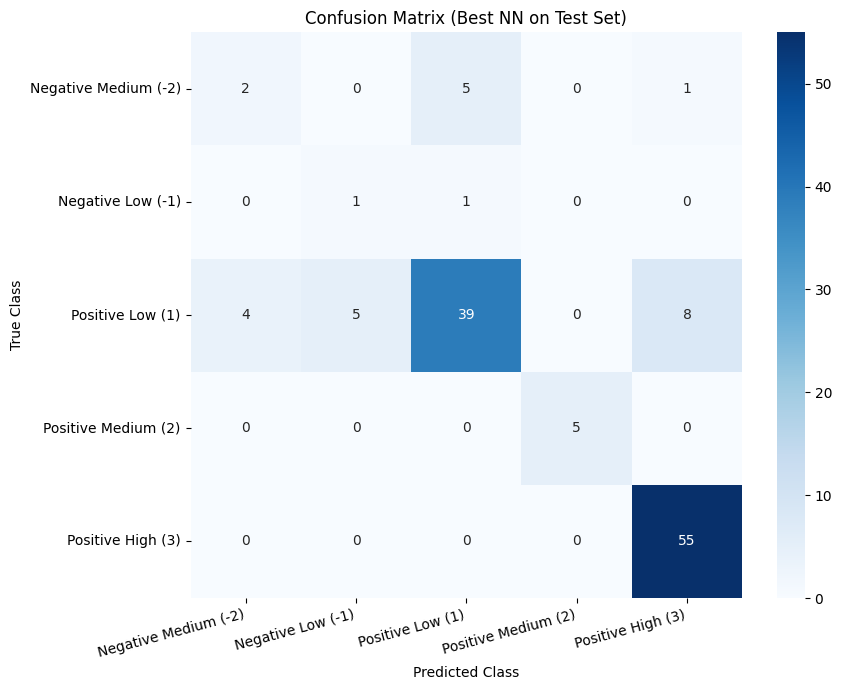

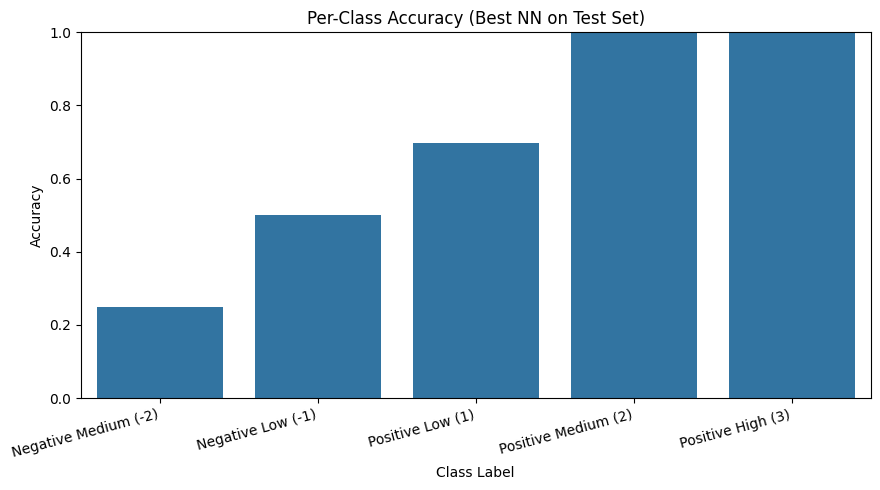

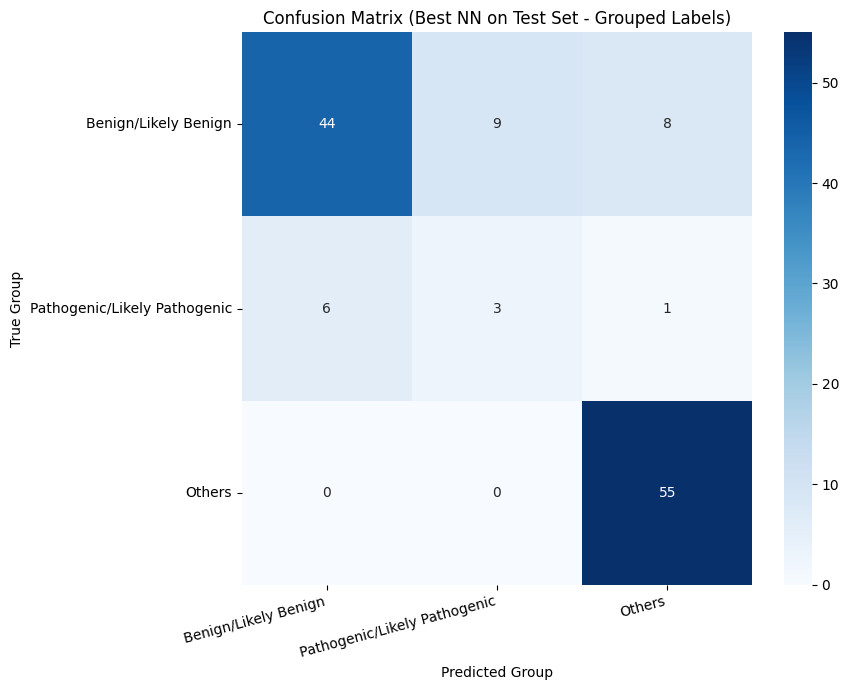

In [46]:
# Import necessary libraries for hyperparameter tuning and advanced techniques
from sklearn.model_selection import ParameterGrid
from torch.utils.data import WeightedRandomSampler
import torch.nn.functional as F # For Focal Loss
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# Source: https://github.com/pytorch/pytorch/issues/7455#issuecomment-513062631
# (Adjusted slightly for clarity and stability)
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean', weight=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha # Can be a float or a tensor of shape [num_classes]
        self.gamma = gamma
        self.reduction = reduction
        self.weight = weight # Class weights (optional)

    def forward(self, inputs, targets):
        # inputs: [N, C], targets: [N]
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.weight) # Calculate CE loss per element
        pt = torch.exp(-ce_loss) # Probability of the true class

        # Handle alpha: If alpha is a tensor, select the weight for the target class
        if isinstance(self.alpha, torch.Tensor):
             # Ensure alpha tensor is on the same device as inputs
             alpha_t = self.alpha.gather(0, targets.data.view(-1)).to(inputs.device) # [N]
        elif isinstance(self.alpha, (float, int)):
             alpha_t = self.alpha # Use the same alpha for all classes if it's a float
        else:
             raise TypeError("alpha must be a float or a Tensor")


        focal_loss = alpha_t * (1 - pt)**self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else: # 'none'
            return focal_loss


if X_nn.shape[0] > 0: # Proceed only if embeddings were generated
    # --- 2. Prepare Data for PyTorch ---
    print("\nPreparing data for PyTorch...")

    # Filter out samples with label 0
    non_zero_indices = y_nn_original != 0
    X_nn_filtered = X_nn[non_zero_indices]
    y_nn_filtered = y_nn_original[non_zero_indices]

    print(f"Filtered out {len(X_nn) - len(X_nn_filtered)} samples with label 0.")
    print(f"Remaining samples: {len(X_nn_filtered)}")

    # Now encode the labels (excluding 0)
    le = LabelEncoder()
    y_nn_encoded = le.fit_transform(y_nn_filtered)
    num_classes = len(le.classes_)

    # Define meaningful names for the classes
    class_names = {
        -3: 'Negative High (-3)',
        -2: 'Negative Medium (-2)',
        -1: 'Negative Low (-1)',
        1: 'Positive Low (1)',
        2: 'Positive Medium (2)',
        3: 'Positive High (3)'
    }
    # Ensure target names are ordered correctly based on LabelEncoder's classes_
    target_names = [class_names[i] for i in le.classes_]

    print(f"Original labels encoded to {num_classes} classes.")
    print(f"Labels (encoded): {np.unique(y_nn_encoded)}")
    print("Class mapping (Encoded Value: Class Name):")
    for i, name in enumerate(target_names):
        print(f"  {i}: {name}")

    # Split data into training, validation, and testing sets
    X_train_val, X_test_nn, y_train_val, y_test_nn = train_test_split(
        X_nn_filtered, y_nn_encoded, test_size=0.15, random_state=42, stratify=y_nn_encoded
    )
    X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
        X_train_val, y_train_val, test_size=0.1765, random_state=42, stratify=y_train_val # 0.15 / (1-0.15) approx 0.1765
    )

    print(f"\nData split into training ({X_train_nn.shape[0]} samples), validation ({X_val_nn.shape[0]} samples), and testing ({X_test_nn.shape[0]} samples).")

    # Convert NumPy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_nn, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_nn, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val_nn, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_nn, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test_nn, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_nn, dtype=torch.long)

    # --- Address Class Imbalance with Weighted Sampling ---
    print("\nAddressing class imbalance...")
    class_counts_train = np.bincount(y_train_nn, minlength=num_classes)
    print(f"Training set class counts (encoded): {class_counts_train}")
    for i, count in enumerate(class_counts_train):
         # Ensure index i exists in target_names before accessing
         if i < len(target_names):
             print(f"  Class {i} ({target_names[i]}): {count} samples")
         else:
             print(f"  Class {i} (Unknown Name): {count} samples")


    if np.any(class_counts_train == 0):
        print("Warning: Some classes have zero samples in the training set. Weighted sampling might not work correctly.")
        use_weighted_sampler = False
        sampler = None # Ensure sampler is None
    else:
        class_weights_sample = 1. / torch.tensor(class_counts_train, dtype=torch.float32)
        # Ensure y_train_nn contains valid indices for class_weights_sample
        if y_train_nn.max() >= len(class_weights_sample):
             raise IndexError(f"Max label index {y_train_nn.max()} is out of bounds for class weights tensor with size {len(class_weights_sample)}")
        sample_weights = class_weights_sample[y_train_nn] # Assign weight to each sample
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
        print("Using WeightedRandomSampler for training data.")
        use_weighted_sampler = True

    # Create TensorDatasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Create DataLoaders
    batch_size = 32 # Keep batch size reasonable, can be tuned

    # Use sampler only for the training loader
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=sampler if use_weighted_sampler else None,
        shuffle=not use_weighted_sampler # Shuffle is False if sampler is used
    )
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


    # --- 3. Define the Neural Network ---
    # Model definition remains the same structure, but output_dim is now num_classes
    print("\nDefining the Neural Network...")

    class ResidualBlock(nn.Module):
        """A residual block with two linear layers, BatchNorm, ReLU, and Dropout."""
        def __init__(self, in_dim, out_dim, dropout_rate):
            super(ResidualBlock, self).__init__()
            self.block = nn.Sequential(
                nn.Linear(in_dim, out_dim),
                nn.BatchNorm1d(out_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(out_dim, out_dim),
                nn.BatchNorm1d(out_dim),
            )
            self.shortcut = nn.Sequential()
            if in_dim != out_dim:
                self.shortcut = nn.Sequential(
                    nn.Linear(in_dim, out_dim),
                    nn.BatchNorm1d(out_dim)
                )
            self.final_relu = nn.ReLU()
            self.final_dropout = nn.Dropout(dropout_rate)

        def forward(self, x):
            out = self.block(x)
            shortcut_out = self.shortcut(x)
            out += shortcut_out
            out = self.final_relu(out)
            out = self.final_dropout(out)
            return out

    class DNABERTClassifier(nn.Module):
        """Classifier using DNA-BERT embeddings with residual blocks."""
        # Adjusted output_dim to be passed dynamically
        def __init__(self, input_dim, hidden_dims=[512, 256, 128], output_dim=6, dropout_rate=0.4): # Default output_dim is now 6
            super(DNABERTClassifier, self).__init__()
            # Ensure hidden_dims is not empty
            if not hidden_dims:
                 raise ValueError("hidden_dims list cannot be empty")

            self.input_layer = nn.Sequential(
                nn.Linear(input_dim, hidden_dims[0]),
                nn.BatchNorm1d(hidden_dims[0]),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            )
            self.hidden_layers = nn.ModuleList()
            current_dim = hidden_dims[0]
            # Create residual blocks for layers beyond the first
            if len(hidden_dims) > 1:
                 for hidden_dim in hidden_dims[1:]:
                     self.hidden_layers.append(
                         ResidualBlock(current_dim, hidden_dim, dropout_rate)
                     )
                     current_dim = hidden_dim
            # The output layer takes input from the last hidden dimension (or the first if only one)
            self.output_layer = nn.Linear(current_dim, output_dim)


        def forward(self, x):
            out = self.input_layer(x)
            for layer in self.hidden_layers:
                out = layer(out)
            out = self.output_layer(out)
            return out

    # --- 4. Hyperparameter Tuning Setup ---
    # Define parameter grid with a variety of settings (120 combinations)
    param_grid = {
        'lr': [0.001, 0.0005, 0.0001],
        'weight_decay': [0.01, 0.05, 0.1, 0.2],
        'dropout_rate': [0.3, 0.5],
        'loss_fn': ['CrossEntropyLoss', 'FocalLoss'],
        'hidden_dims': [
            [128],                  # Single layer
            [256],                  # Single layer
            [512],                  # Single layer
            [128, 64],              # Two layers
            [256, 128],             # Two layers
            [512, 256],             # Two layers
            [256, 128, 64],         # Three layers
            [512, 256, 128],        # Three layers
            [1024, 512, 256],       # Three layers
            [512, 256, 128, 64]     # Four layers
        ],
        'optimizer': ['Adam', 'AdamW']
    }

    # Calculate total combinations
    total_combinations = 1
    for param_values in param_grid.values():
        total_combinations *= len(param_values)
    
    print(f"Total hyperparameter combinations: {total_combinations}")
    
    # Limit to 120 combinations if needed
    if total_combinations > 120:
        print(f"Limiting to 120 combinations out of {total_combinations} possible combinations")
        # You could implement a strategy to select a subset of combinations here
        # For simplicity, we'll just take the first 120 combinations
        grid = list(ParameterGrid(param_grid))[:120]
    else:
        grid = list(ParameterGrid(param_grid))
    
    print(f"Will evaluate {len(grid)} hyperparameter combinations")

    best_val_acc = 0.0
    best_params = None
    best_model_state_grid = None
    results = []

    print(f"\nStarting Grid Search with {len(grid)} combinations...")

    # Check for GPU availability once
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    input_dim = X_train_nn.shape[1]

    # --- Loop through Hyperparameters ---
    for i, params in enumerate(grid):
        print(f"\n--- Combination {i+1}/{len(grid)} ---")
        print(f"Parameters: {params}")

        # --- Instantiate Model with current params ---
        current_dropout = params['dropout_rate']
        current_hidden_dims = params['hidden_dims'] # Get hidden dims from grid
        # Pass the correct number of output classes and current hidden_dims
        nn_model = DNABERTClassifier(input_dim, current_hidden_dims, num_classes, dropout_rate=current_dropout)
        nn_model.to(device)
        # print(nn_model) # Optional: print model summary for each config

        # --- Define Loss Function ---
        # Calculate class weights for loss function based on training data
        if np.any(class_counts_train == 0):
             class_weights_loss = None
             print("Warning: Cannot calculate class weights for loss due to missing classes in train set.")
        else:
             # Ensure tensor is created correctly even if some counts are zero (though handled above)
             class_weights_tensor = 1. / torch.tensor(class_counts_train.astype(np.float32) + 1e-9) # Add epsilon for stability
             class_weights_loss = class_weights_tensor.to(device)
             print(f"Calculated class weights for loss function: {class_weights_loss.cpu().numpy()}")


        if params['loss_fn'] == 'FocalLoss':
             # You might want to tune alpha and gamma for Focal Loss as well
             # Alpha can also be the class_weights_tensor
             criterion = FocalLoss(alpha=class_weights_loss if class_weights_loss is not None else 1.0, gamma=2.0, reduction='mean')
             print("Using FocalLoss.")
        else: # Default to CrossEntropyLoss
             criterion = nn.CrossEntropyLoss(weight=class_weights_loss)
             print("Using CrossEntropyLoss (with weights if available).")


        # --- Define Optimizer ---
        optimizer = optim.AdamW(nn_model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
        print("Using Optimizer: AdamW")

        # --- Define Scheduler ---
        # Increased patience for scheduler as well
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=15, verbose=False) # Quieter scheduler during grid search


        # --- Training Loop (for current hyperparameter set) ---
        num_epochs = 500 # Max epochs per combination (Increased as requested)
        train_losses_hist = []
        train_accuracies_hist = []
        val_accuracies_hist = []
        val_losses_hist = []
        current_best_val_acc = 0.0 # Best validation accuracy for *this* combination
        best_model_state_current = None
        patience_early_stopping = 200 # Increased patience for early stopping to aim for 200 epochs
        epochs_no_improve = 0

        print(f"Training with lr={params['lr']}, wd={params['weight_decay']}, dropout={current_dropout}, loss={params['loss_fn']}, hidden_dims={current_hidden_dims}...")

        for epoch in range(num_epochs):
            nn_model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            # Simplified progress bar for grid search
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Train", leave=False)
            for inputs, labels in progress_bar: # Use train_loader directly
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = nn_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                # torch.nn.utils.clip_grad_norm_(nn_model.parameters(), max_norm=1.0) # Optional
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

                # Update progress bar description
                progress_bar.set_postfix({'loss': loss.item()})


            # Avoid division by zero if dataset is empty
            epoch_train_loss = running_loss / len(train_loader.dataset) if len(train_loader.dataset) > 0 else 0.0
            epoch_train_acc = correct_train / total_train if total_train > 0 else 0.0
            train_losses_hist.append(epoch_train_loss)
            train_accuracies_hist.append(epoch_train_acc)

            # --- Validation Step ---
            nn_model.eval()
            correct_val = 0
            total_val = 0
            running_val_loss = 0.0
            with torch.no_grad():
                for inputs_val, labels_val in val_loader:
                    inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
                    outputs_val = nn_model(inputs_val)
                    loss_val = criterion(outputs_val, labels_val) # Use same criterion
                    running_val_loss += loss_val.item() * inputs_val.size(0)
                    _, predicted_val = torch.max(outputs_val.data, 1)
                    total_val += labels_val.size(0)
                    correct_val += (predicted_val == labels_val).sum().item()

            epoch_val_loss = running_val_loss / len(val_loader.dataset) if len(val_loader.dataset) > 0 else 0.0
            epoch_val_acc = correct_val / total_val if total_val > 0 else 0.0
            val_losses_hist.append(epoch_val_loss)
            val_accuracies_hist.append(epoch_val_acc)

            # Print progress every few epochs during grid search
            if (epoch + 1) % 10 == 0 or epoch == 0:
                 print(f"  Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
                       f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

            # Step the scheduler based on validation accuracy
            scheduler.step(epoch_val_acc)

            # Early Stopping Check & Save Best Model for this combination
            if epoch_val_acc > current_best_val_acc:
                current_best_val_acc = epoch_val_acc
                epochs_no_improve = 0
                best_model_state_current = nn_model.state_dict() # Save the best state for this run
                # print(f"    -> New best val acc for this combo: {current_best_val_acc:.4f}") # Verbose
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience_early_stopping:
                print(f"  Early stopping triggered for this combination after {epoch + 1} epochs.")
                break
        # --- End Training Loop for Combination ---

        print(f"Combination {i+1} finished. Best Validation Accuracy: {current_best_val_acc:.4f}")
        # Store the full parameters including hidden_dims
        results.append({'params': params, 'best_val_acc': current_best_val_acc, 'epochs': epoch + 1})

        # --- Update Overall Best Model (based on validation accuracy) ---
        if current_best_val_acc > best_val_acc:
            print(f"!!! Found new overall best validation accuracy: {current_best_val_acc:.4f} !!!")
            best_val_acc = current_best_val_acc
            best_params = params # Store the entire best parameter set
            best_model_state_grid = best_model_state_current # Keep the state dict of the best model

    # --- End Hyperparameter Search ---

    print("\n--- Training Complete ---")
    # Sort results by validation accuracy
    results.sort(key=lambda x: x['best_val_acc'], reverse=True)
    print("Top 10 Training Results (based on Validation Accuracy):")
    for i, res in enumerate(results[:10]): # Print top 10 results
        # Ensure all parameters including hidden_dims are printed
        print(f"  {i+1}. Params: {res['params']}, Val Acc: {res['best_val_acc']:.4f}, Epochs: {res['epochs']}")

    if best_params is None:
        print("\nError: No best model found. Training might have failed or produced no valid results.")
        # Handle error appropriately, maybe raise an exception or exit
        raise SystemExit("Stopping execution: Training failed.")
    else:
        print(f"\nBest hyperparameters: {best_params}")
        print(f"Best validation accuracy achieved: {best_val_acc:.4f}")

        # --- Load the Best Model Found During Training ---
        print("\nLoading the best model configuration...")
        best_dropout = best_params['dropout_rate']
        best_hidden_dims = best_params['hidden_dims'] # Get best hidden dims from best_params
        # Instantiate with correct output_dim (num_classes) and best hidden_dims
        nn_model_best = DNABERTClassifier(input_dim, best_hidden_dims, num_classes, dropout_rate=best_dropout)
        if best_model_state_grid:
             nn_model_best.load_state_dict(best_model_state_grid)
             print("Loaded best model state from training.")
        else:
             print("Warning: Could not load best model state. Using initialized model with best params.")
             # This might happen if training failed for the best params or state wasn't saved correctly.
             # Consider retraining the best model from scratch here if needed.

        nn_model_best.to(device)


    # --- 5. (Optional) Plot Training Curves for the Best Model ---
    # Note: The training curves plotted here would be from the *last* run in the grid search,
    # not necessarily the *best* run unless you store and retrieve those specific histories.
    # For simplicity, we skip plotting the curves from the grid search process itself.
    # If needed, you'd store train_losses_hist, etc., associated with best_params.
    print("\nSkipping training curve plots for grid search simplicity.")


    # --- 6. Evaluate the BEST Neural Network on the **Test Set** ---
    print("\nEvaluating the Best Neural Network (from training) on the Test Set...")

    nn_model_best.eval() # Set the best model to evaluation mode
    y_pred_list = []
    y_true_list = []
    test_probs_list = [] # Store probabilities for more detailed analysis

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating Best Model"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = nn_model_best(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            y_pred_list.extend(predicted.cpu().numpy())
            y_true_list.extend(labels.cpu().numpy())
            test_probs_list.extend(probabilities.cpu().numpy())

    y_pred_nn = np.array(y_pred_list)
    y_test_nn_eval = np.array(y_true_list)
    y_test_probs = np.array(test_probs_list)

    # --- Detailed Evaluation ---
    accuracy_nn = accuracy_score(y_test_nn_eval, y_pred_nn)
    print(f"\nTest Accuracy (Best NN): {accuracy_nn:.4f}")

    print("\nClassification Report (Best NN):")
    print(classification_report(y_test_nn_eval, y_pred_nn, labels=np.arange(num_classes), target_names=target_names, zero_division=0))

    print("\nConfusion Matrix (Best NN):")
    cm = confusion_matrix(y_test_nn_eval, y_pred_nn, labels=np.arange(num_classes))

    # Calculate per-class accuracy from confusion matrix
    # Add epsilon to avoid division by zero if a class has no samples in the test set
    cm_sum_axis1 = cm.sum(axis=1)
    per_class_acc = np.divide(cm.diagonal(), cm_sum_axis1, out=np.zeros_like(cm.diagonal(), dtype=float), where=cm_sum_axis1!=0)

    print("\nPer-Class Accuracy (Best NN):")
    for i, class_name in enumerate(target_names):
        # Handle cases where a class might have 0 true samples in the test set (division by zero)
        if cm.sum(axis=1)[i] > 0:
             print(f"  Class {class_name}: {per_class_acc[i]:.4f}")
        else:
             print(f"  Class {class_name}: N/A (no true samples in test set)")

    # --- Group Evaluation (Secondary Evaluation) ---
    print("\n--- Group Evaluation (Secondary Evaluation) ---")
    
    # Define the grouping mapping
    # Group 1: Benign or Likely Benign (classes 1 and 2)
    # Group 2: Pathogenic or Likely Pathogenic (classes -1 and -2)
    
    # Get the original class indices from LabelEncoder
    original_class_indices = {}
    for i, original_class in enumerate(le.classes_):
        original_class_indices[original_class] = i
    
    # Create group mapping
    group_mapping = {}
    for encoded_idx, original_class in enumerate(le.classes_):
        if original_class in [1, 2]:  # Positive Low (1) and Positive Medium (2)
            group_mapping[encoded_idx] = 0  # Group 0: Benign or Likely Benign
        elif original_class in [-1, -2]:  # Negative Low (-1) and Negative Medium (-2)
            group_mapping[encoded_idx] = 1  # Group 1: Pathogenic or Likely Pathogenic
        else:
            group_mapping[encoded_idx] = 2  # Group 2: Others (like -3 and 3)
    
    # Map predictions and true labels to groups
    y_true_grouped = np.array([group_mapping[label] for label in y_test_nn_eval])
    y_pred_grouped = np.array([group_mapping[pred] for pred in y_pred_nn])
    
    # Define group names
    group_names = ['Benign/Likely Benign', 'Pathogenic/Likely Pathogenic', 'Others']
    
    # Filter to only include groups that exist in the data
    unique_groups = np.unique(np.concatenate((y_true_grouped, y_pred_grouped)))
    target_names_grouped = [group_names[g] for g in unique_groups]
    
    # Calculate metrics for grouped evaluation
    accuracy_grouped = accuracy_score(y_true_grouped, y_pred_grouped)
    print(f"\nGrouped Test Accuracy: {accuracy_grouped:.4f}")
    
    print("\nGrouped Classification Report:")
    print(classification_report(y_true_grouped, y_pred_grouped, 
                               labels=unique_groups, 
                               target_names=target_names_grouped, 
                               zero_division=0))
    
    # Confusion matrix for grouped evaluation
    cm_grouped = confusion_matrix(y_true_grouped, y_pred_grouped, labels=unique_groups)
    
    # Calculate per-group accuracy
    cm_grouped_sum_axis1 = cm_grouped.sum(axis=1)
    per_group_acc = np.divide(cm_grouped.diagonal(), cm_grouped_sum_axis1, 
                             out=np.zeros_like(cm_grouped.diagonal(), dtype=float), 
                             where=cm_grouped_sum_axis1!=0)
    
    print("\nPer-Group Accuracy:")
    for i, group_name in enumerate(target_names_grouped):
        if cm_grouped_sum_axis1[i] > 0:
            print(f"  Group {group_name}: {per_group_acc[i]:.4f}")
        else:
            print(f"  Group {group_name}: N/A (no true samples in test set)")

    # Display confusion matrix with labels using seaborn
    try:
        import seaborn as sns
        plt.figure(figsize=(9, 7)) # Adjusted size for potentially more classes
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=target_names, yticklabels=target_names)
        plt.xlabel('Predicted Class')
        plt.ylabel('True Class')
        plt.title('Confusion Matrix (Best NN on Test Set)')
        plt.xticks(rotation=15, ha='right') # Improve label readability
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        # Plot per-class accuracy
        plt.figure(figsize=(9, 5)) # Adjusted size
        # Ensure per_class_acc has the correct length matching target_names
        if len(target_names) == len(per_class_acc):
             sns.barplot(x=target_names, y=per_class_acc)
             plt.xlabel('Class Label')
             plt.ylabel('Accuracy')
             plt.title('Per-Class Accuracy (Best NN on Test Set)')
             plt.ylim(0, 1) # Accuracy is between 0 and 1
             plt.xticks(rotation=15, ha='right') # Improve label readability
             plt.tight_layout()
             plt.show()
        else:
             print(f"Warning: Mismatch between number of target names ({len(target_names)}) and per-class accuracy values ({len(per_class_acc)}). Skipping bar plot.")

        # Plot grouped confusion matrix
        plt.figure(figsize=(9, 7)) # Adjusted size for potentially more classes
        sns.heatmap(cm_grouped, annot=True, fmt='d', cmap='Blues',
                    xticklabels=target_names_grouped, yticklabels=target_names_grouped)
        plt.xlabel('Predicted Group')
        plt.ylabel('True Group')
        plt.title('Confusion Matrix (Best NN on Test Set - Grouped Labels)')
        plt.xticks(rotation=15, ha='right') # Improve label readability
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        # Plot per-class accuracy
    except ImportError:
        print("Seaborn not installed. Skipping heatmap and bar plot visualization.")
        print("Confusion Matrix (row=True, col=Predicted):")
        try:
            import pandas as pd
            print(pd.DataFrame(cm, index=target_names, columns=target_names))
        except ImportError:
             print(cm)

else:
    print("\nNo combined embeddings were generated. Cannot proceed with NN training and evaluation.")
    # raise SystemExit("Stopping execution: No embeddings generated.") # Or similar


### Classifier training Using Hyperparmaters and DNA-BERT Embeddings Only

In [ ]:
# Import necessary libraries for hyperparameter tuning and advanced techniques
from sklearn.model_selection import ParameterGrid
from torch.utils.data import WeightedRandomSampler
import torch.nn.functional as F # For Focal Loss
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# --- Focal Loss Implementation (Optional, good for class imbalance) ---
# Source: https://github.com/pytorch/pytorch/issues/7455#issuecomment-513062631
# (Adjusted slightly for clarity and stability)
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean', weight=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha # Can be a float or a tensor of shape [num_classes]
        self.gamma = gamma
        self.reduction = reduction
        self.weight = weight # Class weights (optional)

    def forward(self, inputs, targets):
        # inputs: [N, C], targets: [N]
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.weight) # Calculate CE loss per element
        pt = torch.exp(-ce_loss) # Probability of the true class

        # Handle alpha: If alpha is a tensor, select the weight for the target class
        if isinstance(self.alpha, torch.Tensor):
             # Ensure alpha tensor is on the same device as inputs
             alpha_t = self.alpha.gather(0, targets.data.view(-1)).to(inputs.device) # [N]
        elif isinstance(self.alpha, (float, int)):
             alpha_t = self.alpha # Use the same alpha for all classes if it's a float
        else:
             raise TypeError("alpha must be a float or a Tensor")


        focal_loss = alpha_t * (1 - pt)**self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else: # 'none'
            return focal_loss


if X_nn.shape[0] > 0: # Proceed only if embeddings were generated
    # --- 2. Prepare Data for PyTorch ---
    print("\nPreparing data for PyTorch...")

    # Filter out samples with label 0
    non_zero_indices = y_nn_original != 0
    X_nn_filtered = X_nn[non_zero_indices]
    y_nn_filtered = y_nn_original[non_zero_indices]

    print(f"Filtered out {len(X_nn) - len(X_nn_filtered)} samples with label 0.")
    print(f"Remaining samples: {len(X_nn_filtered)}")

    # Now encode the labels (excluding 0)
    le = LabelEncoder()
    y_nn_encoded = le.fit_transform(y_nn_filtered)
    num_classes = len(le.classes_)

    # Define meaningful names for the classes
    class_names = {
        -3: 'Negative High (-3)',
        -2: 'Negative Medium (-2)',
        -1: 'Negative Low (-1)',
        1: 'Positive Low (1)',
        2: 'Positive Medium (2)',
        3: 'Positive High (3)'
    }
    # Ensure target names are ordered correctly based on LabelEncoder's classes_
    target_names = [class_names[i] for i in le.classes_]

    print(f"Original labels encoded to {num_classes} classes.")
    print(f"Labels (encoded): {np.unique(y_nn_encoded)}")
    print("Class mapping (Encoded Value: Class Name):")
    for i, name in enumerate(target_names):
        print(f"  {i}: {name}")

    # Split data into training, validation, and testing sets
    X_train_val, X_test_nn, y_train_val, y_test_nn = train_test_split(
        X_nn_filtered, y_nn_encoded, test_size=0.15, random_state=42, stratify=y_nn_encoded
    )
    X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
        X_train_val, y_train_val, test_size=0.1765, random_state=42, stratify=y_train_val # 0.15 / (1-0.15) approx 0.1765
    )

    print(f"\nData split into training ({X_train_nn.shape[0]} samples), validation ({X_val_nn.shape[0]} samples), and testing ({X_test_nn.shape[0]} samples).")

    # Convert NumPy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_nn, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_nn, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val_nn, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_nn, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test_nn, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_nn, dtype=torch.long)

    # --- Address Class Imbalance with Weighted Sampling ---
    print("\nAddressing class imbalance...")
    class_counts_train = np.bincount(y_train_nn, minlength=num_classes)
    print(f"Training set class counts (encoded): {class_counts_train}")
    for i, count in enumerate(class_counts_train):
         # Ensure index i exists in target_names before accessing
         if i < len(target_names):
             print(f"  Class {i} ({target_names[i]}): {count} samples")
         else:
             print(f"  Class {i} (Unknown Name): {count} samples")


    if np.any(class_counts_train == 0):
        print("Warning: Some classes have zero samples in the training set. Weighted sampling might not work correctly.")
        use_weighted_sampler = False
        sampler = None # Ensure sampler is None
    else:
        class_weights_sample = 1. / torch.tensor(class_counts_train, dtype=torch.float32)
        # Ensure y_train_nn contains valid indices for class_weights_sample
        if y_train_nn.max() >= len(class_weights_sample):
             raise IndexError(f"Max label index {y_train_nn.max()} is out of bounds for class weights tensor with size {len(class_weights_sample)}")
        sample_weights = class_weights_sample[y_train_nn] # Assign weight to each sample
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
        print("Using WeightedRandomSampler for training data.")
        use_weighted_sampler = True

    # Create TensorDatasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Create DataLoaders
    batch_size = 32 # Keep batch size reasonable, can be tuned

    # Use sampler only for the training loader
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=sampler if use_weighted_sampler else None,
        shuffle=not use_weighted_sampler # Shuffle is False if sampler is used
    )
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


    # --- 3. Define the Neural Network ---
    # Model definition remains the same structure, but output_dim is now num_classes
    print("\nDefining the Neural Network...")

    class ResidualBlock(nn.Module):
        """A residual block with two linear layers, BatchNorm, ReLU, and Dropout."""
        def __init__(self, in_dim, out_dim, dropout_rate):
            super(ResidualBlock, self).__init__()
            self.block = nn.Sequential(
                nn.Linear(in_dim, out_dim),
                nn.BatchNorm1d(out_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(out_dim, out_dim),
                nn.BatchNorm1d(out_dim),
            )
            self.shortcut = nn.Sequential()
            if in_dim != out_dim:
                self.shortcut = nn.Sequential(
                    nn.Linear(in_dim, out_dim),
                    nn.BatchNorm1d(out_dim)
                )
            self.final_relu = nn.ReLU()
            self.final_dropout = nn.Dropout(dropout_rate)

        def forward(self, x):
            out = self.block(x)
            shortcut_out = self.shortcut(x)
            out += shortcut_out
            out = self.final_relu(out)
            out = self.final_dropout(out)
            return out

    class DNABERTClassifier(nn.Module):
        """Classifier using DNA-BERT embeddings with residual blocks."""
        # Adjusted output_dim to be passed dynamically
        def __init__(self, input_dim, hidden_dims=[512, 256, 128], output_dim=6, dropout_rate=0.4): # Default output_dim is now 6
            super(DNABERTClassifier, self).__init__()
            # Ensure hidden_dims is not empty
            if not hidden_dims:
                 raise ValueError("hidden_dims list cannot be empty")

            self.input_layer = nn.Sequential(
                nn.Linear(input_dim, hidden_dims[0]),
                nn.BatchNorm1d(hidden_dims[0]),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            )
            self.hidden_layers = nn.ModuleList()
            current_dim = hidden_dims[0]
            # Create residual blocks for layers beyond the first
            if len(hidden_dims) > 1:
                 for hidden_dim in hidden_dims[1:]:
                     self.hidden_layers.append(
                         ResidualBlock(current_dim, hidden_dim, dropout_rate)
                     )
                     current_dim = hidden_dim
            # The output layer takes input from the last hidden dimension (or the first if only one)
            self.output_layer = nn.Linear(current_dim, output_dim)


        def forward(self, x):
            out = self.input_layer(x)
            for layer in self.hidden_layers:
                out = layer(out)
            out = self.output_layer(out)
            return out

    # --- 4. Hyperparameter Tuning Setup ---
    # Define parameter grid with the specific settings requested
    param_grid = {
        'lr': [0.001],
        'weight_decay': [0.2],
        'dropout_rate': [0.3],
        'loss_fn': ['CrossEntropyLoss'],
        'hidden_dims': [
            [256]                  # Single layer with 256 neurons
        ],
        'optimizer': ['AdamW']
    }


    grid = ParameterGrid(param_grid)
    best_val_acc = 0.0
    best_params = None
    best_model_state_grid = None
    results = []

    print(f"\nStarting Training with Specific Hyperparameters (Grid Size: {len(grid)} combination)...")

    # Check for GPU availability once
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    input_dim = X_train_nn.shape[1]

    # --- Loop through Hyperparameters (only one combination now) ---
    for i, params in enumerate(grid):
        print(f"\n--- Combination {i+1}/{len(grid)} ---")
        print(f"Parameters: {params}")

        # --- Instantiate Model with current params ---
        current_dropout = params['dropout_rate']
        current_hidden_dims = params['hidden_dims'] # Get hidden dims from grid
        # Pass the correct number of output classes and current hidden_dims
        nn_model = DNABERTClassifier(input_dim, current_hidden_dims, num_classes, dropout_rate=current_dropout)
        nn_model.to(device)
        # print(nn_model) # Optional: print model summary for each config

        # --- Define Loss Function ---
        # Calculate class weights for loss function based on training data
        if np.any(class_counts_train == 0):
             class_weights_loss = None
             print("Warning: Cannot calculate class weights for loss due to missing classes in train set.")
        else:
             # Ensure tensor is created correctly even if some counts are zero (though handled above)
             class_weights_tensor = 1. / torch.tensor(class_counts_train.astype(np.float32) + 1e-9) # Add epsilon for stability
             class_weights_loss = class_weights_tensor.to(device)
             print(f"Calculated class weights for loss function: {class_weights_loss.cpu().numpy()}")


        if params['loss_fn'] == 'FocalLoss':
             # You might want to tune alpha and gamma for Focal Loss as well
             # Alpha can also be the class_weights_tensor
             criterion = FocalLoss(alpha=class_weights_loss if class_weights_loss is not None else 1.0, gamma=2.0, reduction='mean')
             print("Using FocalLoss.")
        else: # Default to CrossEntropyLoss
             criterion = nn.CrossEntropyLoss(weight=class_weights_loss)
             print("Using CrossEntropyLoss (with weights if available).")


        # --- Define Optimizer ---
        optimizer_type = params.get('optimizer', 'AdamW') # Use default if not in grid
        if optimizer_type == 'Adam':
            optimizer = optim.Adam(nn_model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
        else: # Default to AdamW
            optimizer = optim.AdamW(nn_model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
        print(f"Using Optimizer: {optimizer_type}")

        # --- Define Scheduler ---
        # Increased patience for scheduler as well
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=15, verbose=False) # Quieter scheduler during grid search


        # --- Training Loop (for current hyperparameter set) ---
        num_epochs = 500 # Max epochs per combination (Increased as requested)
        train_losses_hist = []
        train_accuracies_hist = []
        val_accuracies_hist = []
        val_losses_hist = []
        current_best_val_acc = 0.0 # Best validation accuracy for *this* combination
        best_model_state_current = None
        patience_early_stopping = 200 # Increased patience for early stopping to aim for 200 epochs
        epochs_no_improve = 0

        print(f"Training with lr={params['lr']}, wd={params['weight_decay']}, dropout={current_dropout}, loss={params['loss_fn']}, hidden_dims={current_hidden_dims}...")

        for epoch in range(num_epochs):
            nn_model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            # Simplified progress bar for grid search
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Train", leave=False)
            for inputs, labels in progress_bar: # Use train_loader directly
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = nn_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                # torch.nn.utils.clip_grad_norm_(nn_model.parameters(), max_norm=1.0) # Optional
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

                # Update progress bar description
                progress_bar.set_postfix({'loss': loss.item()})


            # Avoid division by zero if dataset is empty
            epoch_train_loss = running_loss / len(train_loader.dataset) if len(train_loader.dataset) > 0 else 0.0
            epoch_train_acc = correct_train / total_train if total_train > 0 else 0.0
            train_losses_hist.append(epoch_train_loss)
            train_accuracies_hist.append(epoch_train_acc)

            # --- Validation Step ---
            nn_model.eval()
            correct_val = 0
            total_val = 0
            running_val_loss = 0.0
            with torch.no_grad():
                for inputs_val, labels_val in val_loader:
                    inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
                    outputs_val = nn_model(inputs_val)
                    loss_val = criterion(outputs_val, labels_val) # Use same criterion
                    running_val_loss += loss_val.item() * inputs_val.size(0)
                    _, predicted_val = torch.max(outputs_val.data, 1)
                    total_val += labels_val.size(0)
                    correct_val += (predicted_val == labels_val).sum().item()

            epoch_val_loss = running_val_loss / len(val_loader.dataset) if len(val_loader.dataset) > 0 else 0.0
            epoch_val_acc = correct_val / total_val if total_val > 0 else 0.0
            val_losses_hist.append(epoch_val_loss)
            val_accuracies_hist.append(epoch_val_acc)

            # Print progress every few epochs during grid search
            if (epoch + 1) % 10 == 0 or epoch == 0:
                 print(f"  Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
                       f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

            # Step the scheduler based on validation accuracy
            scheduler.step(epoch_val_acc)

            # Early Stopping Check & Save Best Model for this combination
            if epoch_val_acc > current_best_val_acc:
                current_best_val_acc = epoch_val_acc
                epochs_no_improve = 0
                best_model_state_current = nn_model.state_dict() # Save the best state for this run
                # print(f"    -> New best val acc for this combo: {current_best_val_acc:.4f}") # Verbose
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience_early_stopping:
                print(f"  Early stopping triggered for this combination after {epoch + 1} epochs.")
                break
        # --- End Training Loop for Combination ---

        print(f"Combination {i+1} finished. Best Validation Accuracy: {current_best_val_acc:.4f}")
        # Store the full parameters including hidden_dims
        results.append({'params': params, 'best_val_acc': current_best_val_acc, 'epochs': epoch + 1})

        # --- Update Overall Best Model (based on validation accuracy) ---
        # Since there's only one combination, this will just store the result of this run
        if current_best_val_acc > best_val_acc:
            print(f"!!! Found new overall best validation accuracy: {current_best_val_acc:.4f} !!!")
            best_val_acc = current_best_val_acc
            best_params = params # Store the entire best parameter set
            best_model_state_grid = best_model_state_current # Keep the state dict of the best model

    # --- End Hyperparameter Search ---

    print("\n--- Training Complete ---")
    # Sort results by validation accuracy (only one result now)
    results.sort(key=lambda x: x['best_val_acc'], reverse=True)
    print("Training Results (based on Validation Accuracy):")
    for res in results: # Print the result
        # Ensure all parameters including hidden_dims are printed
        print(f"  Params: {res['params']}, Val Acc: {res['best_val_acc']:.4f}, Epochs: {res['epochs']}")

    if best_params is None:
        print("\nError: No best model found. Training might have failed or produced no valid results.")
        # Handle error appropriately, maybe raise an exception or exit
        raise SystemExit("Stopping execution: Training failed.")
    else:
        print(f"\nBest hyperparameters: {best_params}")
        print(f"Best validation accuracy achieved: {best_val_acc:.4f}")

        # --- Load the Best Model Found During Training ---
        print("\nLoading the best model configuration...")
        best_dropout = best_params['dropout_rate']
        best_hidden_dims = best_params['hidden_dims'] # Get best hidden dims from best_params
        # Instantiate with correct output_dim (num_classes) and best hidden_dims
        nn_model_best = DNABERTClassifier(input_dim, best_hidden_dims, num_classes, dropout_rate=best_dropout)
        if best_model_state_grid:
             nn_model_best.load_state_dict(best_model_state_grid)
             print("Loaded best model state from training.")
        else:
             print("Warning: Could not load best model state. Using initialized model with best params.")
             # This might happen if training failed for the best params or state wasn't saved correctly.
             # Consider retraining the best model from scratch here if needed.

        nn_model_best.to(device)


    # --- 5. (Optional) Plot Training Curves for the Best Model ---
    # Note: The training curves plotted here would be from the *last* run in the grid search,
    # not necessarily the *best* run unless you store and retrieve those specific histories.
    # For simplicity, we skip plotting the curves from the grid search process itself.
    # If needed, you'd store train_losses_hist, etc., associated with best_params.
    print("\nSkipping training curve plots for grid search simplicity.")


    # --- 6. Evaluate the BEST Neural Network on the **Test Set** ---
    print("\nEvaluating the Best Neural Network (from training) on the Test Set...")

    nn_model_best.eval() # Set the best model to evaluation mode
    y_pred_list = []
    y_true_list = []
    test_probs_list = [] # Store probabilities for more detailed analysis

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating Best Model"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = nn_model_best(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            y_pred_list.extend(predicted.cpu().numpy())
            y_true_list.extend(labels.cpu().numpy())
            test_probs_list.extend(probabilities.cpu().numpy())

    y_pred_nn = np.array(y_pred_list)
    y_test_nn_eval = np.array(y_true_list)
    y_test_probs = np.array(test_probs_list)

    # --- Detailed Evaluation ---
    accuracy_nn = accuracy_score(y_test_nn_eval, y_pred_nn)
    print(f"\nTest Accuracy (Best NN): {accuracy_nn:.4f}")

    print("\nClassification Report (Best NN):")
    print(classification_report(y_test_nn_eval, y_pred_nn, labels=np.arange(num_classes), target_names=target_names, zero_division=0))

    print("\nConfusion Matrix (Best NN):")
    cm = confusion_matrix(y_test_nn_eval, y_pred_nn, labels=np.arange(num_classes))

    # Calculate per-class accuracy from confusion matrix
    # Add epsilon to avoid division by zero if a class has no samples in the test set
    cm_sum_axis1 = cm.sum(axis=1)
    per_class_acc = np.divide(cm.diagonal(), cm_sum_axis1, out=np.zeros_like(cm.diagonal(), dtype=float), where=cm_sum_axis1!=0)

    print("\nPer-Class Accuracy (Best NN):")
    for i, class_name in enumerate(target_names):
        # Handle cases where a class might have 0 true samples in the test set (division by zero)
        if cm.sum(axis=1)[i] > 0:
             print(f"  Class {class_name}: {per_class_acc[i]:.4f}")
        else:
             print(f"  Class {class_name}: N/A (no true samples in test set)")

    # --- Group Evaluation (Secondary Evaluation) ---
    print("\n--- Group Evaluation (Secondary Evaluation) ---")
    
    # Define the grouping mapping
    # Group 1: Benign or Likely Benign (classes 1 and 2)
    # Group 2: Pathogenic or Likely Pathogenic (classes -1 and -2)
    
    # Get the original class indices from LabelEncoder
    original_class_indices = {}
    for i, original_class in enumerate(le.classes_):
        original_class_indices[original_class] = i
    
    # Create group mapping
    group_mapping = {}
    for encoded_idx, original_class in enumerate(le.classes_):
        if original_class in [1, 2]:  # Positive Low (1) and Positive Medium (2)
            group_mapping[encoded_idx] = 0  # Group 0: Benign or Likely Benign
        elif original_class in [-1, -2]:  # Negative Low (-1) and Negative Medium (-2)
            group_mapping[encoded_idx] = 1  # Group 1: Pathogenic or Likely Pathogenic
        else:
            group_mapping[encoded_idx] = 2  # Group 2: Others (like -3 and 3)
    
    # Map predictions and true labels to groups
    y_true_grouped = np.array([group_mapping[label] for label in y_test_nn_eval])
    y_pred_grouped = np.array([group_mapping[pred] for pred in y_pred_nn])
    
    # Define group names
    group_names = ['Benign/Likely Benign', 'Pathogenic/Likely Pathogenic', 'Others']
    
    # Filter to only include groups that exist in the data
    unique_groups = np.unique(np.concatenate((y_true_grouped, y_pred_grouped)))
    target_names_grouped = [group_names[g] for g in unique_groups]
    
    # Calculate metrics for grouped evaluation
    accuracy_grouped = accuracy_score(y_true_grouped, y_pred_grouped)
    print(f"\nGrouped Test Accuracy: {accuracy_grouped:.4f}")
    
    print("\nGrouped Classification Report:")
    print(classification_report(y_true_grouped, y_pred_grouped, 
                               labels=unique_groups, 
                               target_names=target_names_grouped, 
                               zero_division=0))
    
    # Confusion matrix for grouped evaluation
    cm_grouped = confusion_matrix(y_true_grouped, y_pred_grouped, labels=unique_groups)
    
    # Calculate per-group accuracy
    cm_grouped_sum_axis1 = cm_grouped.sum(axis=1)
    per_group_acc = np.divide(cm_grouped.diagonal(), cm_grouped_sum_axis1, 
                             out=np.zeros_like(cm_grouped.diagonal(), dtype=float), 
                             where=cm_grouped_sum_axis1!=0)
    
    print("\nPer-Group Accuracy:")
    for i, group_name in enumerate(target_names_grouped):
        if cm_grouped_sum_axis1[i] > 0:
            print(f"  Group {group_name}: {per_group_acc[i]:.4f}")
        else:
            print(f"  Group {group_name}: N/A (no true samples in test set)")

    # Display confusion matrix with labels using seaborn
    try:
        import seaborn as sns
        plt.figure(figsize=(9, 7)) # Adjusted size for potentially more classes
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=target_names, yticklabels=target_names)
        plt.xlabel('Predicted Class')
        plt.ylabel('True Class')
        plt.title('Confusion Matrix (Best NN on Test Set)')
        plt.xticks(rotation=15, ha='right') # Improve label readability
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        # Plot per-class accuracy
        plt.figure(figsize=(9, 5)) # Adjusted size
        # Ensure per_class_acc has the correct length matching target_names
        if len(target_names) == len(per_class_acc):
             sns.barplot(x=target_names, y=per_class_acc)
             plt.xlabel('Class Label')
             plt.ylabel('Accuracy')
             plt.title('Per-Class Accuracy (Best NN on Test Set)')
             plt.ylim(0, 1) # Accuracy is between 0 and 1
             plt.xticks(rotation=15, ha='right') # Improve label readability
             plt.tight_layout()
             plt.show()
        else:
             print(f"Warning: Mismatch between number of target names ({len(target_names)}) and per-class accuracy values ({len(per_class_acc)}). Skipping bar plot.")

        # Plot grouped confusion matrix
        plt.figure(figsize=(9, 7)) # Adjusted size for potentially more classes
        sns.heatmap(cm_grouped, annot=True, fmt='d', cmap='Blues',
                    xticklabels=target_names_grouped, yticklabels=target_names_grouped)
        plt.xlabel('Predicted Group')
        plt.ylabel('True Group')
        plt.title('Confusion Matrix (Best NN on Test Set - Grouped Labels)')
        plt.xticks(rotation=15, ha='right') # Improve label readability
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        # Plot per-class accuracy
    except ImportError:
        print("Seaborn not installed. Skipping heatmap and bar plot visualization.")
        print("Confusion Matrix (row=True, col=Predicted):")
        try:
            import pandas as pd
            print(pd.DataFrame(cm, index=target_names, columns=target_names))
        except ImportError:
             print(cm)

else:
    print("\nNo combined embeddings were generated. Cannot proceed with NN training and evaluation.")
    # raise SystemExit("Stopping execution: No embeddings generated.") # Or similar



Preparing data for PyTorch...


NameError: name 'y_nn_original' is not defined

### Esm-2 Only

Using ESM-2 embeddings with shape: (990, 2560)

Preparing data for PyTorch (Using only ESM-2 embeddings)...
Filtered out 268 samples with label 0.
Remaining samples: 722
Labels encoded into 5 classes.
Class mapping (Encoded Value: Original Label | Name):
  0: -2 | Neg Med (-2)
  1: -1 | Neg Low (-1)
  2: 1 | Pos Low (1)
  3: 2 | Pos Med (2)
  4: 3 | Pos High (3)

Splitting data...
Data split: Train=504, Val=109, Test=109

Scaling features (StandardScaler)...

Setting up sampling and class weights...
Training set class counts (encoded): [ 28  10  95  60 311]
Using WeightedRandomSampler. Calculated Loss Weights: [ 3.6        10.08        1.0610526   1.6800001   0.32411575]

Defining Simple Neural Network Architecture...

--- Using Best Hyperparameters ---
Best hyperparameters: {'dropout_rate': 0.3, 'hidden_dims': [512, 256, 128], 'loss_fn': 'CrossEntropyLoss', 'lr': 5e-05, 'model_type': 'Simple', 'optimizer': 'AdamW', 'weight_decay': 0.001}
Best validation accuracy from previous grid sea

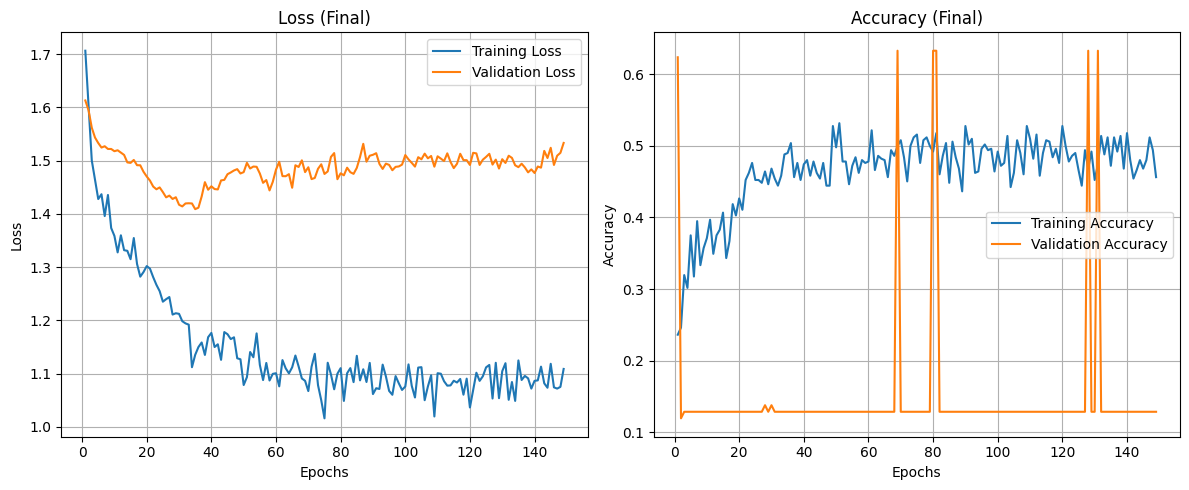


--- Evaluating Final Best Model on Test Set ---


Final Test Evaluation: 100%|██████████| 1/1 [00:00<00:00, 638.21it/s]


FINAL Test Accuracy: 0.6330
SUCCESS: Final test accuracy is above 50%!

FINAL Classification Report:
              precision    recall  f1-score   support

Neg Med (-2)       1.00      0.17      0.29         6
Neg Low (-1)       0.33      0.50      0.40         2
 Pos Low (1)       0.00      0.00      0.00        21
 Pos Med (2)       0.00      0.00      0.00        13
Pos High (3)       0.65      1.00      0.79        67

    accuracy                           0.63       109
   macro avg       0.40      0.33      0.29       109
weighted avg       0.46      0.63      0.51       109


FINAL Confusion Matrix:


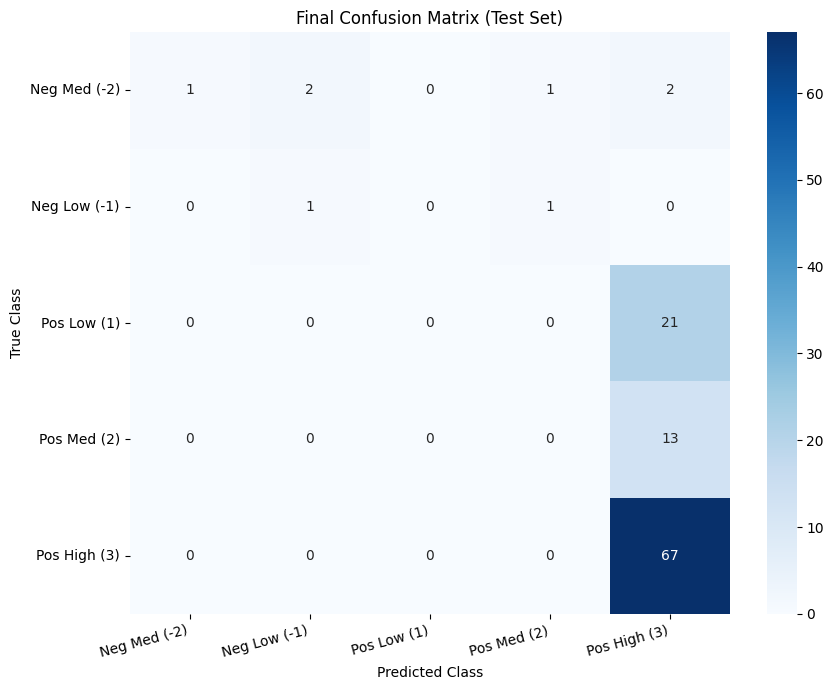


--- End of Training and Evaluation Script ---


In [30]:
# Cell for Refined Grid Search and Training (ESM-2 Embeddings Only)

# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler # Added StandardScaler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import copy # To store best model state
import time # For timing

# --- Ensure necessary variables exist from previous cells ---
# Check if X_nn_esm2 (ESM2 embeddings) exist
if 'X_nn_esm2' not in locals():
    raise NameError("X_nn_esm2 not defined. Please run the ESM-2 embedding generation cell.")
# Check if labels exist
if 'y_nn_esm2' not in locals():
     raise NameError("Labels y_nn_esm2 not defined.")

# Check shape consistency
if X_nn_esm2.shape[0] != y_nn_esm2.shape[0]:
    raise ValueError(f"Mismatch in number of samples: ESM2 shape {X_nn_esm2.shape}, Labels shape {y_nn_esm2.shape}")

print(f"Using ESM-2 embeddings with shape: {X_nn_esm2.shape}")

# --- Prepare Data for PyTorch (ESM-2 Only) ---
# (Same data prep as before: Filter, Encode, Split, Scale)
print("\nPreparing data for PyTorch (Using only ESM-2 embeddings)...")
non_zero_indices = y_nn_esm2 != 0
X_filtered = X_nn_esm2[non_zero_indices]
y_filtered = y_nn_esm2[non_zero_indices]
print(f"Filtered out {len(y_nn_esm2) - len(y_filtered)} samples with label 0.")
print(f"Remaining samples: {len(y_filtered)}")
if len(y_filtered) == 0: raise ValueError("No samples remaining after filtering.")

le = LabelEncoder(); y_encoded = le.fit_transform(y_filtered); num_classes = len(le.classes_)
print(f"Labels encoded into {num_classes} classes.")
class_names = {-3: 'Neg High (-3)', -2: 'Neg Med (-2)', -1: 'Neg Low (-1)', 1: 'Pos Low (1)', 2: 'Pos Med (2)', 3: 'Pos High (3)'}
target_names = [class_names.get(i, f'Unknown({i})') for i in le.classes_]
print("Class mapping (Encoded Value: Original Label | Name):")
for i, orig_label in enumerate(le.classes_): print(f"  {i}: {orig_label} | {target_names[i]}")

print("\nSplitting data...")
X_train_val, X_test, y_train_val, y_test = train_test_split(X_filtered, y_encoded, test_size=0.15, random_state=42, stratify=y_encoded)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42, stratify=y_train_val)
print(f"Data split: Train={len(y_train)}, Val={len(y_val)}, Test={len(y_test)}")

print("\nScaling features (StandardScaler)...")
scaler = StandardScaler(); X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val); X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

print("\nSetting up sampling and class weights...")
class_counts_train = np.bincount(y_train, minlength=num_classes)
print(f"Training set class counts (encoded): {class_counts_train}")
if np.any(class_counts_train == 0):
    print("Warning: Zero samples for some classes in train set. Weighted sampling/loss disabled.")
    use_weighted_sampler = False; sampler = None; class_weights_loss = None
else:
    class_weights_sample = 1. / torch.tensor(class_counts_train, dtype=torch.float32)
    sample_weights = class_weights_sample[y_train]
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    use_weighted_sampler = True
    class_weights_loss = (len(y_train) / (num_classes * torch.tensor(class_counts_train, dtype=torch.float32)))
    print(f"Using WeightedRandomSampler. Calculated Loss Weights: {class_weights_loss.numpy()}")

batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler if use_weighted_sampler else None, shuffle=not use_weighted_sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size * 2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size * 2, shuffle=False)

# --- Define Simple Neural Network Architecture ---
print("\nDefining Simple Neural Network Architecture...")
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[512, 256, 128], output_dim=6, dropout_rate=0.3):
        super(SimpleClassifier, self).__init__()
        layers = []
        current_dim = input_dim
        # Add layers dynamically based on hidden_dims list
        for h_dim in hidden_dims:
            layers.extend([
                nn.Linear(current_dim, h_dim),
                nn.BatchNorm1d(h_dim), # BatchNorm helps stabilize
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            current_dim = h_dim
        layers.append(nn.Linear(current_dim, output_dim)) # Final output layer
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# --- Using Best Hyperparameters ---
print("\n--- Using Best Hyperparameters ---")
best_params = {
    'dropout_rate': 0.3, 
    'hidden_dims': [512, 256, 128], 
    'loss_fn': 'CrossEntropyLoss', 
    'lr': 5e-05, 
    'model_type': 'Simple', 
    'optimizer': 'AdamW', 
    'weight_decay': 0.001
}
print(f"Best hyperparameters: {best_params}")
print(f"Best validation accuracy from previous grid search: 0.6602")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
input_dim = X_train_tensor.shape[1] # Should be 2560 for ESM-2
print(f"Input dimension: {input_dim}")

# --- Training the Model with Best Parameters ---
print("\n--- Training Model with Best Parameters ---")
# Instantiate the model with best parameters
final_model = SimpleClassifier(
    input_dim=input_dim,
    hidden_dims=best_params['hidden_dims'],
    output_dim=num_classes,
    dropout_rate=best_params['dropout_rate']
)
final_model.to(device)

# Define Loss and Optimizer
final_ce_weights = class_weights_loss if not use_weighted_sampler and class_weights_loss is not None else None
final_criterion = nn.CrossEntropyLoss(weight=final_ce_weights.to(device) if final_ce_weights is not None else None)
final_optimizer = optim.AdamW(final_model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
print(f"Using Optimizer: {best_params['optimizer']}, LR: {best_params['lr']}, WD: {best_params['weight_decay']}")
final_scheduler = optim.lr_scheduler.ReduceLROnPlateau(final_optimizer, mode='max', factor=0.2, patience=30, verbose=True)

# --- Final Training Loop ---
final_num_epochs = 600 # Increased max epochs for final training
final_patience_early_stopping = 80 # Increased patience for final training
final_epochs_no_improve = 0
final_best_val_acc = 0.0
final_best_model_state = None
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
print(f"Starting final training for up to {final_num_epochs} epochs...")
start_time_final = time.time()

for epoch in range(final_num_epochs):
    # --- Training Epoch ---
    final_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        final_optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = final_criterion(outputs, labels)
        loss.backward()
        final_optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    epoch_train_loss = running_loss / len(train_loader.dataset) if len(train_loader.dataset) > 0 else 0.0
    epoch_train_acc = correct_train / total_train if total_train > 0 else 0.0
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)

    # --- Validation Epoch ---
    final_model.eval()
    correct_val = 0
    total_val = 0
    running_val_loss = 0.0
    
    with torch.no_grad():
        for inputs_val, labels_val in val_loader:
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
            outputs_val = final_model(inputs_val)
            loss_val = final_criterion(outputs_val, labels_val)
            running_val_loss += loss_val.item() * inputs_val.size(0)
            _, predicted_val = torch.max(outputs_val.data, 1)
            total_val += labels_val.size(0)
            correct_val += (predicted_val == labels_val).sum().item()
    
    epoch_val_loss = running_val_loss / len(val_loader.dataset) if len(val_loader.dataset) > 0 else 0.0
    epoch_val_acc = correct_val / total_val if total_val > 0 else 0.0
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)

    print(f"  Epoch {epoch+1}/{final_num_epochs} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")
    final_scheduler.step(epoch_val_acc)

    # --- Early Stopping ---
    if epoch_val_acc > final_best_val_acc:
        print(f"  -> Validation accuracy improved ({final_best_val_acc:.4f} --> {epoch_val_acc:.4f}). Saving model...")
        final_best_val_acc = epoch_val_acc
        final_epochs_no_improve = 0
        final_best_model_state = copy.deepcopy(final_model.state_dict())
    else:
        final_epochs_no_improve += 1
    
    if final_epochs_no_improve >= final_patience_early_stopping:
        print(f"  Early stopping triggered after {epoch + 1} epochs.")
        break

end_time_final = time.time()
print(f"\n--- Final Training Complete ---")
print(f"Time taken: {(end_time_final - start_time_final)/60:.2f} minutes")
print(f"Best validation accuracy during final training: {final_best_val_acc:.4f}")

if final_best_model_state:
    print("Loading best model state from final training run...")
    final_model.load_state_dict(final_best_model_state)
else:
    print("Warning: No improvement? Using model state from last epoch.")

# --- Plot Final Curves ---
print("\nPlotting final training curves...")
epochs_ran = range(1, len(history['train_loss']) + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_ran, history['train_loss'], label='Training Loss')
plt.plot(epochs_ran, history['val_loss'], label='Validation Loss')
plt.title('Loss (Final)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_ran, history['train_acc'], label='Training Accuracy')
plt.plot(epochs_ran, history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy (Final)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Final Evaluation on Test Set ---
print("\n--- Evaluating Final Best Model on Test Set ---")
final_model.eval()
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Final Test Evaluation"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = final_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred_list.extend(predicted.cpu().numpy())
        y_true_list.extend(labels.cpu().numpy())

y_pred_final = np.array(y_pred_list)
y_test_final = np.array(y_true_list)
accuracy_final = accuracy_score(y_test_final, y_pred_final)
print(f"\nFINAL Test Accuracy: {accuracy_final:.4f}")

if accuracy_final > 0.50:
    print("SUCCESS: Final test accuracy is above 50%!")
else:
    print("NOTE: Final test accuracy did not exceed 50%.")

print("\nFINAL Classification Report:")
eval_labels = np.arange(num_classes)
eval_target_names = target_names
print(classification_report(y_test_final, y_pred_final, labels=eval_labels, target_names=eval_target_names, zero_division=0))

print("\nFINAL Confusion Matrix:")
cm_final = confusion_matrix(y_test_final, y_pred_final, labels=eval_labels)
try:
    import seaborn as sns
    plt.figure(figsize=(9, 7))
    sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', xticklabels=eval_target_names, yticklabels=eval_target_names)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title('Final Confusion Matrix (Test Set)')
    plt.xticks(rotation=15, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
except ImportError:
    print("Seaborn not installed.")
    print(cm_final)

print("\n--- End of Training and Evaluation Script ---")


--- Evaluating Final Best Model on Test Set (for Grouping) ---


Getting Test Predictions: 100%|██████████| 1/1 [00:00<00:00, 184.66it/s]


--- Group Evaluation (Benign/Pathogenic/Others) ---

Grouped Test Accuracy: 0.6514

Grouped Classification Report:
                              precision    recall  f1-score   support

        Benign/Likely Benign       0.00      0.00      0.00        34
Pathogenic/Likely Pathogenic       1.00      0.50      0.67         8
                      Others       0.65      1.00      0.79        67

                    accuracy                           0.65       109
                   macro avg       0.55      0.50      0.48       109
                weighted avg       0.47      0.65      0.53       109


Per-Group Accuracy:
  Group Benign/Likely Benign (Idx 0): 0.0000
  Group Pathogenic/Likely Pathogenic (Idx 1): 0.5000
  Group Others (Idx 2): 1.0000


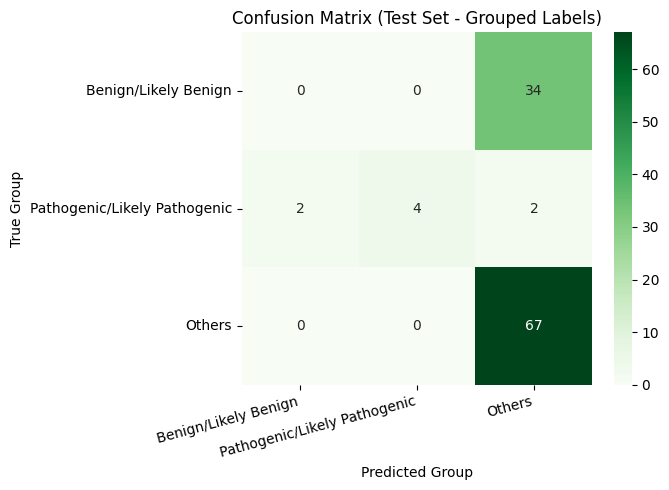


--- Grouped Evaluation Complete ---


In [31]:
# Cell for Grouped Evaluation of the Best Model

import torch
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# --- Ensure required variables and libraries exist ---
required_vars_eval = ['final_model', 'test_loader', 'device', 'le', 'target_names', 'num_classes']
for var in required_vars_eval:
    if var not in locals():
        raise NameError(f"Variable '{var}' not found. Please ensure the previous training cell was run successfully.")

try:
    import seaborn as sns
    seaborn_available = True
except ImportError:
    print("Seaborn not installed. Confusion matrix heatmap will not be plotted.")
    seaborn_available = False

# --- Get Predictions from the Final Model ---
print("\n--- Evaluating Final Best Model on Test Set (for Grouping) ---")
final_model.eval() # Set model to evaluation mode
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Getting Test Predictions"):
        # Move data to device
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = final_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred_list.extend(predicted.cpu().numpy())
        y_true_list.extend(labels.cpu().numpy())

y_pred_final = np.array(y_pred_list)
y_test_final = np.array(y_true_list) # These are the encoded test labels

# --- Group Evaluation Logic ---
print("\n--- Group Evaluation (Benign/Pathogenic/Others) ---")
try:
    # Define the grouping mapping based on the LabelEncoder's learned classes
    # Group 0: Benign or Likely Benign (original classes 1 and 2)
    # Group 1: Pathogenic or Likely Pathogenic (original classes -1 and -2)
    # Group 2: Others (original classes -3, 3, etc.)
    group_mapping = {}
    benign_labels = {1, 2}
    pathogenic_labels = {-1, -2}

    for encoded_idx, original_class in enumerate(le.classes_):
        if original_class in benign_labels:
            group_mapping[encoded_idx] = 0 # Group 0
        elif original_class in pathogenic_labels:
            group_mapping[encoded_idx] = 1 # Group 1
        else:
            group_mapping[encoded_idx] = 2 # Group 2

    group_names = ['Benign/Likely Benign', 'Pathogenic/Likely Pathogenic', 'Others']

    # Map predictions and true labels to groups
    y_true_grouped = np.array([group_mapping[label] for label in y_test_final])
    y_pred_grouped = np.array([group_mapping[pred] for pred in y_pred_final])

    # Filter to only include groups that exist in the data AND have defined names
    unique_groups = sorted(list(set(y_true_grouped) | set(y_pred_grouped))) # Get all unique group indices present
    target_names_grouped = [group_names[g] for g in unique_groups if g < len(group_names)]

    # Adjust labels if only a subset of groups (0, 1, 2) is present
    if len(target_names_grouped) != len(unique_groups):
         print("Warning: Some predicted/true groups are outside the defined group_names indices. Filtering results.")
         # Filter out data points belonging to undefined groups if necessary (or adjust mapping)
         # For simplicity here, we'll proceed but the report/CM might look odd if group '2' exists but has no name.
         valid_indices = [i for i, g in enumerate(unique_groups) if g < len(group_names)]
         unique_groups = [unique_groups[i] for i in valid_indices]


    # Calculate metrics for grouped evaluation
    accuracy_grouped = accuracy_score(y_true_grouped, y_pred_grouped)
    print(f"\nGrouped Test Accuracy: {accuracy_grouped:.4f}")

    print("\nGrouped Classification Report:")
    # Ensure labels used match the target names provided
    print(classification_report(y_true_grouped, y_pred_grouped,
                                labels=unique_groups,
                                target_names=target_names_grouped,
                                zero_division=0))

    # Confusion matrix for grouped evaluation
    cm_grouped = confusion_matrix(y_true_grouped, y_pred_grouped, labels=unique_groups)

    # Calculate per-group accuracy
    cm_grouped_sum_axis1 = cm_grouped.sum(axis=1)
    per_group_acc = np.divide(cm_grouped.diagonal(), cm_grouped_sum_axis1,
                              out=np.zeros_like(cm_grouped.diagonal(), dtype=float),
                              where=cm_grouped_sum_axis1!=0)

    print("\nPer-Group Accuracy:")
    for i, group_name in enumerate(target_names_grouped):
         true_group_idx = unique_groups[i] # Get the actual group index
         if cm_grouped_sum_axis1[i] > 0:
             print(f"  Group {group_name} (Idx {true_group_idx}): {per_group_acc[i]:.4f}")
         else:
             print(f"  Group {group_name} (Idx {true_group_idx}): N/A (no true samples in test set)")

    # Display grouped confusion matrix with labels using seaborn
    if seaborn_available:
        plt.figure(figsize=(7, 5)) # Adjusted size
        sns.heatmap(cm_grouped, annot=True, fmt='d', cmap='Greens', # Changed color map
                    xticklabels=target_names_grouped, yticklabels=target_names_grouped)
        plt.xlabel('Predicted Group')
        plt.ylabel('True Group')
        plt.title('Confusion Matrix (Test Set - Grouped Labels)')
        plt.xticks(rotation=15, ha='right') # Improve label readability
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    else:
        print("\nGrouped Confusion Matrix (row=True, col=Predicted):")
        try:
             print(pd.DataFrame(cm_grouped, index=target_names_grouped, columns=target_names_grouped))
        except NameError: # If pandas wasn't imported
             print(cm_grouped)

except NameError as e:
    print(f"Skipping grouped evaluation due to NameError: {e}. Was 'le' (LabelEncoder) defined?")
except KeyError as e:
     print(f"Skipping grouped evaluation due to KeyError: {e}. Check if all predicted/true labels exist in group_mapping.")
except Exception as e:
     print(f"Error during grouped evaluation: {e}")

print("\n--- Grouped Evaluation Complete ---")

### Combined

#### GRID SEARCH

In [19]:
# Cell for Grid Search and Training (Fused DNA-BERT + ESM-2 Embeddings)

# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import copy
import time
import gc # Garbage collector

# --- Ensure necessary variables exist from previous cells ---
required_vars = ['X_nn', 'X_nn_esm2', 'y_nn_esm2'] # Assuming y_nn_esm2 matches both
for var in required_vars:
    if var not in locals():
        raise NameError(f"Variable '{var}' not defined. Please run previous cells.")

if X_nn.shape[0] != X_nn_esm2.shape[0] or X_nn.shape[0] != y_nn_esm2.shape[0]:
     raise ValueError("Mismatch in number of samples between DNA, ESM2, and labels.")

# Store original dimensions for splitting later
dna_embedding_dim = X_nn.shape[1]
esm2_embedding_dim = X_nn_esm2.shape[1]
fused_input_dim = dna_embedding_dim + esm2_embedding_dim
print(f"DNA-BERT embedding dim: {dna_embedding_dim}")
print(f"ESM-2 embedding dim: {esm2_embedding_dim}")
print(f"Fused input dim: {fused_input_dim}")

# --- Fuse Embeddings ---
# Ensure data is in numpy format for concatenation and splitting
X_nn_np = X_nn if isinstance(X_nn, np.ndarray) else X_nn.numpy()
X_nn_esm2_np = X_nn_esm2 if isinstance(X_nn_esm2, np.ndarray) else X_nn_esm2.numpy()
y_nn_np = y_nn_esm2 

X_fused = np.concatenate((X_nn_np, X_nn_esm2_np), axis=1)
print(f"Fused data shape: {X_fused.shape}")

# --- Prepare Data (Filter Labels, Encode, Split FUSED data) ---
print("\nPreparing data for PyTorch (Using FUSED embeddings)...")
non_zero_indices = y_nn_esm2 != 0
X_filtered = X_fused[non_zero_indices]
y_filtered = y_nn_esm2[non_zero_indices]
print(f"Filtered out {len(y_nn_esm2) - len(y_filtered)} samples with label 0.")
print(f"Remaining samples: {len(y_filtered)}")
if len(y_filtered) == 0: raise ValueError("No samples remaining after filtering.")

le = LabelEncoder(); y_encoded = le.fit_transform(y_filtered); num_classes = len(le.classes_)
print(f"Labels encoded into {num_classes} classes.")
class_names = {-3: 'Neg High (-3)', -2: 'Neg Med (-2)', -1: 'Neg Low (-1)', 1: 'Pos Low (1)', 2: 'Pos Med (2)', 3: 'Pos High (3)'}
target_names = [class_names.get(i, f'Unknown({i})') for i in le.classes_]
print("Class mapping (Encoded Value: Original Label | Name):")
for i, orig_label in enumerate(le.classes_): print(f"  {i}: {orig_label} | {target_names[i]}")

print("\nSplitting data...")
X_train_val, X_test, y_train_val, y_test = train_test_split(X_filtered, y_encoded, test_size=0.15, random_state=42, stratify=y_encoded)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42, stratify=y_train_val)
print(f"Data split: Train={len(y_train)}, Val={len(y_val)}, Test={len(y_test)}")

# --- CRUCIAL: SEPARATE SCALING ---
print("\nScaling features SEPARATELY (DNA-BERT & ESM-2)...")
# Split training data back into components
X_train_dna = X_train[:, :dna_embedding_dim]
X_train_esm2 = X_train[:, dna_embedding_dim:]

# Fit scalers ONLY on training components
scaler_dna = StandardScaler().fit(X_train_dna)
scaler_esm2 = StandardScaler().fit(X_train_esm2)

# Transform components for all sets
X_train_dna_scaled = scaler_dna.transform(X_train_dna)
X_train_esm2_scaled = scaler_esm2.transform(X_train_esm2)

X_val_dna_scaled = scaler_dna.transform(X_val[:, :dna_embedding_dim])
X_val_esm2_scaled = scaler_esm2.transform(X_val[:, dna_embedding_dim:])

X_test_dna_scaled = scaler_dna.transform(X_test[:, :dna_embedding_dim])
X_test_esm2_scaled = scaler_esm2.transform(X_test[:, dna_embedding_dim:])

# Concatenate scaled components back together
X_train_fused_scaled = np.concatenate((X_train_dna_scaled, X_train_esm2_scaled), axis=1)
X_val_fused_scaled = np.concatenate((X_val_dna_scaled, X_val_esm2_scaled), axis=1)
X_test_fused_scaled = np.concatenate((X_test_dna_scaled, X_test_esm2_scaled), axis=1)
print(f"Scaled & Fused Train shape: {X_train_fused_scaled.shape}")

# --- Convert to PyTorch Tensors ---
X_train_tensor = torch.tensor(X_train_fused_scaled, dtype=torch.float32); y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_fused_scaled, dtype=torch.float32); y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_fused_scaled, dtype=torch.float32); y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# --- Calculate Class Counts and Base Weights ---
print("\nCalculating class counts and base weights...")
class_counts_train = np.bincount(y_train, minlength=num_classes)
print(f"Training set class counts (encoded): {class_counts_train}")
use_weights = not np.any(class_counts_train == 0)
if use_weights:
    sampler_weights_base = 1. / torch.tensor(class_counts_train, dtype=torch.float32)
    loss_weights_base = (len(y_train) / (num_classes * torch.tensor(class_counts_train, dtype=torch.float32)))
    print(f"Base Loss Weights: {loss_weights_base.numpy()}")
    print(f"Base Sampler Weights: {sampler_weights_base.numpy()}")
else:
    print("Warning: Zero samples for some classes. Disabling weighted strategies.")
    sampler_weights_base = None; loss_weights_base = None

# Create Datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Loss Function Implementations (CB Loss, Focal Loss) - Keep as defined previously
class ClassBalancedLoss(nn.Module):
    # ... (keep implementation from previous script) ...
    def __init__(self, loss_type, samples_per_cls, beta=0.999, gamma=2.0):
        super(ClassBalancedLoss, self).__init__();
        if isinstance(samples_per_cls, np.ndarray): samples_per_cls = torch.from_numpy(samples_per_cls)
        self.samples_per_cls = samples_per_cls.float(); self.beta = beta; self.gamma = gamma
        self.num_classes = len(samples_per_cls)
        effective_num = 1.0 - torch.pow(self.beta, self.samples_per_cls)
        weights = (1.0 - self.beta) / (effective_num + 1e-8)
        self.register_buffer('cb_weights', weights / weights.sum() * self.num_classes)
        # print(f"CB Loss Init Weights (CPU): {self.cb_weights.numpy()}") # Verbose
        if loss_type == 'CrossEntropy': self.base_loss = nn.CrossEntropyLoss(weight=None, reduction='none')
        elif loss_type == 'Focal': self.base_loss = FocalLoss(alpha=1.0, gamma=self.gamma, reduction='none')
        else: raise ValueError(f"Unsupported loss_type: {loss_type}")
        self.reduction = 'mean'
    def forward(self, inputs, targets):
        cb_weights_dev = self.cb_weights.to(inputs.device)
        if isinstance(self.base_loss, nn.CrossEntropyLoss): self.base_loss.weight = cb_weights_dev
        elif isinstance(self.base_loss, FocalLoss): self.base_loss.alpha = cb_weights_dev
        per_sample_loss = self.base_loss(inputs, targets)
        if self.reduction == 'mean': return per_sample_loss.mean()
        elif self.reduction == 'sum': return per_sample_loss.sum()
        else: return per_sample_loss

class FocalLoss(nn.Module):
    # ... (keep implementation from previous script) ...
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean', weight=None):
        super(FocalLoss, self).__init__(); self.gamma = gamma; self.reduction = reduction
        self.alpha = alpha if alpha is not None else 1.0; self.weight = weight
    def forward(self, inputs, targets):
        current_device = inputs.device; current_ce_weight = self.weight
        if isinstance(current_ce_weight, torch.Tensor): current_ce_weight = current_ce_weight.to(current_device)
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=current_ce_weight)
        pt = torch.exp(-ce_loss); alpha_t = self.alpha
        if isinstance(alpha_t, torch.Tensor): alpha_t = alpha_t.to(current_device).gather(0, targets.data.view(-1))
        elif not isinstance(alpha_t, (float, int)): alpha_t = 1.0
        focal_loss = alpha_t * (1 - pt)**self.gamma * ce_loss
        if self.reduction == 'mean': return focal_loss.mean()
        elif self.reduction == 'sum': return focal_loss.sum()
        else: return focal_loss

# --- Define Simple MLP Architecture ---
print("\nDefining Simple Neural Network Architecture...")
class SimpleClassifier(nn.Module):
    # ... (keep implementation from previous script) ...
    def __init__(self, input_dim, hidden_dims=[512, 256], output_dim=6, dropout_rate=0.4, activation_fn=nn.ReLU):
        super(SimpleClassifier, self).__init__(); layers = []; current_dim = input_dim
        for h_dim in hidden_dims: layers.extend([nn.Linear(current_dim, h_dim), nn.BatchNorm1d(h_dim), activation_fn(), nn.Dropout(dropout_rate)]); current_dim = h_dim
        layers.append(nn.Linear(current_dim, output_dim)); self.network = nn.Sequential(*layers)
    def forward(self, x): return self.network(x)

# --- Grid Search Setup for FUSED Data ---
print("\n--- Setting up Grid Search for FUSED Embeddings ---")
param_grid = {
    'model_type': ['Simple'],
    'lr': [5e-4, 1e-4, 5e-5],
    'weight_decay': [0.01, 0.001, 0.0],
    'dropout_rate': [0.3, 0.45], # Reduced options slightly
    'optimizer': ['AdamW', 'RMSprop'], # Focused based on last search
    'batch_size': [64, 128],
    'activation_fn': ['ReLU', 'LeakyReLU'], # Focused based on last search
    # Adjusted hidden dims for larger input size
    'hidden_dims': [[1024, 512], [2048, 1024], [2048, 1024, 512]],
    # Focused imbalance strategies
    'imbalance_strategy': ['WeightedSampler', 'WeightedLossCE', 'ClassBalancedCE'],
    'cb_beta': [0.999, 0.9999], # Only for ClassBalancedCE
    'label_smoothing': [0.0, 0.1] # Only for CE strategies
}

# Filter grid
print("Filtering parameter grid...")
filtered_grid = []; count = 0; original_grid = ParameterGrid(param_grid); total_combinations = len(original_grid)
print(f"Initial grid size: {total_combinations}")
for params in original_grid:
    count += 1; valid_combo = True
    if "ClassBalanced" not in params['imbalance_strategy'] and params['cb_beta'] != param_grid['cb_beta'][0]: valid_combo = False
    if "CE" not in params['imbalance_strategy'] and "WeightedSampler" != params['imbalance_strategy'] and params['label_smoothing'] != param_grid['label_smoothing'][0]: valid_combo = False
    if valid_combo: filtered_grid.append(params)
print(f"Filtered grid size: {len(filtered_grid)} combinations")

# Grid search parameters
grid_search_epochs = 150
grid_search_patience = 35 # Slightly more patience

# Tracking variables
best_overall_val_acc = 0.0; best_overall_params = None
best_overall_model_state = None; best_overall_optimizer_state = None # ADDED
grid_results = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); print(f"Using device: {device}")
input_dim = X_train_tensor.shape[1]; print(f"Fused Input dimension: {input_dim}") # Should be larger now

# --- Grid Search Loop for FUSED Data ---
start_time_grid = time.time()
for i, params in enumerate(filtered_grid):
    print(f"\n--- Grid Search Combination {i+1}/{len(filtered_grid)} ---")
    print(f"Parameters: {params}")
    gc.collect(); torch.cuda.empty_cache() if device == 'cuda' else None

    try:
        # Setup Dataloaders
        current_batch_size = params['batch_size']; current_imbalance_strategy = params['imbalance_strategy']
        current_sampler = None; use_sampler_flag = False
        if current_imbalance_strategy == 'WeightedSampler':
            if sampler_weights_base is not None:
                sample_weights = sampler_weights_base[y_train]
                current_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True); use_sampler_flag = True
        current_train_loader = DataLoader(train_dataset, batch_size=current_batch_size, sampler=current_sampler, shuffle=not use_sampler_flag, num_workers=0)
        current_val_loader = DataLoader(val_dataset, batch_size=current_batch_size * 2, shuffle=False, num_workers=0)

        # Activation
        activation = nn.LeakyReLU if params['activation_fn'] == 'LeakyReLU' else nn.ReLU

        # Model
        nn_model = SimpleClassifier(input_dim, params['hidden_dims'], num_classes, params['dropout_rate'], activation)
        nn_model.to(device)

        # Loss
        loss_weights = None
        if current_imbalance_strategy == 'WeightedLossCE' or current_imbalance_strategy == 'ClassBalancedCE':
            if loss_weights_base is not None: loss_weights = loss_weights_base.to(device)

        if current_imbalance_strategy == 'ClassBalancedCE':
             if use_weights: final_criterion = ClassBalancedLoss(loss_type='CrossEntropy', samples_per_cls=class_counts_train, beta=params['cb_beta']).to(device)
             else: final_criterion = nn.CrossEntropyLoss() # Fallback
        else: # WeightedSampler or WeightedLossCE use CrossEntropy
             ls_eps = params.get('label_smoothing', 0.0)
             ce_weight_param = loss_weights if current_imbalance_strategy == 'WeightedLossCE' else None
             final_criterion = nn.CrossEntropyLoss(weight=ce_weight_param, label_smoothing=ls_eps)

        # Optimizer
        optimizer_type = params['optimizer']; lr=params['lr']; wd=params['weight_decay']
        if optimizer_type == 'Adam': optimizer = optim.Adam(nn_model.parameters(), lr=lr, weight_decay=wd)
        elif optimizer_type == 'RMSprop': optimizer = optim.RMSprop(nn_model.parameters(), lr=lr, weight_decay=wd)
        else: optimizer = optim.AdamW(nn_model.parameters(), lr=lr, weight_decay=wd)

        # Scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=15, verbose=False)

        # Training Loop
        current_best_val_acc = 0.0; best_model_state_current = None; best_optimizer_state_current = None; epochs_no_improve = 0
        for epoch in range(grid_search_epochs):
            nn_model.train(); running_loss = 0.0; total_train=0
            for inputs, labels in current_train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad(); outputs = nn_model(inputs); loss = final_criterion(outputs, labels)
                if torch.isnan(loss) or torch.isinf(loss): print(f"NaN/Inf loss"); current_best_val_acc = -1; break
                loss.backward(); optimizer.step(); running_loss += loss.item() * inputs.size(0); total_train += inputs.size(0)
            if current_best_val_acc == -1: break
            epoch_train_loss = running_loss / total_train if total_train > 0 else 0

            nn_model.eval(); correct_val = 0; total_val = 0; running_val_loss = 0.0; epoch_val_acc = 0.0
            with torch.no_grad():
                for inputs_val, labels_val in current_val_loader:
                    inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
                    outputs_val = nn_model(inputs_val); loss_val = final_criterion(outputs_val, labels_val)
                    if torch.isnan(loss_val) or torch.isinf(loss_val): epoch_val_acc = -1; break
                    running_val_loss += loss_val.item() * inputs_val.size(0)
                    _, predicted_val = torch.max(outputs_val.data, 1); total_val += labels_val.size(0); correct_val += (predicted_val == labels_val).sum().item()
                if epoch_val_acc == -1: current_best_val_acc = -1; break
                epoch_val_loss = running_val_loss / total_val if total_val > 0 else 0
                epoch_val_acc = correct_val / total_val if total_val > 0 else 0

            if (epoch + 1) % 50 == 0 or epoch == 0 or (epoch + 1) == grid_search_epochs: print(f" E{epoch+1} - TrL:{epoch_train_loss:.3f}, Vl L:{epoch_val_loss:.3f}, Vl A:{epoch_val_acc:.4f}")
            scheduler.step(epoch_val_acc)
            if epoch_val_acc > current_best_val_acc:
                current_best_val_acc = epoch_val_acc; epochs_no_improve = 0
                best_model_state_current = copy.deepcopy(nn_model.state_dict())
                best_optimizer_state_current = copy.deepcopy(optimizer.state_dict()) # SAVE OPTIMIZER STATE
            else: epochs_no_improve += 1
            if epochs_no_improve >= grid_search_patience: print(f" EStop@{epoch+1}"); break
        # End epoch loop

        if current_best_val_acc <= 0: current_best_val_acc = 0.0
        print(f"Combo {i+1} Best Val Acc: {current_best_val_acc:.4f}")
        grid_results.append({'params': params, 'best_val_acc': current_best_val_acc, 'epochs_run': epoch + 1})
        if current_best_val_acc > best_overall_val_acc:
            print(f"!!! New Best Overall: {current_best_val_acc:.4f} !!!")
            best_overall_val_acc = current_best_val_acc; best_overall_params = params
            best_overall_model_state = best_model_state_current
            best_overall_optimizer_state = best_optimizer_state_current # SAVE BEST OPTIMIZER STATE

    except Exception as e:
        print(f"ERROR processing Combination {i+1}: {e}")
        grid_results.append({'params': params, 'best_val_acc': 0.0, 'epochs_run': 0, 'error': str(e)})

# --- End Grid Search ---
end_time_grid = time.time(); print(f"\n--- Fused Grid Search Complete ---"); print(f"Time: {(end_time_grid - start_time_grid)/60:.2f} min")
grid_results.sort(key=lambda x: x['best_val_acc'], reverse=True); print("\nTop 10 Fused Grid Search Results (Validation Accuracy):")
for res in grid_results[:10]: print(f"  Val Acc: {res['best_val_acc']:.4f}, Ep: {res['epochs_run']}, P: {res['params']}")

if best_overall_params is None or best_overall_val_acc <= 0: raise SystemExit("Error: Fused Grid search failed.")

print(f"\nBest hyperparameters found: {best_overall_params}")
print(f"Best validation accuracy: {best_overall_val_acc:.4f}")
if best_overall_val_acc > 0.50: print("Convergence Goal (>50%) MET!")
else: print("WARNING: Convergence Goal (>50%) NOT MET.")


# --- Retrain Best Fused Model Fully ---
print("\n--- Retraining Best Fused Model Configuration Fully ---")
final_best_params = best_overall_params
# Instantiate Activation
final_activation = nn.LeakyReLU if final_best_params['activation_fn'] == 'LeakyReLU' else (nn.GELU if final_best_params['activation_fn'] == 'GELU' else nn.ReLU)
# Instantiate Model
final_model = SimpleClassifier(input_dim, final_best_params['hidden_dims'], num_classes, final_best_params['dropout_rate'], final_activation)
# Load Best Model State
if best_overall_model_state:
     print("Loading best model state found during grid search...")
     final_model.load_state_dict(best_overall_model_state)
else: print("Warning: No best model state saved from grid search!"); exit() # Should not happen if grid search ran
final_model.to(device)

# Define Final Loss Function (matching best strategy)
final_imbalance_strategy = final_best_params['imbalance_strategy']
if final_imbalance_strategy == 'ClassBalancedCE':
    if use_weights: final_criterion = ClassBalancedLoss(loss_type='CrossEntropy', samples_per_cls=class_counts_train, beta=final_best_params['cb_beta']).to(device)
    else: final_criterion = nn.CrossEntropyLoss() # Fallback
elif final_imbalance_strategy == 'WeightedLossCE':
     final_ce_weights = loss_weights_base.to(device) if use_weights else None
     final_criterion = nn.CrossEntropyLoss(weight=final_ce_weights, label_smoothing=final_best_params['label_smoothing'])
else: # Default WeightedSampler uses standard CE
     final_criterion = nn.CrossEntropyLoss(label_smoothing=final_best_params['label_smoothing'])
print(f"Using final loss strategy: {final_imbalance_strategy}")

# Define Final Optimizer
# Use a slightly lower LR for fine-tuning, or the original one if loading optimizer state
# final_lr_retrain = final_best_params['lr'] * 0.1 # Option 1: Lower LR
final_lr_retrain = final_best_params['lr'] # Option 2: Use original LR (since we load optimizer state)
print(f"Using Final Retraining LR: {final_lr_retrain}")
final_wd = final_best_params['weight_decay']; final_optimizer_type = final_best_params['optimizer']
if final_optimizer_type == 'Adam': final_optimizer = optim.Adam(final_model.parameters(), lr=final_lr_retrain, weight_decay=final_wd)
elif final_optimizer_type == 'RMSprop': final_optimizer = optim.RMSprop(final_model.parameters(), lr=final_lr_retrain, weight_decay=final_wd)
else: final_optimizer = optim.AdamW(final_model.parameters(), lr=final_lr_retrain, weight_decay=final_wd)
print(f"Using Optimizer: {final_optimizer_type}")

# --- LOAD OPTIMIZER STATE ---
if best_overall_optimizer_state:
    print("Loading best optimizer state found during grid search...")
    final_optimizer.load_state_dict(best_overall_optimizer_state)
    print("Optimizer state loaded.")
else:
    print("Warning: No optimizer state saved from grid search. Starting optimizer from scratch.")

# Scheduler
final_scheduler = optim.lr_scheduler.ReduceLROnPlateau(final_optimizer, mode='max', factor=0.2, patience=40, verbose=True) # Increased patience

# --- Final Training Loop ---
final_num_epochs = 500; final_patience_early_stopping = 80
final_epochs_no_improve = 0; final_best_val_acc = 0.0; final_best_model_state_retrain = None
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
print(f"Starting final training for up to {final_num_epochs} epochs...")
start_time_final = time.time()

# Get initial validation accuracy with loaded model state
final_model.eval(); correct_val = 0; total_val = 0
with torch.no_grad():
    for inputs_val, labels_val in val_loader:
        inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
        outputs_val = final_model(inputs_val)
        _, predicted_val = torch.max(outputs_val.data, 1); total_val += labels_val.size(0); correct_val += (predicted_val == labels_val).sum().item()
initial_val_acc = correct_val / total_val if total_val > 0 else 0.0
final_best_val_acc = initial_val_acc # Start tracking from loaded model's accuracy
final_best_model_state_retrain = copy.deepcopy(final_model.state_dict()) # Save initial state
print(f"Initial Validation Accuracy with loaded state: {initial_val_acc:.4f}")

for epoch in range(final_num_epochs):
    final_model.train(); running_loss = 0.0; correct_train = 0; total_train = 0
    progress_bar_final = tqdm(train_loader, desc=f"Retrain Epoch {epoch+1}/{final_num_epochs}", leave=False)
    for inputs, labels in progress_bar_final:
        inputs, labels = inputs.to(device), labels.to(device)
        final_optimizer.zero_grad(); outputs = final_model(inputs); loss = final_criterion(outputs, labels)
        if torch.isnan(loss) or torch.isinf(loss): print(f"NaN/Inf loss"); final_best_val_acc = -1; break
        loss.backward(); final_optimizer.step(); running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1); total_train += labels.size(0); correct_train += (predicted == labels).sum().item()
        progress_bar_final.set_postfix({'loss': loss.item(), 'lr': final_optimizer.param_groups[0]['lr']})
    if final_best_val_acc <= -1 : break
    epoch_train_loss = running_loss / total_train if total_train > 0 else 0
    epoch_train_acc = correct_train / total_train if total_train > 0 else 0
    history['train_loss'].append(epoch_train_loss); history['train_acc'].append(epoch_train_acc)

    # Validation
    final_model.eval(); correct_val = 0; total_val = 0; running_val_loss = 0.0; epoch_val_acc = 0.0
    with torch.no_grad():
        for inputs_val, labels_val in val_loader:
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
            outputs_val = final_model(inputs_val); loss_val = final_criterion(outputs_val, labels_val)
            if torch.isnan(loss_val) or torch.isinf(loss_val): epoch_val_acc = -1; break
            running_val_loss += loss_val.item() * inputs_val.size(0)
            _, predicted_val = torch.max(outputs_val.data, 1); total_val += labels_val.size(0); correct_val += (predicted_val == labels_val).sum().item()
        if epoch_val_acc == -1: final_best_val_acc = -1; break
        epoch_val_loss = running_val_loss / total_val if total_val > 0 else 0
        epoch_val_acc = correct_val / total_val if total_val > 0 else 0
        history['val_loss'].append(epoch_val_loss); history['val_acc'].append(epoch_val_acc)

    print(f" Ep {epoch+1} - TrL:{epoch_train_loss:.4f}, TrA:{epoch_train_acc:.4f} | VlL:{epoch_val_loss:.4f}, VlA:{epoch_val_acc:.4f}")
    final_scheduler.step(epoch_val_acc)

    # Early Stopping
    if epoch_val_acc > final_best_val_acc:
        print(f"  -> Val Acc improved ({final_best_val_acc:.4f} --> {epoch_val_acc:.4f})")
        final_best_val_acc = epoch_val_acc; final_epochs_no_improve = 0
        final_best_model_state_retrain = copy.deepcopy(final_model.state_dict())
    else:
        final_epochs_no_improve += 1
    if final_epochs_no_improve >= final_patience_early_stopping:
        print(f"  Early stopping @ epoch {epoch + 1}"); break
# --- End Final Training Loop ---

end_time_final = time.time()
print(f"\n--- Final Training Complete ---"); print(f"Time: {(end_time_final - start_time_final)/60:.2f} min")

if final_best_model_state_retrain:
     print(f"Loading best model state from RETRAINING (Val Acc: {final_best_val_acc:.4f})...")
     final_model.load_state_dict(final_best_model_state_retrain)
elif best_overall_model_state: # Fallback to grid search best if retraining failed entirely
     print(f"WARNING: Retraining did not improve or failed. Loading best state from GRID SEARCH (Val Acc: {best_overall_val_acc:.4f})...")
     final_model.load_state_dict(best_overall_model_state)
else:
     raise SystemExit("ERROR: No valid model state found after training. Cannot evaluate.")


# --- Plot Final Training Curves ---
# ... (Plotting code - same as before) ...
print("\nPlotting final training curves...")
epochs_ran = range(1, len(history['train_loss']) + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.plot(epochs_ran, history['train_loss'], label='Training Loss'); plt.plot(epochs_ran, history['val_loss'], label='Validation Loss'); plt.title('Loss (Final Training)'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
plt.subplot(1, 2, 2); plt.plot(epochs_ran, history['train_acc'], label='Training Accuracy'); plt.plot(epochs_ran, history['val_acc'], label='Validation Accuracy'); plt.title('Accuracy (Final Training)'); plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

# --- Final Evaluation on Test Set (Including Grouped) ---
print("\n--- Evaluating Final Best Model on Test Set ---")
# ... (Evaluation code including grouped analysis and plots - same as previous script) ...
final_model.eval(); y_pred_list = []; y_true_list = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Final Test Evaluation"):
        inputs, labels = inputs.to(device), labels.to(device); outputs = final_model(inputs)
        _, predicted = torch.max(outputs.data, 1); y_pred_list.extend(predicted.cpu().numpy()); y_true_list.extend(labels.cpu().numpy())
y_pred_final = np.array(y_pred_list); y_test_final = np.array(y_true_list)
accuracy_final = accuracy_score(y_test_final, y_pred_final)
print(f"\nFINAL Test Accuracy: {accuracy_final:.4f}")
if accuracy_final > 0.50: print("SUCCESS: Final test accuracy is above 50%!")
else: print("NOTE: Final test accuracy did not exceed 50%.")
print("\nFINAL Classification Report (Individual Classes):")
eval_labels = np.arange(num_classes); eval_target_names = target_names
print(classification_report(y_test_final, y_pred_final, labels=eval_labels, target_names=eval_target_names, zero_division=0))
print("\nFINAL Confusion Matrix (Individual Classes):")
cm_final = confusion_matrix(y_test_final, y_pred_final, labels=eval_labels)
try:
    import seaborn as sns; sns_available_final = True
    plt.figure(figsize=(8, 6)); sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', xticklabels=eval_target_names, yticklabels=eval_target_names)
    plt.xlabel('Predicted Class'); plt.ylabel('True Class'); plt.title('Confusion Matrix (Test Set - Individual Classes)'); plt.xticks(rotation=15, ha='right'); plt.yticks(rotation=0); plt.tight_layout(); plt.show()
except ImportError: sns_available_final = False; print("Seaborn not installed."); print(pd.DataFrame(cm_final, index=eval_target_names, columns=eval_target_names) if 'pd' in locals() else cm_final)

print("\n--- Final Group Evaluation ---")
try:
    group_mapping = {}; benign_labels = {1, 2}; pathogenic_labels = {-1, -2}
    for encoded_idx, original_class in enumerate(le.classes_):
        if original_class in benign_labels: group_mapping[encoded_idx] = 0
        elif original_class in pathogenic_labels: group_mapping[encoded_idx] = 1
        else: group_mapping[encoded_idx] = 2
    group_names = ['Benign/Likely Benign', 'Pathogenic/Likely Pathogenic', 'Others']
    y_true_grouped_final = np.array([group_mapping[label] for label in y_test_final])
    y_pred_grouped_final = np.array([group_mapping[pred] for pred in y_pred_final])
    unique_groups_final = sorted(list(set(y_true_grouped_final) | set(y_pred_grouped_final)))
    target_names_grouped = [group_names[g] for g in unique_groups_final if g < len(group_names)]
    if len(target_names_grouped) != len(unique_groups_final): print("Warning: Mismatch between unique groups and group names!")
    accuracy_grouped = accuracy_score(y_true_grouped_final, y_pred_grouped_final)
    print(f"\nFinal Grouped Test Accuracy: {accuracy_grouped:.4f}")
    print("\nFinal Grouped Classification Report:")
    print(classification_report(y_true_grouped_final, y_pred_grouped_final, labels=unique_groups_final, target_names=target_names_grouped, zero_division=0))
    cm_grouped_final = confusion_matrix(y_true_grouped_final, y_pred_grouped_final, labels=unique_groups_final)
    if sns_available_final:
        plt.figure(figsize=(7, 5)); sns.heatmap(cm_grouped_final, annot=True, fmt='d', cmap='Greens', xticklabels=target_names_grouped, yticklabels=target_names_grouped)
        plt.xlabel('Predicted Group'); plt.ylabel('True Group'); plt.title('Confusion Matrix (Test Set - Grouped)'); plt.xticks(rotation=15, ha='right'); plt.yticks(rotation=0); plt.tight_layout(); plt.show()
    else: print("\nGrouped Confusion Matrix:\n", pd.DataFrame(cm_grouped_final, index=target_names_grouped, columns=target_names_grouped) if 'pd' in locals() else cm_grouped_final)
except Exception as e: print(f"Error during grouped evaluation: {e}")

print("\n--- End of Fused Embedding Grid Search and Evaluation Script ---")

DNA-BERT embedding dim: 3840
ESM-2 embedding dim: 2560
Fused input dim: 6400
Fused data shape: (998, 6400)

Preparing data for PyTorch (Using FUSED embeddings)...
Filtered out 161 samples with label 0.
Remaining samples: 837
Labels encoded into 5 classes.
Class mapping (Encoded Value: Original Label | Name):
  0: -2 | Neg Med (-2)
  1: -1 | Neg Low (-1)
  2: 1 | Pos Low (1)
  3: 2 | Pos Med (2)
  4: 3 | Pos High (3)

Splitting data...
Data split: Train=585, Val=126, Test=126

Scaling features SEPARATELY (DNA-BERT & ESM-2)...
Scaled & Fused Train shape: (585, 6400)

Calculating class counts and base weights...
Training set class counts (encoded): [ 35  10 259  25 256]
Base Loss Weights: [ 3.3428571  11.7         0.45173743  4.6800003   0.45703125]
Base Sampler Weights: [0.02857143 0.1        0.003861   0.04       0.00390625]

Defining Simple Neural Network Architecture...

--- Setting up Grid Search for FUSED Embeddings ---
Filtering parameter grid...
Initial grid size: 5184
Filtered gr

NameError: name 'val_loader' is not defined

#### Using paramaters from grid search

In [43]:
# Cell 1: Setup, Training, and Evaluation (No Plots)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler # WeightedRandomSampler kept for completeness
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tqdm.auto import tqdm
import copy
import time
import gc

# --- Ensure necessary variables exist from previous cells ---
# NOTE: Make sure X_nn, X_nn_esm2, and y_nn_esm2 (numpy array) are loaded.
# Example placeholder data:
# X_nn = np.random.rand(1000, 100).astype(np.float32)
# X_nn_esm2 = np.random.rand(1000, 1280).astype(np.float32)
# y_nn_esm2 = np.random.choice([-3, -2, -1, 0, 1, 2, 3], 1000).astype(np.int64)


required_vars = ['X_nn', 'X_nn_esm2', 'y_nn_esm2']
for var in required_vars:
    if var not in locals():
        raise NameError(f"Variable '{var}' not defined. Please ensure base embeddings are loaded.")

if not isinstance(y_nn_esm2, np.ndarray):
    print("Warning: y_nn_esm2 is not a numpy array. Attempting to convert.")
    try:
        y_nn_esm2 = np.array(y_nn_esm2)
    except Exception as e:
        raise TypeError(f"Could not convert y_nn_esm2 to numpy array: {e}")


if X_nn.shape[0] != X_nn_esm2.shape[0] or X_nn.shape[0] != y_nn_esm2.shape[0]:
    raise ValueError("Mismatch in number of samples between DNA, ESM2, and labels.")

dna_embedding_dim = X_nn.shape[1]
esm2_embedding_dim = X_nn_esm2.shape[1]
# fused_input_dim calculated later

# --- Fuse Embeddings ---
X_nn_np = X_nn if isinstance(X_nn, np.ndarray) else X_nn.numpy()
X_nn_esm2_np = X_nn_esm2 if isinstance(X_nn_esm2, np.ndarray) else X_nn_esm2.numpy()

X_fused = np.concatenate((X_nn_np, X_nn_esm2_np), axis=1)
print(f"Fused data shape: {X_fused.shape}")

# --- Prepare Data ---
print("\nPreparing data for PyTorch...")
non_zero_indices = y_nn_esm2 != 0
X_filtered = X_fused[non_zero_indices]
y_filtered = y_nn_esm2[non_zero_indices]
print(f"Filtered out {len(y_nn_esm2) - len(y_filtered)} samples with label 0. Remaining: {len(y_filtered)}")
if len(y_filtered) == 0: raise ValueError("No samples remaining after filtering.")

le = LabelEncoder()
y_encoded = le.fit_transform(y_filtered)
num_classes = len(le.classes_)
print(f"Labels encoded into {num_classes} classes.")
class_names_map = {-3: 'Neg High (-3)', -2: 'Neg Med (-2)', -1: 'Neg Low (-1)', 1: 'Pos Low (1)', 2: 'Pos Med (2)', 3: 'Pos High (3)'}
target_names_display = [class_names_map.get(i, f'Unknown({i})') for i in le.classes_]

X_train_val, X_test, y_train_val, y_test = train_test_split(X_filtered, y_encoded, test_size=0.15, random_state=42, stratify=y_encoded)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42, stratify=y_train_val)
print(f"Data split: Train={len(y_train)}, Val={len(y_val)}, Test={len(y_test)}")

print("\nScaling features SEPARATELY...")
scaler_dna = StandardScaler().fit(X_train[:, :dna_embedding_dim])
scaler_esm2 = StandardScaler().fit(X_train[:, dna_embedding_dim:])

X_train_fused_scaled = np.concatenate((scaler_dna.transform(X_train[:, :dna_embedding_dim]), scaler_esm2.transform(X_train[:, dna_embedding_dim:])), axis=1)
X_val_fused_scaled = np.concatenate((scaler_dna.transform(X_val[:, :dna_embedding_dim]), scaler_esm2.transform(X_val[:, dna_embedding_dim:])), axis=1)
X_test_fused_scaled = np.concatenate((scaler_dna.transform(X_test[:, :dna_embedding_dim]), scaler_esm2.transform(X_test[:, dna_embedding_dim:])), axis=1)
fused_input_dim = X_train_fused_scaled.shape[1]
print(f"Scaled & Fused Input dim: {fused_input_dim}")

X_train_tensor = torch.tensor(X_train_fused_scaled, dtype=torch.float32); y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_fused_scaled, dtype=torch.float32); y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_fused_scaled, dtype=torch.float32); y_test_tensor = torch.tensor(y_test, dtype=torch.long)

print("\nCalculating class counts...")
class_counts_train = np.bincount(y_train, minlength=num_classes)
print(f"Training set class counts (encoded): {class_counts_train}")
use_sampler_or_weighted_loss = not np.any(class_counts_train == 0)
if not use_sampler_or_weighted_loss:
    print("Warning: Zero samples for some classes. Weighted strategies might not be effective or error out.")

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Loss Function Implementations (from inspirational script)
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean', weight=None):
        super(FocalLoss, self).__init__(); self.gamma = gamma; self.reduction = reduction
        self.alpha = alpha if alpha is not None else 1.0; self.weight = weight
    def forward(self, inputs, targets):
        current_device = inputs.device; current_ce_weight = self.weight
        if isinstance(current_ce_weight, torch.Tensor): current_ce_weight = current_ce_weight.to(current_device)
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=current_ce_weight)
        pt = torch.exp(-ce_loss); alpha_t = self.alpha
        if isinstance(alpha_t, torch.Tensor): alpha_t = alpha_t.to(current_device).gather(0, targets.data.view(-1))
        elif not isinstance(alpha_t, (float, int)): alpha_t = 1.0
        focal_loss = alpha_t * (1 - pt)**self.gamma * ce_loss
        if self.reduction == 'mean': return focal_loss.mean()
        elif self.reduction == 'sum': return focal_loss.sum()
        else: return focal_loss

class ClassBalancedLoss(nn.Module):
    def __init__(self, loss_type, samples_per_cls, beta=0.999, gamma=2.0):
        super(ClassBalancedLoss, self).__init__();
        if isinstance(samples_per_cls, np.ndarray): samples_per_cls = torch.from_numpy(samples_per_cls).float()
        elif isinstance(samples_per_cls, list): samples_per_cls = torch.tensor(samples_per_cls, dtype=torch.float32)
        
        self.samples_per_cls = samples_per_cls; self.beta = beta; self.gamma = gamma
        self.num_classes = len(samples_per_cls)
        effective_num = 1.0 - torch.pow(self.beta, self.samples_per_cls)
        weights = (1.0 - self.beta) / (effective_num + 1e-8)
        self.register_buffer('cb_weights', weights / (weights.sum() + 1e-8) * self.num_classes)
        
        if loss_type == 'CrossEntropy': self.base_loss = nn.CrossEntropyLoss(weight=None, reduction='none')
        elif loss_type == 'Focal': self.base_loss = FocalLoss(alpha=1.0, gamma=self.gamma, reduction='none')
        else: raise ValueError(f"Unsupported loss_type: {loss_type}")
        self.reduction = 'mean'

    def forward(self, inputs, targets):
        cb_weights_dev = self.cb_weights.to(inputs.device)
        if isinstance(self.base_loss, nn.CrossEntropyLoss):
            self.base_loss.weight = cb_weights_dev
        elif isinstance(self.base_loss, FocalLoss):
            self.base_loss.alpha = cb_weights_dev
        per_sample_loss = self.base_loss(inputs, targets)
        if self.reduction == 'mean': return per_sample_loss.mean()
        elif self.reduction == 'sum': return per_sample_loss.sum()
        else: return per_sample_loss

class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[512, 256], output_dim=6, dropout_rate=0.4, activation_fn=nn.ReLU):
        super(SimpleClassifier, self).__init__(); layers = []; current_dim = input_dim
        for h_dim in hidden_dims: layers.extend([nn.Linear(current_dim, h_dim), nn.BatchNorm1d(h_dim), activation_fn(), nn.Dropout(dropout_rate)]); current_dim = h_dim
        layers.append(nn.Linear(current_dim, output_dim)); self.network = nn.Sequential(*layers)
    def forward(self, x): return self.network(x)

# --- Proposed Best Bet Hyperparameters ---
best_params = {
    'activation_fn': 'ReLU',
    'batch_size': 128,
    'cb_beta': 0.9999, # From top performers with ClassBalancedCE
    'dropout_rate': 0.3,
    'hidden_dims': [2048, 1024, 512], # Most frequent in 0.9683 results
    'imbalance_strategy': 'ClassBalancedCE',
    'label_smoothing': 0.0, # Consistent in 0.9683 results
    'lr': 5e-05,
    'optimizer': 'AdamW',
    'weight_decay': 0.01 # Most frequent in 0.9683 results
}
print(f"\n--- Training with PROPOSED BEST Configuration ---\nParameters: {best_params}")

# --- Dataloaders ---
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'] * 2, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'] * 2, shuffle=False, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Model, Loss, Optimizer Setup ---
act_fn_map = {'ReLU': nn.ReLU, 'LeakyReLU': nn.LeakyReLU, 'GELU': nn.GELU}
final_activation = act_fn_map.get(best_params['activation_fn'], nn.ReLU)

final_model = SimpleClassifier(
    input_dim=fused_input_dim, hidden_dims=best_params['hidden_dims'],
    output_dim=num_classes, dropout_rate=best_params['dropout_rate'],
    activation_fn=final_activation
).to(device)

# Loss Function
if best_params['imbalance_strategy'] == 'ClassBalancedCE':
    if use_sampler_or_weighted_loss:
        final_criterion = ClassBalancedLoss(
            loss_type='CrossEntropy',
            samples_per_cls=class_counts_train,
            beta=best_params['cb_beta']
        ).to(device)
        print(f"Using ClassBalancedCE Loss (beta={best_params['cb_beta']})")
    else:
        print("Warning: ClassBalancedCE chosen, but class counts invalid. Using standard CE.")
        final_criterion = nn.CrossEntropyLoss().to(device)
else:
    print(f"Warning: Imbalance strategy '{best_params['imbalance_strategy']}' not explicitly set up for this focused run. Defaulting to CE.")
    final_criterion = nn.CrossEntropyLoss().to(device)

# Optimizer
opt_map = {'Adam': optim.Adam, 'AdamW': optim.AdamW, 'RMSprop': optim.RMSprop}
optimizer_class = opt_map.get(best_params['optimizer'], optim.AdamW)
final_optimizer = optimizer_class(final_model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
print(f"Using Optimizer: {best_params['optimizer']}")

# Scheduler
final_scheduler = optim.lr_scheduler.ReduceLROnPlateau(final_optimizer, mode='max', factor=0.2, patience=40, verbose=False)

# --- Training Loop ---
final_num_epochs = 200 # Max epochs; early stopping will likely trigger sooner
final_patience_early_stopping = 80
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
final_best_val_acc = 0.0; final_epochs_no_improve = 0; final_best_model_state_retrain = None
print(f"\nStarting training for up to {final_num_epochs} epochs...")
start_time_final = time.time()

for epoch in range(final_num_epochs):
    final_model.train(); running_loss = 0.0; correct_train = 0; total_train = 0
    progress_bar_final = tqdm(train_loader, desc=f"Train Epoch {epoch+1}/{final_num_epochs}", leave=False, ncols=100)
    for inputs, labels in progress_bar_final:
        inputs, labels = inputs.to(device), labels.to(device)
        final_optimizer.zero_grad(); outputs = final_model(inputs); loss = final_criterion(outputs, labels)
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"  FATAL: NaN/Inf loss detected at epoch {epoch+1}. Stopping training."); final_best_val_acc = -1; break
        loss.backward(); final_optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1); total_train += labels.size(0); correct_train += (predicted == labels).sum().item()
        progress_bar_final.set_postfix({'loss': f"{loss.item():.4f}", 'lr': f"{final_optimizer.param_groups[0]['lr']:.1e}"})
    if final_best_val_acc <= -1: break
    
    epoch_train_loss = running_loss / total_train if total_train > 0 else 0
    epoch_train_acc = correct_train / total_train if total_train > 0 else 0
    history['train_loss'].append(epoch_train_loss); history['train_acc'].append(epoch_train_acc)

    final_model.eval(); correct_val = 0; total_val = 0; running_val_loss = 0.0
    with torch.no_grad():
        for inputs_val, labels_val in val_loader:
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
            outputs_val = final_model(inputs_val); loss_val = final_criterion(outputs_val, labels_val)
            if torch.isnan(loss_val) or torch.isinf(loss_val):
                 print(f"  Warning: NaN/Inf validation loss at epoch {epoch+1}."); final_best_val_acc = -1; break
            running_val_loss += loss_val.item() * inputs_val.size(0)
            _, predicted_val = torch.max(outputs_val.data, 1); total_val += labels_val.size(0); correct_val += (predicted_val == labels_val).sum().item()
    if final_best_val_acc <= -1: break
    
    epoch_val_loss = running_val_loss / total_val if total_val > 0 else 0
    epoch_val_acc = correct_val / total_val if total_val > 0 else 0
    history['val_loss'].append(epoch_val_loss); history['val_acc'].append(epoch_val_acc)
    current_lr = final_optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1} - TrL: {epoch_train_loss:.4f}, TrA: {epoch_train_acc:.4f} | VlL: {epoch_val_loss:.4f}, VlA: {epoch_val_acc:.4f} | LR: {current_lr:.1e}")
    final_scheduler.step(epoch_val_acc)

    if epoch_val_acc > final_best_val_acc:
        final_best_val_acc = epoch_val_acc; final_epochs_no_improve = 0
        final_best_model_state_retrain = copy.deepcopy(final_model.state_dict())
        print(f"  -> Val Acc improved to {final_best_val_acc:.4f}")
    else: final_epochs_no_improve += 1
    
    if final_epochs_no_improve >= final_patience_early_stopping:
        print(f"Early stopping @ epoch {epoch + 1} due to no improvement for {final_patience_early_stopping} epochs.")
        break

print(f"--- Training Complete --- Time: {(time.time() - start_time_final)/60:.2f} min")

y_pred_eval, y_test_eval = None, None
cm_final_data, cm_grouped_data = None, None
y_true_grouped_final_data, y_pred_grouped_final_data = None, None
unique_groups_final_data = None
target_names_grouped_display = None
eval_labels_display = np.arange(num_classes)

if final_best_model_state_retrain:
    print(f"Loading best model state from this run (Val Acc: {final_best_val_acc:.4f})...")
    final_model.load_state_dict(final_best_model_state_retrain)
elif final_best_val_acc <= 0 and not final_best_model_state_retrain :
    print("ERROR: Training failed or no valid model state obtained. Evaluation will be skipped.")
else:
    print("Warning: No improvement in validation accuracy beyond initial state or training ended. Using model state from the last epoch if no better state was found.")

if final_best_val_acc > 0 or final_best_model_state_retrain:
    print("\n--- Evaluating Final Best Model on Test Set ---")
    final_model.eval(); y_pred_list = []; y_true_list = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Final Test Evaluation", ncols=100):
            inputs, labels = inputs.to(device), labels.to(device); outputs = final_model(inputs)
            _, predicted = torch.max(outputs.data, 1); y_pred_list.extend(predicted.cpu().numpy()); y_true_list.extend(labels.cpu().numpy())
    
    y_pred_eval = np.array(y_pred_list)
    y_test_eval = np.array(y_true_list)

    accuracy_final = accuracy_score(y_test_eval, y_pred_eval)
    print(f"\nFINAL Test Accuracy: {accuracy_final:.4f}")
    print("\nFINAL Classification Report (Individual Classes):")
    print(classification_report(y_test_eval, y_pred_eval, labels=eval_labels_display, target_names=target_names_display, zero_division=0))
    cm_final_data = confusion_matrix(y_test_eval, y_pred_eval, labels=eval_labels_display)

    print("\n--- Final Group Evaluation ---")
    group_mapping_from_encoded = {}; benign_original_labels = {1, 2}; pathogenic_original_labels = {-1, -2}
    for encoded_idx, original_class_label in enumerate(le.classes_):
        if original_class_label in benign_original_labels: group_mapping_from_encoded[encoded_idx] = 0
        elif original_class_label in pathogenic_original_labels: group_mapping_from_encoded[encoded_idx] = 1
        else: group_mapping_from_encoded[encoded_idx] = 2
    
    y_true_grouped_final_data = np.array([group_mapping_from_encoded.get(label, 2) for label in y_test_eval])
    y_pred_grouped_final_data = np.array([group_mapping_from_encoded.get(pred, 2) for pred in y_pred_eval])

    group_names_display = ['Benign/Likely Benign', 'Pathogenic/Likely Pathogenic', 'Others']
    unique_groups_final_data = sorted(list(set(y_true_grouped_final_data) | set(y_pred_grouped_final_data)))
    target_names_grouped_display = [group_names_display[g] for g in unique_groups_final_data if g < len(group_names_display)]
    if not target_names_grouped_display and unique_groups_final_data:
        target_names_grouped_display = [f"Group {g}" for g in unique_groups_final_data]

    accuracy_grouped = accuracy_score(y_true_grouped_final_data, y_pred_grouped_final_data)
    print(f"\nFinal Grouped Test Accuracy: {accuracy_grouped:.4f}")
    print("\nFinal Grouped Classification Report:")
    print(classification_report(y_true_grouped_final_data, y_pred_grouped_final_data, labels=unique_groups_final_data, target_names=target_names_grouped_display, zero_division=0))
    cm_grouped_data = confusion_matrix(y_true_grouped_final_data, y_pred_grouped_final_data, labels=unique_groups_final_data)
else:
    print("Evaluation skipped due to training issues or no valid model state.")

print("\n--- End of Model Training and Non-Plot Evaluation Script ---")
gc.collect()
if torch.cuda.is_available(): torch.cuda.empty_cache()

Fused data shape: (998, 6400)

Preparing data for PyTorch...
Filtered out 161 samples with label 0. Remaining: 837
Labels encoded into 5 classes.
Data split: Train=585, Val=126, Test=126

Scaling features SEPARATELY...
Scaled & Fused Input dim: 6400

Calculating class counts...
Training set class counts (encoded): [ 35  10 259  25 256]

--- Training with PROPOSED BEST Configuration ---
Parameters: {'activation_fn': 'ReLU', 'batch_size': 128, 'cb_beta': 0.9999, 'dropout_rate': 0.3, 'hidden_dims': [2048, 1024, 512], 'imbalance_strategy': 'ClassBalancedCE', 'label_smoothing': 0.0, 'lr': 5e-05, 'optimizer': 'AdamW', 'weight_decay': 0.01}
Using device: cuda
Using ClassBalancedCE Loss (beta=0.9999)
Using Optimizer: AdamW

Starting training for up to 200 epochs...


Epoch 1 - TrL: 0.3644, TrA: 0.4393 | VlL: 0.3484, VlA: 0.6984 | LR: 5.0e-05
  -> Val Acc improved to 0.6984


Epoch 2 - TrL: 0.2783, TrA: 0.6650 | VlL: 0.3044, VlA: 0.7222 | LR: 5.0e-05
  -> Val Acc improved to 0.7222


Epoch 3 - TrL: 0.2344, TrA: 0.7145 | VlL: 0.2745, VlA: 0.7381 | LR: 5.0e-05
  -> Val Acc improved to 0.7381


Epoch 4 - TrL: 0.2017, TrA: 0.7436 | VlL: 0.2505, VlA: 0.7381 | LR: 5.0e-05


Epoch 5 - TrL: 0.1759, TrA: 0.7573 | VlL: 0.2319, VlA: 0.7460 | LR: 5.0e-05
  -> Val Acc improved to 0.7460


Epoch 6 - TrL: 0.1606, TrA: 0.7812 | VlL: 0.2176, VlA: 0.7460 | LR: 5.0e-05


Epoch 7 - TrL: 0.1442, TrA: 0.7949 | VlL: 0.2053, VlA: 0.7619 | LR: 5.0e-05
  -> Val Acc improved to 0.7619


Epoch 8 - TrL: 0.1341, TrA: 0.7829 | VlL: 0.1961, VlA: 0.7698 | LR: 5.0e-05
  -> Val Acc improved to 0.7698


Epoch 9 - TrL: 0.1204, TrA: 0.8154 | VlL: 0.1905, VlA: 0.7778 | LR: 5.0e-05
  -> Val Acc improved to 0.7778


Epoch 10 - TrL: 0.1055, TrA: 0.8239 | VlL: 0.1867, VlA: 0.7778 | LR: 5.0e-05


Epoch 11 - TrL: 0.1031, TrA: 0.8103 | VlL: 0.1825, VlA: 0.8175 | LR: 5.0e-05
  -> Val Acc improved to 0.8175


Epoch 12 - TrL: 0.0885, TrA: 0.8462 | VlL: 0.1792, VlA: 0.8175 | LR: 5.0e-05


Epoch 13 - TrL: 0.0854, TrA: 0.8444 | VlL: 0.1767, VlA: 0.8254 | LR: 5.0e-05
  -> Val Acc improved to 0.8254


Epoch 14 - TrL: 0.0824, TrA: 0.8650 | VlL: 0.1748, VlA: 0.8254 | LR: 5.0e-05


Epoch 15 - TrL: 0.0821, TrA: 0.8735 | VlL: 0.1742, VlA: 0.8333 | LR: 5.0e-05
  -> Val Acc improved to 0.8333


Epoch 16 - TrL: 0.0648, TrA: 0.8923 | VlL: 0.1728, VlA: 0.8413 | LR: 5.0e-05
  -> Val Acc improved to 0.8413


Epoch 17 - TrL: 0.0660, TrA: 0.9009 | VlL: 0.1708, VlA: 0.8413 | LR: 5.0e-05


Epoch 18 - TrL: 0.0604, TrA: 0.8940 | VlL: 0.1677, VlA: 0.8333 | LR: 5.0e-05


Epoch 19 - TrL: 0.0593, TrA: 0.9060 | VlL: 0.1663, VlA: 0.8492 | LR: 5.0e-05
  -> Val Acc improved to 0.8492


Epoch 20 - TrL: 0.0517, TrA: 0.9197 | VlL: 0.1643, VlA: 0.8571 | LR: 5.0e-05
  -> Val Acc improved to 0.8571


Epoch 21 - TrL: 0.0491, TrA: 0.9197 | VlL: 0.1631, VlA: 0.8571 | LR: 5.0e-05


Epoch 22 - TrL: 0.0517, TrA: 0.9282 | VlL: 0.1626, VlA: 0.8571 | LR: 5.0e-05


Epoch 23 - TrL: 0.0430, TrA: 0.9470 | VlL: 0.1632, VlA: 0.8651 | LR: 5.0e-05
  -> Val Acc improved to 0.8651


Epoch 24 - TrL: 0.0444, TrA: 0.9402 | VlL: 0.1641, VlA: 0.8651 | LR: 5.0e-05


Epoch 25 - TrL: 0.0397, TrA: 0.9385 | VlL: 0.1621, VlA: 0.8651 | LR: 5.0e-05


Epoch 26 - TrL: 0.0386, TrA: 0.9538 | VlL: 0.1627, VlA: 0.8730 | LR: 5.0e-05
  -> Val Acc improved to 0.8730


Epoch 27 - TrL: 0.0369, TrA: 0.9419 | VlL: 0.1625, VlA: 0.8730 | LR: 5.0e-05


Epoch 28 - TrL: 0.0371, TrA: 0.9385 | VlL: 0.1633, VlA: 0.8889 | LR: 5.0e-05
  -> Val Acc improved to 0.8889


Epoch 29 - TrL: 0.0320, TrA: 0.9573 | VlL: 0.1635, VlA: 0.9048 | LR: 5.0e-05
  -> Val Acc improved to 0.9048


Epoch 30 - TrL: 0.0300, TrA: 0.9590 | VlL: 0.1641, VlA: 0.9206 | LR: 5.0e-05
  -> Val Acc improved to 0.9206


Epoch 31 - TrL: 0.0294, TrA: 0.9624 | VlL: 0.1635, VlA: 0.9206 | LR: 5.0e-05


Epoch 32 - TrL: 0.0263, TrA: 0.9692 | VlL: 0.1633, VlA: 0.9286 | LR: 5.0e-05
  -> Val Acc improved to 0.9286


Epoch 33 - TrL: 0.0258, TrA: 0.9692 | VlL: 0.1646, VlA: 0.9286 | LR: 5.0e-05


Epoch 34 - TrL: 0.0247, TrA: 0.9658 | VlL: 0.1652, VlA: 0.9286 | LR: 5.0e-05


Epoch 35 - TrL: 0.0232, TrA: 0.9726 | VlL: 0.1666, VlA: 0.9286 | LR: 5.0e-05


Epoch 36 - TrL: 0.0196, TrA: 0.9761 | VlL: 0.1687, VlA: 0.9286 | LR: 5.0e-05


Epoch 37 - TrL: 0.0187, TrA: 0.9812 | VlL: 0.1688, VlA: 0.9286 | LR: 5.0e-05


Epoch 38 - TrL: 0.0198, TrA: 0.9812 | VlL: 0.1694, VlA: 0.9286 | LR: 5.0e-05


Epoch 39 - TrL: 0.0183, TrA: 0.9829 | VlL: 0.1699, VlA: 0.9286 | LR: 5.0e-05


Epoch 40 - TrL: 0.0188, TrA: 0.9812 | VlL: 0.1714, VlA: 0.9286 | LR: 5.0e-05


Epoch 41 - TrL: 0.0175, TrA: 0.9812 | VlL: 0.1749, VlA: 0.9365 | LR: 5.0e-05
  -> Val Acc improved to 0.9365


Epoch 42 - TrL: 0.0152, TrA: 0.9863 | VlL: 0.1769, VlA: 0.9286 | LR: 5.0e-05


Epoch 43 - TrL: 0.0158, TrA: 0.9829 | VlL: 0.1793, VlA: 0.9286 | LR: 5.0e-05


Epoch 44 - TrL: 0.0172, TrA: 0.9778 | VlL: 0.1805, VlA: 0.9286 | LR: 5.0e-05


Epoch 45 - TrL: 0.0159, TrA: 0.9863 | VlL: 0.1814, VlA: 0.9206 | LR: 5.0e-05


Epoch 46 - TrL: 0.0146, TrA: 0.9880 | VlL: 0.1814, VlA: 0.9365 | LR: 5.0e-05


Epoch 47 - TrL: 0.0146, TrA: 0.9846 | VlL: 0.1834, VlA: 0.9286 | LR: 5.0e-05


Epoch 48 - TrL: 0.0147, TrA: 0.9846 | VlL: 0.1837, VlA: 0.9286 | LR: 5.0e-05


Epoch 49 - TrL: 0.0140, TrA: 0.9863 | VlL: 0.1824, VlA: 0.9286 | LR: 5.0e-05


Epoch 50 - TrL: 0.0138, TrA: 0.9915 | VlL: 0.1837, VlA: 0.9286 | LR: 5.0e-05


Epoch 51 - TrL: 0.0125, TrA: 0.9897 | VlL: 0.1842, VlA: 0.9444 | LR: 5.0e-05
  -> Val Acc improved to 0.9444


Epoch 52 - TrL: 0.0117, TrA: 0.9915 | VlL: 0.1836, VlA: 0.9524 | LR: 5.0e-05
  -> Val Acc improved to 0.9524


Epoch 53 - TrL: 0.0120, TrA: 0.9932 | VlL: 0.1853, VlA: 0.9524 | LR: 5.0e-05


Epoch 54 - TrL: 0.0107, TrA: 0.9966 | VlL: 0.1866, VlA: 0.9524 | LR: 5.0e-05


Epoch 55 - TrL: 0.0105, TrA: 0.9897 | VlL: 0.1852, VlA: 0.9365 | LR: 5.0e-05


Epoch 56 - TrL: 0.0098, TrA: 0.9932 | VlL: 0.1853, VlA: 0.9444 | LR: 5.0e-05


Epoch 57 - TrL: 0.0102, TrA: 0.9966 | VlL: 0.1860, VlA: 0.9524 | LR: 5.0e-05


Epoch 58 - TrL: 0.0102, TrA: 0.9915 | VlL: 0.1888, VlA: 0.9524 | LR: 5.0e-05


Epoch 59 - TrL: 0.0094, TrA: 0.9932 | VlL: 0.1926, VlA: 0.9524 | LR: 5.0e-05


Epoch 60 - TrL: 0.0090, TrA: 0.9880 | VlL: 0.1945, VlA: 0.9524 | LR: 5.0e-05


Epoch 61 - TrL: 0.0087, TrA: 0.9966 | VlL: 0.1925, VlA: 0.9524 | LR: 5.0e-05


Epoch 62 - TrL: 0.0084, TrA: 0.9915 | VlL: 0.1927, VlA: 0.9524 | LR: 5.0e-05


Epoch 63 - TrL: 0.0086, TrA: 0.9949 | VlL: 0.1939, VlA: 0.9524 | LR: 5.0e-05


Epoch 64 - TrL: 0.0073, TrA: 0.9983 | VlL: 0.1972, VlA: 0.9524 | LR: 5.0e-05


Epoch 65 - TrL: 0.0063, TrA: 0.9966 | VlL: 0.1983, VlA: 0.9524 | LR: 5.0e-05


Epoch 66 - TrL: 0.0074, TrA: 0.9949 | VlL: 0.2000, VlA: 0.9524 | LR: 5.0e-05


Epoch 67 - TrL: 0.0076, TrA: 0.9966 | VlL: 0.1996, VlA: 0.9524 | LR: 5.0e-05


Epoch 68 - TrL: 0.0062, TrA: 0.9949 | VlL: 0.1991, VlA: 0.9603 | LR: 5.0e-05
  -> Val Acc improved to 0.9603


Epoch 69 - TrL: 0.0062, TrA: 0.9983 | VlL: 0.1987, VlA: 0.9524 | LR: 5.0e-05


Epoch 70 - TrL: 0.0065, TrA: 0.9966 | VlL: 0.1972, VlA: 0.9603 | LR: 5.0e-05


Epoch 71 - TrL: 0.0053, TrA: 0.9983 | VlL: 0.1974, VlA: 0.9603 | LR: 5.0e-05


Epoch 72 - TrL: 0.0051, TrA: 0.9983 | VlL: 0.1983, VlA: 0.9603 | LR: 5.0e-05


Epoch 73 - TrL: 0.0054, TrA: 0.9983 | VlL: 0.2007, VlA: 0.9524 | LR: 5.0e-05


Epoch 74 - TrL: 0.0049, TrA: 0.9983 | VlL: 0.2027, VlA: 0.9603 | LR: 5.0e-05


Epoch 75 - TrL: 0.0049, TrA: 0.9983 | VlL: 0.2025, VlA: 0.9524 | LR: 5.0e-05


Epoch 76 - TrL: 0.0053, TrA: 0.9983 | VlL: 0.2080, VlA: 0.9603 | LR: 5.0e-05


Epoch 77 - TrL: 0.0052, TrA: 0.9966 | VlL: 0.2120, VlA: 0.9603 | LR: 5.0e-05


Epoch 78 - TrL: 0.0050, TrA: 0.9966 | VlL: 0.2152, VlA: 0.9603 | LR: 5.0e-05


Epoch 79 - TrL: 0.0050, TrA: 0.9983 | VlL: 0.2174, VlA: 0.9603 | LR: 5.0e-05


Epoch 80 - TrL: 0.0051, TrA: 0.9983 | VlL: 0.2129, VlA: 0.9603 | LR: 5.0e-05


Epoch 81 - TrL: 0.0054, TrA: 0.9983 | VlL: 0.2123, VlA: 0.9603 | LR: 5.0e-05


Epoch 82 - TrL: 0.0043, TrA: 1.0000 | VlL: 0.2135, VlA: 0.9603 | LR: 5.0e-05


Epoch 83 - TrL: 0.0039, TrA: 1.0000 | VlL: 0.2152, VlA: 0.9603 | LR: 5.0e-05


Epoch 84 - TrL: 0.0041, TrA: 1.0000 | VlL: 0.2144, VlA: 0.9683 | LR: 5.0e-05
  -> Val Acc improved to 0.9683


Epoch 85 - TrL: 0.0033, TrA: 0.9983 | VlL: 0.2147, VlA: 0.9683 | LR: 5.0e-05


Epoch 86 - TrL: 0.0035, TrA: 0.9983 | VlL: 0.2144, VlA: 0.9683 | LR: 5.0e-05


Epoch 87 - TrL: 0.0034, TrA: 1.0000 | VlL: 0.2159, VlA: 0.9683 | LR: 5.0e-05


Epoch 88 - TrL: 0.0039, TrA: 1.0000 | VlL: 0.2177, VlA: 0.9683 | LR: 5.0e-05


Epoch 89 - TrL: 0.0041, TrA: 1.0000 | VlL: 0.2217, VlA: 0.9683 | LR: 5.0e-05


Epoch 90 - TrL: 0.0033, TrA: 1.0000 | VlL: 0.2186, VlA: 0.9683 | LR: 5.0e-05


Epoch 91 - TrL: 0.0035, TrA: 0.9983 | VlL: 0.2175, VlA: 0.9683 | LR: 5.0e-05


Epoch 92 - TrL: 0.0034, TrA: 0.9983 | VlL: 0.2181, VlA: 0.9683 | LR: 5.0e-05


Epoch 93 - TrL: 0.0029, TrA: 1.0000 | VlL: 0.2226, VlA: 0.9683 | LR: 5.0e-05


Epoch 94 - TrL: 0.0029, TrA: 1.0000 | VlL: 0.2240, VlA: 0.9603 | LR: 5.0e-05


Epoch 95 - TrL: 0.0032, TrA: 0.9983 | VlL: 0.2233, VlA: 0.9603 | LR: 5.0e-05


Epoch 96 - TrL: 0.0026, TrA: 1.0000 | VlL: 0.2272, VlA: 0.9603 | LR: 5.0e-05


Epoch 97 - TrL: 0.0029, TrA: 1.0000 | VlL: 0.2249, VlA: 0.9603 | LR: 5.0e-05


Epoch 98 - TrL: 0.0029, TrA: 1.0000 | VlL: 0.2253, VlA: 0.9603 | LR: 5.0e-05


Epoch 99 - TrL: 0.0026, TrA: 0.9983 | VlL: 0.2269, VlA: 0.9603 | LR: 5.0e-05


Epoch 100 - TrL: 0.0026, TrA: 1.0000 | VlL: 0.2306, VlA: 0.9603 | LR: 5.0e-05


Epoch 101 - TrL: 0.0028, TrA: 1.0000 | VlL: 0.2315, VlA: 0.9603 | LR: 5.0e-05


Epoch 102 - TrL: 0.0026, TrA: 1.0000 | VlL: 0.2341, VlA: 0.9603 | LR: 5.0e-05


Epoch 103 - TrL: 0.0026, TrA: 0.9983 | VlL: 0.2359, VlA: 0.9603 | LR: 5.0e-05


Epoch 104 - TrL: 0.0026, TrA: 0.9966 | VlL: 0.2350, VlA: 0.9603 | LR: 5.0e-05


Epoch 105 - TrL: 0.0024, TrA: 1.0000 | VlL: 0.2321, VlA: 0.9603 | LR: 5.0e-05


Epoch 106 - TrL: 0.0031, TrA: 1.0000 | VlL: 0.2337, VlA: 0.9603 | LR: 5.0e-05


Epoch 107 - TrL: 0.0022, TrA: 1.0000 | VlL: 0.2366, VlA: 0.9603 | LR: 5.0e-05


Epoch 108 - TrL: 0.0024, TrA: 1.0000 | VlL: 0.2366, VlA: 0.9603 | LR: 5.0e-05


Epoch 109 - TrL: 0.0024, TrA: 1.0000 | VlL: 0.2371, VlA: 0.9603 | LR: 5.0e-05


Epoch 110 - TrL: 0.0022, TrA: 1.0000 | VlL: 0.2367, VlA: 0.9603 | LR: 5.0e-05


Epoch 111 - TrL: 0.0020, TrA: 1.0000 | VlL: 0.2368, VlA: 0.9603 | LR: 5.0e-05


Epoch 112 - TrL: 0.0020, TrA: 1.0000 | VlL: 0.2351, VlA: 0.9603 | LR: 5.0e-05


Epoch 113 - TrL: 0.0024, TrA: 1.0000 | VlL: 0.2333, VlA: 0.9603 | LR: 5.0e-05


Epoch 114 - TrL: 0.0021, TrA: 1.0000 | VlL: 0.2318, VlA: 0.9603 | LR: 5.0e-05


Epoch 115 - TrL: 0.0024, TrA: 1.0000 | VlL: 0.2364, VlA: 0.9603 | LR: 5.0e-05


Epoch 116 - TrL: 0.0021, TrA: 1.0000 | VlL: 0.2386, VlA: 0.9683 | LR: 5.0e-05


Epoch 117 - TrL: 0.0021, TrA: 1.0000 | VlL: 0.2388, VlA: 0.9683 | LR: 5.0e-05


Epoch 118 - TrL: 0.0018, TrA: 1.0000 | VlL: 0.2367, VlA: 0.9683 | LR: 5.0e-05


Epoch 119 - TrL: 0.0019, TrA: 1.0000 | VlL: 0.2361, VlA: 0.9683 | LR: 5.0e-05


Epoch 120 - TrL: 0.0018, TrA: 1.0000 | VlL: 0.2378, VlA: 0.9683 | LR: 5.0e-05


Epoch 121 - TrL: 0.0017, TrA: 1.0000 | VlL: 0.2388, VlA: 0.9683 | LR: 5.0e-05


Epoch 122 - TrL: 0.0018, TrA: 1.0000 | VlL: 0.2375, VlA: 0.9683 | LR: 5.0e-05


Epoch 123 - TrL: 0.0020, TrA: 1.0000 | VlL: 0.2382, VlA: 0.9683 | LR: 5.0e-05


Epoch 124 - TrL: 0.0018, TrA: 1.0000 | VlL: 0.2404, VlA: 0.9683 | LR: 5.0e-05


Epoch 125 - TrL: 0.0019, TrA: 1.0000 | VlL: 0.2421, VlA: 0.9683 | LR: 5.0e-05


Epoch 126 - TrL: 0.0016, TrA: 1.0000 | VlL: 0.2409, VlA: 0.9683 | LR: 1.0e-05


Epoch 127 - TrL: 0.0017, TrA: 1.0000 | VlL: 0.2417, VlA: 0.9683 | LR: 1.0e-05


Epoch 128 - TrL: 0.0018, TrA: 1.0000 | VlL: 0.2441, VlA: 0.9683 | LR: 1.0e-05


Epoch 129 - TrL: 0.0021, TrA: 1.0000 | VlL: 0.2439, VlA: 0.9683 | LR: 1.0e-05


Epoch 130 - TrL: 0.0016, TrA: 1.0000 | VlL: 0.2454, VlA: 0.9683 | LR: 1.0e-05


Epoch 131 - TrL: 0.0019, TrA: 1.0000 | VlL: 0.2460, VlA: 0.9683 | LR: 1.0e-05


Epoch 132 - TrL: 0.0016, TrA: 1.0000 | VlL: 0.2475, VlA: 0.9683 | LR: 1.0e-05


Epoch 133 - TrL: 0.0015, TrA: 1.0000 | VlL: 0.2459, VlA: 0.9683 | LR: 1.0e-05


Epoch 134 - TrL: 0.0017, TrA: 1.0000 | VlL: 0.2431, VlA: 0.9683 | LR: 1.0e-05


Epoch 135 - TrL: 0.0019, TrA: 1.0000 | VlL: 0.2416, VlA: 0.9683 | LR: 1.0e-05


Epoch 136 - TrL: 0.0016, TrA: 1.0000 | VlL: 0.2413, VlA: 0.9683 | LR: 1.0e-05


Epoch 137 - TrL: 0.0015, TrA: 1.0000 | VlL: 0.2409, VlA: 0.9683 | LR: 1.0e-05


Epoch 138 - TrL: 0.0016, TrA: 1.0000 | VlL: 0.2401, VlA: 0.9683 | LR: 1.0e-05


Epoch 139 - TrL: 0.0016, TrA: 1.0000 | VlL: 0.2408, VlA: 0.9683 | LR: 1.0e-05


Epoch 140 - TrL: 0.0016, TrA: 1.0000 | VlL: 0.2463, VlA: 0.9683 | LR: 1.0e-05


Epoch 141 - TrL: 0.0016, TrA: 1.0000 | VlL: 0.2479, VlA: 0.9683 | LR: 1.0e-05


Epoch 142 - TrL: 0.0017, TrA: 1.0000 | VlL: 0.2471, VlA: 0.9683 | LR: 1.0e-05


Epoch 143 - TrL: 0.0014, TrA: 1.0000 | VlL: 0.2484, VlA: 0.9683 | LR: 1.0e-05


Epoch 144 - TrL: 0.0020, TrA: 1.0000 | VlL: 0.2486, VlA: 0.9683 | LR: 1.0e-05


Epoch 145 - TrL: 0.0017, TrA: 1.0000 | VlL: 0.2491, VlA: 0.9683 | LR: 1.0e-05


Epoch 146 - TrL: 0.0016, TrA: 1.0000 | VlL: 0.2498, VlA: 0.9683 | LR: 1.0e-05


Epoch 147 - TrL: 0.0014, TrA: 1.0000 | VlL: 0.2496, VlA: 0.9683 | LR: 1.0e-05


Epoch 148 - TrL: 0.0014, TrA: 1.0000 | VlL: 0.2492, VlA: 0.9683 | LR: 1.0e-05


Epoch 149 - TrL: 0.0015, TrA: 1.0000 | VlL: 0.2476, VlA: 0.9683 | LR: 1.0e-05


Epoch 150 - TrL: 0.0015, TrA: 1.0000 | VlL: 0.2496, VlA: 0.9683 | LR: 1.0e-05


Epoch 151 - TrL: 0.0014, TrA: 1.0000 | VlL: 0.2515, VlA: 0.9683 | LR: 1.0e-05


Epoch 152 - TrL: 0.0014, TrA: 1.0000 | VlL: 0.2521, VlA: 0.9683 | LR: 1.0e-05


Epoch 153 - TrL: 0.0013, TrA: 1.0000 | VlL: 0.2501, VlA: 0.9683 | LR: 1.0e-05


Epoch 154 - TrL: 0.0014, TrA: 1.0000 | VlL: 0.2496, VlA: 0.9683 | LR: 1.0e-05


Epoch 155 - TrL: 0.0014, TrA: 1.0000 | VlL: 0.2494, VlA: 0.9683 | LR: 1.0e-05


Epoch 156 - TrL: 0.0015, TrA: 1.0000 | VlL: 0.2507, VlA: 0.9683 | LR: 1.0e-05


Epoch 157 - TrL: 0.0020, TrA: 0.9983 | VlL: 0.2542, VlA: 0.9683 | LR: 1.0e-05


Epoch 158 - TrL: 0.0013, TrA: 1.0000 | VlL: 0.2529, VlA: 0.9683 | LR: 1.0e-05


Epoch 159 - TrL: 0.0016, TrA: 1.0000 | VlL: 0.2517, VlA: 0.9683 | LR: 1.0e-05


Epoch 160 - TrL: 0.0016, TrA: 1.0000 | VlL: 0.2517, VlA: 0.9683 | LR: 1.0e-05


Epoch 161 - TrL: 0.0015, TrA: 1.0000 | VlL: 0.2521, VlA: 0.9683 | LR: 1.0e-05


Epoch 162 - TrL: 0.0014, TrA: 1.0000 | VlL: 0.2495, VlA: 0.9603 | LR: 1.0e-05


Epoch 163 - TrL: 0.0013, TrA: 1.0000 | VlL: 0.2493, VlA: 0.9603 | LR: 1.0e-05


Epoch 164 - TrL: 0.0014, TrA: 1.0000 | VlL: 0.2500, VlA: 0.9603 | LR: 1.0e-05
Early stopping @ epoch 164 due to no improvement for 80 epochs.
--- Training Complete --- Time: 0.12 min
Loading best model state from this run (Val Acc: 0.9683)...

--- Evaluating Final Best Model on Test Set ---


Final Test Evaluation: 100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 454.86it/s]



FINAL Test Accuracy: 0.9048

FINAL Classification Report (Individual Classes):
              precision    recall  f1-score   support

Neg Med (-2)       0.71      0.62      0.67         8
Neg Low (-1)       0.25      0.50      0.33         2
 Pos Low (1)       0.92      0.88      0.90        56
 Pos Med (2)       1.00      0.80      0.89         5
Pos High (3)       0.95      1.00      0.97        55

    accuracy                           0.90       126
   macro avg       0.77      0.76      0.75       126
weighted avg       0.91      0.90      0.91       126


--- Final Group Evaluation ---

Final Grouped Test Accuracy: 0.9206

Final Grouped Classification Report:
                              precision    recall  f1-score   support

        Benign/Likely Benign       0.95      0.89      0.92        61
Pathogenic/Likely Pathogenic       0.64      0.70      0.67        10
                      Others       0.95      1.00      0.97        55

                    accuracy              


--- Plotting Results ---


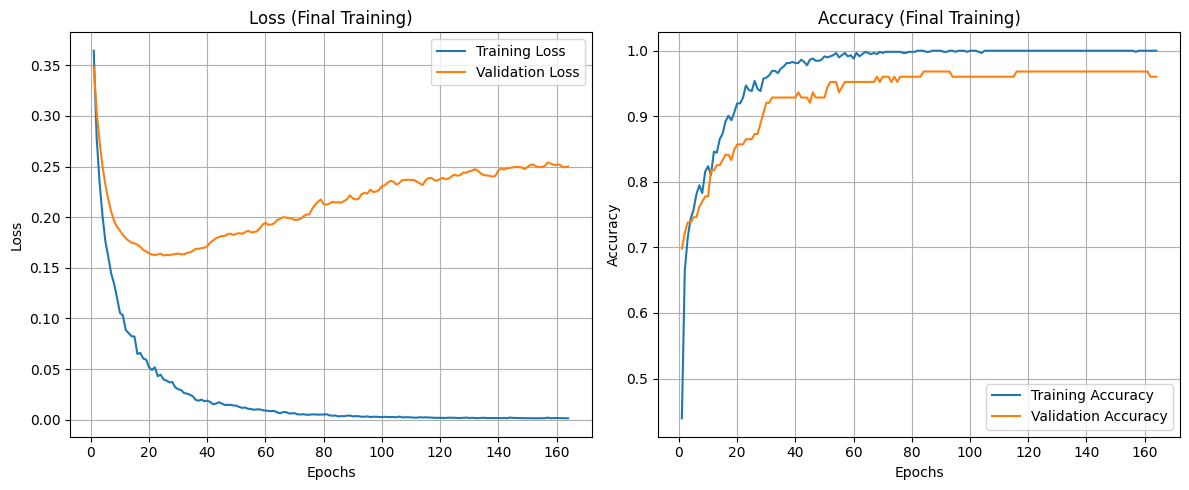


FINAL Confusion Matrix (Individual Classes):


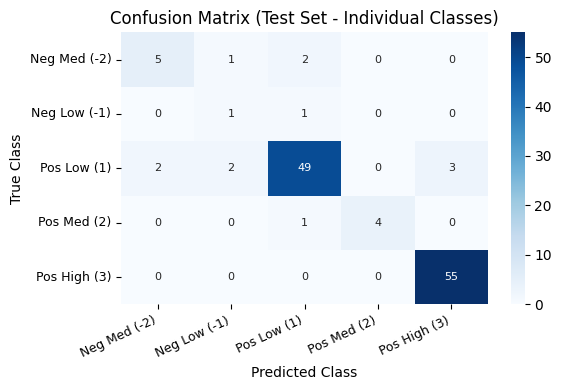


FINAL Confusion Matrix (Grouped Classes):


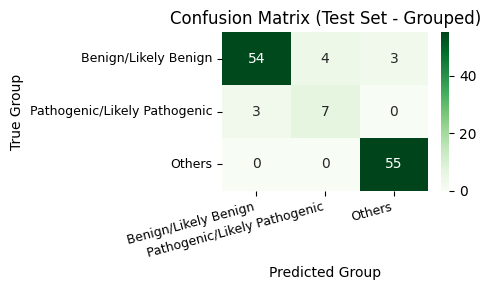


--- End of Plotting Script ---


In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd # For potential DataFrame display if seaborn fails

# Ensure variables from Cell 1 are accessible.
# These variables are:
# history, cm_final_data, target_names_display, eval_labels_display
# cm_grouped_data, target_names_grouped_display, unique_groups_final_data

print("\n--- Plotting Results ---")

# Check if history has data
if 'history' in locals() and history and history.get('train_loss') and history.get('val_loss'): # Check for val_loss too
    epochs_ran = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_ran, history['train_loss'], label='Training Loss')
    plt.plot(epochs_ran, history['val_loss'], label='Validation Loss')
    plt.title('Loss (Final Training)')
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

    plt.subplot(1, 2, 2)
    # Check if accuracy data is present, it might not be if training failed very early
    if history.get('train_acc') and history.get('val_acc'):
        plt.plot(epochs_ran, history['train_acc'], label='Training Accuracy')
        plt.plot(epochs_ran, history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy (Final Training)')
    plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()
else:
    print("No complete training history to plot (e.g., training failed or was skipped before first validation).")

# Plot Individual Class Confusion Matrix
if 'cm_final_data' in locals() and cm_final_data is not None and \
   'target_names_display' in locals() and target_names_display is not None and \
   'eval_labels_display' in locals() and eval_labels_display is not None:
    print("\nFINAL Confusion Matrix (Individual Classes):")
    try:
        plt.figure(figsize=(max(6, len(target_names_display)), max(4, len(target_names_display)-2)))
        sns.heatmap(cm_final_data, annot=True, fmt='d', cmap='Blues',
                    xticklabels=target_names_display, yticklabels=target_names_display,
                    annot_kws={"size": 8})
        plt.xlabel('Predicted Class'); plt.ylabel('True Class')
        plt.title('Confusion Matrix (Test Set - Individual Classes)')
        plt.xticks(rotation=25, ha='right', fontsize=9); plt.yticks(rotation=0, fontsize=9)
        plt.tight_layout(); plt.show()
    except ImportError:
        print("Seaborn not installed. Displaying CM as DataFrame or array.")
        print(pd.DataFrame(cm_final_data, index=target_names_display, columns=target_names_display) if 'pd' in locals() else cm_final_data)
    except Exception as e:
        print(f"Could not plot individual confusion matrix: {e}")
else:
    print("Data for individual confusion matrix is not available (cm_final_data might be None).")


# Plot Grouped Confusion Matrix
if 'cm_grouped_data' in locals() and cm_grouped_data is not None and \
   'target_names_grouped_display' in locals() and target_names_grouped_display is not None and \
   'unique_groups_final_data' in locals() and unique_groups_final_data is not None:
    print("\nFINAL Confusion Matrix (Grouped Classes):")
    try:
        plt.figure(figsize=(max(5, len(target_names_grouped_display)), max(3, len(target_names_grouped_display)-1)))
        sns.heatmap(cm_grouped_data, annot=True, fmt='d', cmap='Greens',
                    xticklabels=target_names_grouped_display, yticklabels=target_names_grouped_display,
                    annot_kws={"size": 10})
        plt.xlabel('Predicted Group'); plt.ylabel('True Group')
        plt.title('Confusion Matrix (Test Set - Grouped)')
        plt.xticks(rotation=15, ha='right', fontsize=9); plt.yticks(rotation=0, fontsize=9)
        plt.tight_layout(); plt.show()
    except ImportError:
        print("Seaborn not installed. Displaying grouped CM as DataFrame or array.")
        print(pd.DataFrame(cm_grouped_data, index=target_names_grouped_display, columns=target_names_grouped_display) if 'pd' in locals() else cm_grouped_data)
    except Exception as e:
        print(f"Could not plot grouped confusion matrix: {e}")
else:
    print("Data for grouped confusion matrix is not available (cm_grouped_data might be None).")

print("\n--- End of Plotting Script ---")

### Labeling SNPs that were labeled as uknown signficance!

Loading best model state into final_model...

Isolating and preprocessing samples originally labeled as 0...
Found 161 samples with original label 0.
Shape of preprocessed label 0 tensor: torch.Size([161, 6400])

Classifying the 'label 0' samples...

Plotting classification results for 'label 0' samples...


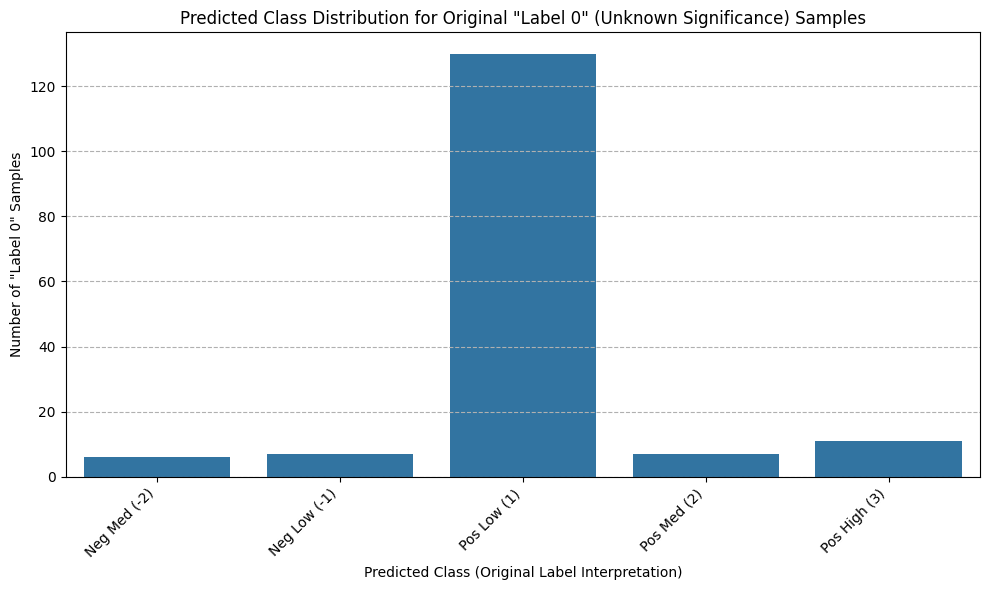


Summary of predictions for 'label 0' samples:
  Predicted as 'Neg Med (-2)' (Original: -2): 6 samples
  Predicted as 'Neg Low (-1)' (Original: -1): 7 samples
  Predicted as 'Pos Low (1)' (Original: 1): 130 samples
  Predicted as 'Pos Med (2)' (Original: 2): 7 samples
  Predicted as 'Pos High (3)' (Original: 3): 11 samples


In [45]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm # For progress bar if there are many samples

# --- 1. Ensure Model is Loaded with Best Weights and in Eval Mode ---
# This assumes 'final_model' and 'final_best_model_state_retrain' are from your previous successful run.
if 'final_model' not in locals() or 'final_best_model_state_retrain' not in locals():
    raise NameError("The 'final_model' or 'final_best_model_state_retrain' is not available. Please ensure the model training cell has been run successfully.")

if final_best_model_state_retrain:
    print("Loading best model state into final_model...")
    final_model.load_state_dict(final_best_model_state_retrain)
else:
    print("Warning: final_best_model_state_retrain is None. Using current state of final_model. Ensure it's the desired one.")

final_model.to(device) # Ensure model is on the correct device
final_model.eval()     # Set the model to evaluation mode

# --- 2. Isolate and Prepare "Label 0" Samples ---
print("\nIsolating and preprocessing samples originally labeled as 0...")

if 'X_fused' not in locals() or 'y_nn_esm2' not in locals():
    raise NameError("Original 'X_fused' or 'y_nn_esm2' data is not available.")
if 'scaler_dna' not in locals() or 'scaler_esm2' not in locals() or 'dna_embedding_dim' not in locals():
    raise NameError("Scalers ('scaler_dna', 'scaler_esm2') or 'dna_embedding_dim' not available.")

label0_indices = np.where(y_nn_esm2 == 0)[0]

if len(label0_indices) == 0:
    print("No samples with original label 0 found.")
else:
    X_label0_original_fused = X_fused[label0_indices]
    print(f"Found {len(X_label0_original_fused)} samples with original label 0.")

    # Separate into DNA and ESM-2 components for scaling
    X_label0_dna = X_label0_original_fused[:, :dna_embedding_dim]
    X_label0_esm2 = X_label0_original_fused[:, dna_embedding_dim:]

    # Apply the SAME scalers fitted on the training data
    X_label0_dna_scaled = scaler_dna.transform(X_label0_dna)
    X_label0_esm2_scaled = scaler_esm2.transform(X_label0_esm2)

    # Concatenate scaled components back together
    X_label0_fused_scaled = np.concatenate((X_label0_dna_scaled, X_label0_esm2_scaled), axis=1)
    
    # Convert to PyTorch Tensor
    X_label0_tensor = torch.tensor(X_label0_fused_scaled, dtype=torch.float32).to(device)
    print(f"Shape of preprocessed label 0 tensor: {X_label0_tensor.shape}")

    # --- 3. Perform Classification ---
    print("\nClassifying the 'label 0' samples...")
    predicted_label0_encoded_list = []
    with torch.no_grad(): # Ensure no gradients are calculated during inference
        # Process in batches if there are too many samples to fit in memory at once
        # For simplicity, this example processes all at once.
        # If you have many label 0 samples, you might wrap X_label0_tensor in a DataLoader.
        outputs_label0 = final_model(X_label0_tensor)
        _, predicted_label0_encoded = torch.max(outputs_label0.data, 1)
        predicted_label0_encoded_list.extend(predicted_label0_encoded.cpu().numpy())
    
    predicted_label0_encoded_np = np.array(predicted_label0_encoded_list)

    # --- 4. Interpret Predictions ---
    # The model predicts encoded labels. We need to map them back to original meaningful labels.
    if 'le' not in locals():
        raise NameError("'LabelEncoder' object 'le' is not available.")
    
    # These are the original labels the model was trained on (e.g., -3, -2, -1, 1, 2, 3)
    predicted_original_labels_for_label0 = le.inverse_transform(predicted_label0_encoded_np)
    
    # --- 5. Plot Results ---
    print("\nPlotting classification results for 'label 0' samples...")
    
    # Get unique predicted original labels and their counts
    unique_predicted_labels, counts = np.unique(predicted_original_labels_for_label0, return_counts=True)
    
    # For plotting, ensure we have names for these original labels
    # We can use the class_names_map from the previous script or derive from le.classes_ and target_names_display
    
    # Create a dictionary for easy lookup of counts for each of the model's known classes
    predicted_counts_map = dict(zip(unique_predicted_labels, counts))
    
    # Get the full list of possible original class labels the model was trained on
    # These are the labels that 'le' knows, which should correspond to target_names_display
    known_original_labels = le.classes_ # These are the original values like -3, -2, etc.
    
    # Get the display names for these known original labels
    # Ensure target_names_display aligns with le.classes_
    if 'target_names_display' not in locals() or len(target_names_display) != len(le.classes_):
        print("Warning: 'target_names_display' might not be correctly aligned. Using raw original labels for plot.")
        plot_labels = [str(l) for l in known_original_labels]
    else:
        # Create a mapping from original label value to its display name
        original_to_display_name_map = dict(zip(le.classes_, target_names_display))
        plot_labels = [original_to_display_name_map.get(l, str(l)) for l in known_original_labels]


    plot_counts = [predicted_counts_map.get(label, 0) for label in known_original_labels]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=plot_labels, y=plot_counts)
    plt.title('Predicted Class Distribution for Original "Label 0" (Unknown Significance) Samples')
    plt.xlabel('Predicted Class (Original Label Interpretation)')
    plt.ylabel('Number of "Label 0" Samples')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

    print("\nSummary of predictions for 'label 0' samples:")
    for i, original_label_val in enumerate(known_original_labels):
        display_name = plot_labels[i]
        count = plot_counts[i]
        print(f"  Predicted as '{display_name}' (Original: {original_label_val}): {count} samples")

# Clean up (optional, good practice if memory is a concern)
if 'X_label0_tensor' in locals(): del X_label0_tensor
if 'outputs_label0' in locals(): del outputs_label0
gc.collect()
if torch.cuda.is_available(): torch.cuda.empty_cache()

#### It looks like vast majoriy of uknonwn signficance ones are likely benign!

### Predicting


--- Loading Best Model for Prediction ---
Loading model from: best_model_20250409_012631.pt
First loading attempt failed: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy.dtype was not an allowed global by default. Please use `torch.serialization.add_safe_globals([dtype])` or the `torch.serialization.safe_globals([dtype])` context manager to allowlist this global if you trust this class/function.

Check the docum

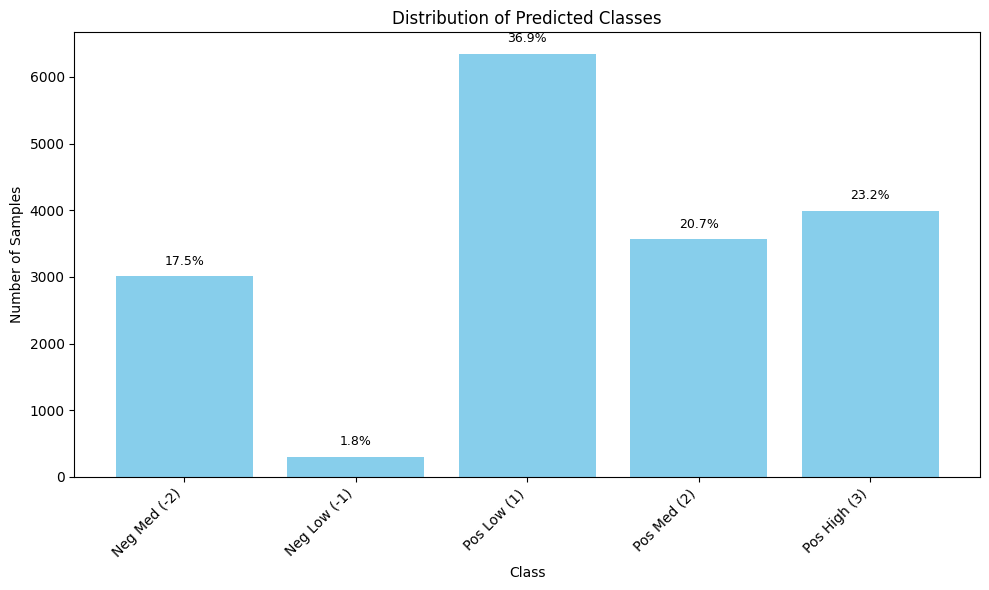

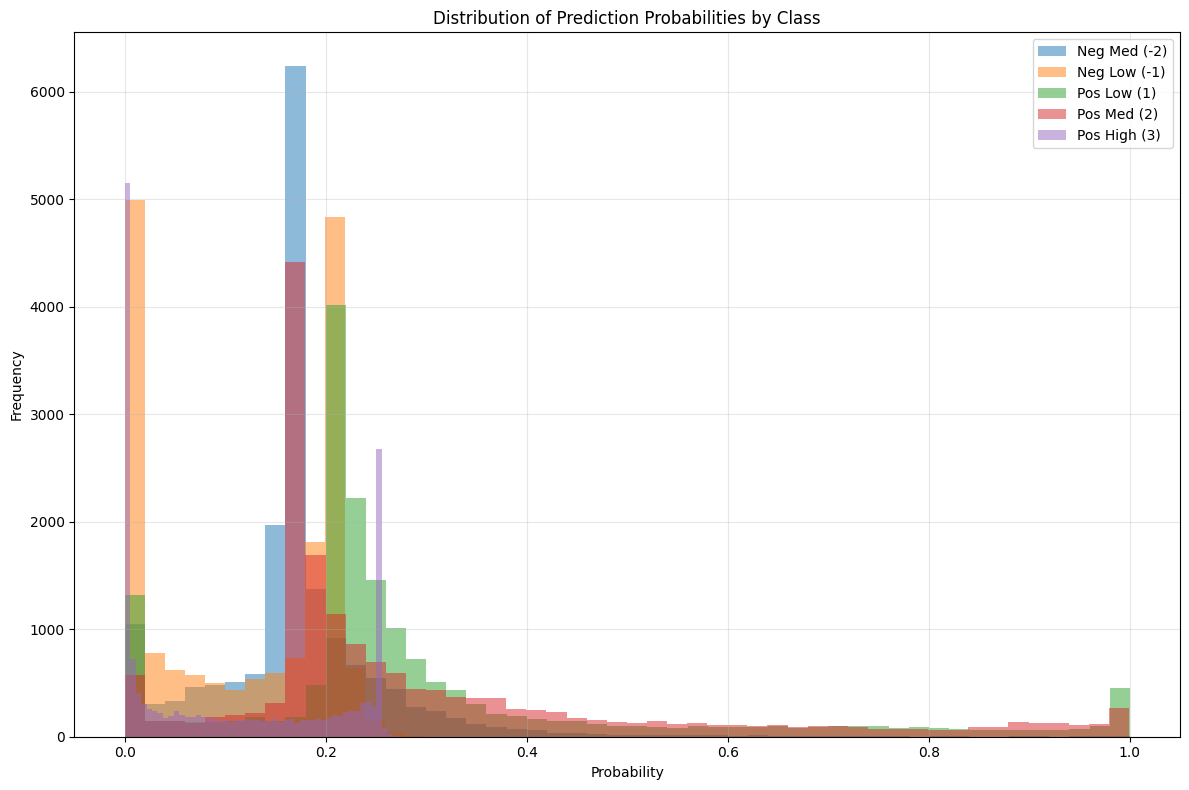

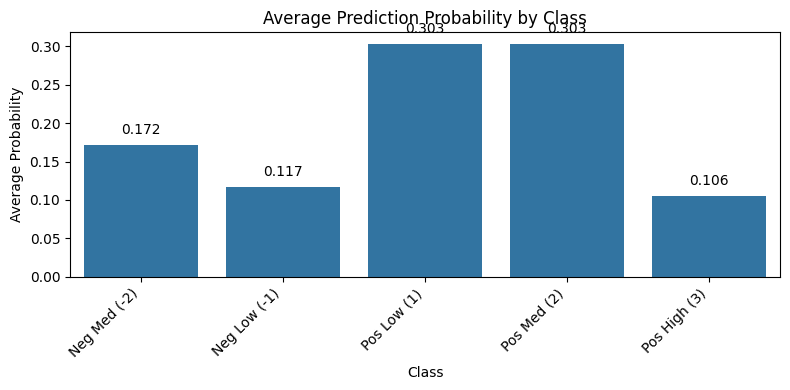


--- Prediction Complete ---


In [25]:
# --- Load the Best Model for Prediction ---
print("\n--- Loading Best Model for Prediction ---")
import glob
import os

# Find the most recent model file
model_files = glob.glob("best_model_*.pt")
if not model_files:
    raise FileNotFoundError("No saved model files found. Please train and save a model first.")

latest_model = max(model_files, key=os.path.getctime)
print(f"Loading model from: {latest_model}")

# Load the model with weights_only=False to handle numpy.core.multiarray.scalar
try:
    # First try to add the numpy scalar to safe globals
    import numpy as np
    from torch.serialization import add_safe_globals
    add_safe_globals([np.core.multiarray.scalar])
    loaded_dict = torch.load(latest_model)
except Exception as e:
    print(f"First loading attempt failed: {e}")
    print("Trying alternative loading method with weights_only=False...")
    # If that fails, use weights_only=False (only for trusted files)
    loaded_dict = torch.load(latest_model, weights_only=False)

print("Model loaded successfully!")

# Extract model parameters
loaded_input_dim = loaded_dict['input_dim']
loaded_hidden_dims = loaded_dict['hidden_dims']
loaded_output_dim = loaded_dict['output_dim']
loaded_dropout_rate = loaded_dict['dropout_rate']
loaded_activation_fn = nn.LeakyReLU if loaded_dict['activation_fn'] == 'LeakyReLU' else nn.ReLU
loaded_class_mapping = loaded_dict['class_mapping']
loaded_target_names = loaded_dict['target_names']
loaded_scaler_dna = loaded_dict['scaler_dna']
loaded_scaler_esm2 = loaded_dict['scaler_esm2']
loaded_dna_dim = loaded_dict['dna_embedding_dim']
loaded_esm2_dim = loaded_dict['esm2_embedding_dim']

print(f"Model architecture: {loaded_input_dim} → {loaded_hidden_dims} → {loaded_output_dim}")
print(f"Class mapping: {loaded_class_mapping}")

# Recreate the model architecture
prediction_model = SimpleClassifier(
    input_dim=loaded_input_dim,
    hidden_dims=loaded_hidden_dims,
    output_dim=loaded_output_dim,
    dropout_rate=loaded_dropout_rate,
    activation_fn=loaded_activation_fn
)

# Load the weights
prediction_model.load_state_dict(loaded_dict['model_state_dict'])
prediction_model.to(device)
prediction_model.eval()

# --- Prepare Data for Prediction ---
print("\n--- Preparing Data for Prediction ---")

# Scale the data using the loaded scalers
X_dna = X_fused[:, :loaded_dna_dim]
X_esm2 = X_fused[:, loaded_dna_dim:]

X_dna_scaled = loaded_scaler_dna.transform(X_dna)
X_esm2_scaled = loaded_scaler_esm2.transform(X_esm2)

X_fused_scaled = np.concatenate((X_dna_scaled, X_esm2_scaled), axis=1)
X_fused_tensor = torch.tensor(X_fused_scaled, dtype=torch.float32)

# --- Make Predictions ---
print("\n--- Making Predictions ---")
prediction_model.eval()
all_probs = []

with torch.no_grad():
    # Process in batches to avoid memory issues
    batch_size = 128
    for i in range(0, len(X_fused_tensor), batch_size):
        batch = X_fused_tensor[i:i+batch_size].to(device)
        outputs = prediction_model(batch)
        probs = F.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())

# Concatenate all batches
all_probs = np.vstack(all_probs)

# Get predicted classes
predicted_classes = np.argmax(all_probs, axis=1)

# Find pathogenic class index (Neg Med, -2)
pathogenic_idx = None
for idx, orig_label in loaded_class_mapping.items():
    if orig_label == -2:
        pathogenic_idx = idx
        print(f"Found pathogenic class index: {idx} (original label: {orig_label})")
        break

# Apply pathogenic probability threshold rule
if pathogenic_idx is not None:
    print(f"\nApplying pathogenic probability threshold rule (>0.22 for class index {pathogenic_idx})...")
    
    # Get pathogenic probabilities
    pathogenic_probs = all_probs[:, pathogenic_idx]
    
    # Create modified predictions based on the rule
    modified_predictions = predicted_classes.copy()
    
    # Apply the rule: if pathogenic probability > 0.22, predict as pathogenic
    threshold_mask = pathogenic_probs > 0.22
    modified_predictions[threshold_mask] = pathogenic_idx
    
    # Count changes
    changes = np.sum(modified_predictions != predicted_classes)
    print(f"Modified {changes} predictions ({changes/len(predicted_classes)*100:.2f}%) based on pathogenic probability threshold")
    
    # Use the modified predictions
    predicted_classes = modified_predictions

# --- Analyze and Visualize Results ---
print("\n--- Prediction Results ---")

# Convert numeric predictions to original labels
predicted_original_labels = [loaded_class_mapping[pred] for pred in predicted_classes]

# Count occurrences of each class
class_counts = {}
for i in range(loaded_output_dim):
    class_name = loaded_target_names[i]
    count = np.sum(predicted_classes == i)
    percentage = (count / len(predicted_classes)) * 100
    class_counts[class_name] = (count, percentage)
    print(f"Class {class_name}: {count} samples ({percentage:.2f}%)")

# Plot class distribution
plt.figure(figsize=(10, 6))
classes = list(class_counts.keys())
counts = [class_counts[c][0] for c in classes]
percentages = [class_counts[c][1] for c in classes]

plt.bar(classes, counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Predicted Classes')
plt.xticks(rotation=45, ha='right')

# Add percentage labels on top of bars
for i, (count, percentage) in enumerate(zip(counts, percentages)):
    plt.text(i, count + (max(counts) * 0.02), f"{percentage:.1f}%", 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Plot probability distribution for each class
plt.figure(figsize=(12, 8))
for i in range(loaded_output_dim):
    class_probs = all_probs[:, i]
    plt.hist(class_probs, bins=50, alpha=0.5, label=loaded_target_names[i])

plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Probabilities by Class')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create a heatmap of average probabilities
avg_probs = np.mean(all_probs, axis=0)
plt.figure(figsize=(8, 4))
sns.barplot(x=loaded_target_names, y=avg_probs)
plt.xlabel('Class')
plt.ylabel('Average Probability')
plt.title('Average Prediction Probability by Class')
plt.xticks(rotation=45, ha='right')
for i, prob in enumerate(avg_probs):
    plt.text(i, prob + 0.01, f"{prob:.3f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

print("\n--- Prediction Complete ---")


In [24]:
import seaborn as sns


--- Pathogenic Probability Analysis ---


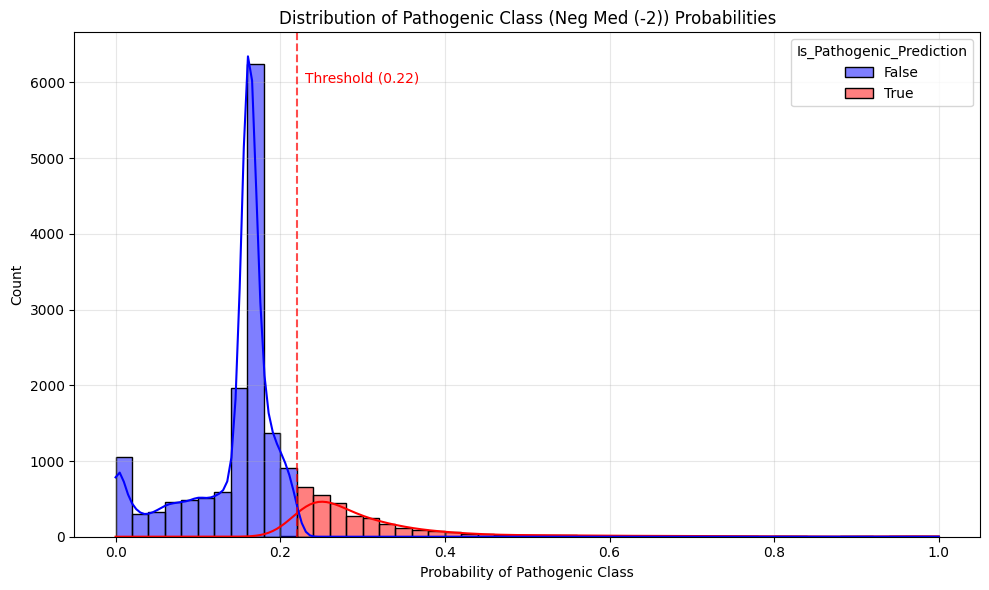

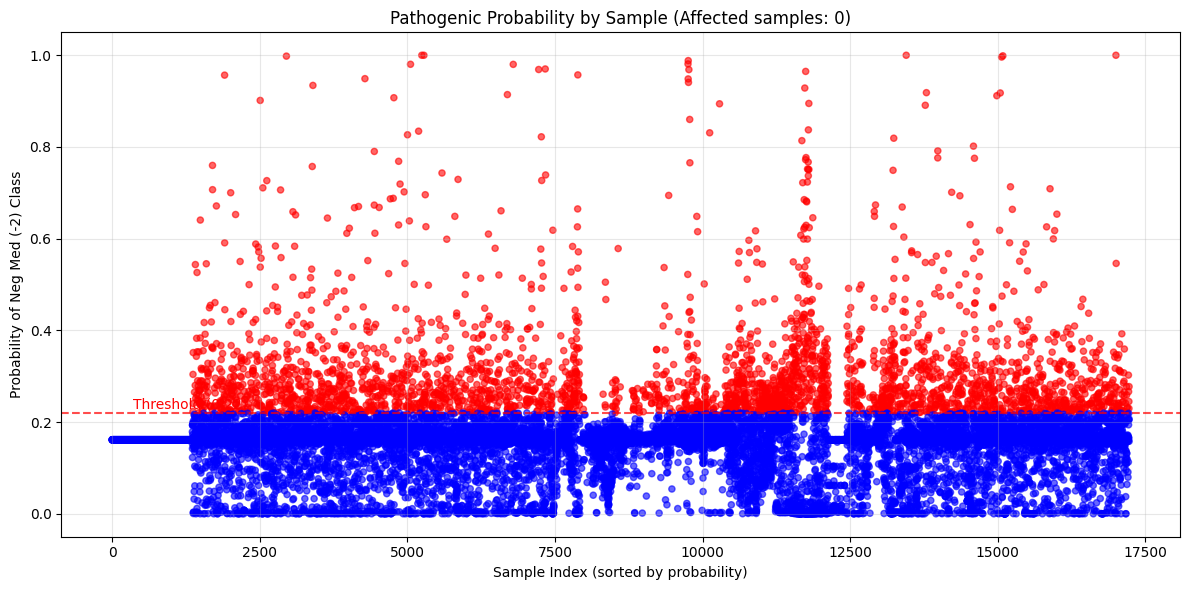

In [26]:
# --- Plot Pathogenic Probability Analysis ---
print("\n--- Pathogenic Probability Analysis ---")

# Find pathogenic class index (Neg Med, -2)
pathogenic_idx = None
for idx, orig_label in loaded_class_mapping.items():
    if orig_label == -2:
        pathogenic_idx = idx
        break

if pathogenic_idx is not None:
    # Get pathogenic probabilities
    pathogenic_probs = all_probs[:, pathogenic_idx]
    
    # Create a DataFrame for easier plotting
    import pandas as pd
    plot_df = pd.DataFrame({
        'Sample_Index': range(len(pathogenic_probs)),
        'Pathogenic_Probability': pathogenic_probs,
        'Predicted_Class': predicted_classes,
        'Is_Pathogenic_Prediction': predicted_classes == pathogenic_idx
    })
    
    # Sort by pathogenic probability for better visualization
    plot_df = plot_df.sort_values('Pathogenic_Probability', ascending=False)
    
    # Plot the distribution of pathogenic probabilities
    plt.figure(figsize=(10, 6))
    sns.histplot(data=plot_df, x='Pathogenic_Probability', hue='Is_Pathogenic_Prediction', 
                 bins=50, kde=True, palette=['blue', 'red'])
    
    # Add a vertical line at the 0.22 threshold
    plt.axvline(x=0.22, color='red', linestyle='--', alpha=0.7)
    plt.text(0.23, plt.ylim()[1]*0.9, 'Threshold (0.22)', color='red', fontsize=10)
    
    plt.title(f'Distribution of Pathogenic Class ({loaded_target_names[pathogenic_idx]}) Probabilities')
    plt.xlabel('Probability of Pathogenic Class')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot samples by their pathogenic probability
    plt.figure(figsize=(12, 6))
    plt.scatter(plot_df['Sample_Index'], plot_df['Pathogenic_Probability'], 
                c=plot_df['Is_Pathogenic_Prediction'].map({True: 'red', False: 'blue'}),
                alpha=0.6, s=20)
    
    # Add a horizontal line at the 0.22 threshold
    plt.axhline(y=0.22, color='red', linestyle='--', alpha=0.7)
    plt.text(plt.xlim()[1]*0.02, 0.23, 'Threshold (0.22)', color='red', fontsize=10)
    
    # Count samples above threshold but not classified as pathogenic
    above_threshold = (pathogenic_probs > 0.22)
    not_classified_as_pathogenic = (predicted_classes != pathogenic_idx)
    affected_samples = np.sum(above_threshold & not_classified_as_pathogenic)
    
    plt.title(f'Pathogenic Probability by Sample (Affected samples: {affected_samples})')
    plt.xlabel('Sample Index (sorted by probability)')
    plt.ylabel(f'Probability of {loaded_target_names[pathogenic_idx]} Class')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Pathogenic class (Neg Med, -2) not found in class mapping.")


### testing another model

In [32]:
# Load the best model for inference
print("Loading the best model for inference...")

# Define the model architecture (same as the trained model)
inference_model = SimpleClassifier(
    input_dim=fused_input_dim,  # Use the same fused dimension
    hidden_dims=best_params['hidden_dims'],
    output_dim=num_classes,
    dropout_rate=best_params['dropout_rate'],
    activation_fn=final_activation
)

# Load the best model state
inference_model.load_state_dict(final_best_model_state_retrain)
inference_model.to(device)
inference_model.eval()  # Set to evaluation mode

print(f"Model loaded successfully with input dimension: {fused_input_dim}")

# Function to prepare and predict new data
def predict_with_model(dna_embeddings, esm2_embeddings):
    """
    Make predictions using the loaded model with a 0.5 threshold for class 3.
    """
    # Ensure inputs are numpy arrays
    if isinstance(dna_embeddings, torch.Tensor):
        dna_embeddings = dna_embeddings.numpy()
    if isinstance(esm2_embeddings, torch.Tensor):
        esm2_embeddings = esm2_embeddings.numpy()
    
    # Scale the embeddings using the same scalers used during training
    dna_scaled = scaler_dna.transform(dna_embeddings)
    esm2_scaled = scaler_esm2.transform(esm2_embeddings)
    
    # Concatenate the scaled embeddings
    fused_embeddings = np.concatenate((dna_scaled, esm2_scaled), axis=1)
    
    # Convert to tensor and move to device
    input_tensor = torch.tensor(fused_embeddings, dtype=torch.float32).to(device)
    
    # Make predictions
    with torch.no_grad():
        outputs = inference_model(input_tensor)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
    
    # Get numpy arrays from tensors
    predicted_classes = predicted.cpu().numpy()
    class_probabilities = probabilities.cpu().numpy()
    
    # Apply threshold for class 3
    class_3_predictions = predicted_classes.copy()
    class_3_probs = class_probabilities[:, num_classes-1]  # Class 3 is at the last index
    threshold_mask = class_3_probs > 0.5
    class_3_predictions[threshold_mask] = num_classes-1
    
    return predicted_classes, class_probabilities, class_3_predictions


# Function to interpret predictions
def interpret_predictions(predicted_classes, pathogenic_predictions=None):
    """
    Convert numeric predictions to original class labels and names.
    
    Args:
        predicted_classes: Numeric class predictions
        pathogenic_predictions: Predictions after applying pathogenic threshold (optional)
    
    Returns:
        DataFrame with predictions and their interpretations
    """
    results = []
    
    for i, pred in enumerate(predicted_classes):
        original_label = le.classes_[pred]
        class_name = class_names.get(original_label, f'Unknown({original_label})')
        
        result = {
            'Sample': i,
            'Predicted_Class_Index': pred,
            'Original_Label': original_label,
            'Class_Name': class_name
        }
        
        if pathogenic_predictions is not None:
            path_pred = pathogenic_predictions[i]
            if path_pred != pred:
                path_original_label = le.classes_[path_pred]
                path_class_name = class_names.get(path_original_label, f'Unknown({path_original_label})')
                result['Pathogenic_Rule_Applied'] = True
                result['Pathogenic_Class_Index'] = path_pred
                result['Pathogenic_Original_Label'] = path_original_label
                result['Pathogenic_Class_Name'] = path_class_name
            else:
                result['Pathogenic_Rule_Applied'] = False
        
        results.append(result)
    
    return pd.DataFrame(results)

print("Model and prediction functions are ready for inference.")
print(f"Number of classes: {num_classes}")
print(f"Class mapping: {class_names}")


Loading the best model for inference...


NameError: name 'fused_input_dim' is not defined

Making predictions on test data...
Test predictions summary:


Sample  Predicted_Class_Index  Original_Label    Class_Name  \
0       0                      4               3  Pos High (3)   
1       1                      4               3  Pos High (3)   
2       2                      4               3  Pos High (3)   
3       3                      4               3  Pos High (3)   
4       4                      4               3  Pos High (3)   

   Pathogenic_Rule_Applied  
0                    False  
1                    False  
2                    False  
3                    False  
4                    False

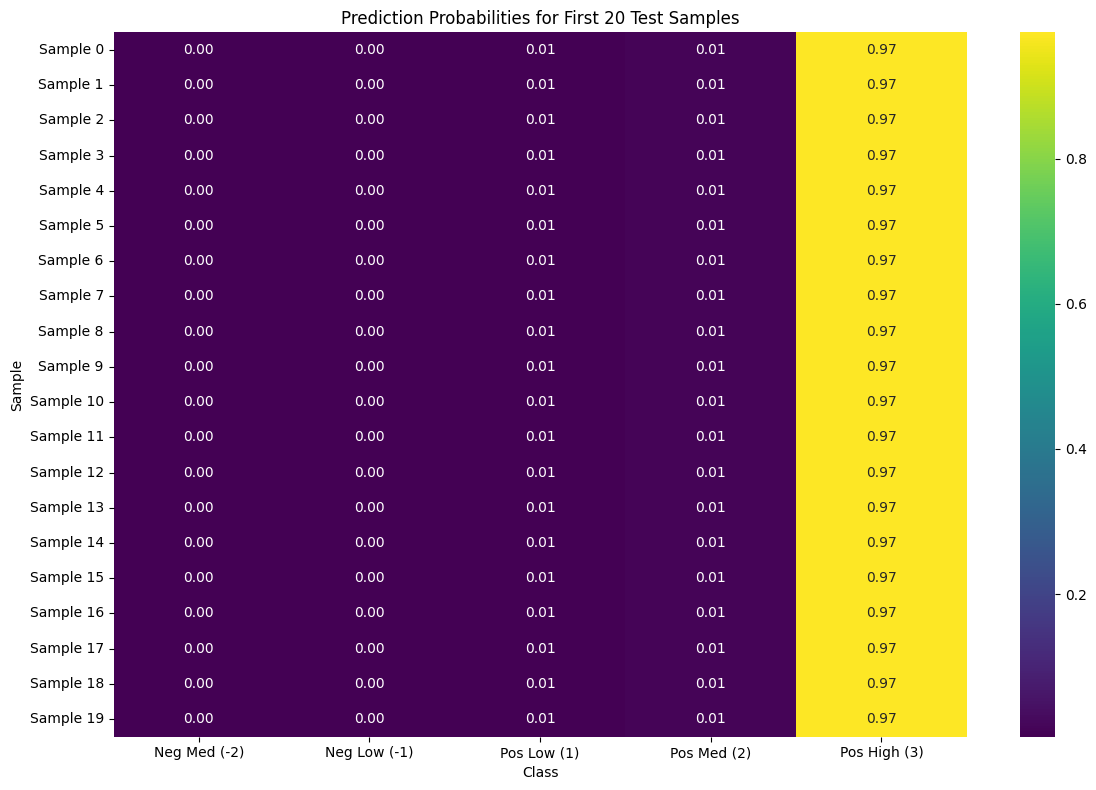

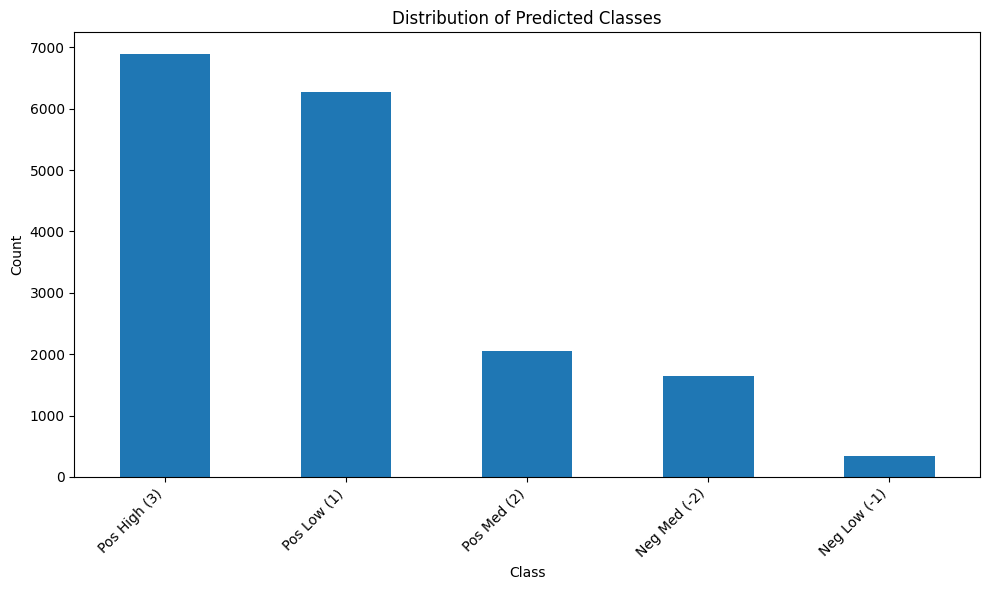

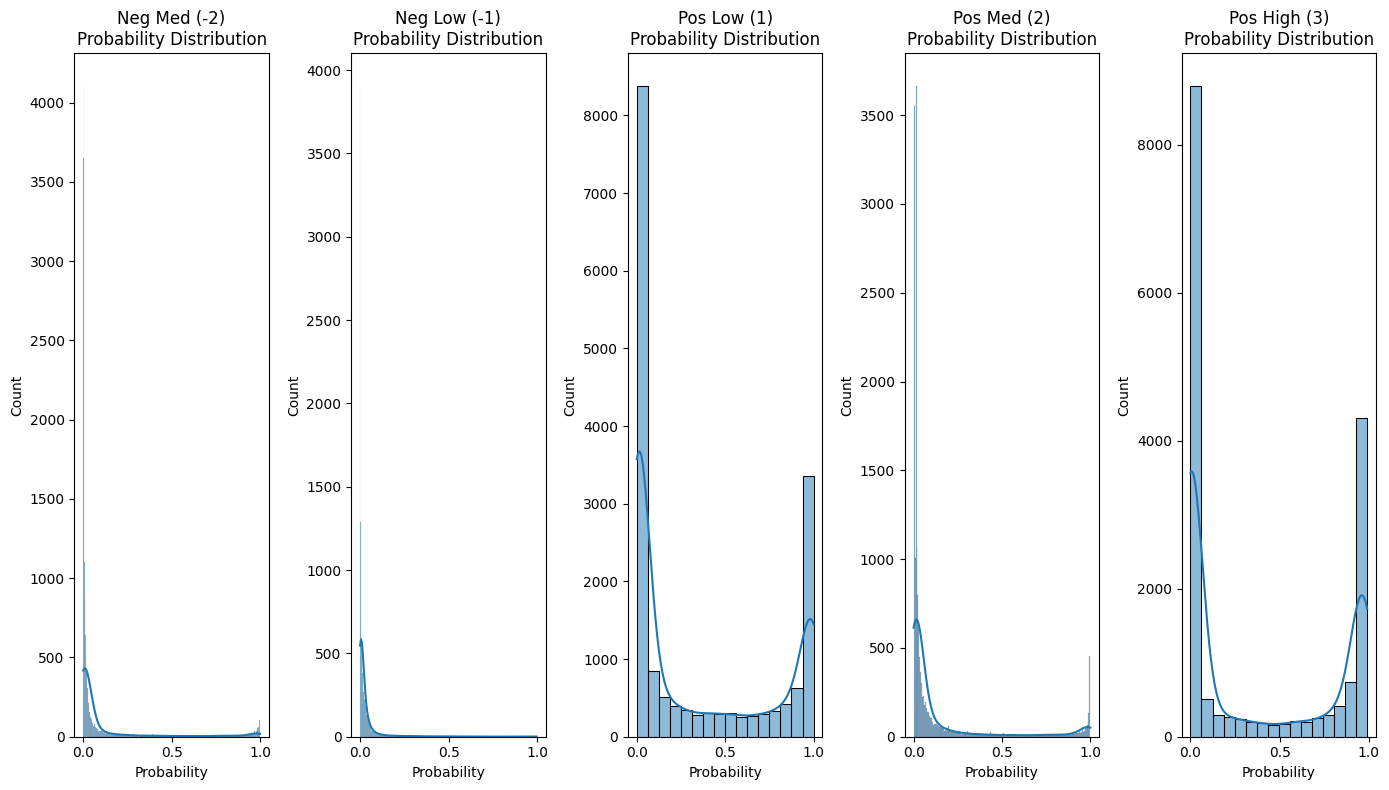

<Figure size 1000x600 with 0 Axes>

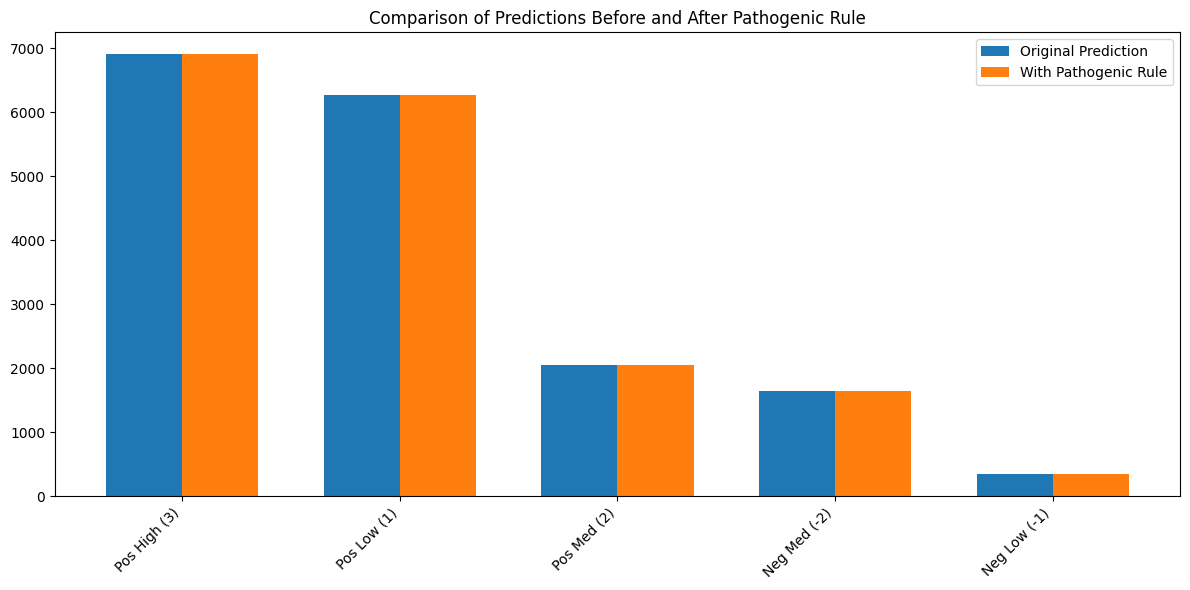

Confidence metrics for each class:


Class  Mean Probability  Max Probability  Min Probability  \
0  Neg Med (-2)          0.104978         1.000000     3.322915e-18   
1  Neg Low (-1)          0.036420         0.997347     6.172195e-27   
2   Pos Low (1)          0.347901         1.000000     2.416700e-25   
3   Pos Med (2)          0.138217         1.000000     1.197476e-19   
4  Pos High (3)          0.372483         0.991353     3.370969e-34   

   Std Deviation  
0       0.243751  
1       0.103831  
2       0.408323  
3       0.275402  
4       0.430591

In [37]:
# Predict using the test data
print("Making predictions on test data...")

# Get predictions for test data
test_predictions, test_probabilities, test_pathogenic_predictions = predict_with_model(
    X_nn, X_nn_esm2
)

# Interpret the predictions
test_results_df = interpret_predictions(test_predictions, test_pathogenic_predictions)
print("Test predictions summary:")
display(test_results_df.head())

# Plot prediction probabilities for each class
plt.figure(figsize=(12, 8))
class_names_list = [class_names.get(le.classes_[i], f'Class {i}') for i in range(num_classes)]

# Create a heatmap of probabilities for each sample
sns.heatmap(
    test_probabilities[:20],  # Show first 20 samples for clarity
    annot=True,
    fmt='.2f',
    cmap='viridis',
    xticklabels=class_names_list,
    yticklabels=[f'Sample {i}' for i in range(20)]
)
plt.title('Prediction Probabilities for First 20 Test Samples')
plt.xlabel('Class')
plt.ylabel('Sample')
plt.tight_layout()
plt.show()

# Plot distribution of predicted classes
plt.figure(figsize=(10, 6))
test_results_df['Class_Name'].value_counts().plot(kind='bar')
plt.title('Distribution of Predicted Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot probability distributions for each class
plt.figure(figsize=(14, 8))
for i in range(num_classes):
    plt.subplot(1, num_classes, i+1)
    sns.histplot(test_probabilities[:, i], kde=True)
    plt.title(f'{class_names_list[i]}\nProbability Distribution')
    plt.xlabel('Probability')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Compare original vs pathogenic rule predictions if applicable
if pathogenic_class_indices:
    plt.figure(figsize=(10, 6))
    labels = ['Original Prediction', 'With Pathogenic Rule']
    counts = [
        test_results_df['Class_Name'].value_counts(),
        test_results_df.get('Pathogenic_Class_Name', test_results_df['Class_Name']).value_counts()
    ]
    
    x = np.arange(len(counts[0].index))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, counts[0].values, width, label=labels[0])
    ax.bar(x + width/2, counts[1].values, width, label=labels[1])
    
    ax.set_xticks(x)
    ax.set_xticklabels(counts[0].index, rotation=45, ha='right')
    ax.legend()
    ax.set_title('Comparison of Predictions Before and After Pathogenic Rule')
    plt.tight_layout()
    plt.show()

# Calculate and display confidence metrics
confidence_metrics = pd.DataFrame({
    'Class': class_names_list,
    'Mean Probability': [test_probabilities[:, i].mean() for i in range(num_classes)],
    'Max Probability': [test_probabilities[:, i].max() for i in range(num_classes)],
    'Min Probability': [test_probabilities[:, i].min() for i in range(num_classes)],
    'Std Deviation': [test_probabilities[:, i].std() for i in range(num_classes)]
})

print("Confidence metrics for each class:")
display(confidence_metrics)

### Whatsupp


--- Loading Best Model for Prediction ---
Loading model from: best_model_20250409_012631.pt
First loading attempt failed: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy.dtype was not an allowed global by default. Please use `torch.serialization.add_safe_globals([dtype])` or the `torch.serialization.safe_globals([dtype])` context manager to allowlist this global if you trust this class/function.

Check the docum

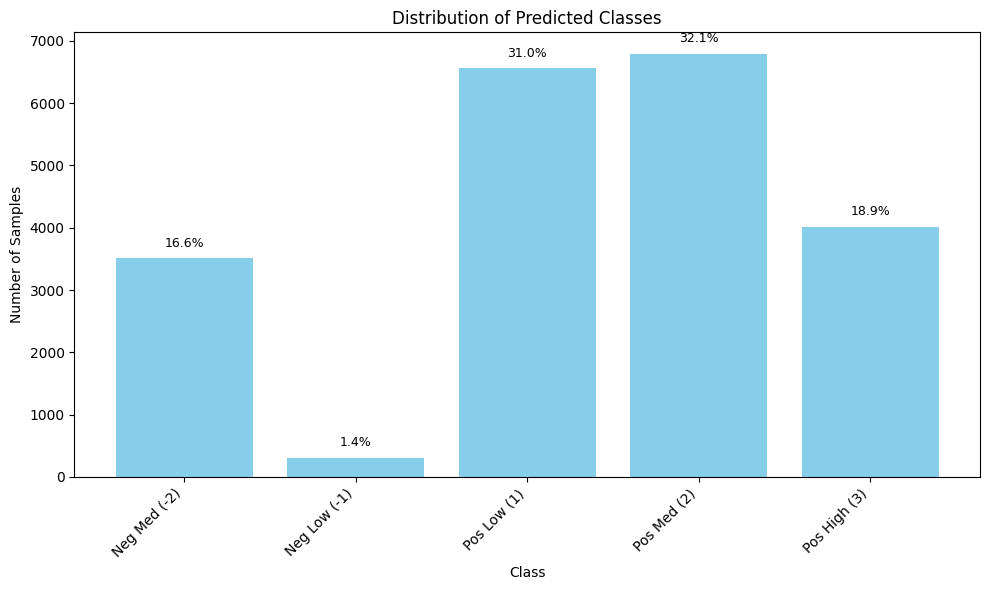

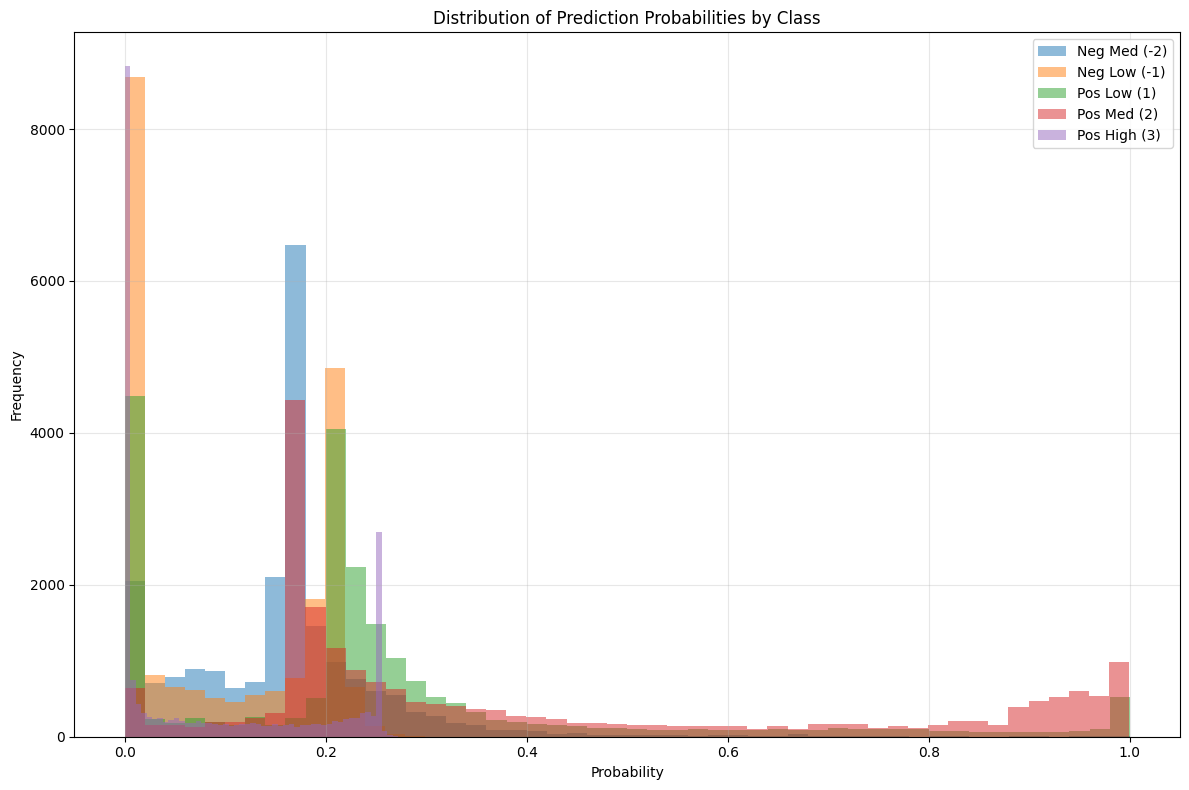

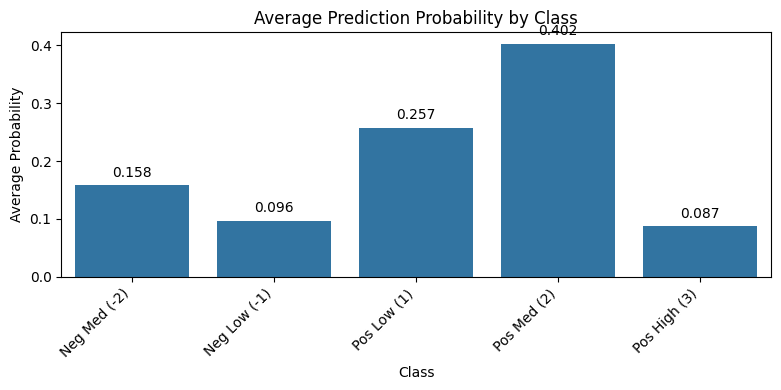


--- Prediction Complete ---


In [38]:
# --- Load the Best Model for Prediction ---
print("\n--- Loading Best Model for Prediction ---")
import glob
import os

# Find the most recent model file
model_files = glob.glob("best_model_*.pt")
if not model_files:
    raise FileNotFoundError("No saved model files found. Please train and save a model first.")

latest_model = max(model_files, key=os.path.getctime)
print(f"Loading model from: {latest_model}")

# Load the model with weights_only=False to handle numpy.core.multiarray.scalar
try:
    # First try to add the numpy scalar to safe globals
    import numpy as np
    from torch.serialization import add_safe_globals
    add_safe_globals([np.core.multiarray.scalar])
    loaded_dict = torch.load(latest_model)
except Exception as e:
    print(f"First loading attempt failed: {e}")
    print("Trying alternative loading method with weights_only=False...")
    # If that fails, use weights_only=False (only for trusted files)
    loaded_dict = torch.load(latest_model, weights_only=False)

print("Model loaded successfully!")

# Extract model parameters
loaded_input_dim = loaded_dict['input_dim']
loaded_hidden_dims = loaded_dict['hidden_dims']
loaded_output_dim = loaded_dict['output_dim']
loaded_dropout_rate = loaded_dict['dropout_rate']
loaded_activation_fn = nn.LeakyReLU if loaded_dict['activation_fn'] == 'LeakyReLU' else nn.ReLU
loaded_class_mapping = loaded_dict['class_mapping']
loaded_target_names = loaded_dict['target_names']
loaded_scaler_dna = loaded_dict['scaler_dna']
loaded_scaler_esm2 = loaded_dict['scaler_esm2']
loaded_dna_dim = loaded_dict['dna_embedding_dim']
loaded_esm2_dim = loaded_dict['esm2_embedding_dim']

print(f"Model architecture: {loaded_input_dim} → {loaded_hidden_dims} → {loaded_output_dim}")
print(f"Class mapping: {loaded_class_mapping}")

# Recreate the model architecture
prediction_model = SimpleClassifier(
    input_dim=loaded_input_dim,
    hidden_dims=loaded_hidden_dims,
    output_dim=loaded_output_dim,
    dropout_rate=loaded_dropout_rate,
    activation_fn=loaded_activation_fn
)

# Load the weights
prediction_model.load_state_dict(loaded_dict['model_state_dict'])
prediction_model.to(device)
prediction_model.eval()

# --- Prepare Data for Prediction ---
print("\n--- Preparing Data for Prediction ---")

# Scale the data using the loaded scalers
X_dna = X_fused[:, :loaded_dna_dim]
X_esm2 = X_fused[:, loaded_dna_dim:]

X_dna_scaled = loaded_scaler_dna.transform(X_dna)
X_esm2_scaled = loaded_scaler_esm2.transform(X_esm2)

X_fused_scaled = np.concatenate((X_dna_scaled, X_esm2_scaled), axis=1)
X_fused_tensor = torch.tensor(X_fused_scaled, dtype=torch.float32)

# --- Make Predictions ---
print("\n--- Making Predictions ---")
prediction_model.eval()
all_probs = []

with torch.no_grad():
    # Process in batches to avoid memory issues
    batch_size = 128
    for i in range(0, len(X_fused_tensor), batch_size):
        batch = X_fused_tensor[i:i+batch_size].to(device)
        outputs = prediction_model(batch)
        probs = F.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())

# Concatenate all batches
all_probs = np.vstack(all_probs)

# Get predicted classes
predicted_classes = np.argmax(all_probs, axis=1)

# Find pathogenic class index (Neg Med, -2)
pathogenic_idx = None
for idx, orig_label in loaded_class_mapping.items():
    if orig_label == -2:
        pathogenic_idx = idx
        print(f"Found pathogenic class index: {idx} (original label: {orig_label})")
        break

# Apply pathogenic probability threshold rule
if pathogenic_idx is not None:
    print(f"\nApplying pathogenic probability threshold rule (>0.22 for class index {pathogenic_idx})...")
    
    # Get pathogenic probabilities
    pathogenic_probs = all_probs[:, pathogenic_idx]
    
    # Create modified predictions based on the rule
    modified_predictions = predicted_classes.copy()
    
    # Apply the rule: if pathogenic probability > 0.22, predict as pathogenic
    threshold_mask = pathogenic_probs > 0.22
    modified_predictions[threshold_mask] = pathogenic_idx
    
    # Count changes
    changes = np.sum(modified_predictions != predicted_classes)
    print(f"Modified {changes} predictions ({changes/len(predicted_classes)*100:.2f}%) based on pathogenic probability threshold")
    
    # Use the modified predictions
    predicted_classes = modified_predictions

# --- Analyze and Visualize Results ---
print("\n--- Prediction Results ---")

# Convert numeric predictions to original labels
predicted_original_labels = [loaded_class_mapping[pred] for pred in predicted_classes]

# Count occurrences of each class
class_counts = {}
for i in range(loaded_output_dim):
    class_name = loaded_target_names[i]
    count = np.sum(predicted_classes == i)
    percentage = (count / len(predicted_classes)) * 100
    class_counts[class_name] = (count, percentage)
    print(f"Class {class_name}: {count} samples ({percentage:.2f}%)")

# Plot class distribution
plt.figure(figsize=(10, 6))
classes = list(class_counts.keys())
counts = [class_counts[c][0] for c in classes]
percentages = [class_counts[c][1] for c in classes]

plt.bar(classes, counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Predicted Classes')
plt.xticks(rotation=45, ha='right')

# Add percentage labels on top of bars
for i, (count, percentage) in enumerate(zip(counts, percentages)):
    plt.text(i, count + (max(counts) * 0.02), f"{percentage:.1f}%", 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Plot probability distribution for each class
plt.figure(figsize=(12, 8))
for i in range(loaded_output_dim):
    class_probs = all_probs[:, i]
    plt.hist(class_probs, bins=50, alpha=0.5, label=loaded_target_names[i])

plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Probabilities by Class')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create a heatmap of average probabilities
avg_probs = np.mean(all_probs, axis=0)
plt.figure(figsize=(8, 4))
sns.barplot(x=loaded_target_names, y=avg_probs)
plt.xlabel('Class')
plt.ylabel('Average Probability')
plt.title('Average Prediction Probability by Class')
plt.xticks(rotation=45, ha='right')
for i, prob in enumerate(avg_probs):
    plt.text(i, prob + 0.01, f"{prob:.3f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

print("\n--- Prediction Complete ---")


In [44]:
# Export predictions with SNP IDs and probabilities
print("\n--- Exporting Predictions ---")

# Create a DataFrame with predictions and probabilities
prediction_df = pd.DataFrame({
    'snp_id': df_test['snp_id'],
    'variation': df_test['variation'],
    'variant_type': df_test['variant_type'],
    'original_clinical_sig': df_test['original_clinical_sig'],
    'function_class': df_test['function_class'],
    'protein_sequence': df_test['protein_sequence']
})

# Add probability columns for each class
for i, class_name in enumerate(loaded_target_names):
    prediction_df[f'prob_{class_name}'] = all_probs[:, i]

# Export to CSV
predictions_file = 'dna_bert_predictions.csv'
prediction_df.to_csv(predictions_file, index=False)
print(f"Predictions exported to {predictions_file}")

# Create a second file with SNP IDs that have >50% probability of being class -2 (Neg Med) or pathogenic
# Find the index for "Neg Med (-2)" class
neg_med_idx = loaded_target_names.index("Neg Med (-2)") if "Neg Med (-2)" in loaded_target_names else None

if neg_med_idx is not None:
    # Filter SNPs with >50% probability of being class -2
    pathogenic_mask = all_probs[:, neg_med_idx] > 0.5
    pathogenic_snps = df_test.loc[pathogenic_mask, 'snp_id']
    
    # Create DataFrame for pathogenic SNPs
    pathogenic_df = pd.DataFrame({
        'snp_id': pathogenic_snps,
        'variation': df_test.loc[pathogenic_mask, 'variation'],
        'variant_type': df_test.loc[pathogenic_mask, 'variant_type'],
        'original_clinical_sig': df_test.loc[pathogenic_mask, 'original_clinical_sig'],
        'function_class': df_test.loc[pathogenic_mask, 'function_class'],
        'protein_sequence': df_test.loc[pathogenic_mask, 'protein_sequence'],
        'probability': all_probs[pathogenic_mask, neg_med_idx]
    })
    
    # Export pathogenic SNPs to CSV
    pathogenic_file = 'pathogenic_snps.csv'
    pathogenic_df.to_csv(pathogenic_file, index=False)
    print(f"Pathogenic SNPs exported to {pathogenic_file} ({len(pathogenic_df)} SNPs found)")
else:
    print("Warning: 'Neg Med (-2)' class not found in target names")

# Create a summary DataFrame with statistics for each class
summary_df = pd.DataFrame({
    'Class': loaded_target_names,
    'Mean Probability': [np.mean(all_probs[:, i]) for i in range(loaded_output_dim)],
    'Max Probability': [np.max(all_probs[:, i]) for i in range(loaded_output_dim)],
    'Min Probability': [np.min(all_probs[:, i]) for i in range(loaded_output_dim)],
    'Std Deviation': [np.std(all_probs[:, i]) for i in range(loaded_output_dim)]
})

# Export summary to CSV
summary_file = 'dna_bert_prediction_summary.csv'
summary_df.to_csv(summary_file, index=False)
print(f"Prediction summary exported to {summary_file}")
print("\n--- Export Complete ---")



--- Exporting Predictions ---
Predictions exported to dna_bert_predictions.csv
Pathogenic SNPs exported to pathogenic_snps.csv (250 SNPs found)
Prediction summary exported to dna_bert_prediction_summary.csv

--- Export Complete ---


In [42]:
df_test.head()


#chr        pos variation variant_type      snp_id  \
23054    2  227712757       G>A          snv  2106342980   
4257     2  227683410       G>A          snv  1236306982   
909      2  227711261       T>C          snv  1033206997   
30933    2  227712012       T>C          snv   866974697   
10277    2  227719031     C>A,T          snv  1453118353   

      original_clinical_sig                validation_status  \
23054                normal                     by-frequency   
4257                 normal             by-frequency;by-alfa   
909                  normal  by-frequency;by-alfa;by-cluster   
30933                normal  by-frequency;by-alfa;by-cluster   
10277                normal  by-frequency;by-alfa;by-cluster   

                                          function_class     gene  \
23054   genic_upstream_transcript_variant;intron_variant  SLC19A3   
4257   500B_downstream_variant;downstream_transcript_...  SLC19A3   
909     intron_variant;genic_upstream_transcript_variant  SLC19A3   
30933   genic_upstream_transcript_variant;intron_variant  SLC19A3   
10277   2KB_upstream_variant;upstream_transcript_variant  SLC19A3   

                                               frequency original mutant  \
23054                                  A:0.00004:1:TOMMO        G      G   
4257                     A:0.000004:1:TOPMED|A:0.:0:ALFA        G      G   
909    C:0.000014:2:GnomAD|C:0.000004:1:TOPMED|C:0.:0...        T      T   
30933  C:0.000223:26:GnomAD|C:0.00463:1:Qatari|C:0.00...        T      T   
10277  A:0.000007:1:GnomAD|T:0.000004:1:TOPMED|T:0.:0...        C      C   

                                                sequence  \
23054  AAGAGCGCCTGGATCCATCCGACAGCCGCGGGTGCGTGGTCGTGCG...   
4257   AAGAGCGCCTGGATCCATCCGACAGCCGCGGGTGCGTGGTCGTGCG...   
909    AAGAGCGCCTGGATCCATCCGACAGCCGCGGGTGCGTGGTCGTGCG...   
30933  AAGAGCGCCTGGATCCATCCGACAGCCGCGGGTGCGTGGTCGTGCG...   
10277  AAGAGCGCCTGGATCCATCCGACAGCCGCGGGTGCGTGGTCGTGCG...   

                                          generated_mRNA  \
23054  AAGAGCGCCUGGAUCCAUCCGACAGCCGCGGGUGCGUGGUCGUGCG...   
4257   AAGAGCGCCUGGAUCCAUCCGACAGCCGCGGGUGCGUGGUCGUGCG...   
909    AAGAGCGCCUGGAUCCAUCCGACAGCCGCGGGUGCGUGGUCGUGCG...   
30933  AAGAGCGCCUGGAUCCAUCCGACAGCCGCGGGUGCGUGGUCGUGCG...   
10277  AAGAGCGCCUGGAUCCAUCCGACAGCCGCGGGUGCGUGGUCGUGCG...   

                                        protein_sequence  ContinuousLabel  
23054  MDCYRTSLSSSWIYPTVILCLFGFFSMMRPSEPFLIPYLSGPDKNL...              3.0  
4257   MDCYRTSLSSSWIYPTVILCLFGFFSMMRPSEPFLIPYLSGPDKNL...              3.0  
909    MDCYRTSLSSSWIYPTVILCLFGFFSMMRPSEPFLIPYLSGPDKNL...              3.0  
30933  MDCYRTSLSSSWIYPTVILCLFGFFSMMRPSEPFLIPYLSGPDKNL...              3.0  
10277  MDCYRTSLSSSWIYPTVILCLFGFFSMMRPSEPFLIPYLSGPDKNL...              3.0


--- Loading Best Model for Prediction ---
Loading model from: best_model_20250409_012631.pt
First loading attempt failed: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy.dtype was not an allowed global by default. Please use `torch.serialization.add_safe_globals([dtype])` or the `torch.serialization.safe_globals([dtype])` context manager to allowlist this global if you trust this class/function.

Check the docum

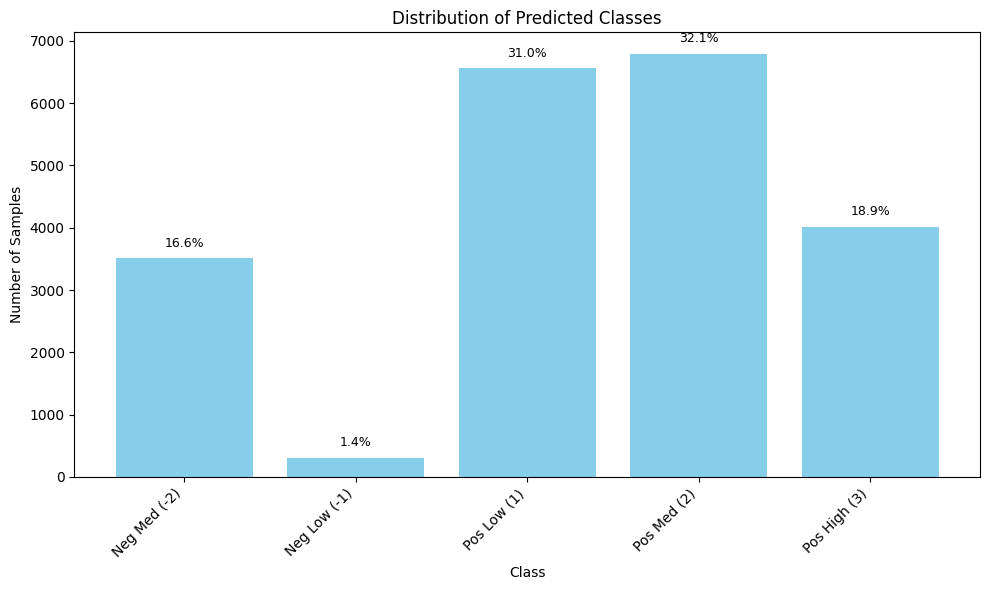

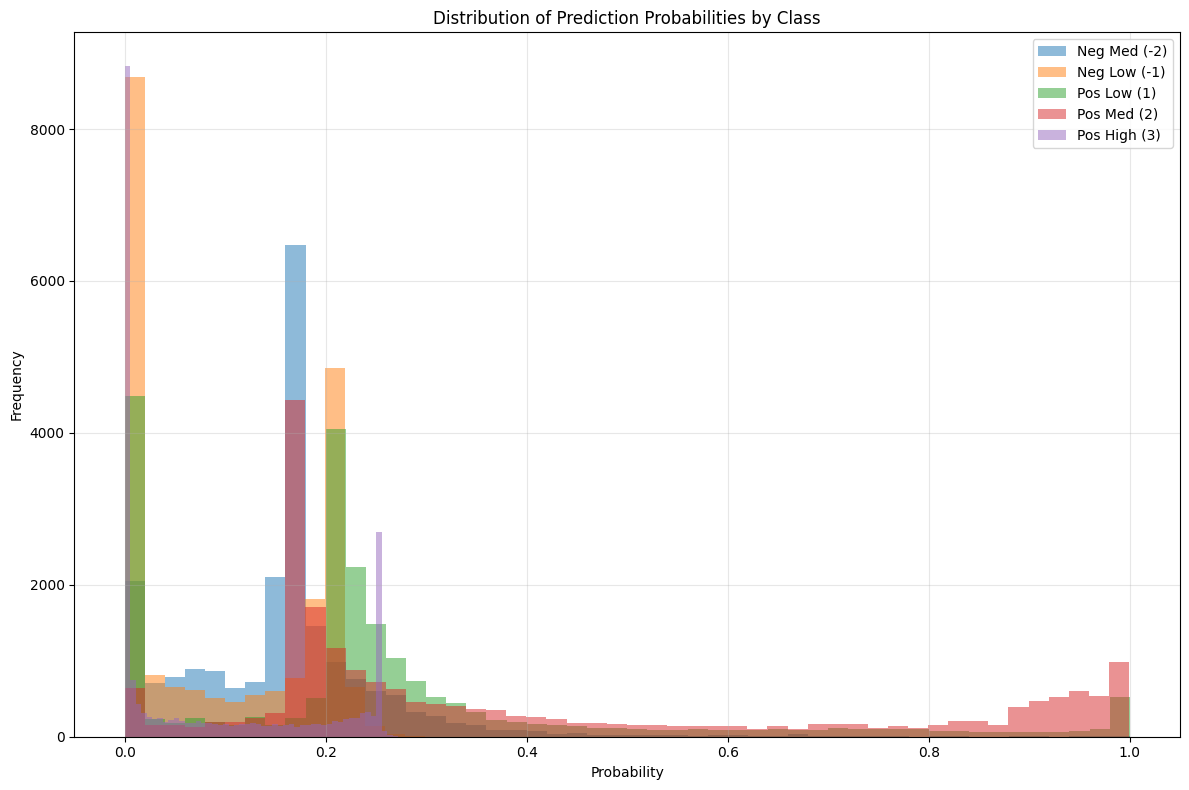

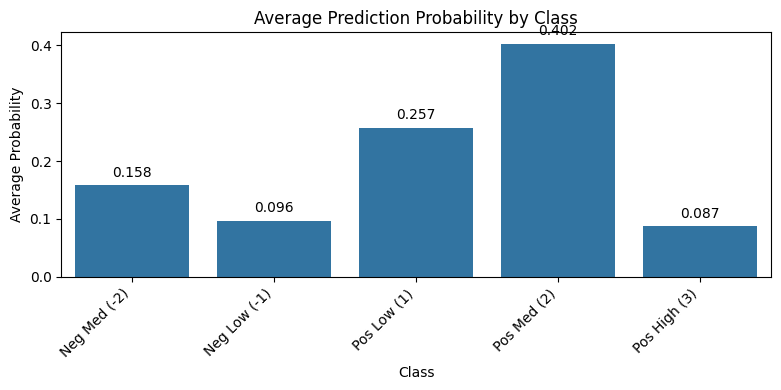


--- Prediction Complete ---


In [37]:
# --- Load the Best Model for Prediction ---
print("\n--- Loading Best Model for Prediction ---")
import glob
import os

# Find the most recent model file
model_files = glob.glob("best_model_*.pt")
if not model_files:
    raise FileNotFoundError("No saved model files found. Please train and save a model first.")

latest_model = max(model_files, key=os.path.getctime)
print(f"Loading model from: {latest_model}")

# Load the model with weights_only=False to handle numpy.core.multiarray.scalar
try:
    # First try to add the numpy scalar to safe globals
    import numpy as np
    from torch.serialization import add_safe_globals
    add_safe_globals([np.core.multiarray.scalar])
    loaded_dict = torch.load(latest_model)
except Exception as e:
    print(f"First loading attempt failed: {e}")
    print("Trying alternative loading method with weights_only=False...")
    # If that fails, use weights_only=False (only for trusted files)
    loaded_dict = torch.load(latest_model, weights_only=False)

print("Model loaded successfully!")

# Extract model parameters
loaded_input_dim = loaded_dict['input_dim']
loaded_hidden_dims = loaded_dict['hidden_dims']
loaded_output_dim = loaded_dict['output_dim']
loaded_dropout_rate = loaded_dict['dropout_rate']
loaded_activation_fn = nn.LeakyReLU if loaded_dict['activation_fn'] == 'LeakyReLU' else nn.ReLU
loaded_class_mapping = loaded_dict['class_mapping']
loaded_target_names = loaded_dict['target_names']
loaded_scaler_dna = loaded_dict['scaler_dna']
loaded_scaler_esm2 = loaded_dict['scaler_esm2']
loaded_dna_dim = loaded_dict['dna_embedding_dim']
loaded_esm2_dim = loaded_dict['esm2_embedding_dim']

print(f"Model architecture: {loaded_input_dim} → {loaded_hidden_dims} → {loaded_output_dim}")
print(f"Class mapping: {loaded_class_mapping}")

# Recreate the model architecture
prediction_model = SimpleClassifier(
    input_dim=loaded_input_dim,
    hidden_dims=loaded_hidden_dims,
    output_dim=loaded_output_dim,
    dropout_rate=loaded_dropout_rate,
    activation_fn=loaded_activation_fn
)

# Load the weights
prediction_model.load_state_dict(loaded_dict['model_state_dict'])
prediction_model.to(device)
prediction_model.eval()

# --- Prepare Data for Prediction ---
print("\n--- Preparing Data for Prediction ---")

# Scale the data using the loaded scalers
X_dna = X_fused[:, :loaded_dna_dim]
X_esm2 = X_fused[:, loaded_dna_dim:]

X_dna_scaled = loaded_scaler_dna.transform(X_dna)
X_esm2_scaled = loaded_scaler_esm2.transform(X_esm2)

X_fused_scaled = np.concatenate((X_dna_scaled, X_esm2_scaled), axis=1)
X_fused_tensor = torch.tensor(X_fused_scaled, dtype=torch.float32)

# --- Make Predictions ---
print("\n--- Making Predictions ---")
prediction_model.eval()
all_probs = []

with torch.no_grad():
    # Process in batches to avoid memory issues
    batch_size = 128
    for i in range(0, len(X_fused_tensor), batch_size):
        batch = X_fused_tensor[i:i+batch_size].to(device)
        outputs = prediction_model(batch)
        probs = F.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())

# Concatenate all batches
all_probs = np.vstack(all_probs)

# Get predicted classes
predicted_classes = np.argmax(all_probs, axis=1)

# Find pathogenic class index (Neg Med, -2)
pathogenic_idx = None
for idx, orig_label in loaded_class_mapping.items():
    if orig_label == -2:
        pathogenic_idx = idx
        print(f"Found pathogenic class index: {idx} (original label: {orig_label})")
        break

# Apply pathogenic probability threshold rule
if pathogenic_idx is not None:
    print(f"\nApplying pathogenic probability threshold rule (>0.22 for class index {pathogenic_idx})...")
    
    # Get pathogenic probabilities
    pathogenic_probs = all_probs[:, pathogenic_idx]
    
    # Create modified predictions based on the rule
    modified_predictions = predicted_classes.copy()
    
    # Apply the rule: if pathogenic probability > 0.22, predict as pathogenic
    threshold_mask = pathogenic_probs > 0.22
    modified_predictions[threshold_mask] = pathogenic_idx
    
    # Count changes
    changes = np.sum(modified_predictions != predicted_classes)
    print(f"Modified {changes} predictions ({changes/len(predicted_classes)*100:.2f}%) based on pathogenic probability threshold")
    
    # Use the modified predictions
    predicted_classes = modified_predictions

# --- Analyze and Visualize Results ---
print("\n--- Prediction Results ---")

# Convert numeric predictions to original labels
predicted_original_labels = [loaded_class_mapping[pred] for pred in predicted_classes]

# Count occurrences of each class
class_counts = {}
for i in range(loaded_output_dim):
    class_name = loaded_target_names[i]
    count = np.sum(predicted_classes == i)
    percentage = (count / len(predicted_classes)) * 100
    class_counts[class_name] = (count, percentage)
    print(f"Class {class_name}: {count} samples ({percentage:.2f}%)")

# Plot class distribution
plt.figure(figsize=(10, 6))
classes = list(class_counts.keys())
counts = [class_counts[c][0] for c in classes]
percentages = [class_counts[c][1] for c in classes]

plt.bar(classes, counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Predicted Classes')
plt.xticks(rotation=45, ha='right')

# Add percentage labels on top of bars
for i, (count, percentage) in enumerate(zip(counts, percentages)):
    plt.text(i, count + (max(counts) * 0.02), f"{percentage:.1f}%", 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Plot probability distribution for each class
plt.figure(figsize=(12, 8))
for i in range(loaded_output_dim):
    class_probs = all_probs[:, i]
    plt.hist(class_probs, bins=50, alpha=0.5, label=loaded_target_names[i])

plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Probabilities by Class')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create a heatmap of average probabilities
avg_probs = np.mean(all_probs, axis=0)
plt.figure(figsize=(8, 4))
sns.barplot(x=loaded_target_names, y=avg_probs)
plt.xlabel('Class')
plt.ylabel('Average Probability')
plt.title('Average Prediction Probability by Class')
plt.xticks(rotation=45, ha='right')
for i, prob in enumerate(avg_probs):
    plt.text(i, prob + 0.01, f"{prob:.3f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

print("\n--- Prediction Complete ---")
